# Indus Valley Scripts - ICIT coded Text Analysis for Decipherment

# Textual Analysis

Dataset was created as a csv file from ICIT web site from raw html files for each for the Text
Data labels were changes and a linearized copy of the original text was added

icit_text_text_corpus.csv


!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install nltk
!pip install ipywidgets
!pip install -U dill
!pip3 install requests
!pip3 install -U spacy

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import collections
import traceback

plt.style.use(style='seaborn')
%matplotlib inline

In [2]:
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams
from nltk.lm.preprocessing import pad_both_ends
from nltk.lm.preprocessing import flatten
from collections import defaultdict

In [3]:
CONST_NL=10 #Normalized length

In [4]:
# Set the filters on data here
drop_duplicate_texts = True

filter_by_site = False
filter_by_keywords = False
filter_by_text_length = True

#site = 'Mohenjo-daro'
site = 'Harappa'
keyword = "Bull1"

min_text_length=0
max_text_length=50

num_rows= 4999

In [5]:
orig_df=pd.read_csv('../../IndusCorpusUtils/data/icit_corpus/icit_text_text_corpus.csv',dtype=str, nrows=num_rows)
# set the max columns to none
pd.set_option('display.max_columns', None)

In [6]:
#Reverse text and add that as a new column
# Add text length as a column
list_reversed_text = []
for text in orig_df[orig_df.r_to_l_text!=''].r_to_l_text:
    # Tokenize to words
    # first split the string into chars
    chars = text.split(' ')
    length = len(chars)
    # then reverse the split string list and join with a space
    reversed_text = ' '.join(reversed(chars))
    list_reversed_text.append(reversed_text)
    
orig_df['reversed_text']= list_reversed_text


orig_df['text_length']= orig_df['l_to_r_text'].str.len().div(3).round()


print("Dataframe has ", len(orig_df.index), " rows")

orig_df.head()

Dataframe has  4999  rows


icit_id        site keywords text_class lines direction       text signs  \
0       1  Alamgirpur      NaN         SS     1       L/R  +410-017+     2   
1       2  Alamgirpur      NaN         SS     1       L/R  +410-017+     2   
2       3  Alamgirpur      NaN         SC     1       L/R  +405-017+     2   
3       4   Allahdino      NaN         ??     1       NaN  +220-000+     1   
4       5   Allahdino     Bull         UC     1       R/L  +740-235+     2   

  complete  alignment sign height text_images linearized_text l_to_r_text  \
0        Y  Unordered     Unequal         NaN         410 017     410 017   
1        Y        NaN         NaN         NaN         410 017     410 017   
2        Y        NaN         NaN         NaN         405 017     405 017   
3        N        NaN         NaN         NaN         220 000     000 220   
4        Y        NaN         NaN         NaN         740 235     235 740   

  r_to_l_text reversed_text  text_length  
0     017 410       410 017          2.0  
1     017 410       410 017          2.0  
2     017 405       405 017          2.0  
3     000 220       220 000          2.0  
4     740 235       235 740          2.0

In [7]:
# Retain texts that are only wanted

#remove the values where the text is unclear
df = orig_df[orig_df['r_to_l_text'].str.contains('000') == False] 

print("After removing unclear texts, we have ", len(df.index), " rows")

if(drop_duplicate_texts):
    #Remove out duplicate inplace
    
    #df = df.drop_duplicates(subset ="text",
    #                     keep = 'first', inplace = False)
    
    # We will consider a text duplicate only of the keywords are different
    # In that case we will retain the first occurance of it
    df = df.drop_duplicates(subset =["text", "keywords"], inplace = False, keep = "first")
    

    print("After removing duplicate texts, we have ", len(df.index), " rows")


#keep only the values that does not have multi-line text
df = df[df['text'].str.contains('/') == False] 

print("After removing multi-line text, we have ", len(df.index), " rows")


#keep only the values where the direction is known (if direction does not have a /, i,e. L/R or R/L)
#Single sign ones don't have direction and won't have /, wo we need to explicitly include it
#Btw standardized_text is Left to right as in English
df = df[(df['direction'].str.contains('/') == True) | (df['text_length'] ==1)] 

print("After keeping only text with known direction, we have ", len(df.index), " rows")

#Remove Unclear Multipart texts that have [ or ]
df = df[df['text'].str.contains("\[") == False] 
df = df[df['text'].str.contains("\]") == False] 

print("After keeping only text without multipart, we have ", len(df.index), " rows")


After removing unclear texts, we have  3945  rows
After removing duplicate texts, we have  2793  rows
After removing multi-line text, we have  2715  rows
After keeping only text with known direction, we have  2584  rows
After keeping only text without multipart, we have  2180  rows


In [8]:
# of those whose direction is know print out L/R and L/R text count
df_l_r = df[df['direction'].str.contains('L/R') == True] 

print("L/R texts: ", len(df_l_r.index))

df_r_l = df[df['direction'].str.contains('R/L') == True]

print("R/L texts: ", len(df_r_l.index))

L/R texts:  96
R/L texts:  1959


In [9]:
if(filter_by_site==True):
    #keep only the values that matches the provided site
    df = df[df['site'].str.contains(site) == True] 
    print("After filtering by site ", site, " it has ", len(df.index), " rows")

if(filter_by_keywords==True):
     #keep only the values that matches the provided keyword
    df = df[df['keywords'].str.contains(keyword) == True] 
    print("After filtering by keywords ", keyword, " it has ", len(df.index), " rows")

if(filter_by_text_length==True):
    df = df[(df['text_length'] >= min_text_length) & (df['text_length']<= max_text_length)]
    print("After filtering by text_length ",  " it has ", len(df.index), " rows")
    
#print(df)

After filtering by text_length   it has  2180  rows


In [10]:
#Keep the items with unclear text in another dataframe
df_unclear = orig_df[orig_df['r_to_l_text'].str.contains('000') == True]

#Note: Lot of the text with unclear text have direction empty

### Feature Extraction

In [11]:
y=df['site'].values
y.shape

# y axis is still the same
y_rev=df['site'].values
y_rev.shape

(2180,)

In [12]:
x=df['r_to_l_text'].values
x.shape

x_rev=df['reversed_text'].values
x_rev.shape

(2180,)

### Train-test split for doing cluster, model analysis for later

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
(x_train,x_test,y_train,y_test)=train_test_split(x,y,test_size=0.1, random_state=43)

(x_rev_train,x_rev_test,y_rev_train,y_rev_test)=train_test_split(x_rev,y_rev,test_size=0.1, random_state=43)

In [15]:
#Train data, fwd and reverse
df_train_x=pd.DataFrame(x_train)
df_train_x=df_train_x.rename(columns={0:'r_to_l_text'})

df_train_y=pd.DataFrame(y_train)
df_train_y=df_train_y.rename(columns={0:'site'})

df_train_x_rev=pd.DataFrame(x_rev_train)
df_train_x_rev=df_train_x_rev.rename(columns={0:'reversed_text'})

df_train_y_rev=pd.DataFrame(y_rev_train)
df_train_y_rev=df_train_y_rev.rename(columns={0:'site'})

#Test data, fwd and reverse
df_test_x=pd.DataFrame(x_test)
df_test_x=df_test_x.rename(columns={0:'r_to_l_text'})

df_test_y=pd.DataFrame(y_test)
df_test_y=df_test_y.rename(columns={0:'site'})

df_test_x_rev=pd.DataFrame(x_rev_test)
df_test_x_rev=df_test_x_rev.rename(columns={0:'reversed_text'})

df_test_y_rev=pd.DataFrame(y_rev_test)
df_test_y_rev=df_test_y_rev.rename(columns={0:'site'})

In [16]:
df_train=pd.concat([df_train_x,df_train_y],axis=1)
#print(df_train.head())

df_test=pd.concat([df_test_x,df_test_y],axis=1)
#print(df_test.head())

df_train_rev=pd.concat([df_train_x_rev,df_train_y_rev],axis=1)
#print(df_train_rev.head())

df_test_rev=pd.concat([df_test_x_rev,df_test_y_rev],axis=1)
#print(df_test_rev.head())

## First let us do stats on the whole data. Ignore df_train and df_test for now

## Text Length Analysis

In [17]:
def reverse_text(text):
    # first split the string into chars
    chars = text.split(' ')

    # then reverse the split string list and join with a space
    reversed_text = ' '.join(reversed(chars))
    return reversed_text

In [18]:
text_lengths=defaultdict(int)
total_length=0
total_count=0
for text in df[df.r_to_l_text!=''].r_to_l_text:
    chars = text.split(' ')
    length = len(chars)
    text_lengths[length]+=1
    total_length = total_length +length
    total_count = total_count+1

print('Average Text Length:',round(total_length/total_count,2) )
#print(text_lengths.items())

df_text_lengths=pd.DataFrame(sorted(text_lengths.items(),key=lambda x:x[1],reverse=True))
pd_text_lengths1=df_text_lengths[0][:20]
pd_text_lengths2=df_text_lengths[1][:20]

Average Text Length: 4.21


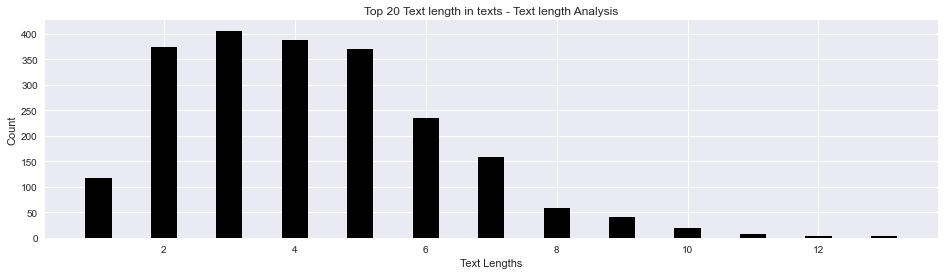

In [19]:
plt.figure(1,figsize=(16,4))

plt.bar(pd_text_lengths1,pd_text_lengths2, color ='black',
        width = 0.4)
 
plt.xlabel("Text Lengths")
plt.ylabel("Count")
plt.title("Top 20 Text length in texts - Text length Analysis")

plt.savefig("text-length.png")
plt.show()

## N Gram Analysis of the Texts

In [20]:
from nltk.tokenize import word_tokenize,sent_tokenize

In [21]:
# Get ngram as list given a text (pass direction_of_string as "R/L" or "L/R")
def get_ngrams_as_list(data,direction_of_string,num):
    
    if(direction_of_string=="R/L"):
        # We need to convert R/L text to L/R to be able to get ngrams using nltk
        data_string = reverse_text(data)
    
    else: data_string= data
    
    n_grams =  ngrams(nltk.word_tokenize(data_string), num)
    return  [ ' '.join(grams) for grams in n_grams]

In [22]:
text_unigrams=defaultdict(int)
text_bigrams=defaultdict(int)
text_trigrams=defaultdict(int)
text_quadrigrams=defaultdict(int)
text_pentagrams=defaultdict(int)

In [23]:
#Tokenize the text

tokenized_text = list(df[df.r_to_l_text!=''].r_to_l_text.apply(word_tokenize))
reverse_tokenized_text = list(df[df.reversed_text!=''].reversed_text.apply(word_tokenize))

#print("tokenized_text:",tokenized_text)

In [24]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 1):
    text_unigrams[word]+=1

#text_unigrams.items()

In [25]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 2):
    text_bigrams[word]+=1

#text_bigrams.items()

In [26]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 3):
    text_trigrams[word]+=1

#text_trigrams.items()

In [27]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 4):
    text_quadrigrams[word]+=1

#text_quadrigrams.items()

In [28]:
for text in df[df.r_to_l_text!=''].r_to_l_text:
  for word in get_ngrams_as_list(text,"R/L", 5):
    text_pentagrams[word]+=1

#text_pentagrams.items()

In [29]:
df_text_unigrams=pd.DataFrame(sorted(text_unigrams.items(),key=lambda x:x[1],reverse=True))
df_text_bigrams=pd.DataFrame(sorted(text_bigrams.items(),key=lambda x:x[1],reverse=True))
df_text_trigrams=pd.DataFrame(sorted(text_trigrams.items(),key=lambda x:x[1],reverse=True))
df_text_quadrigrams=pd.DataFrame(sorted(text_quadrigrams.items(),key=lambda x:x[1],reverse=True))
df_text_pentagrams=pd.DataFrame(sorted(text_pentagrams.items(),key=lambda x:x[1],reverse=True))

In [30]:
print("Number of distinct Unigrams", len(df_text_unigrams))
print("Number of distinct Bigrams", len(df_text_bigrams))
print("Number of distinct Trigrams", len(df_text_trigrams))
print("Number of distinct Quadrigrams", len(df_text_quadrigrams))
print("Number of distinct Pentagrams", len(df_text_pentagrams))

Number of distinct Unigrams 598
Number of distinct Bigrams 2846
Number of distinct Trigrams 3545
Number of distinct Quadrigrams 2881
Number of distinct Pentagrams 1872


In [31]:
pd_text_unigrams1=df_text_unigrams[0][:20]
pd_text_unigrams2=df_text_unigrams[1][:20]

pd_text_bigrams1=df_text_bigrams[0][:20]
pd_text_bigrams2=df_text_bigrams[1][:20]

pd_text_trigrams1=df_text_trigrams[0][:10]
pd_text_trigrams2=df_text_trigrams[1][:10]

pd_text_quadrigrams1=df_text_quadrigrams[0][:10]
pd_text_quadrigrams2=df_text_quadrigrams[1][:10]

pd_text_pentagrams1=df_text_pentagrams[0][:10]
pd_text_pentagrams2=df_text_pentagrams[1][:10]

In [32]:
# import image module
from IPython.display import Image

#Image(url="../ICIT/ICIT Sign List/S740.jpg", width=20, height=20)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

def get_char_path(name):
    path = "../ICIT/ICIT Sign List/S{}.jpg".format(name.title())
    return path

def get_char_image(name):
    path = "../ICIT/ICIT Sign List/S{}.jpg".format(name.title())
    im = plt.imread(path)
    return im

def offset_image(coord, name, ax):
    img = get_char_image(name)
    im = OffsetImage(img, zoom=0.13)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -25.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)
    

In [34]:
def plot_with_image_Annotations(series1, series2, this_color, this_width, this_xlabel, this_ylabel, this_title, this_file_name):

    #plt.rcParams['figure.figsize'] = [15, 15]
    plt.rcParams['figure.figsize'] = [20, 5]
    plt.rcParams['figure.dpi'] = 140
    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)
    
    #plt.figure(2,figsize=(25,10))
    fig, ax = plt.subplots()

    ax.bar(series1, series2, color =this_color,
            width = this_width)
    ax.set_xticks(range(len(series1)))
    ax.set_xticklabels(series1, fontsize=18)
    
    ax.tick_params(axis='x', which='major', pad=50)

    for i, c in enumerate(series1):
        offset_image(i, c, ax)

    plt.xlabel(this_xlabel, fontsize=18)
    plt.ylabel(this_ylabel, fontsize=18)
    plt.title(this_title, fontsize=18)

    plt.savefig(this_file_name)
    plt.show()

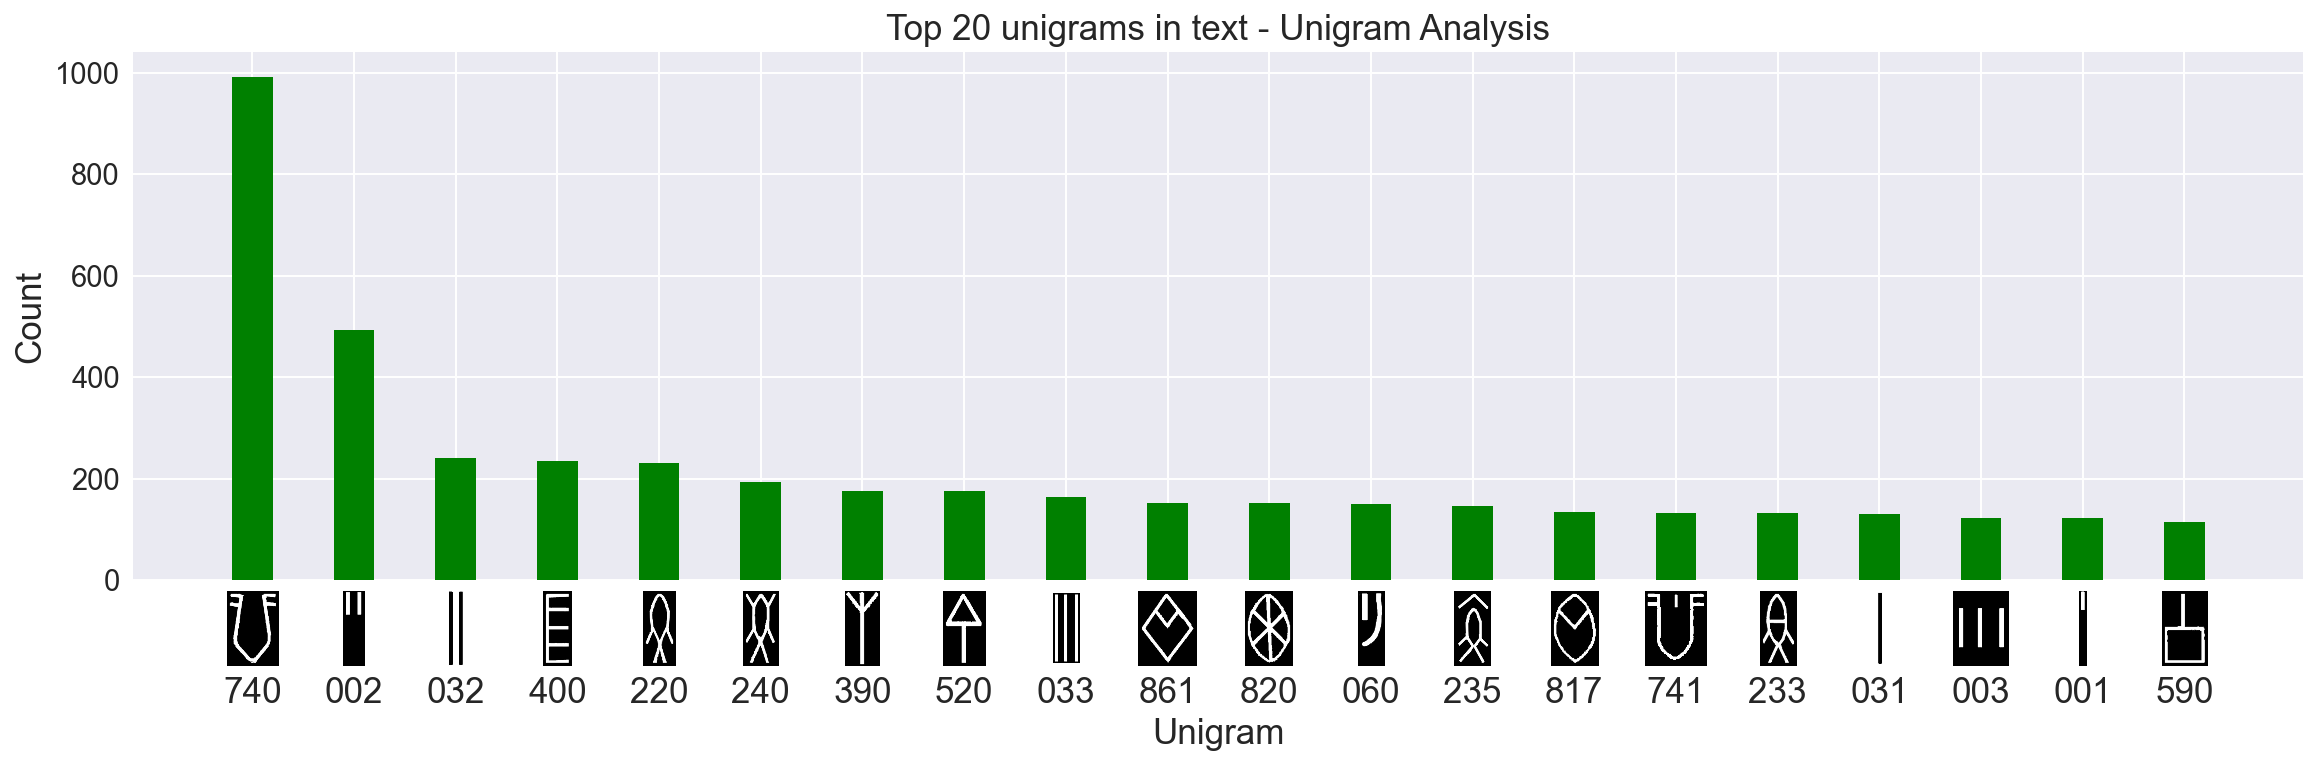

In [35]:
plot_with_image_Annotations(pd_text_unigrams1,pd_text_unigrams2, "green", 0.4, "Unigram","Count", "Top 20 unigrams in text - Unigram Analysis", "text-unigram.png")


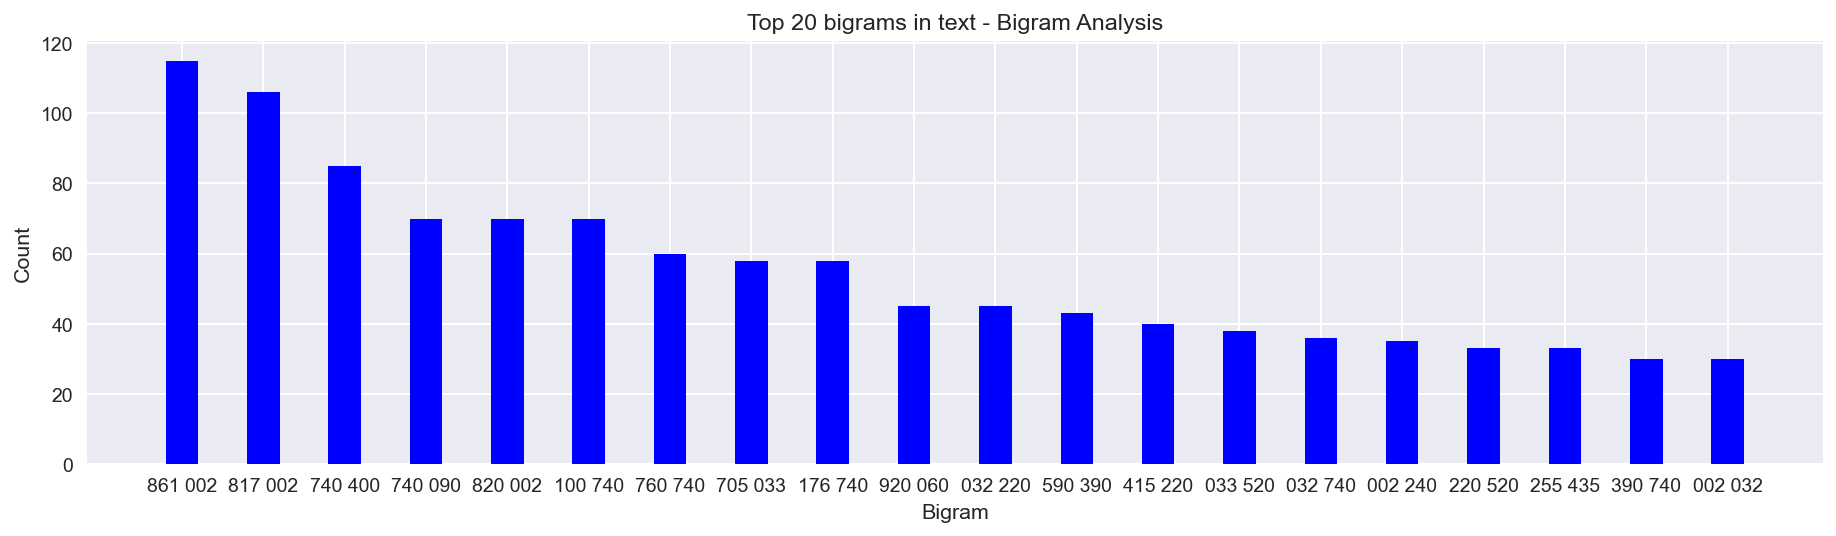

In [63]:
plt.figure(3,figsize=(16,4))

plt.bar(pd_text_bigrams1,pd_text_bigrams2, color ='blue',
        width = 0.4)
plt.rc('xtick',labelsize=3)
plt.rc('ytick',labelsize=3)
 
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Top 20 bigrams in text - Bigram Analysis")

plt.savefig("text-bigram.png")
plt.show()

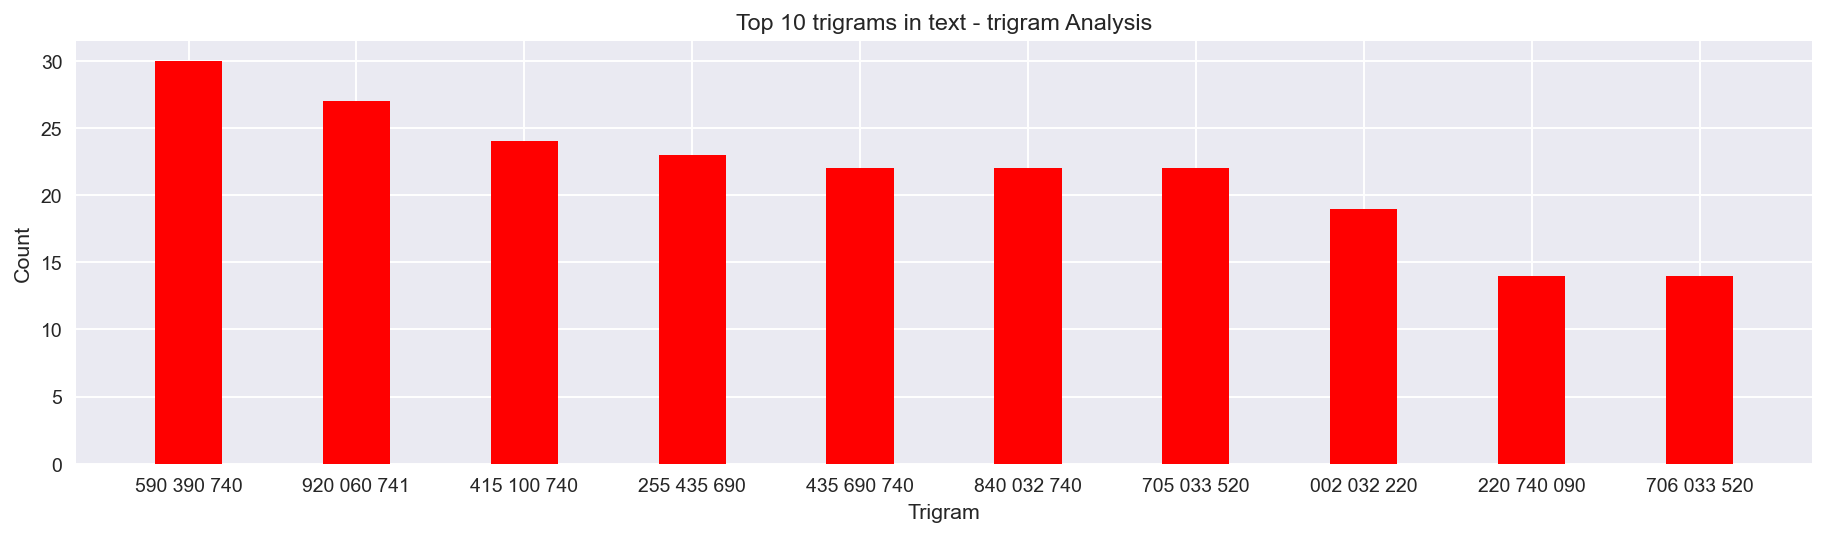

In [67]:
plt.figure(4,figsize=(16,4))

plt.bar(pd_text_trigrams1,pd_text_trigrams2, color ='red',
        width = 0.4)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Top 10 trigrams in text - trigram Analysis")

plt.savefig("text-trigram.png")
plt.show()

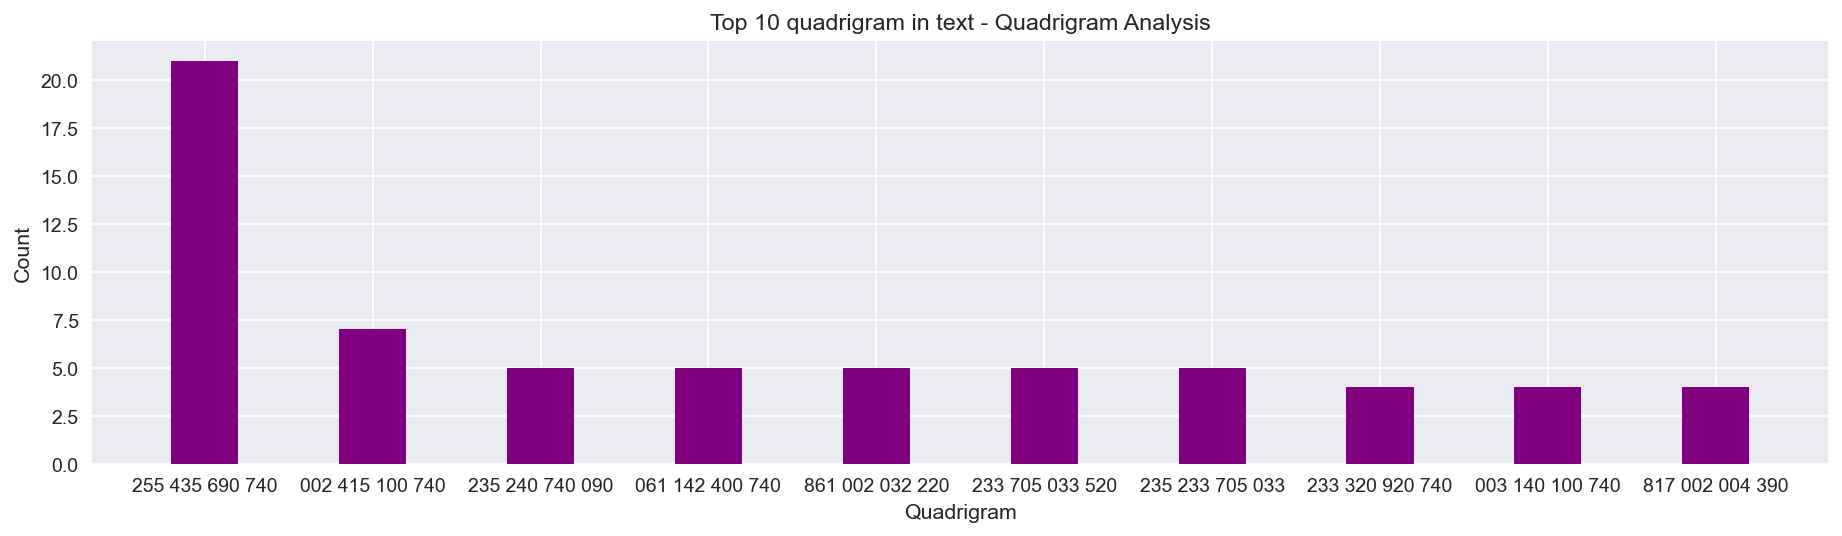

In [68]:
plt.figure(5,figsize=(16,4))

plt.bar(pd_text_quadrigrams1,pd_text_quadrigrams2, color ='purple',
        width = 0.4)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

plt.xlabel("Quadrigram")
plt.ylabel("Count")
plt.title("Top 10 quadrigram in text - Quadrigram Analysis")

plt.savefig("text-quadrigram.png")
plt.show()

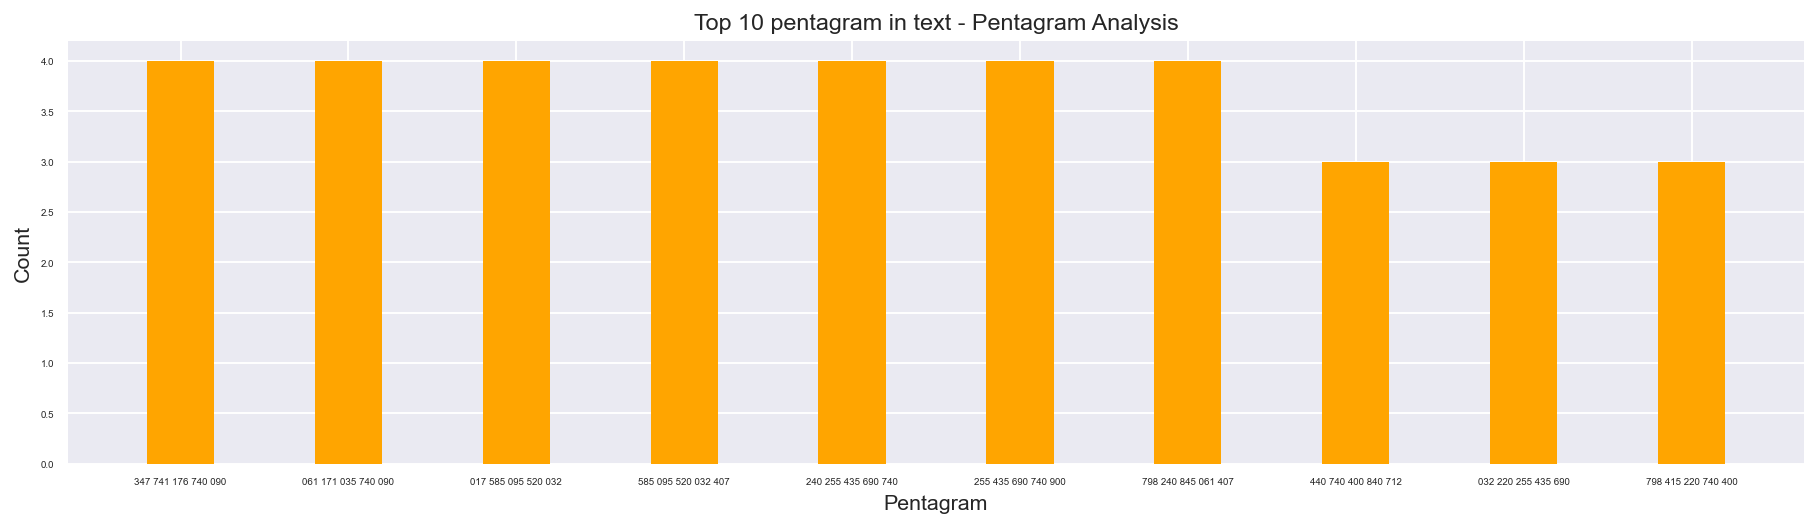

In [73]:
plt.figure(6,figsize=(16,4))

plt.bar(pd_text_pentagrams1,pd_text_pentagrams2, color ='orange',
        width = 0.4)
plt.rc('xtick',labelsize=5)
plt.rc('ytick',labelsize=5)

plt.xlabel("Pentagram")
plt.ylabel("Count")
plt.title("Top 10 pentagram in text - Pentagram Analysis")

plt.savefig("text-pentagram.png")
plt.show()

## More Statistical Analysis

# Text Positional Analysis

In [40]:
from nltk.tokenize import word_tokenize,sent_tokenize
from typing import Dict
from bisect import bisect
from itertools import accumulate

class PositionalNgramModel:
    text_norm_position_unigrams_freq_dict=None
    df_text_norm_position_unigrams_freq=None
    df_text_norm_position_unigrams_prob=None
    text_norm_position_unigrams_maxValueIndex_dict = None
    text_norm_position_unigrams_unigrams_tuple = ()
    
    text_norm_position_bigrams_freq_dict = None
    df_text_norm_position_bigrams_freq=None
    df_text_norm_position_bigrams_prob=None
    text_norm_position_bigrams_maxValueIndex_dict = None
    
    text_norm_position_trigrams_freq_dict = None
    df_text_norm_position_trigrams_freq=None
    df_text_norm_position_trigrams_prob=None
    text_norm_position_trigrams_maxValueIndex_dict = None
    
    text_norm_position_quadrigrams_freq_dict= None
    df_text_norm_position_quadrigrams_freq=None
    df_text_norm_position_quadrigrams_prob=None
    text_norm_position_bigrams_maxValueIndex_dict = None
    

    def _random_generator(self, seed_or_generator):
        if isinstance(seed_or_generator, random.Random):
            return seed_or_generator
        return random.Random(seed_or_generator)
    
    def _weighted_choice(self, population, weights, random_generator=None):
        """Like random.choice, but with weights.
        Heavily inspired by python 3.6 `random.choices`.
        """
        if not population:
            raise ValueError("Can't choose from empty population")
        if len(population) != len(weights):
            raise ValueError("The number of weights does not match the population")
        cum_weights = list(accumulate(weights))
        total = cum_weights[-1]
        threshold = random_generator.random()
        return population[bisect(cum_weights, total * threshold)]
    
    # To get a Positional Number for a unigram, bigram, trigram and Quadrigram
    # l = Length of the text
    # s = starting position of the first character of the ngram
    # wp = weighted position = int(s/l)
    # Get the normalized position
    # Since the text passed is L/R,start index i from length of the text
    def get_norm_position(self, text,direction_of_string, search_string):
        try:
            num_chars, minp, maxp,w = 0,-1,-1,0
            sp=-1
            index=-1
            pos=-1

            #ngrams which are used as search_strings are generated from left to right, so text need to be changed to L/R

            if(direction_of_string=="R/L"):
                new_text = reverse_text(text)
            else: new_text = text


            l_pos= len(new_text )

            chars = new_text .split(' ')
            num_chars = len(chars)
            w= num_chars/CONST_NL


            pos = new_text.find(search_string)
            if(pos<0):  #not found
                return sp, minp, maxp, w
            else: 
                #sp = round((l_pos-pos)/4)
                sp = round(pos/4 +1)

            minp= int((sp-1)* (CONST_NL/num_chars) +1)
            maxp = int(sp*CONST_NL/num_chars)

            #print("text, search_string", new_text ,",", search_string)
            #print("l_pos, pos, sp, minp, maxp", l_pos, pos,sp, minp, maxp)

            if(minp<1): minp=1
            elif(minp>CONST_NL): minp = CONST_NL

            if(maxp<1): maxp=1
            elif(maxp>CONST_NL): maxp = CONST_NL

        except Exception as e:
            print("Exception:", e.__class__, "get_norm_position")
            traceback.print_exc()

        return sp,minp, maxp, w


    def get_text_norm_position_ngrams_freq(self,a,direction_of_string, n):

        average_allocation= True # Average out minp and maxp and allocate to the histogram. Don't care about weight

        text_norm_position_ngrams_freq=defaultdict(dict[int, int])
        norm_pos =-1
        i=0
        sp=-1

        try:
            #Fill the values with zeros in decreasing order so that we can keep same order in graph
            for text in a:
              for word in get_ngrams_as_list(text,direction_of_string, n):
                for j in range (10,0, -1):
                    text_norm_position_ngrams_freq[word][j]=0

            for text in a:
              for word in get_ngrams_as_list(text,direction_of_string, n):
                initial_char = word #Look for position of Initial char of the ngram
                sp,minp, maxp, w = self.get_norm_position(text,direction_of_string, initial_char)

                if(minp<0 or maxp<0): break #No match


                if(average_allocation):
                    norm_pos = round((minp+ maxp)/2)
                    #print("word, norm_pos", word, norm_pos)
                    val = text_norm_position_ngrams_freq[word].get(norm_pos,0)
                    text_norm_position_ngrams_freq[word][norm_pos]= val+ w
                else:

                    if(minp!=maxp):
                        val = text_norm_position_ngrams_freq[word].get(minp,0)
                        text_norm_position_ngrams_freq[word][minp]= val+ w

                        val = text_norm_position_ngrams_freq[word].get(maxp,0)
                        text_norm_position_ngrams_freq[word][maxp]= val +w
                    else:
                        val = text_norm_position_ngrams_freq[word].get(minp,0)
                        text_norm_position_ngrams_freq[word][minp]= val+ w

                #if(initial_char=="740"): print(i,":Text:",text, "Char", initial_char, "sp, minp, maxp, w, norm_pos", sp, minp, maxp, w, norm_pos)

                #if(initial_char=="817 002"): print(i,":Text:",text, "Char:", initial_char, sp, minp, maxp, w, norm_pos)

                i=i+1

        except Exception as e:
                print("Exception:", e.__class__, "get_text_norm_position_ngrams_freq")
                traceback.print_exc()

        return  text_norm_position_ngrams_freq

    # Can be generatilzed to any N later
    def fit(self, a, direction_of_string):
        try:
            print(a)

            self.text_norm_position_unigrams_freq_dict=defaultdict(dict[int, int])
            self.text_norm_position_unigrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string, 1)
            self.df_text_norm_position_unigrams_freq=pd.DataFrame(self.text_norm_position_unigrams_freq_dict)

            self.df_text_norm_position_unigrams_prob = self.df_text_norm_position_unigrams_freq.div(self.df_text_norm_position_unigrams_freq.sum(axis=1), axis=0)
            self.df_text_norm_position_unigrams_prob = self.df_text_norm_position_unigrams_prob.assign(max_value=self.df_text_norm_position_unigrams_prob.values.max(1))
            df_text_norm_position_unigrams_maxValueIndex = self.df_text_norm_position_unigrams_prob.idxmax(axis = 1)
            self.text_norm_position_unigrams_maxValueIndex_dict = df_text_norm_position_unigrams_maxValueIndex.to_dict()

            # Build the unigrams tuple
            for col in self.df_text_norm_position_unigrams_prob:
                self.text_norm_position_unigrams_unigrams_tuple =  self.text_norm_position_unigrams_unigrams_tuple + (col,)

            self.text_norm_position_unigrams_unigrams_tuple= sorted(self.text_norm_position_unigrams_unigrams_tuple)

            #print(self.df_text_norm_position_unigrams_freq)
            #print(self.df_text_norm_position_unigrams_prob)
            #print(self.text_norm_position_unigrams_maxValueIndex_dict)

            #Bigram
            self.text_norm_position_bigrams_freq_dict=defaultdict(dict[int, int])
            self.text_norm_position_bigrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string,2)
            self.df_text_norm_position_bigrams_freq=pd.DataFrame(self.text_norm_position_bigrams_freq_dict)
            self.df_text_norm_position_bigrams_prob = self.df_text_norm_position_bigrams_freq.div(self.df_text_norm_position_bigrams_freq.sum(axis=1), axis=0)
            #print(self.df_text_norm_position_bigrams_freq)

            #Trigram
            self.text_norm_position_trigrams_freq_dict=defaultdict(dict[int, int])
            self.text_norm_position_trigrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string,3)
            self.df_text_norm_position_trigrams_freq=pd.DataFrame(self.text_norm_position_trigrams_freq_dict)
            self.df_text_norm_position_trigrams_prob = self.df_text_norm_position_trigrams_freq.div(self.df_text_norm_position_trigrams_freq.sum(axis=1), axis=0)
            #print(self.df_text_norm_position_trigrams_freq)

            #Quadrigram
            self.text_norm_position_quadrigrams_freq_dict=defaultdict(dict[int, int])
            self.text_norm_position_quadrigrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string,4)
            self.df_text_norm_position_quadrigrams_freq=pd.DataFrame(self.text_norm_position_quadrigrams_freq_dict)
            self.df_text_norm_position_quadrigrams_prob = self.df_text_norm_position_quadrigrams_freq.div(self.df_text_norm_position_quadrigrams_freq.sum(axis=1), axis=0)
            #print(df_text_norm_position_quadrigrams_freq)
            
            #Pentagram
            self.text_norm_position_pentagrams_freq_dict=defaultdict(dict[int, int])
            self.text_norm_position_pentagrams_freq_dict=self.get_text_norm_position_ngrams_freq(a,direction_of_string,5)
            self.df_text_norm_position_pentagrams_freq=pd.DataFrame(self.text_norm_position_pentagrams_freq_dict)
            self.df_text_norm_position_pentagrams_prob = self.df_text_norm_position_pentagrams_freq.div(self.df_text_norm_position_pentagrams_freq.sum(axis=1), axis=0)
            #print(df_text_norm_position_pentagrams_freq)
        
        
        except Exception as e:
            print("Exception:", e.__class__, "fit")
            traceback.print_exc()
        
        return self.df_text_norm_position_unigrams_prob, self.df_text_norm_position_bigrams_prob, self.df_text_norm_position_trigrams_prob,self.df_text_norm_position_quadrigrams_prob, self.df_text_norm_position_pentagrams_prob

    def get_text_norm_position_unigrams_char_with_max_prob(self, position):
        try:
            char= self.text_norm_position_unigrams_maxValueIndex_dict[position]
            print("Max Prob for Position:", position, "is for character:",char )
        
        except Exception as e:
            print("Exception:", e.__class__, "get_text_norm_position_unigrams_char_with_max_prob")
            traceback.print_exc()
        return char
    
    def get_text_norm_position_unigrams_char_prob(self, position, word):
       
        prob=0
        try:
            prob = self.df_text_norm_position_unigrams_prob.loc[position,word]
        except Exception as e:
            print("Exception:", e.__class__, "get_text_norm_position_unigrams_char_prob")
            traceback.print_exc()
        return prob
    
    def get_text_norm_position_unigrams_char_with_weighted_prob(self, position):

        try:
            random_generator = self._random_generator(random_seed)
            #print(tuple(self.get_text_norm_position_unigrams_char_prob(position, w) for w in  self.text_norm_position_unigrams_unigrams_tuple)) 

            return self._weighted_choice(
                    self.text_norm_position_unigrams_unigrams_tuple,
                    tuple(self.get_text_norm_position_unigrams_char_prob(position, w) for w in  self.text_norm_position_unigrams_unigrams_tuple),
                    random_generator,
                )
        except Exception as e:
            print("Exception:", e.__class__, "get_text_norm_position_unigrams_char_with_weighted_prob")
            traceback.print_exc()
    
    def find_characters(self, a, seed):
        #For each of the text with unclear character go through it
        ans=-1
        out_char = None
        out_char_list = []
        try:
            for text in a :
                print("Finding Unclear character for", text)
                chars = text.split(' ')
                index = len(chars) - chars.index("000")
                if(index<0):  #not found
                    return 
                else: 
                    # Find the char with highest probablity for this position
                    print(index)
                    out_char = self.get_text_norm_position_unigrams_char_with_max_prob(index)
                    print("Index, out_char:", index, out_char)
                    out_char_list.append(out_char)
    
        except Exception as e:
            print("Exception:", e.__class__, "find_characters")
            
        return  out_char_list

In [41]:

posNgramModel = PositionalNgramModel()

print(posNgramModel.get_norm_position("740 231 220 032 002 817", "R/L", "817 002"))

(1, 1, 1, 0.6)


In [42]:
print(posNgramModel.get_norm_position("853 235 220 740 090", "R/L", "853"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","235"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","705"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","033"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","033 904"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","740"))

print(posNgramModel.get_norm_position("740 904 033 705 235", "R/L","123"))

print(posNgramModel.get_norm_position("235 705 033 904 740", "R/L","740"))

(5, 9, 10, 0.5)
(1, 1, 2, 0.5)
(2, 3, 4, 0.5)
(3, 5, 6, 0.5)
(3, 5, 6, 0.5)
(5, 9, 10, 0.5)
(-1, -1, -1, 0.5)
(1, 1, 2, 0.5)


In [43]:
a = df[df.r_to_l_text!=''].r_to_l_text
df_text_norm_position_unigrams_prob, df_text_norm_position_bigrams_prob, df_text_norm_position_trigrams_prob,df_text_norm_position_quadrigrams_prob, df_text_norm_position_pentagrams_prob = posNgramModel.fit(a, "R/L")


0                   017 410
2                   017 405
4                   740 235
5               740 390 590
6           368 390 125 033
               ...         
4952                840 705
4953            740 482 838
4959            723 066 828
4967        041 705 002 905
4985    740 061 001 031 820
Name: r_to_l_text, Length: 2180, dtype: object


In [44]:
posNgramModel.get_text_norm_position_unigrams_char_with_max_prob(10)

Max Prob for Position: 10 is for character: 740


'740'

In [45]:
#print(df_text_norm_position_unigrams_prob)

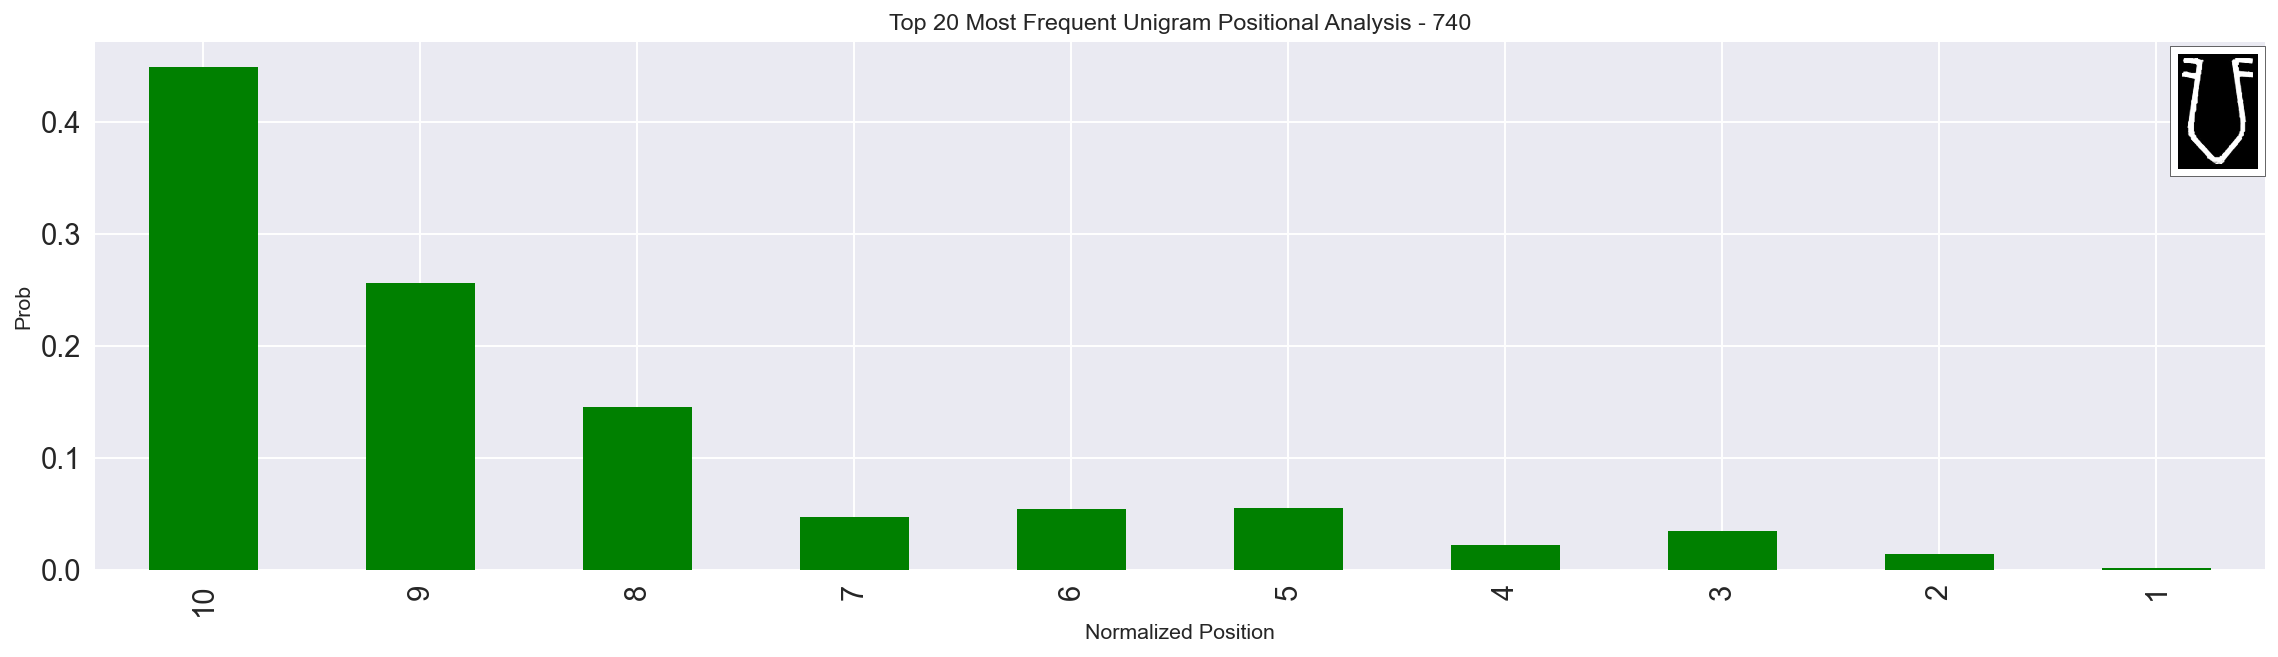

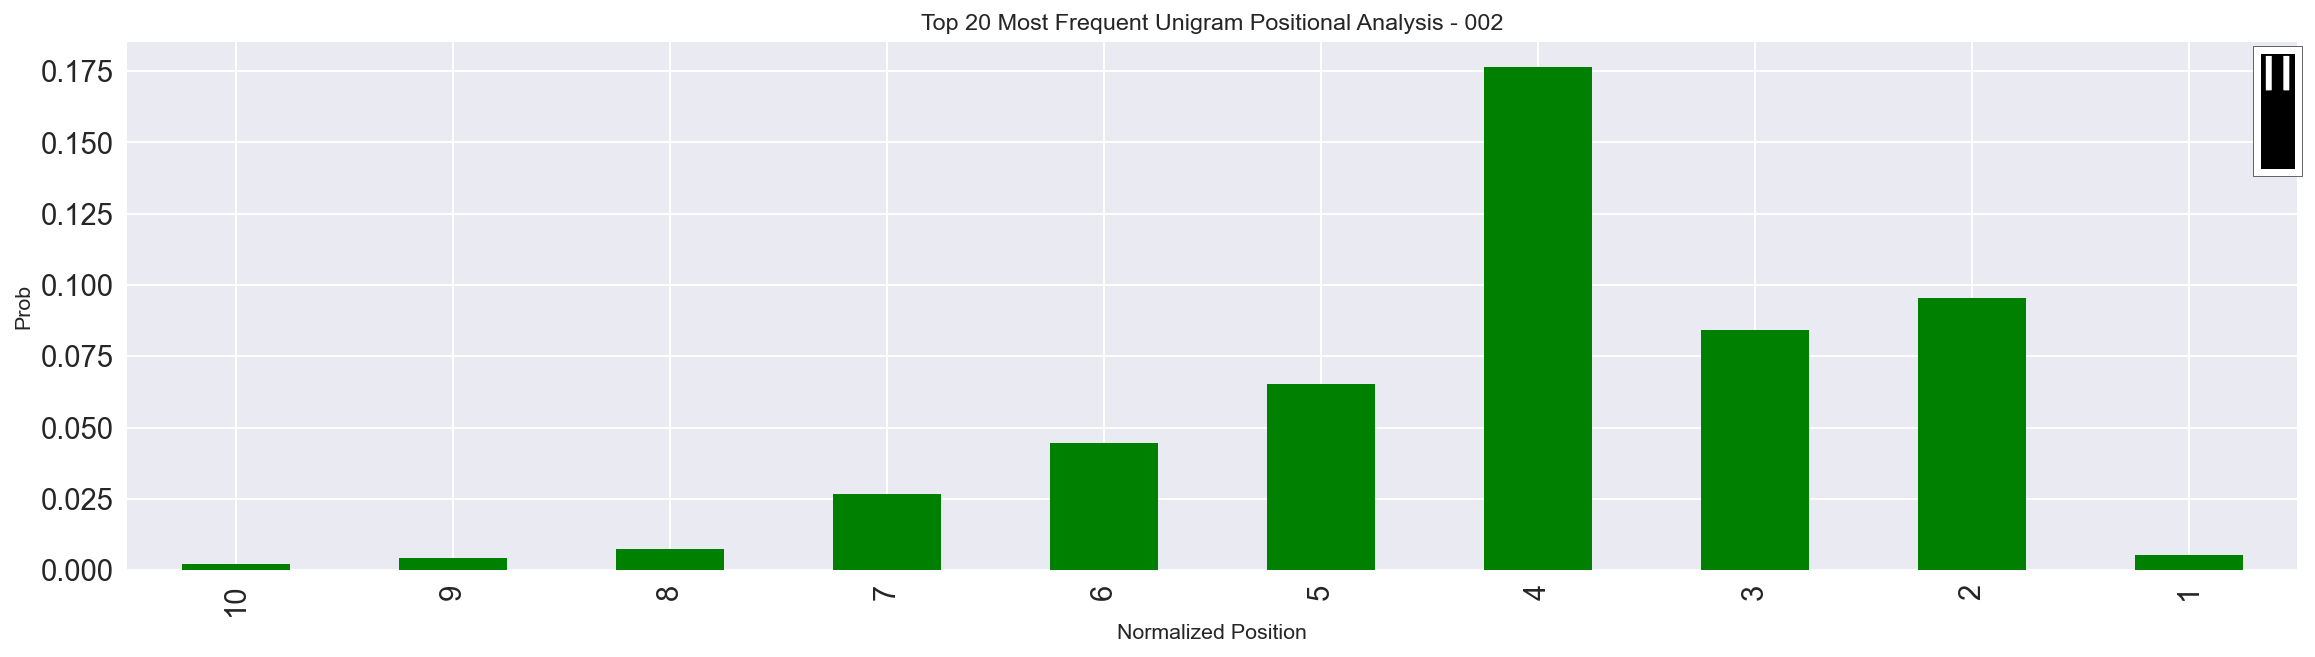

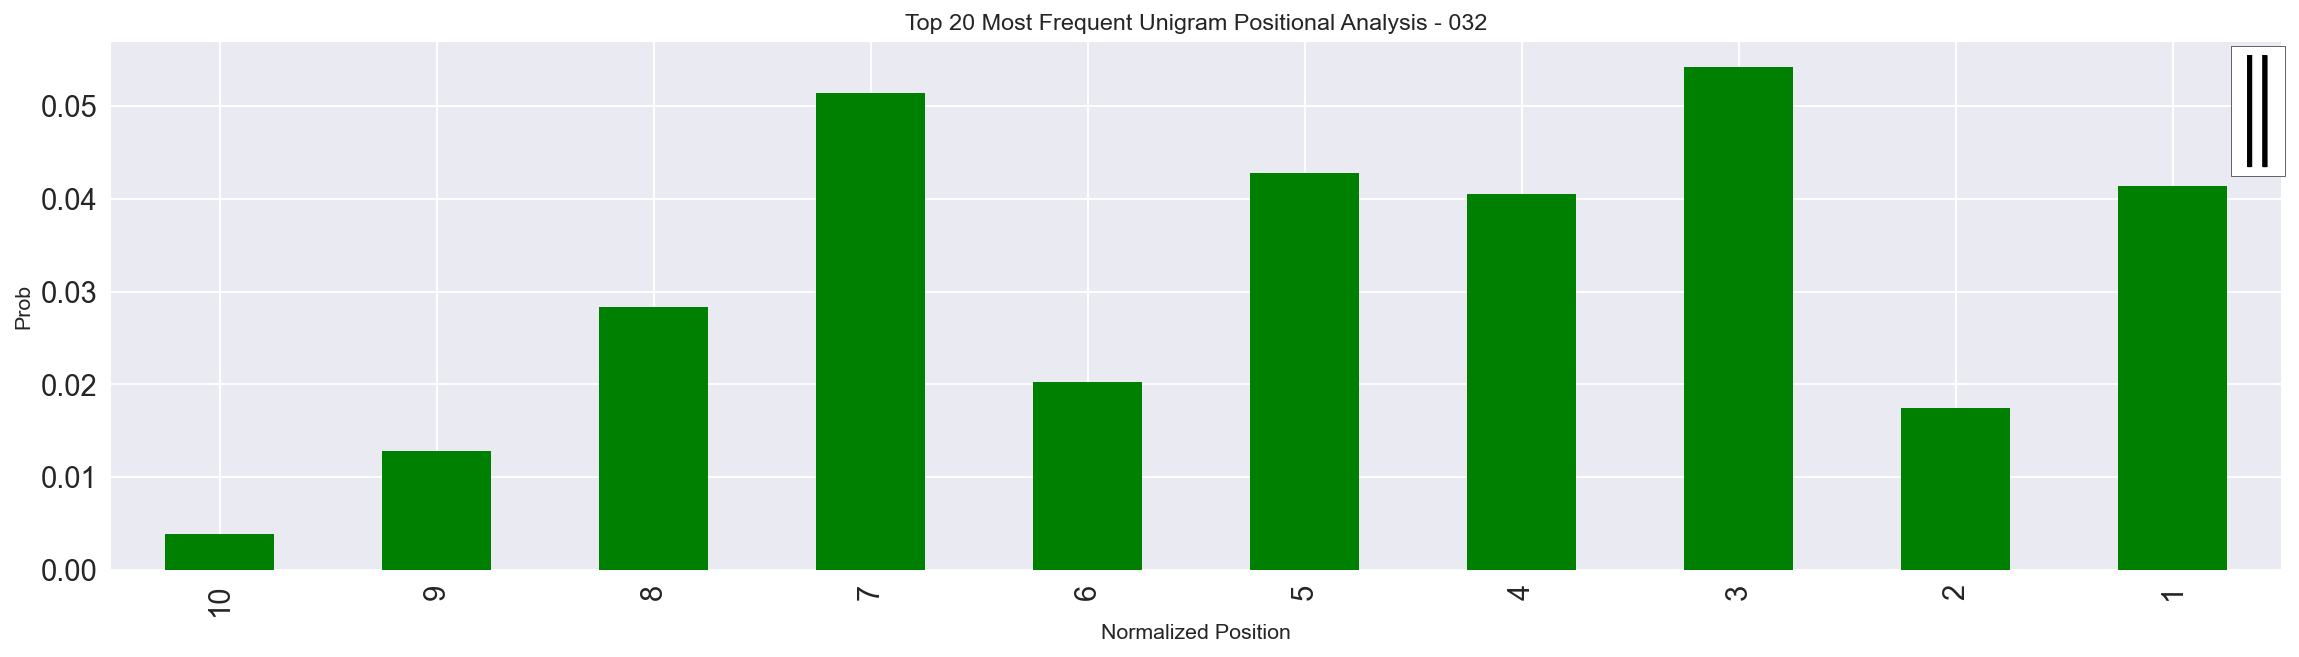

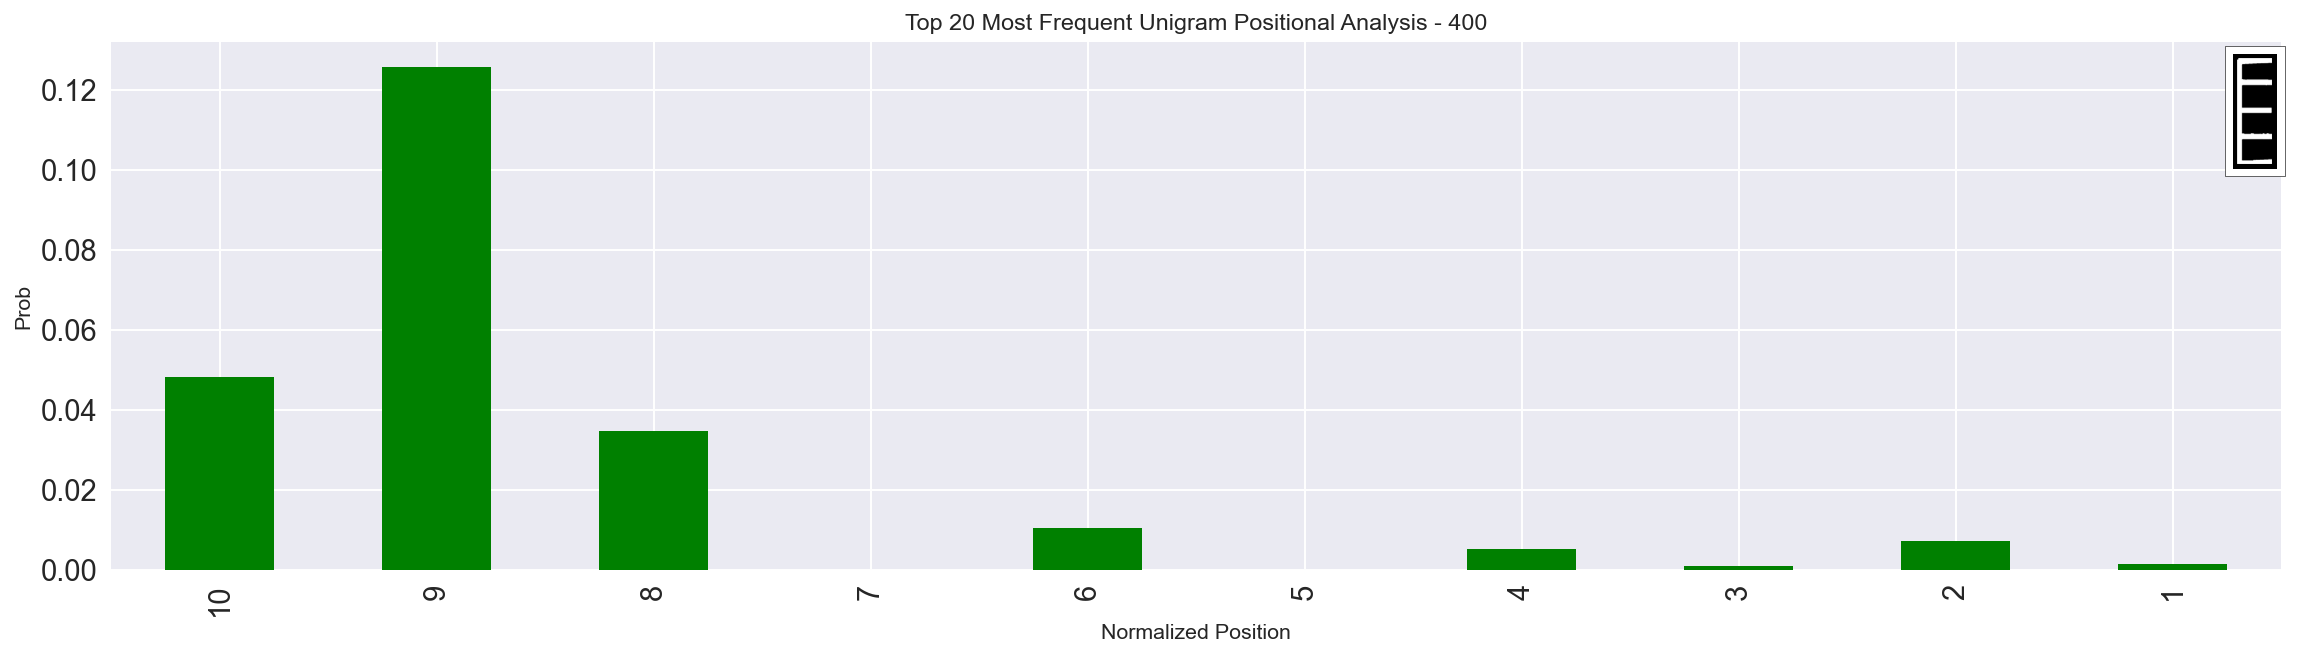

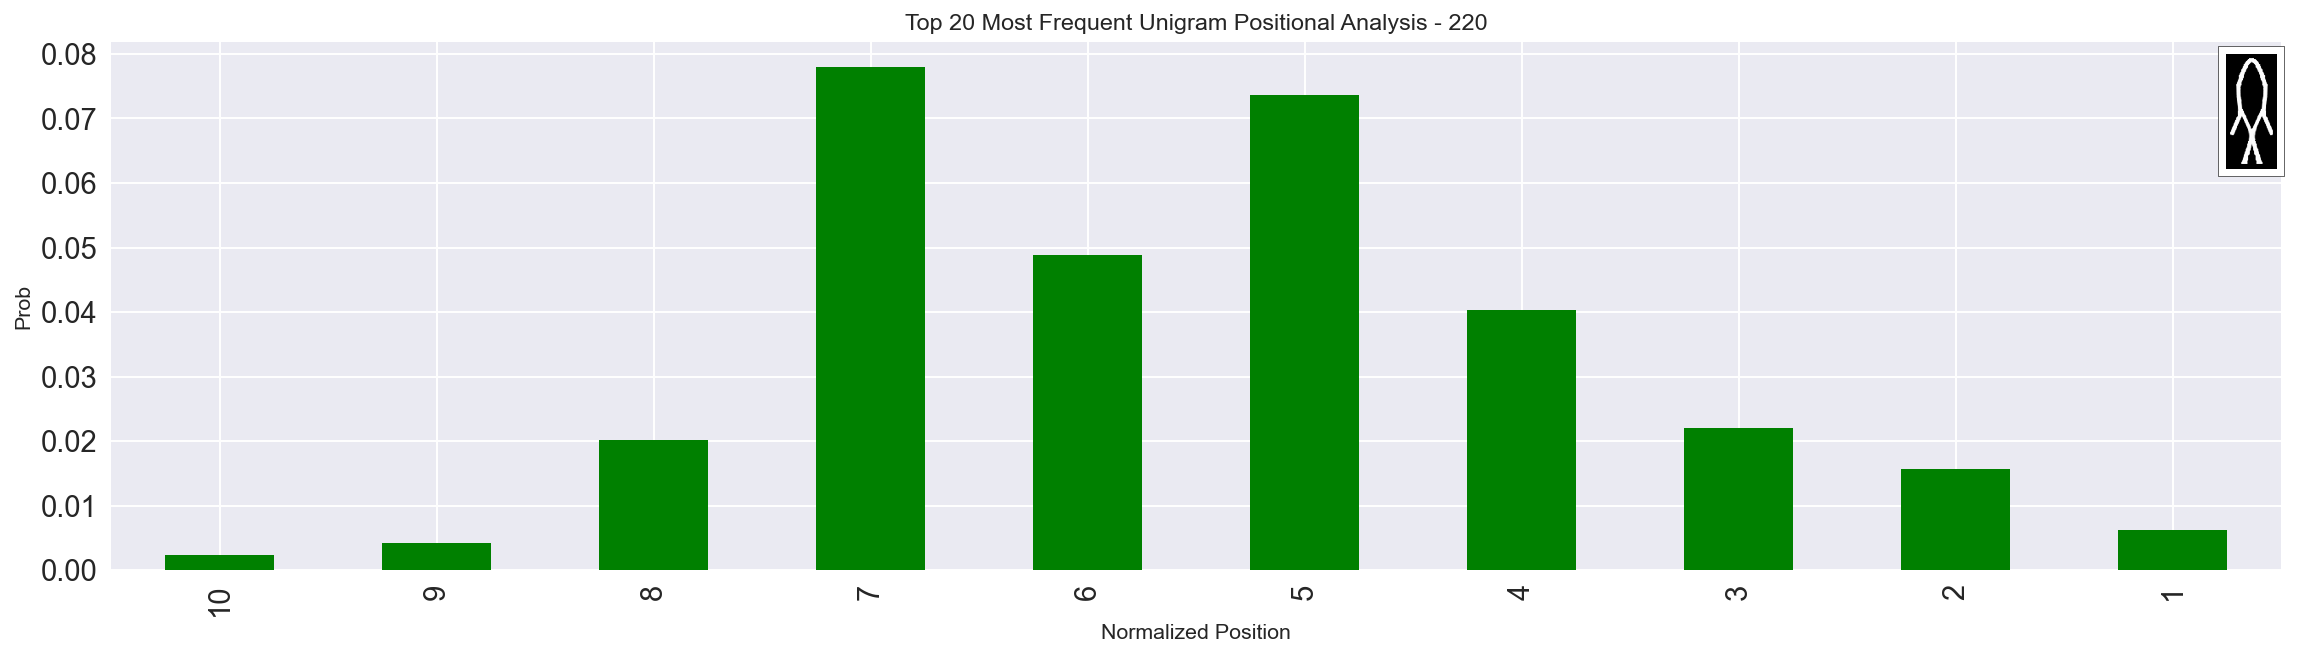

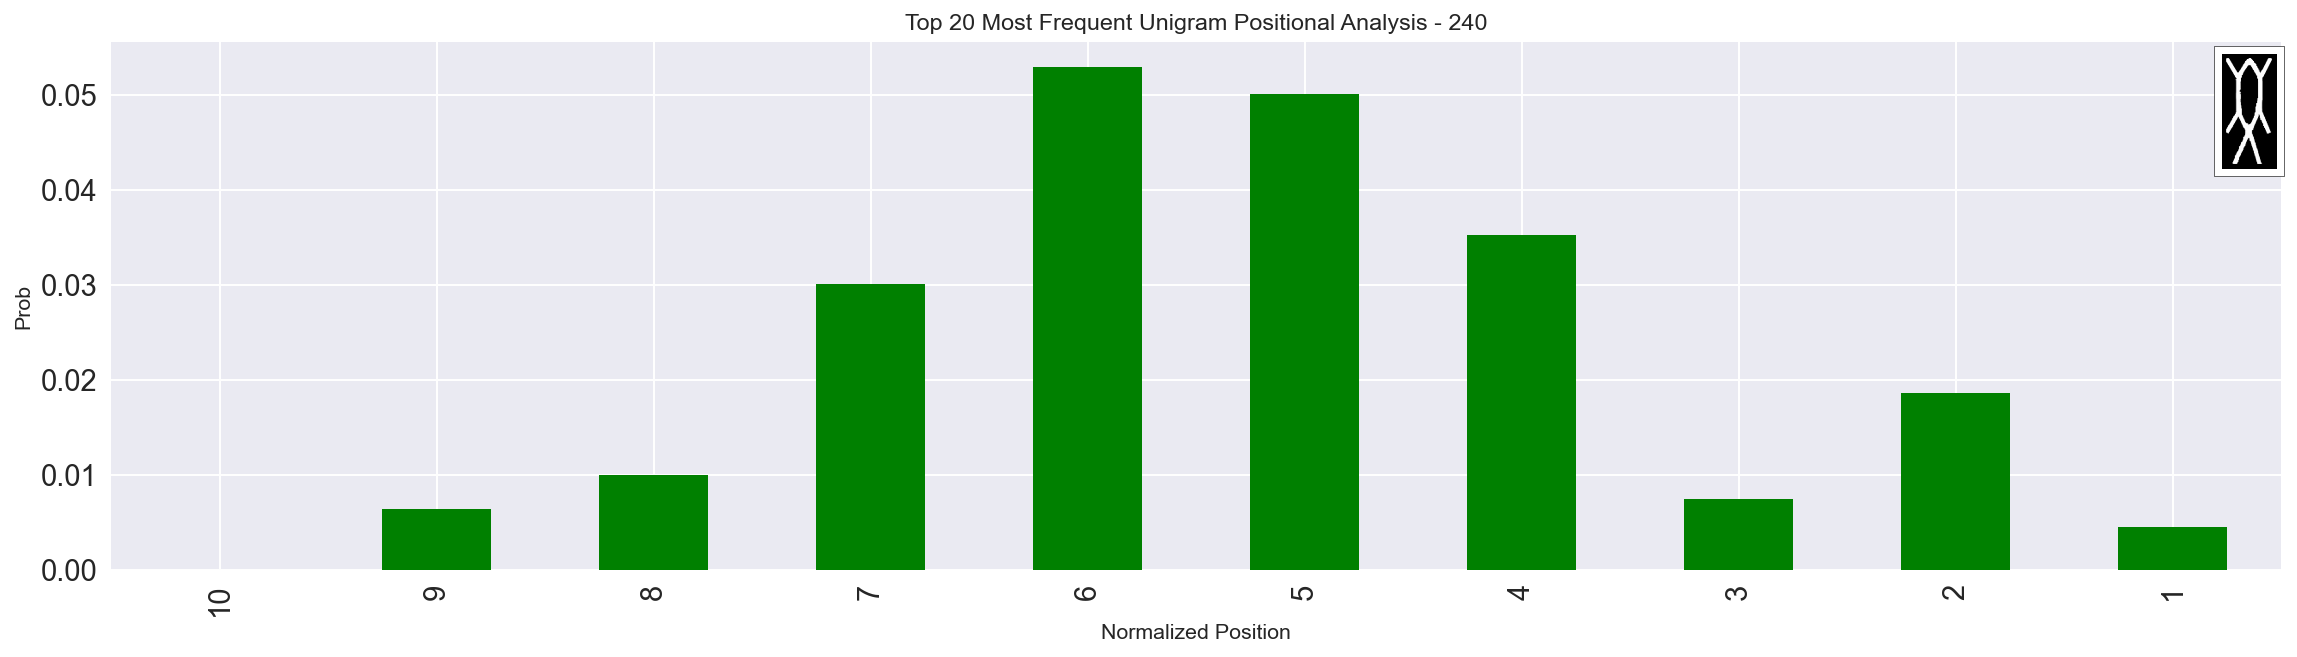

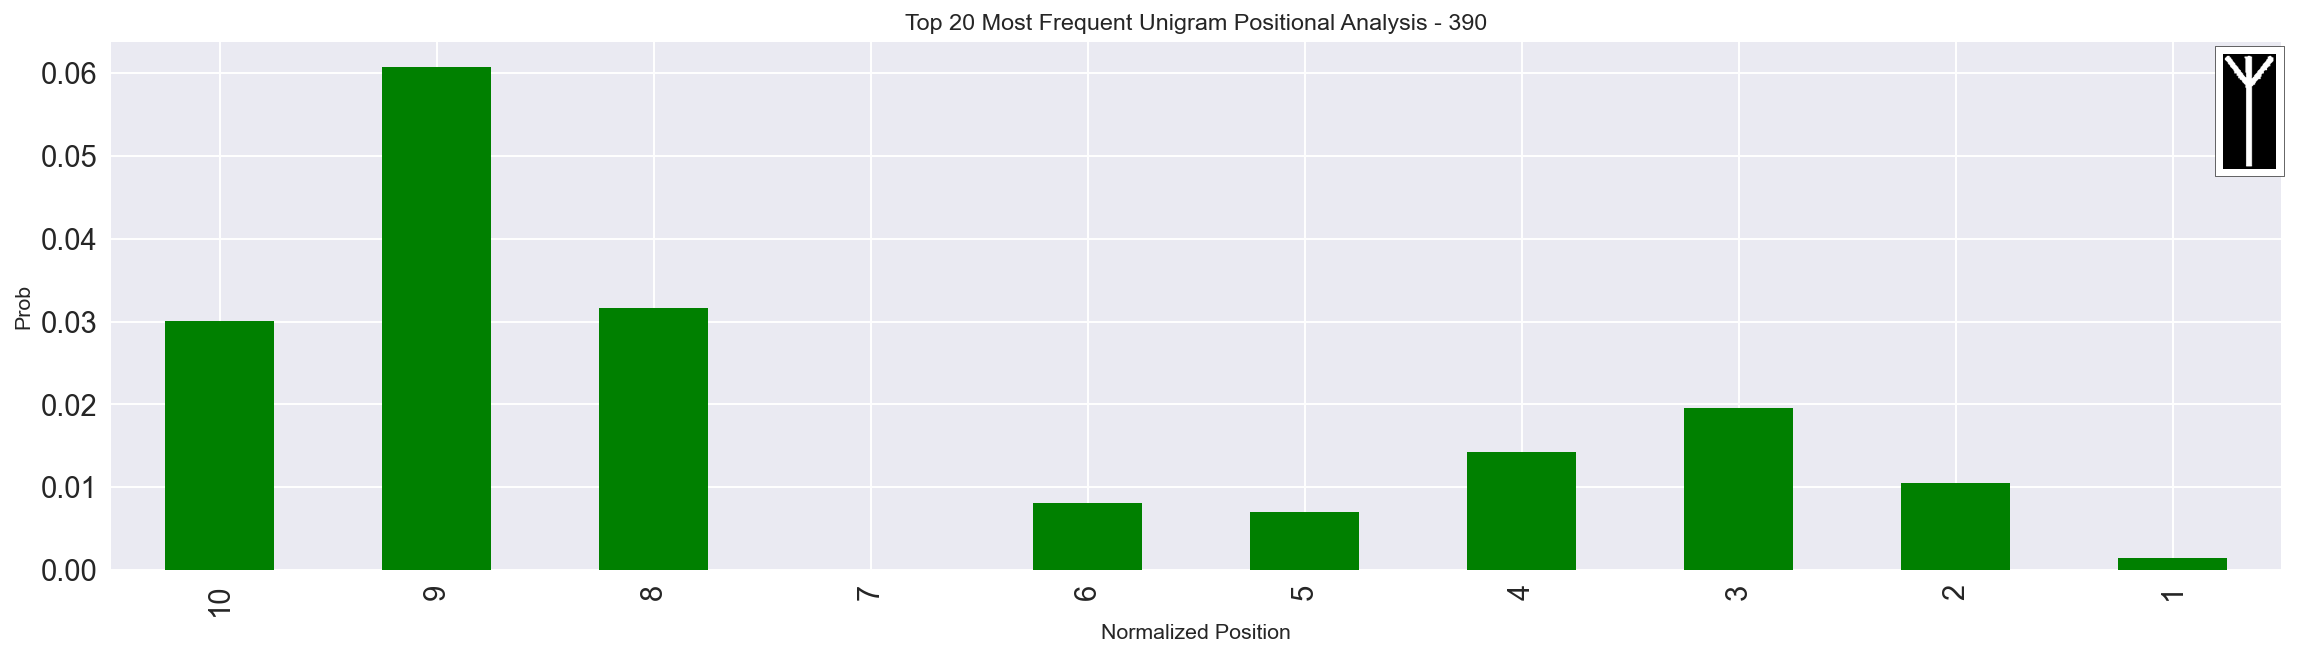

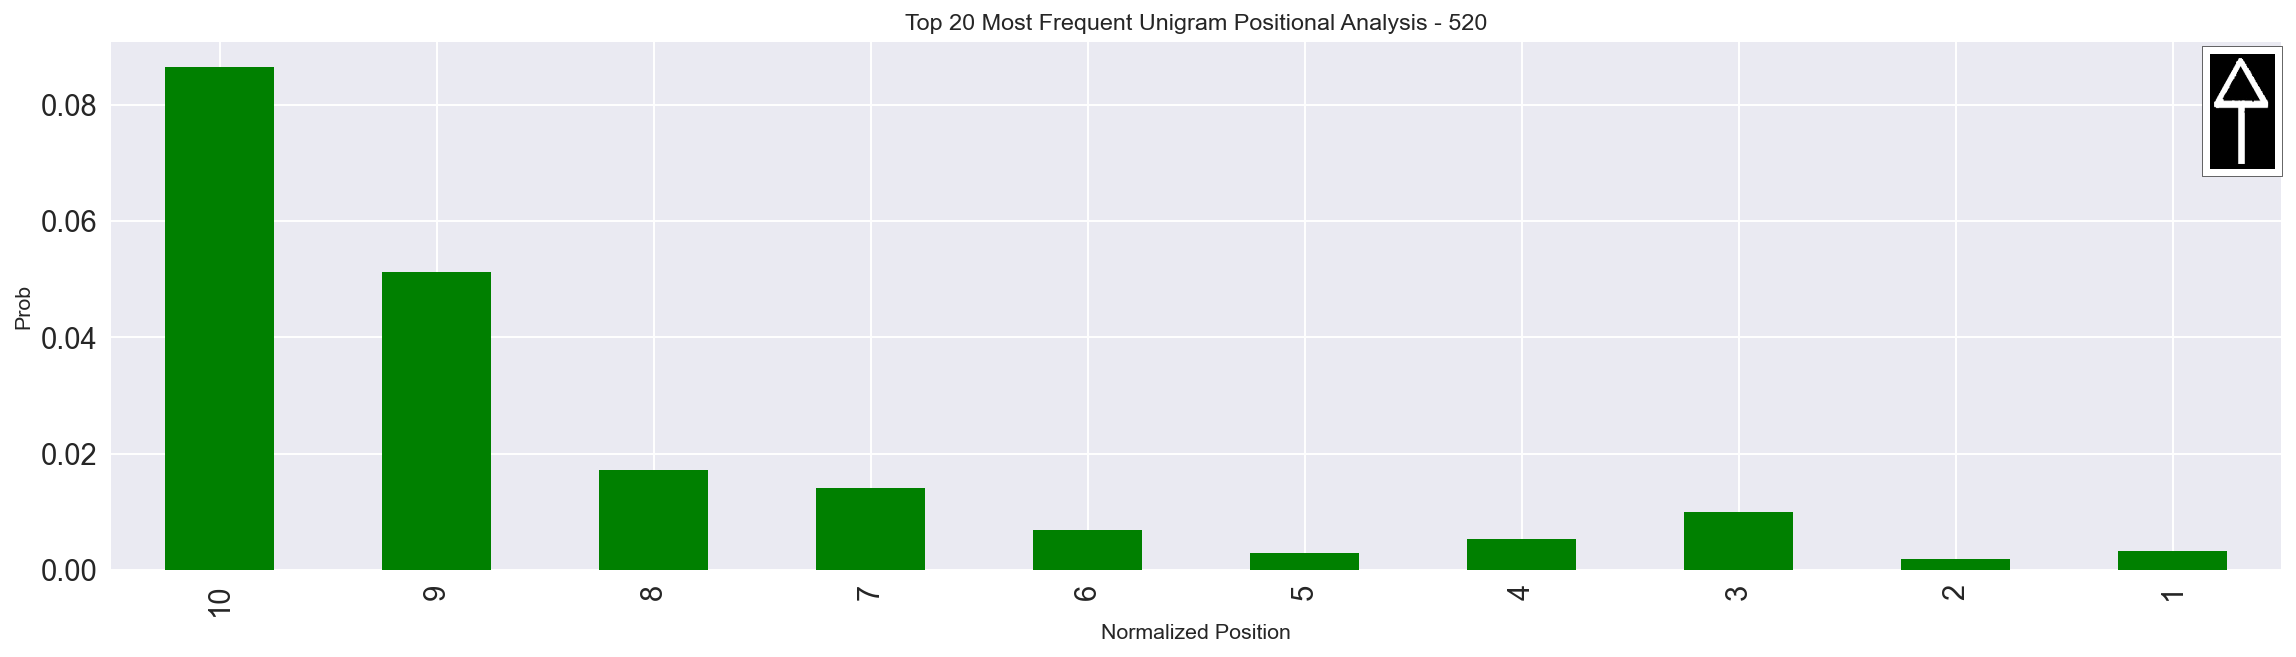

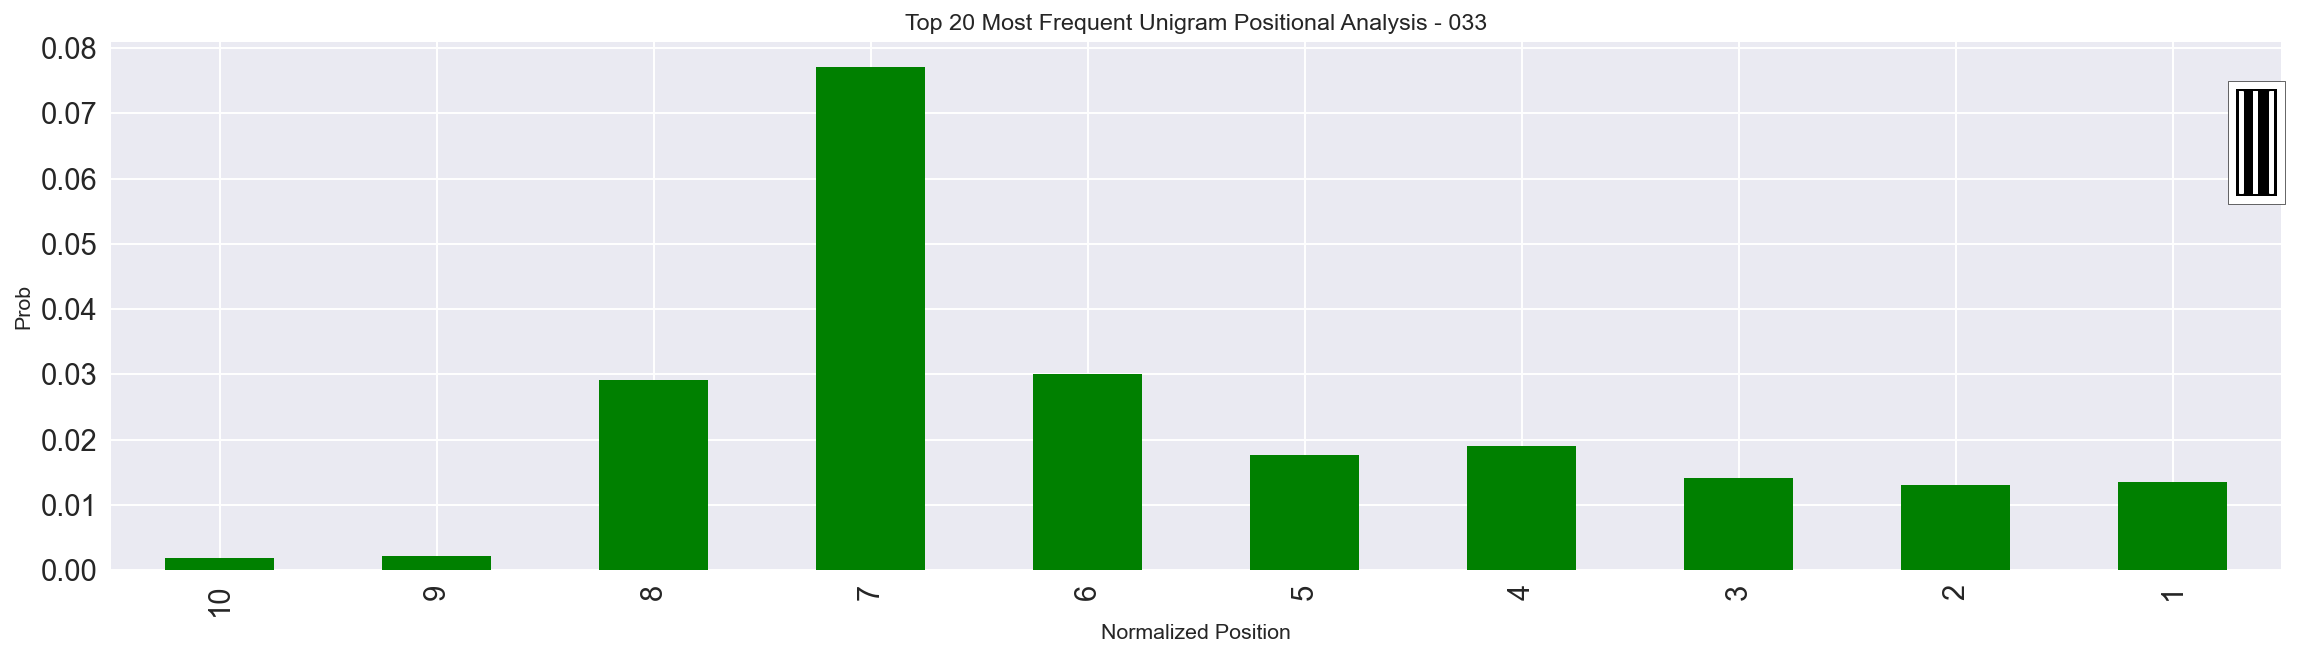

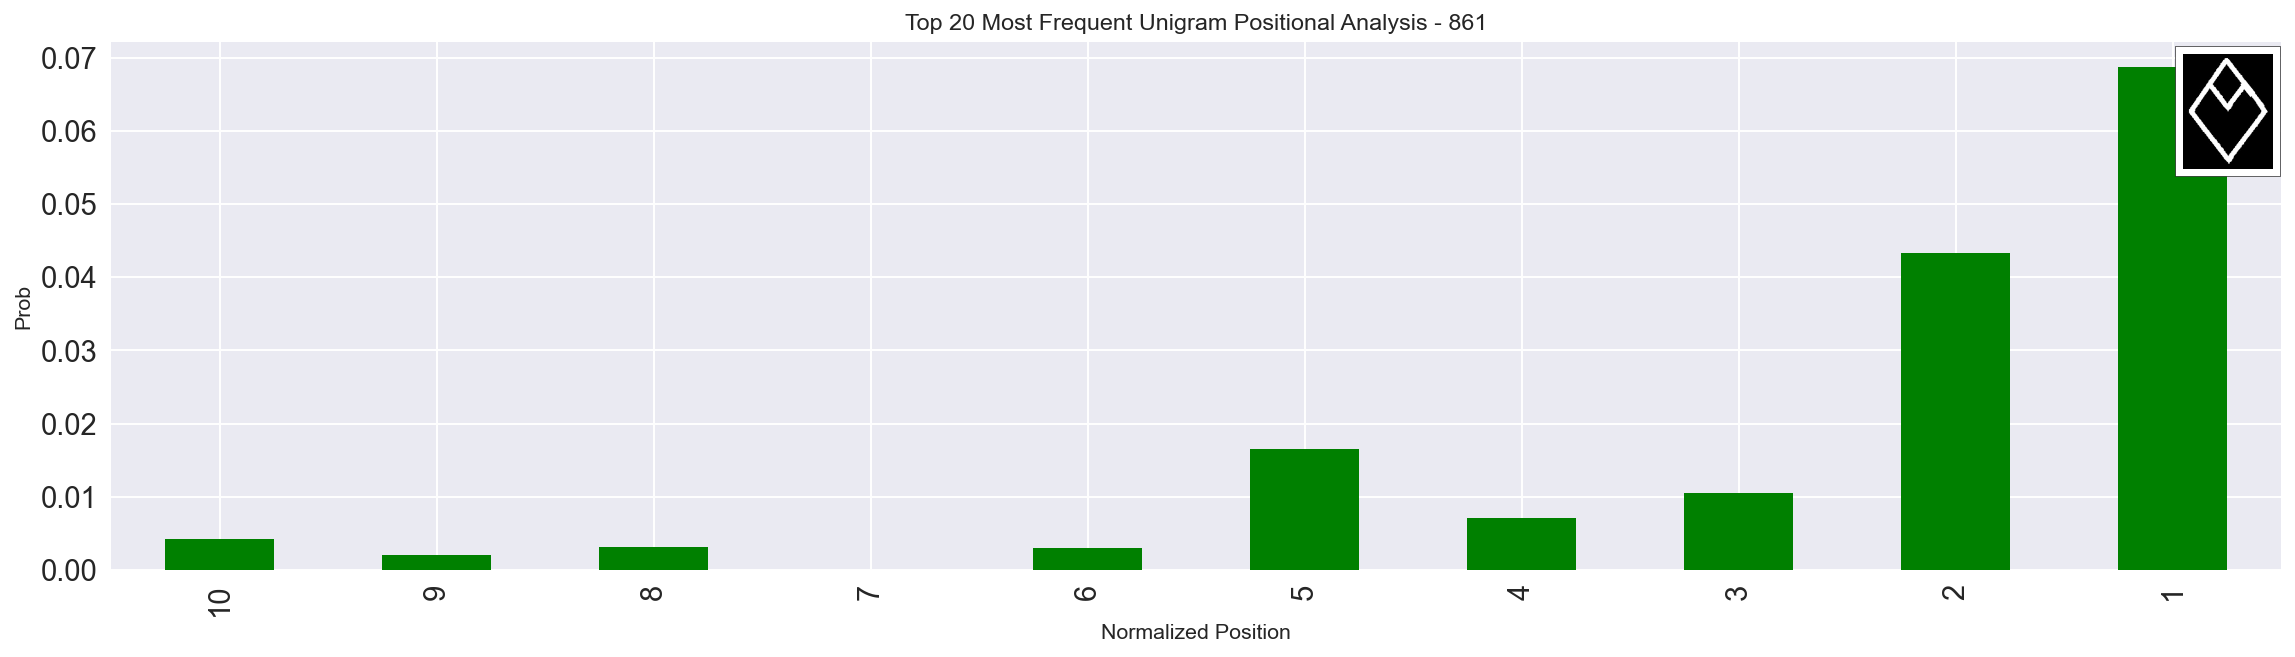

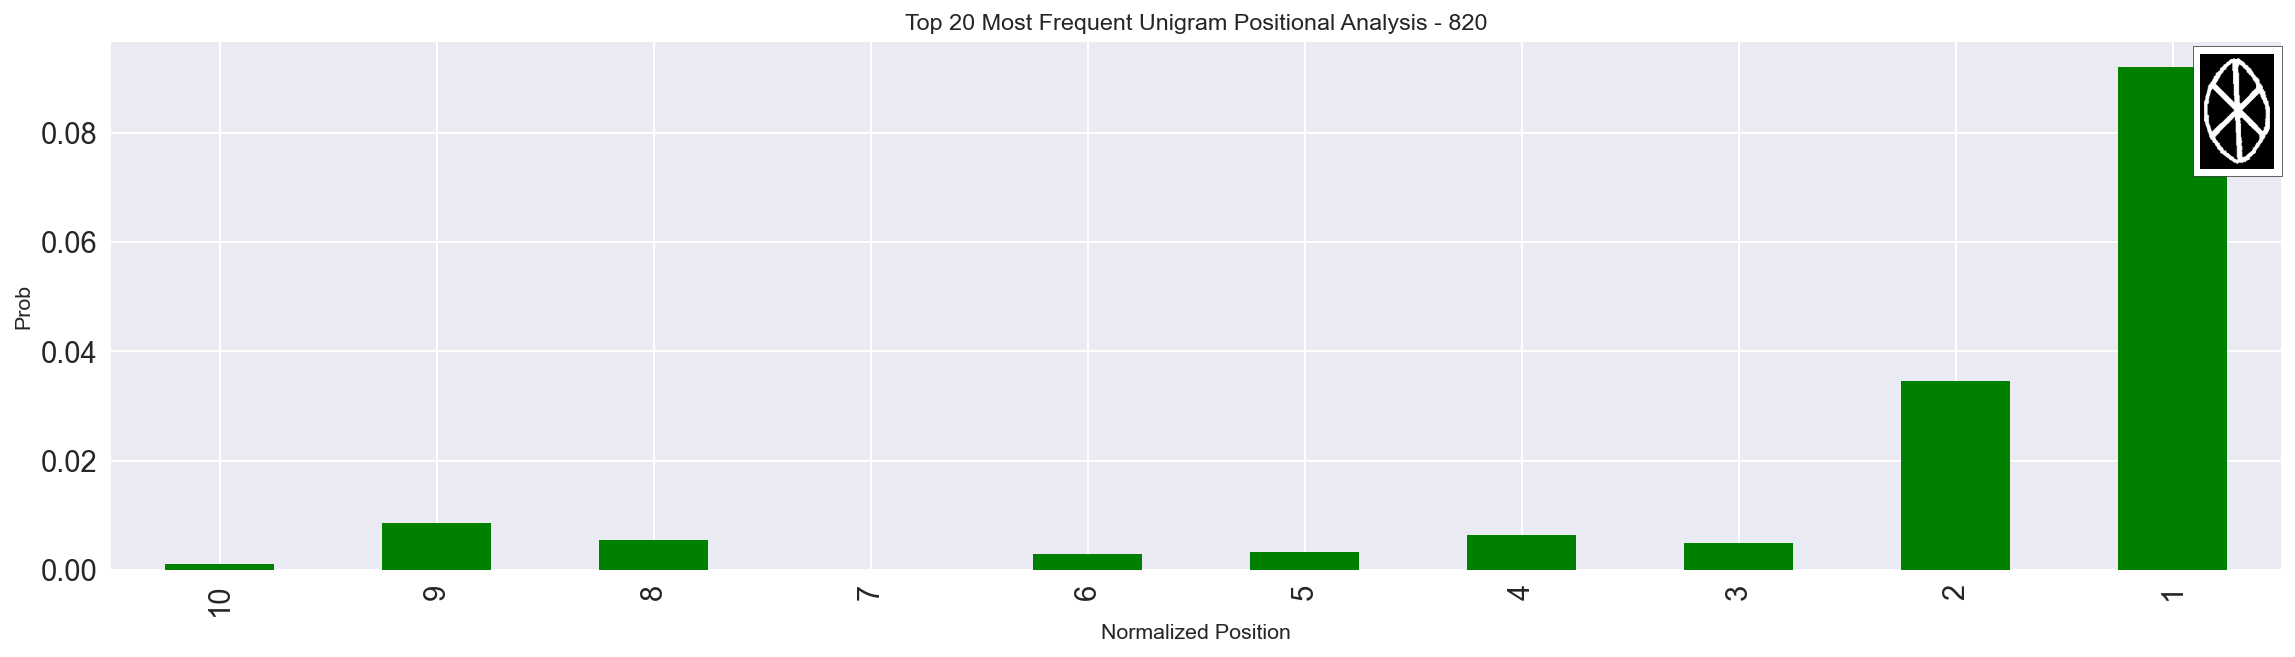

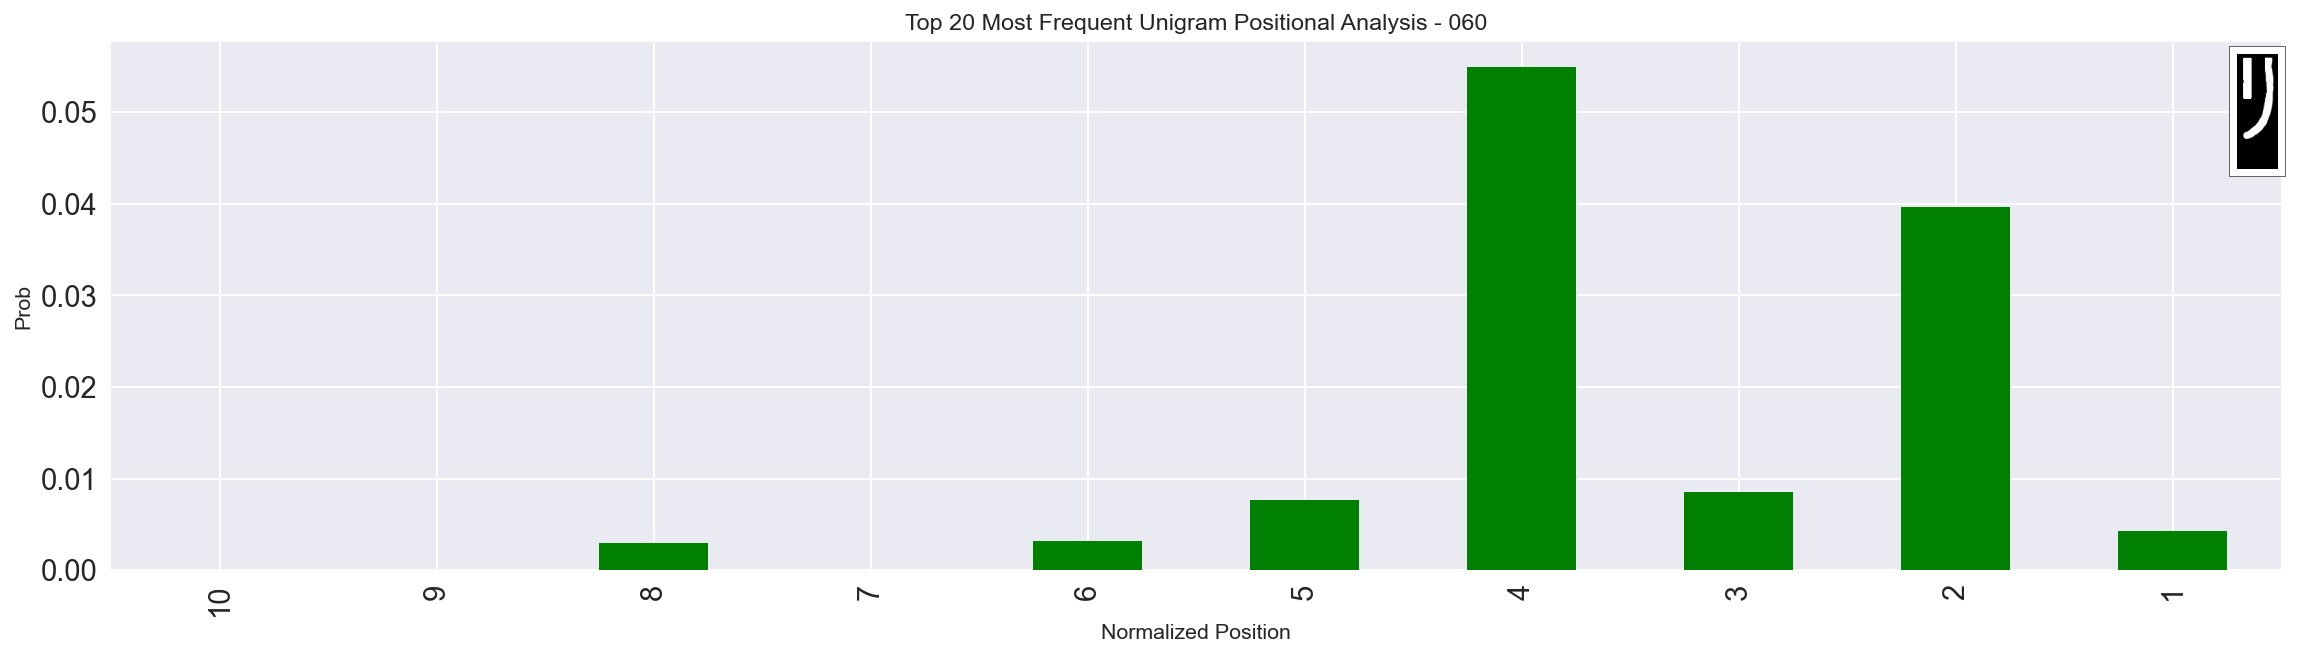

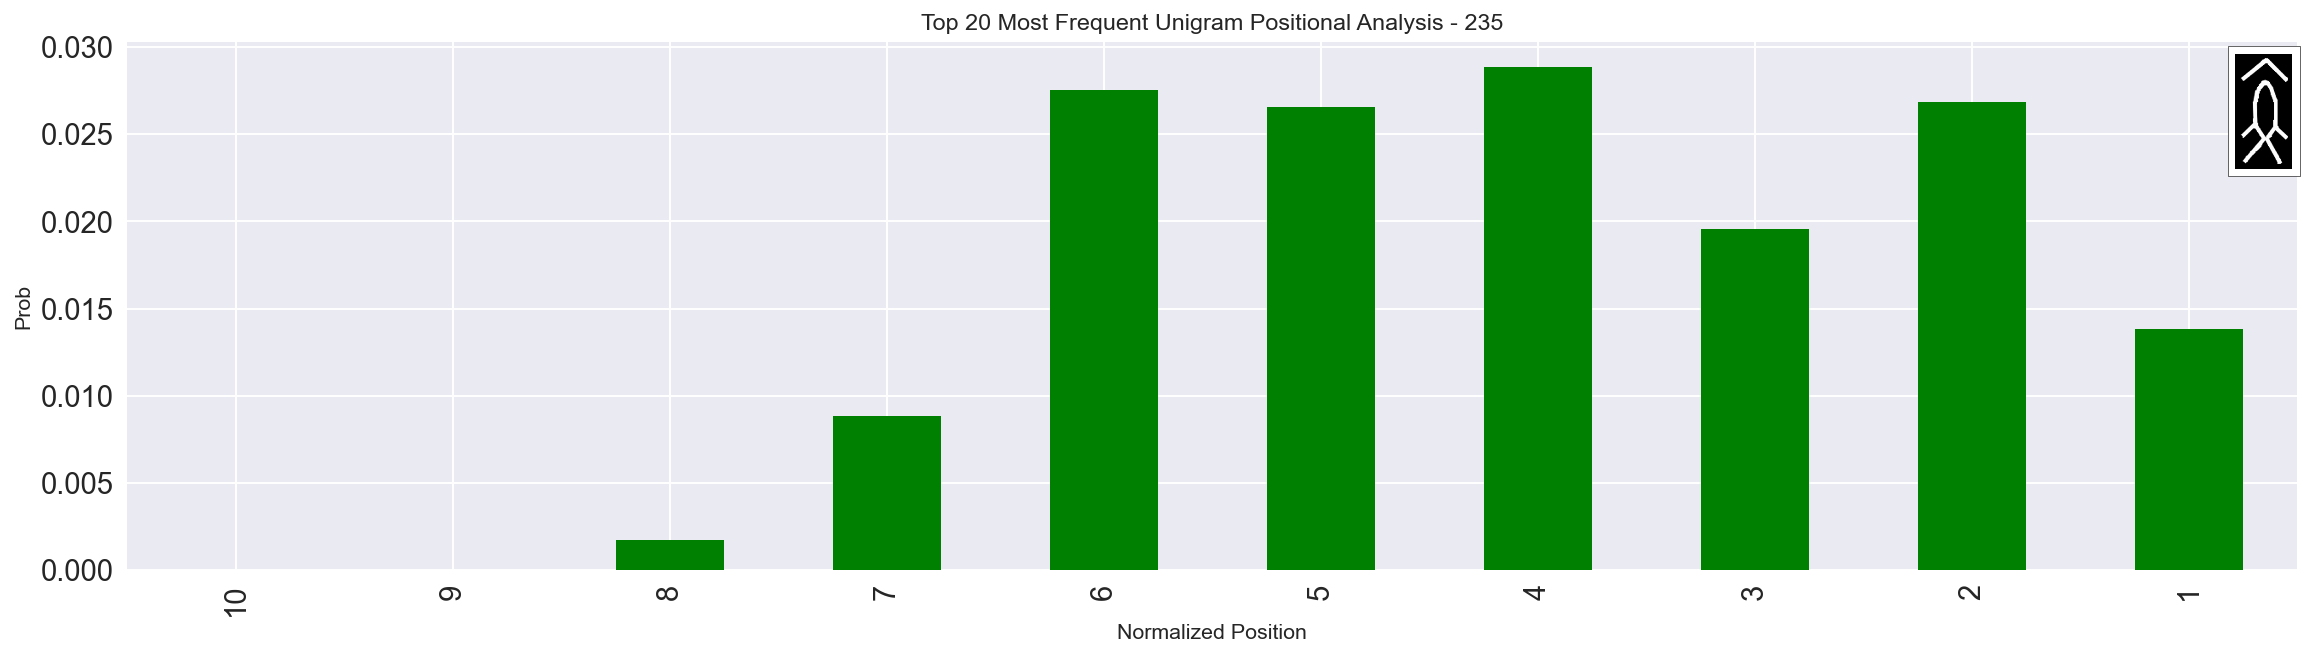

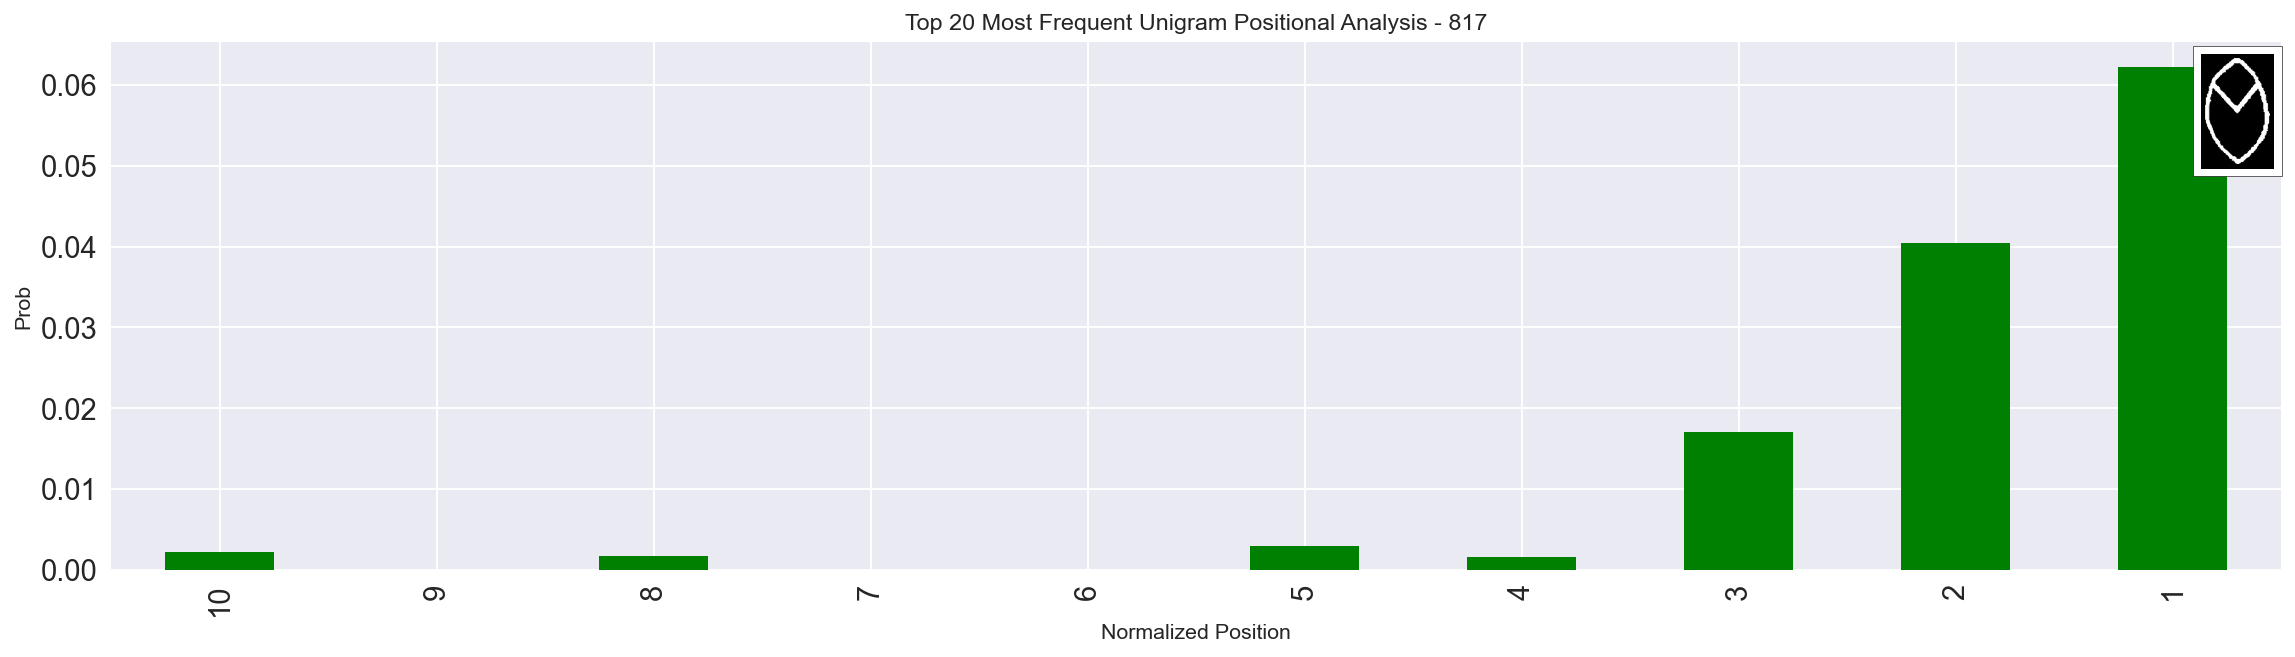

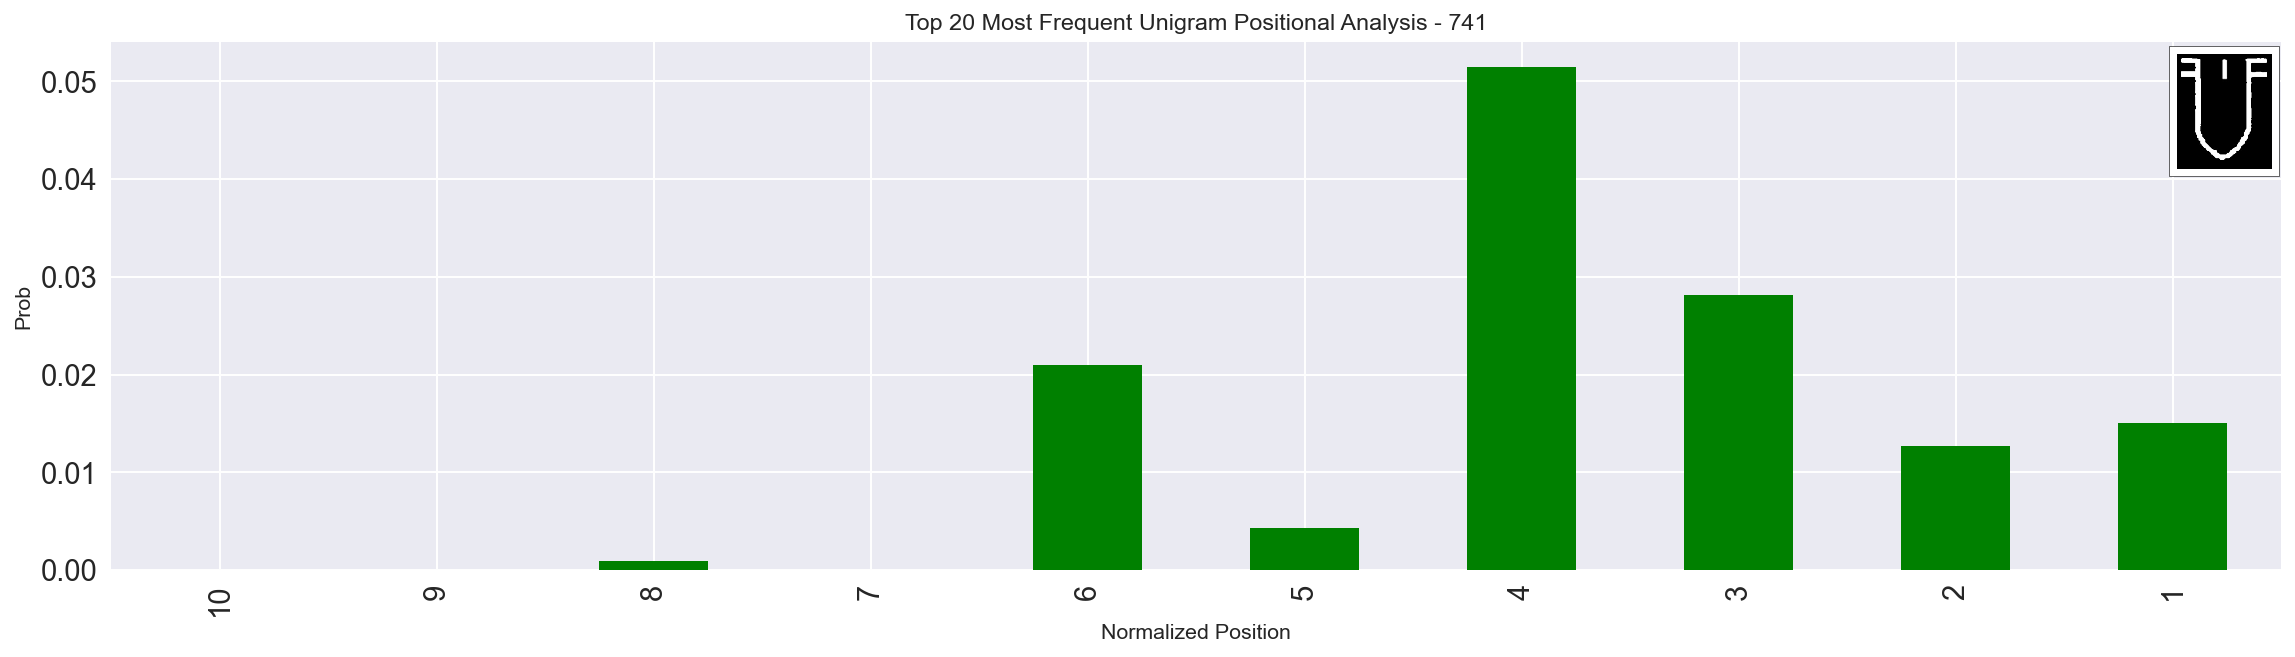

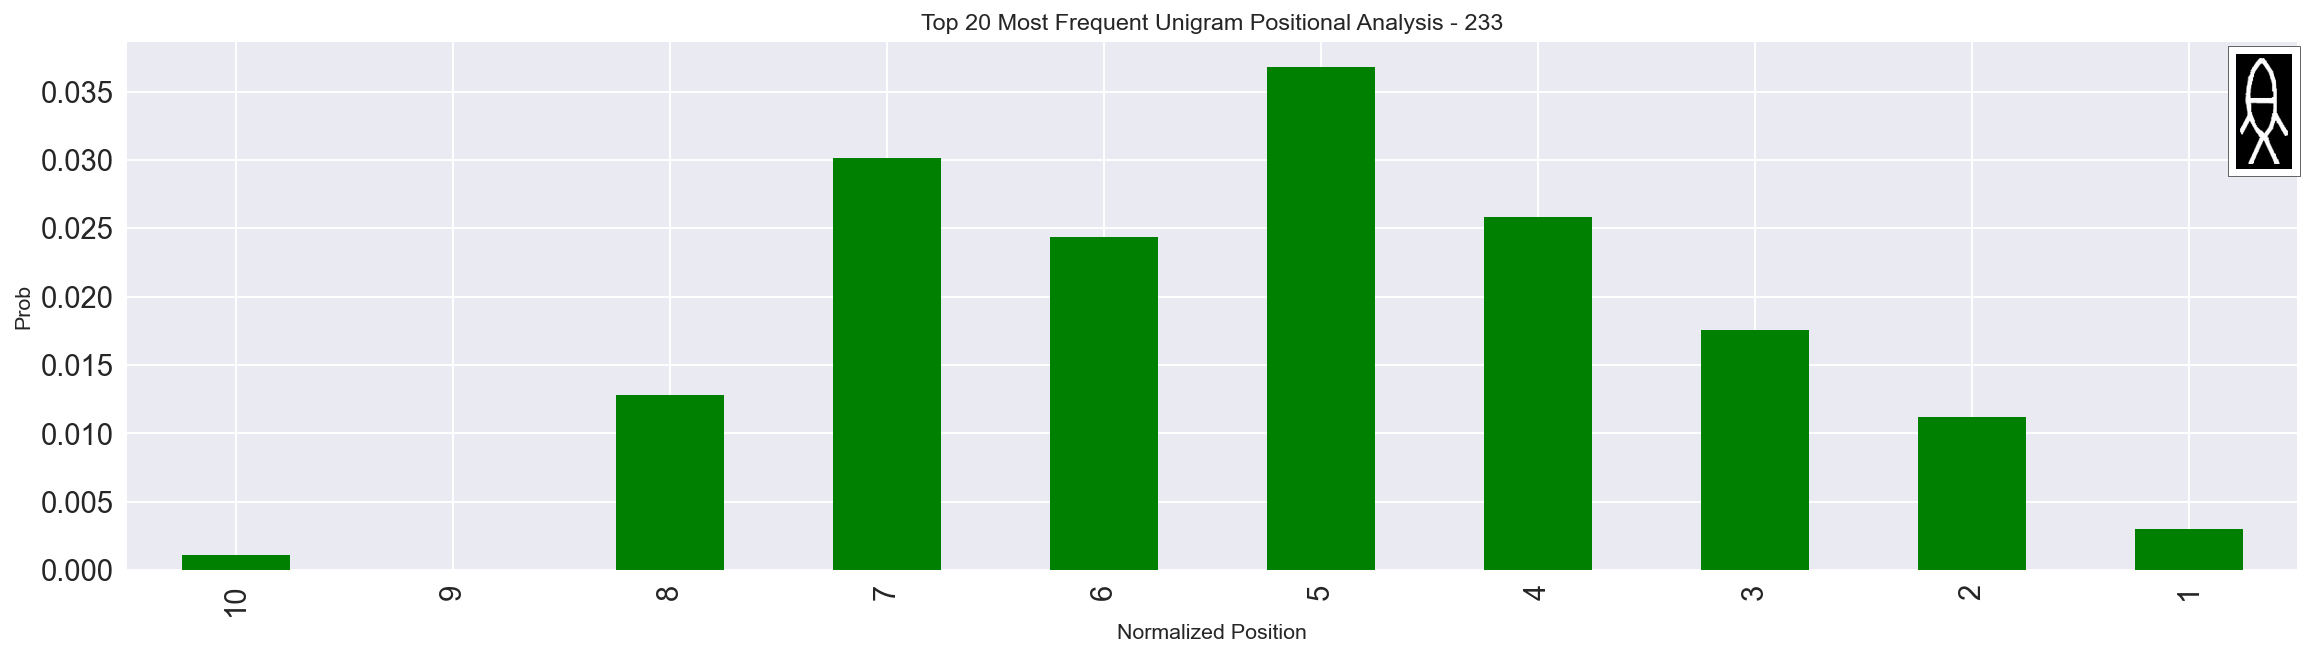

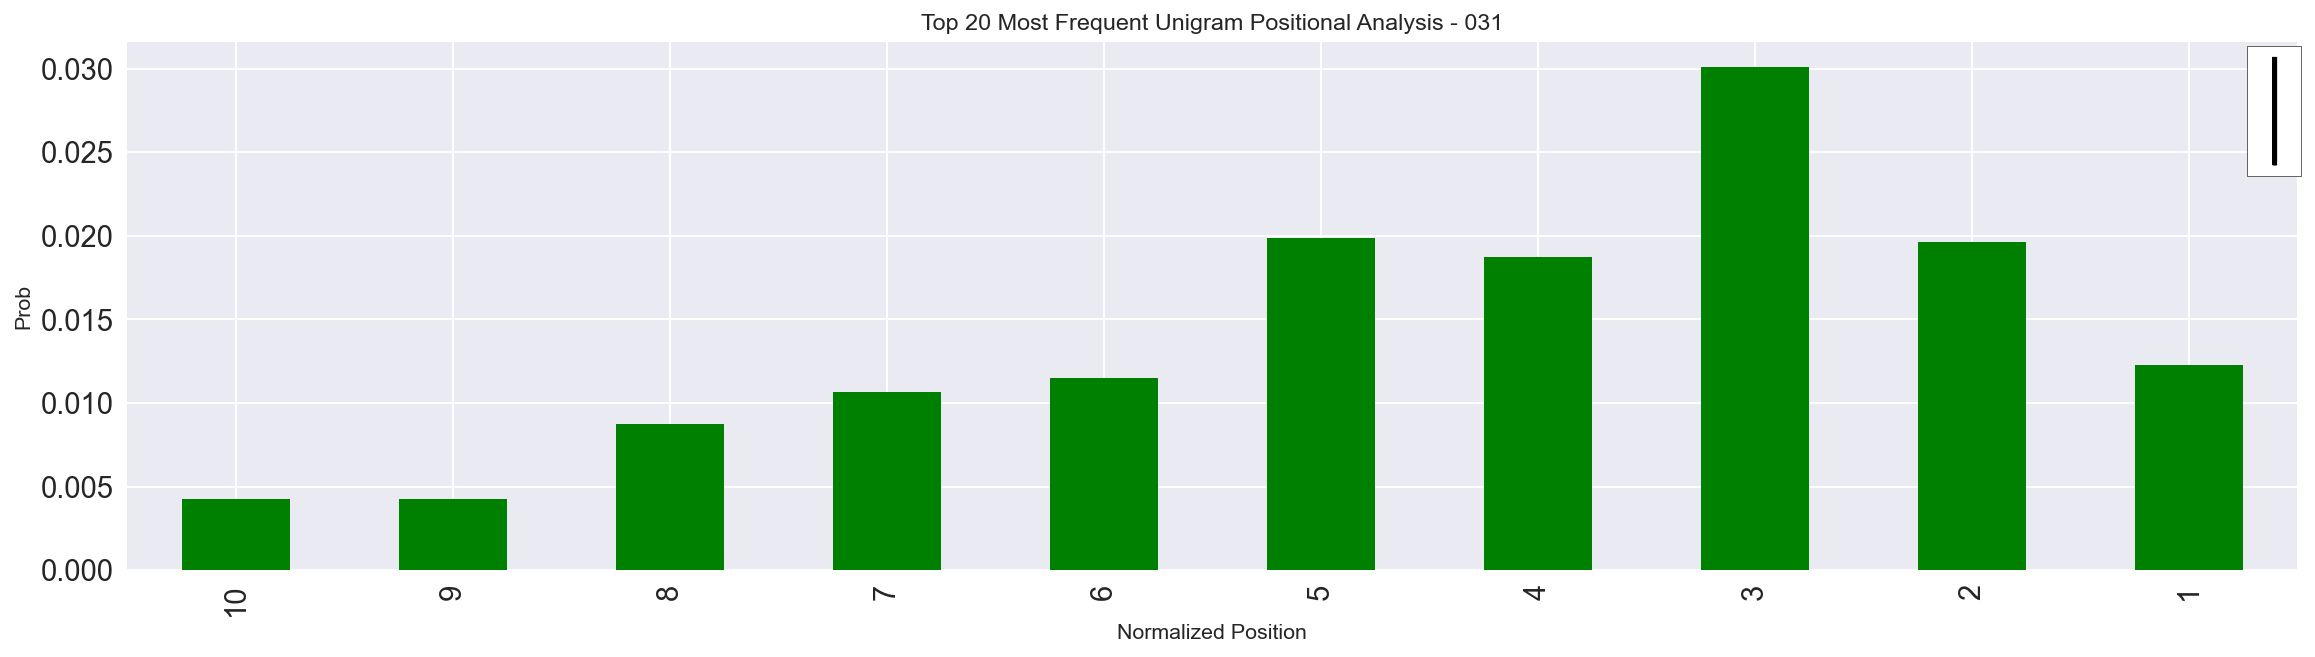

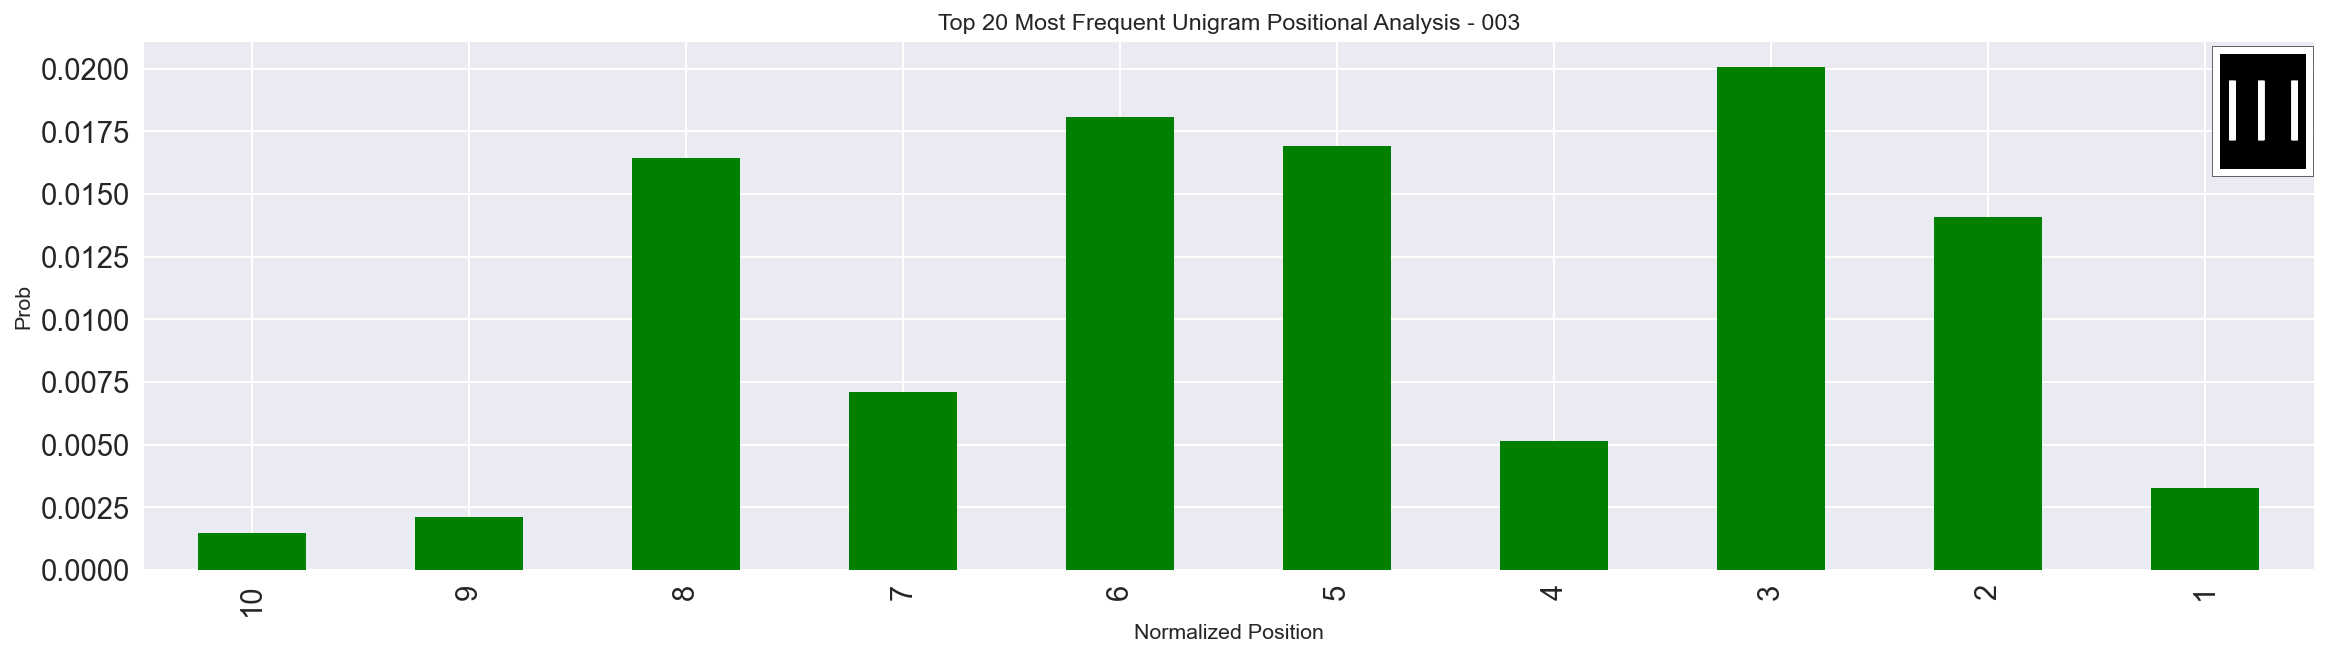

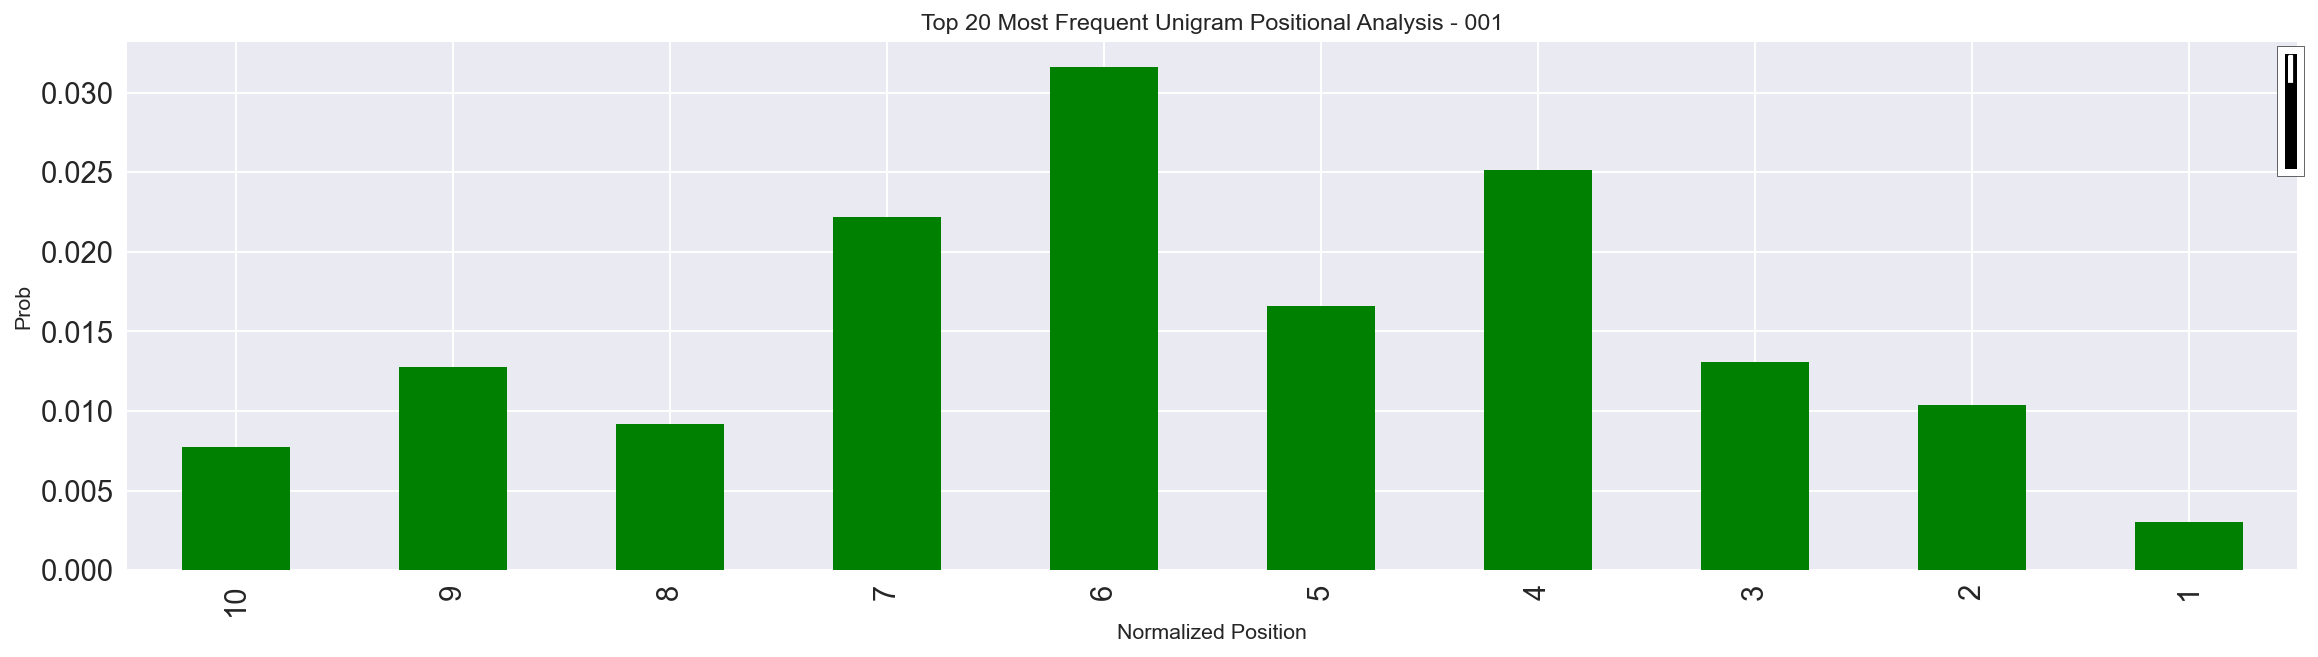

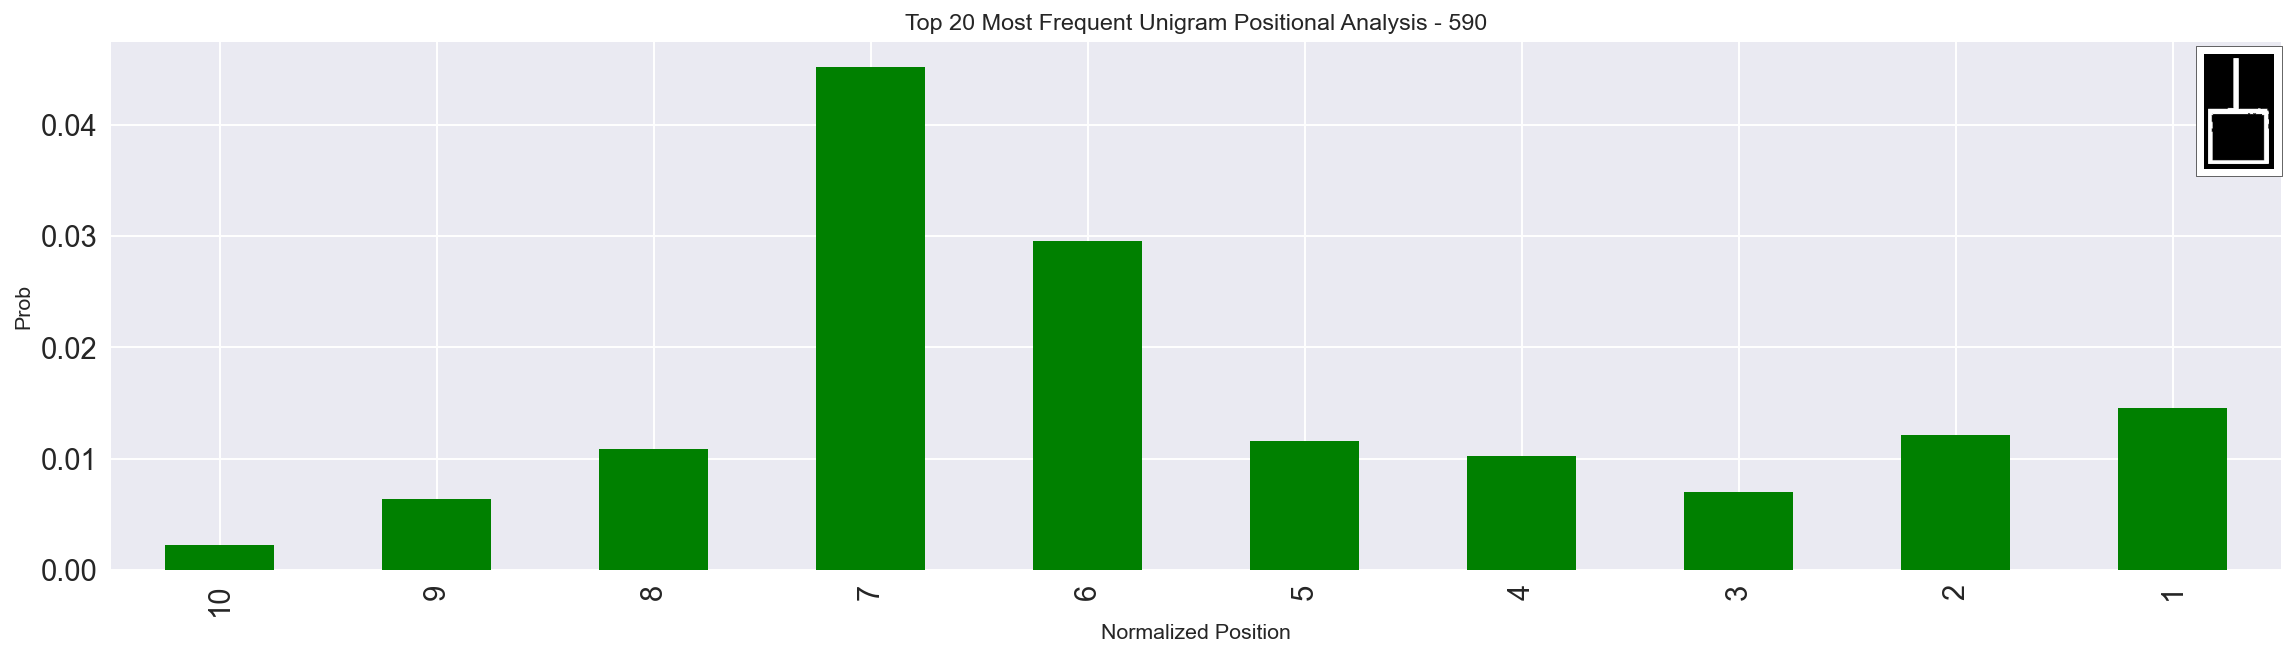

In [101]:
for unigram in pd_text_unigrams1:

    df_text_norm_position_unigrams_prob[unigram].plot(kind='bar', color='green')

    #Image(url=get_char_path(unigram), width=20, height=20)
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.rc('xtick',labelsize=15)
    plt.rc('ytick',labelsize=15)

    img = get_char_image(unigram)
    im = OffsetImage(img, zoom=.2)
    ab = AnnotationBbox(im, (1, 0), xycoords='axes fraction', box_alignment=(1.1,-3.5))

    ax = plt.subplot(111)
    ax.add_artist(ab)
    plt.title("Top 20 Most Frequent Unigram Positional Analysis - " + unigram)

    plt.show()



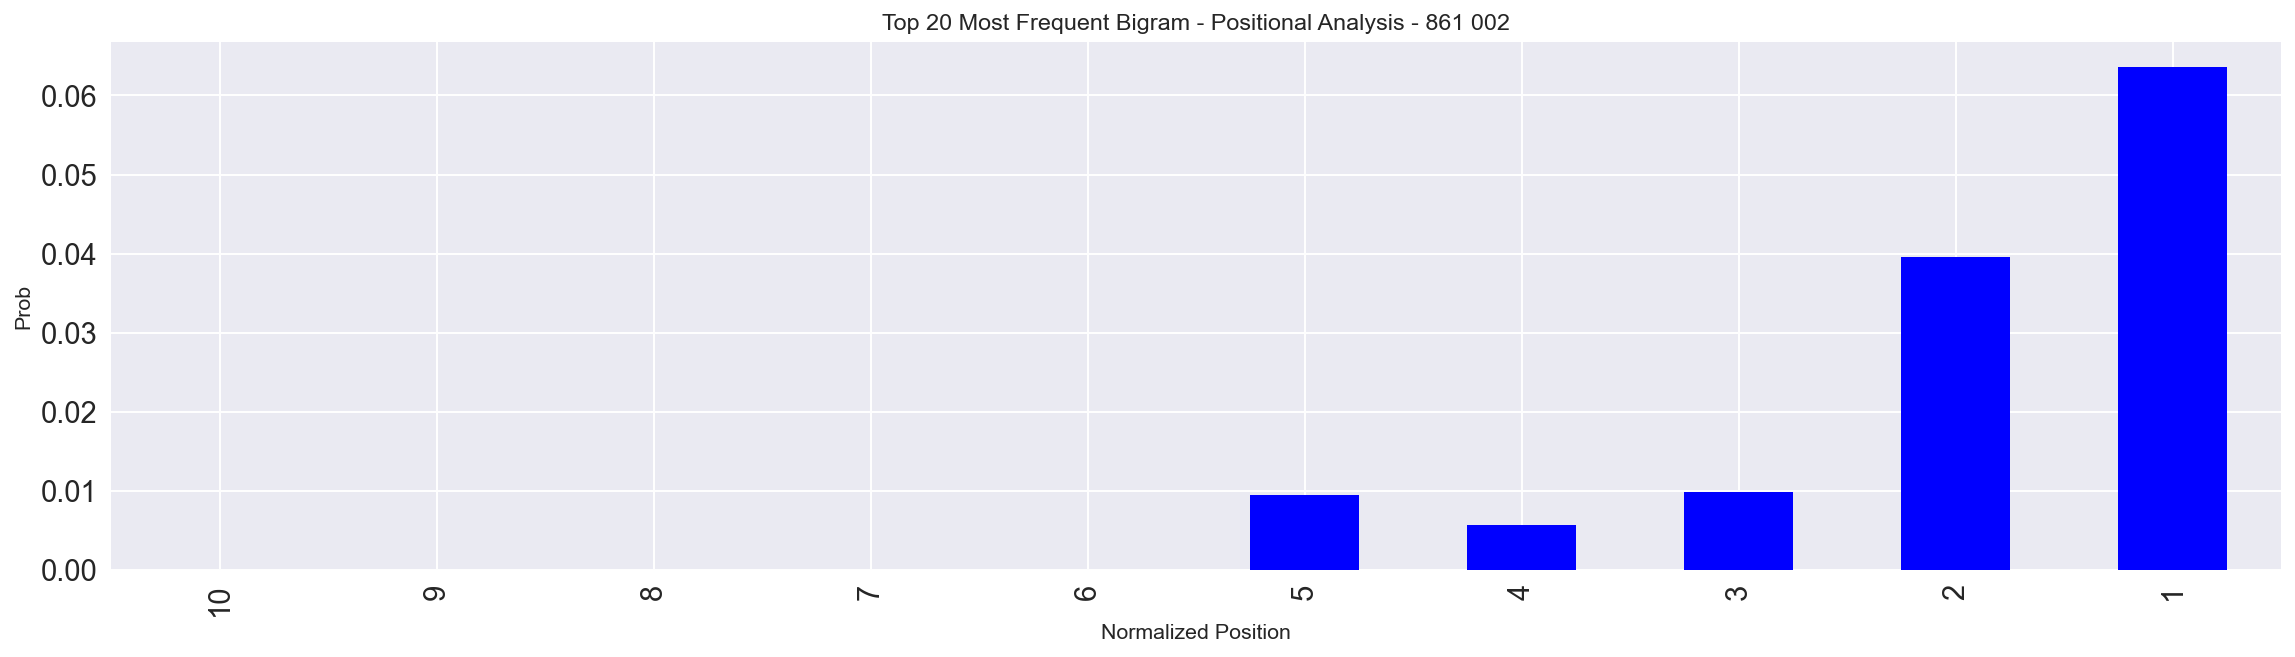

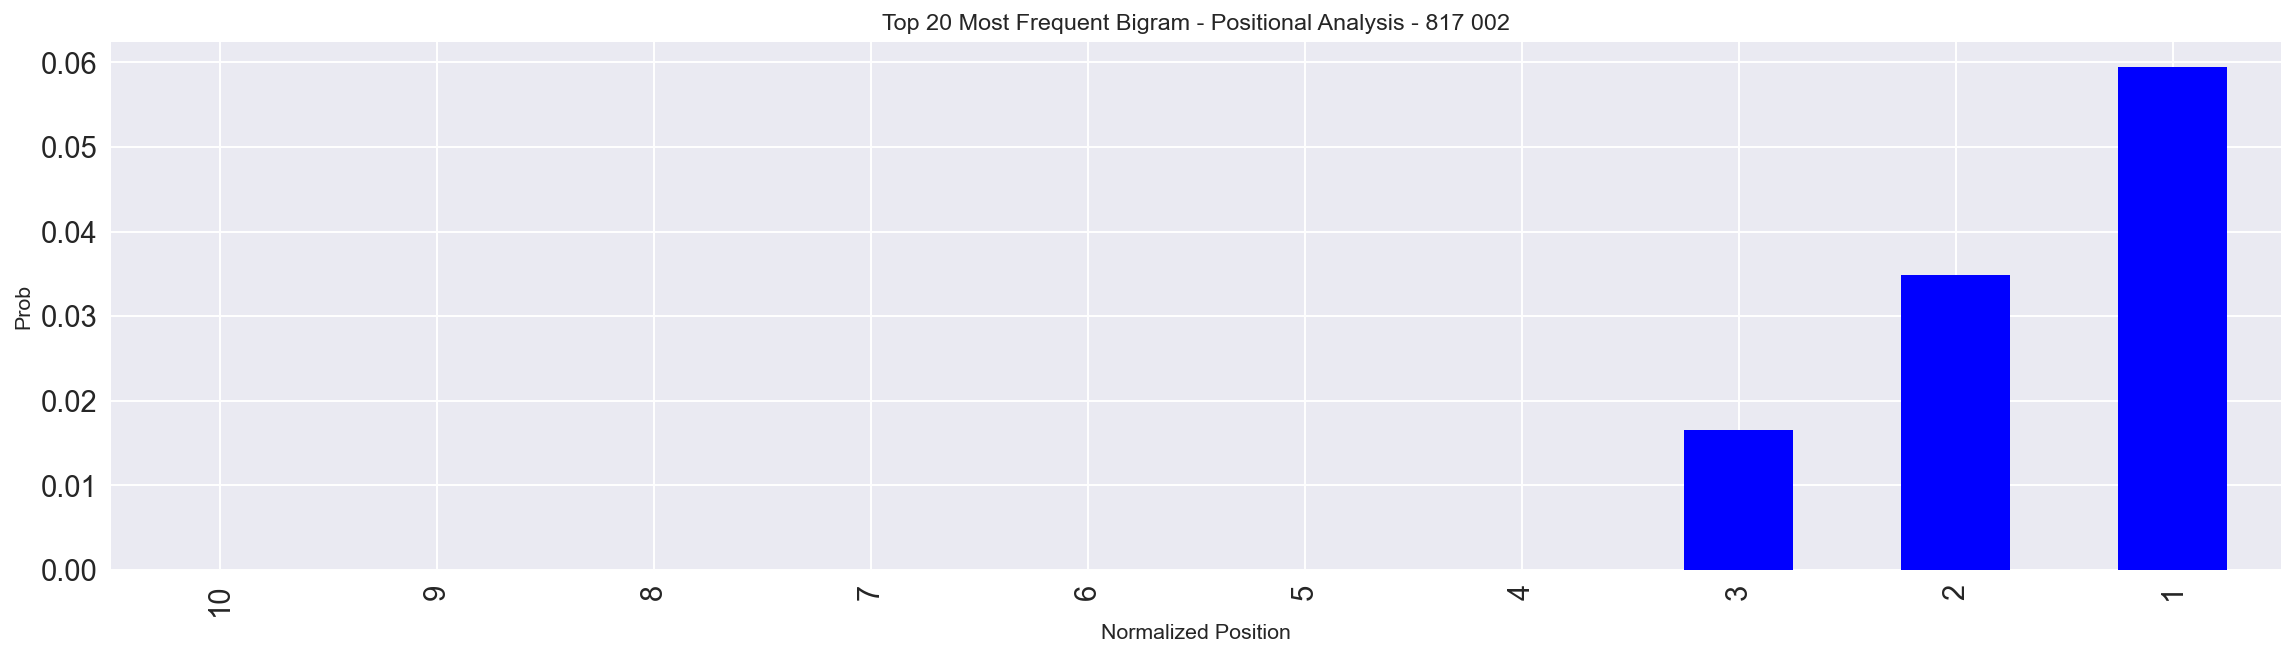

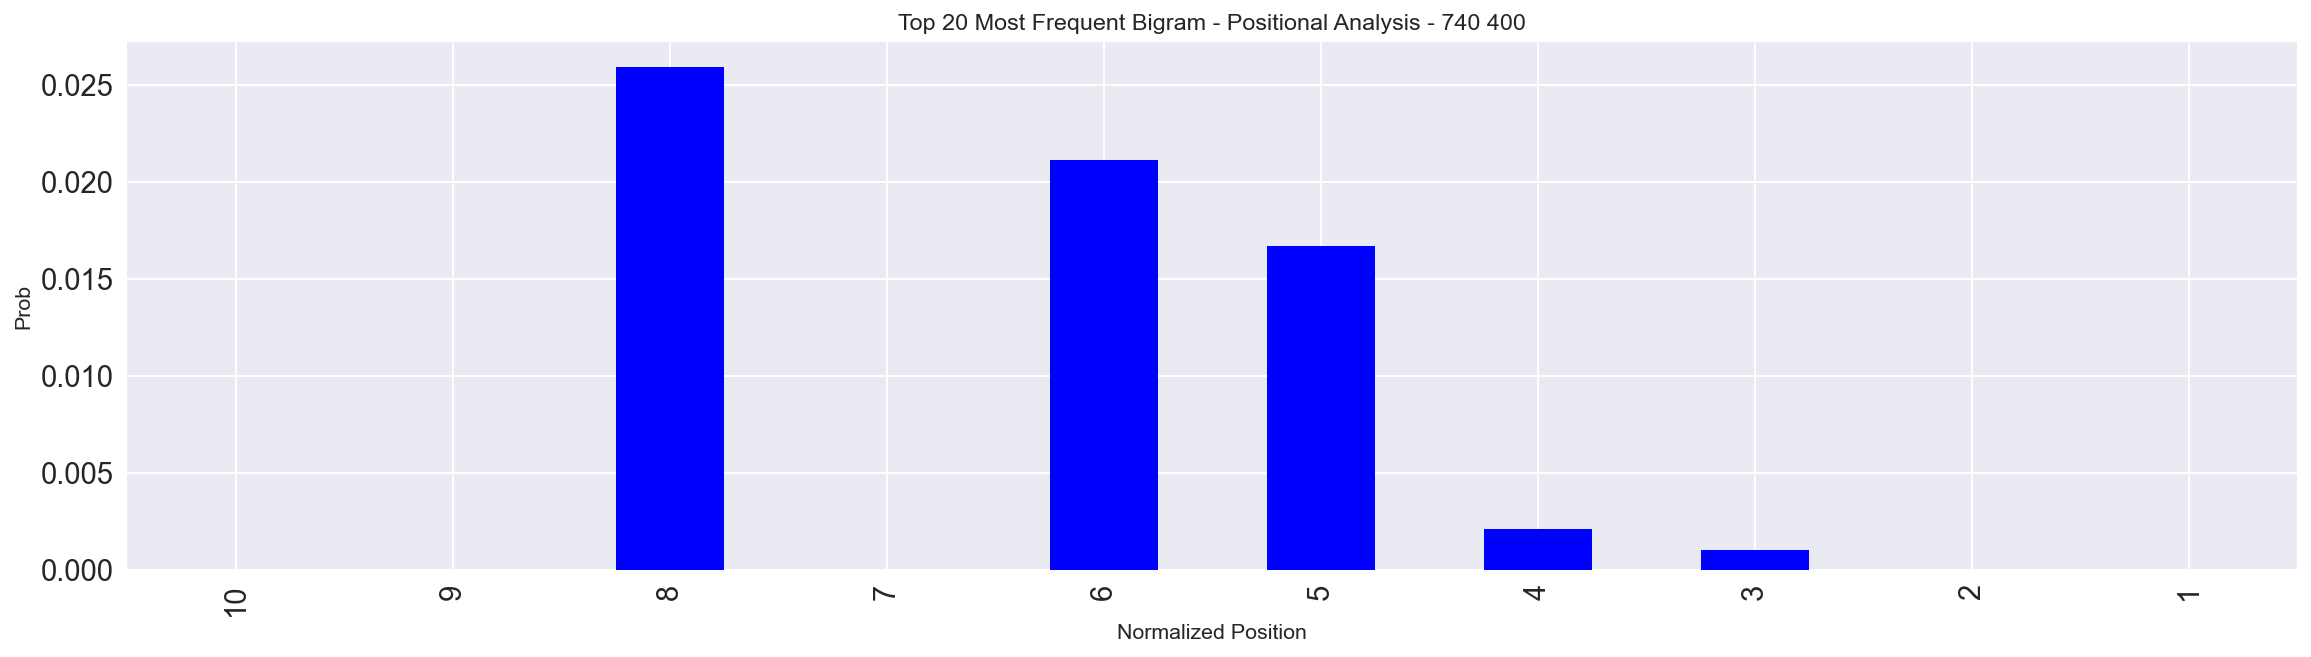

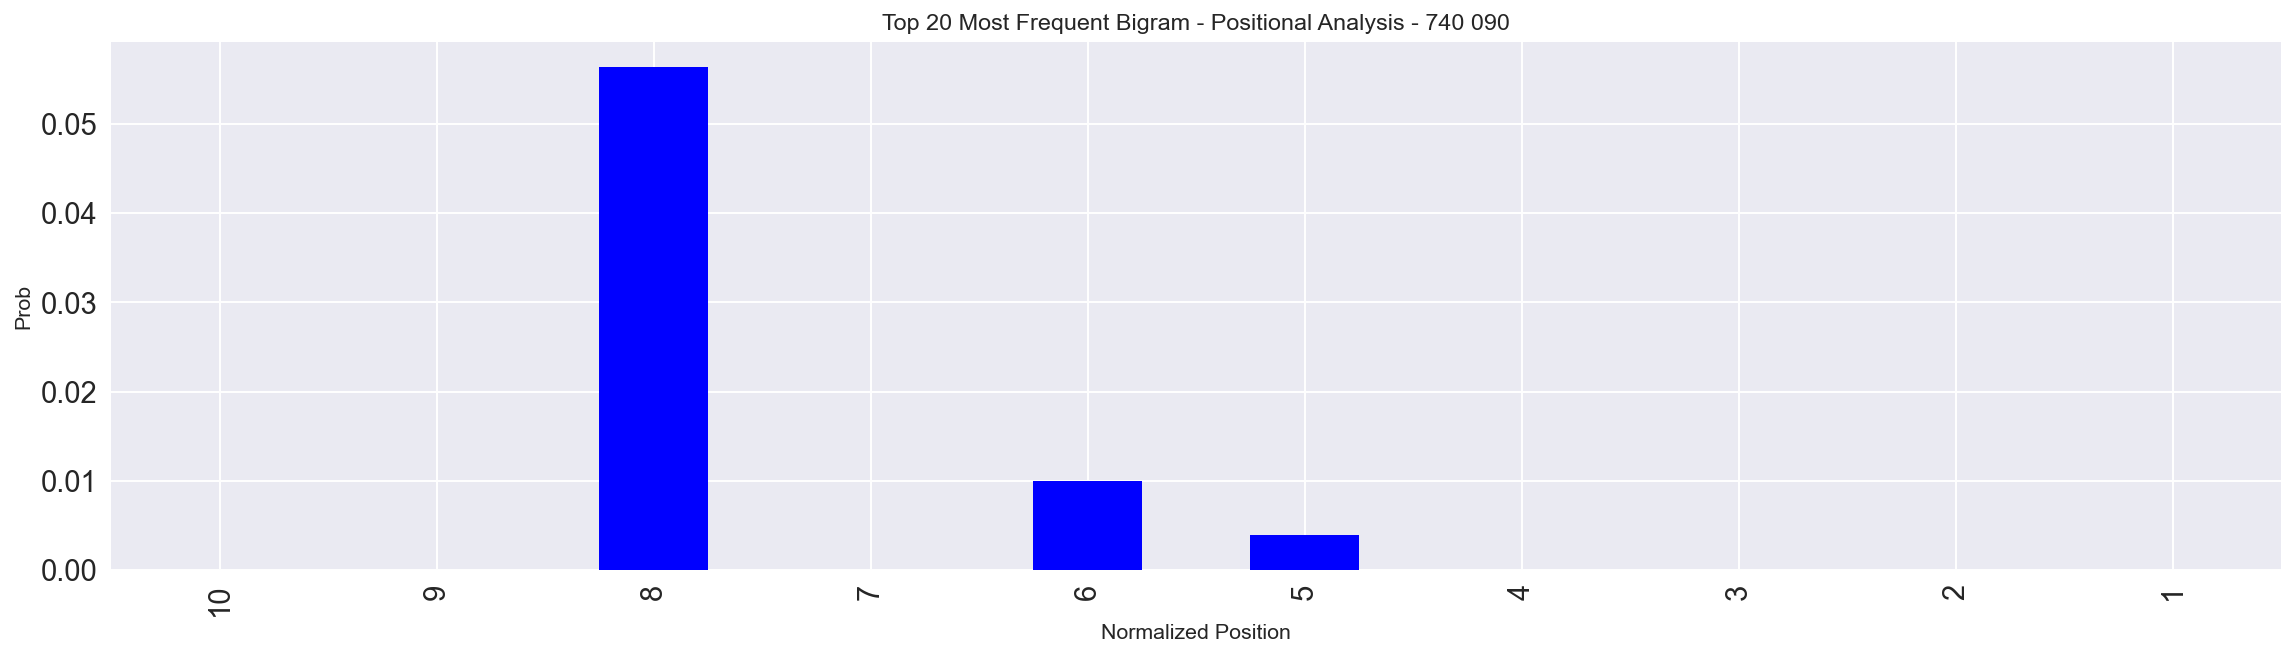

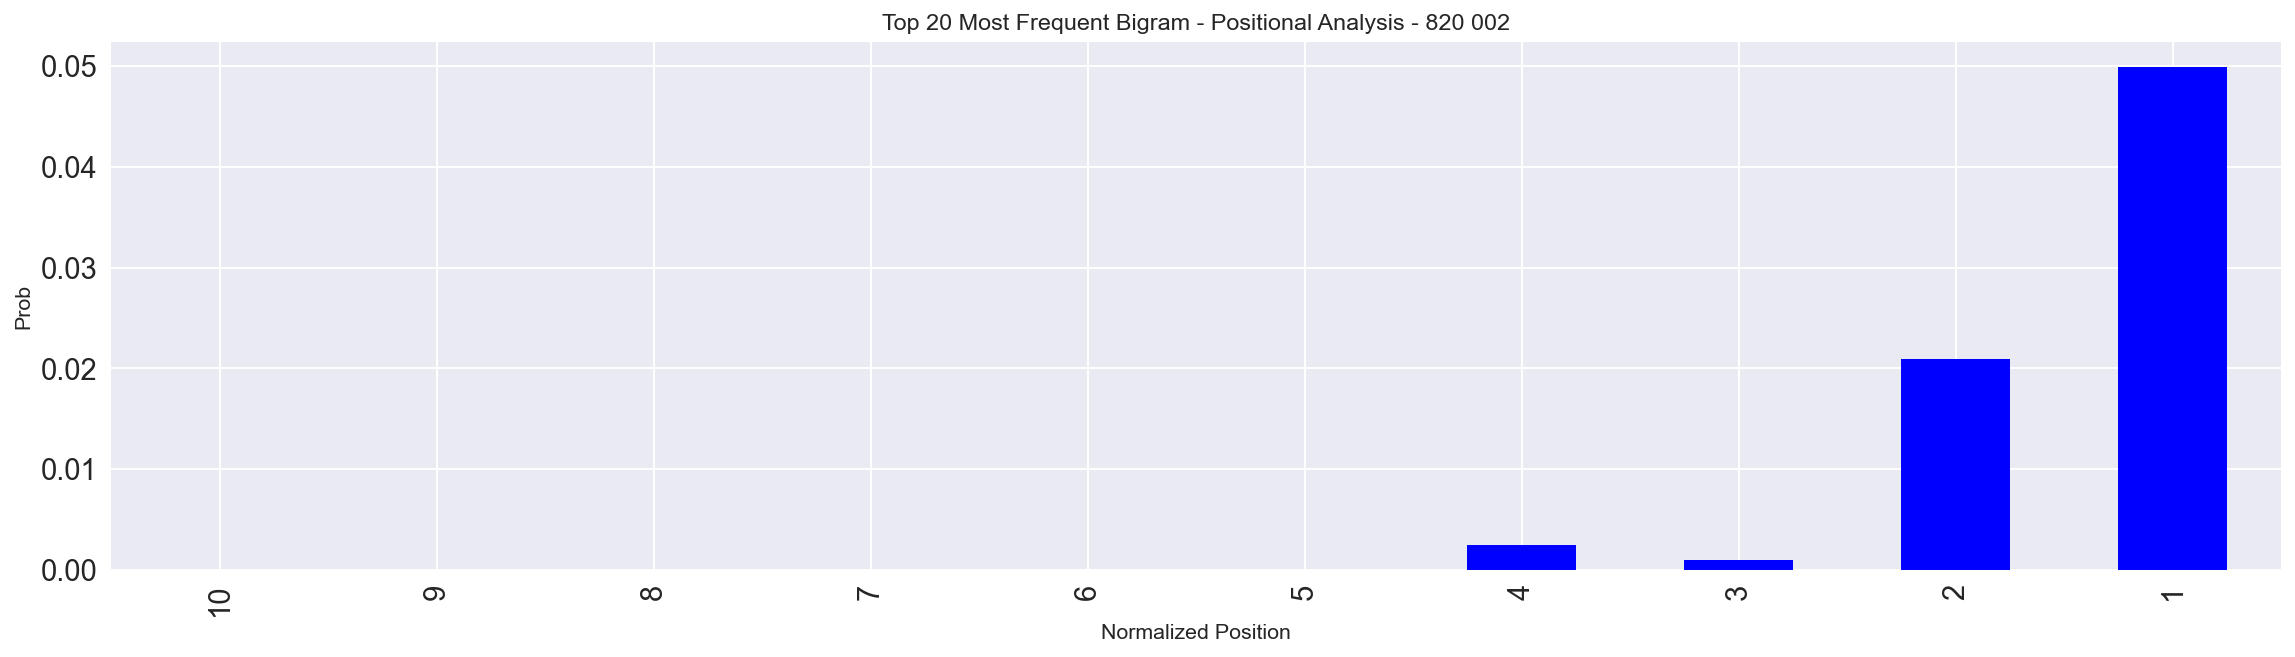

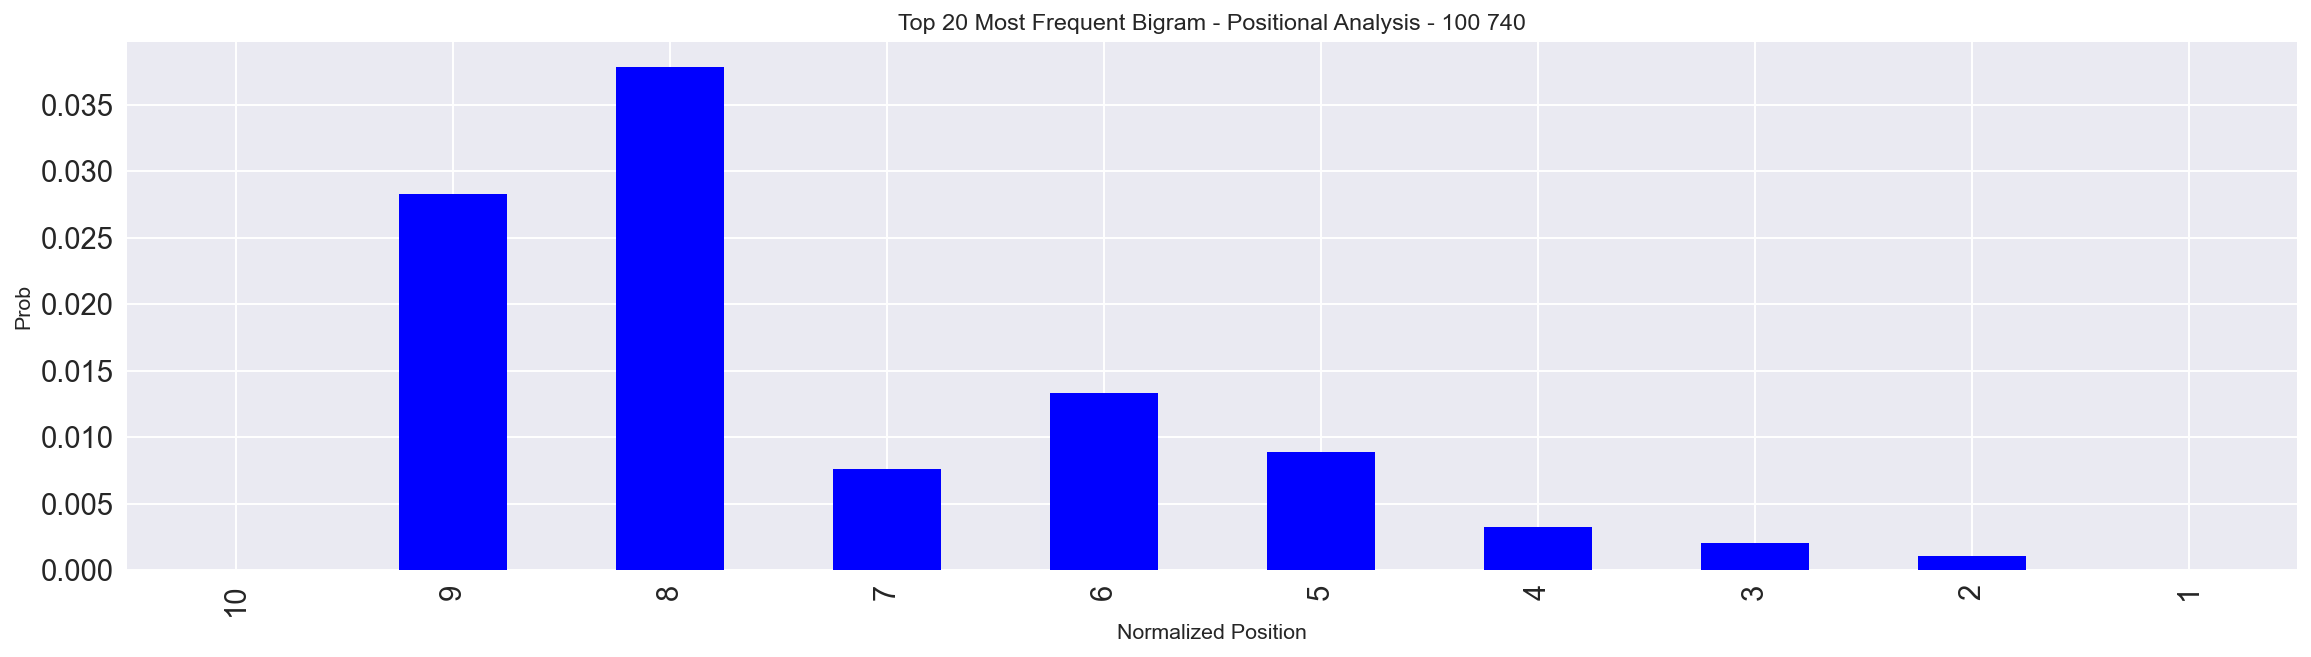

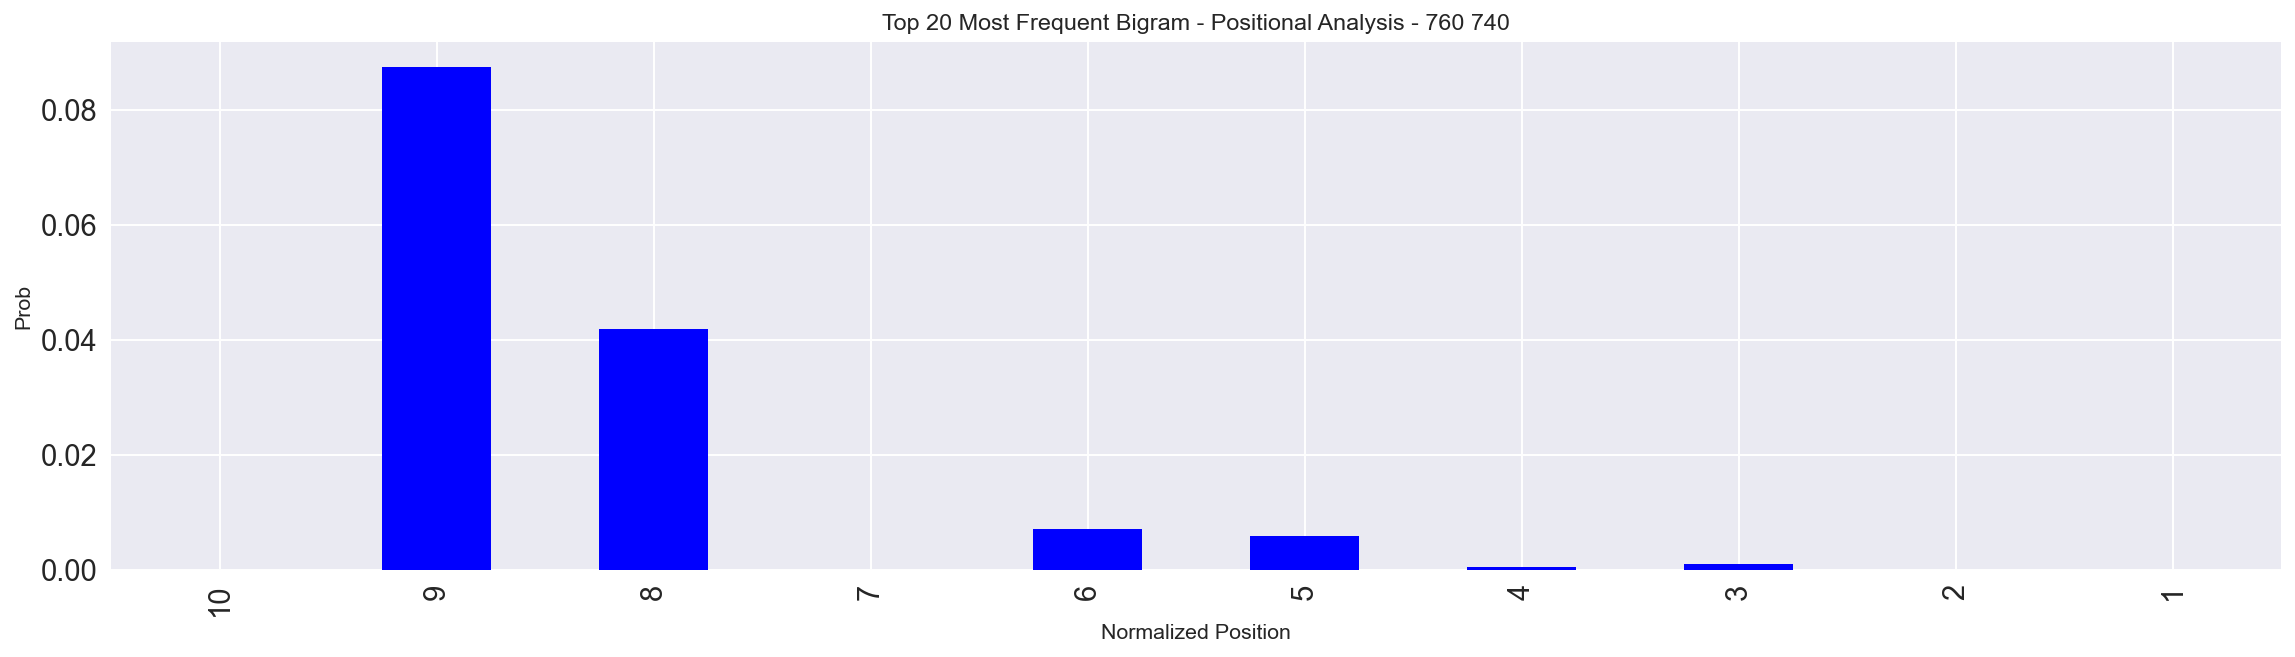

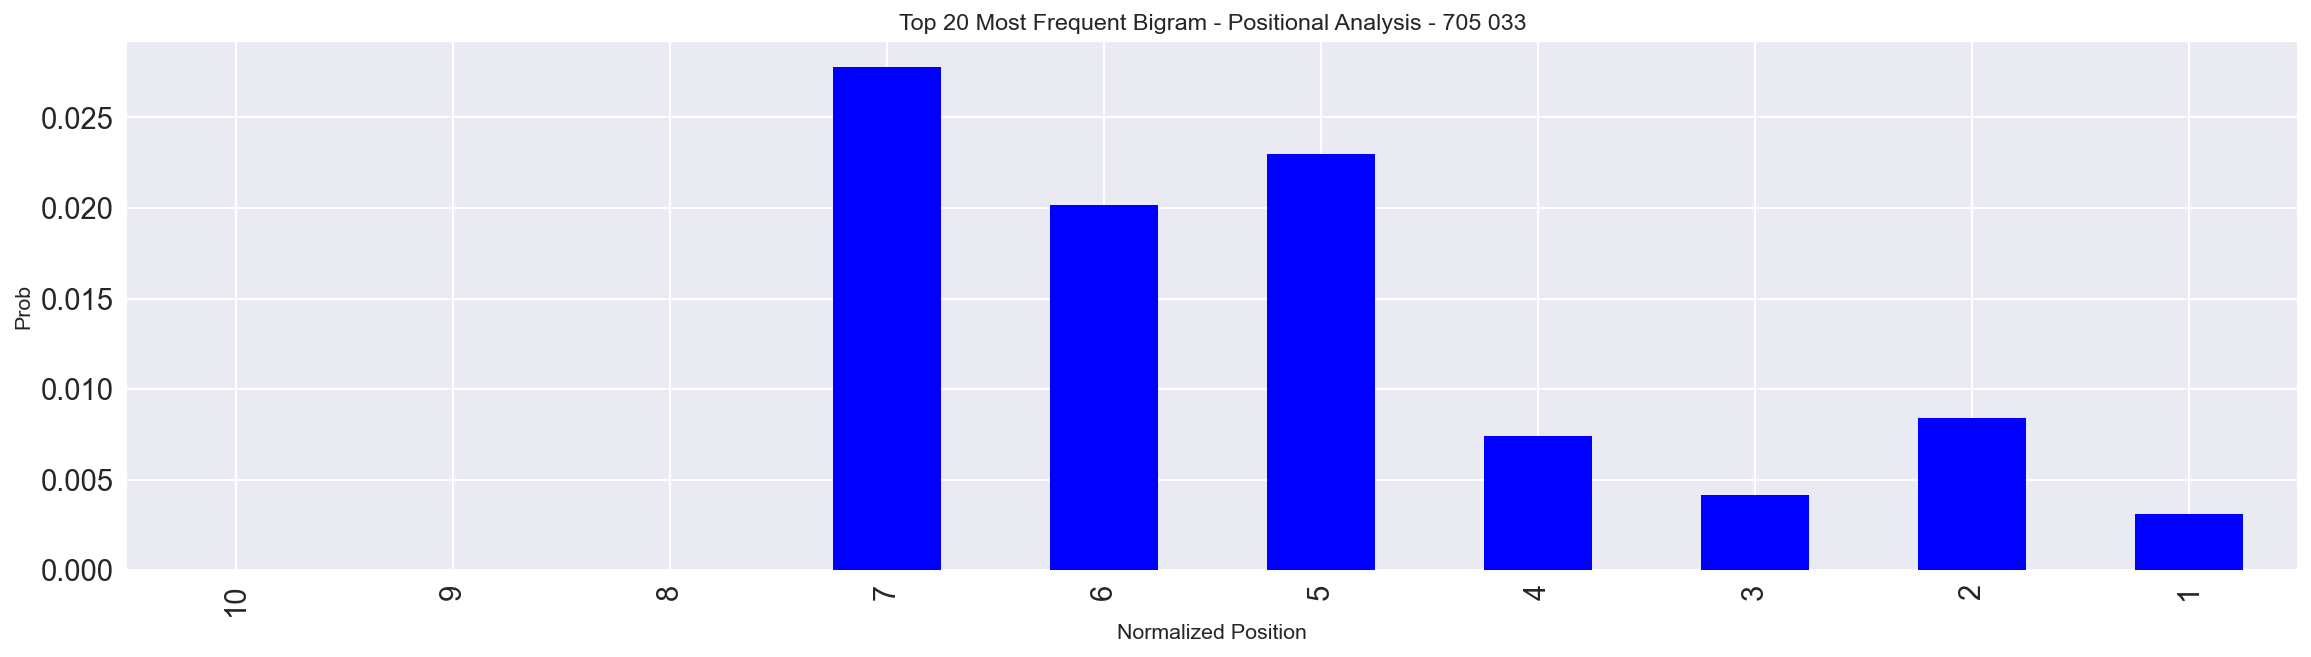

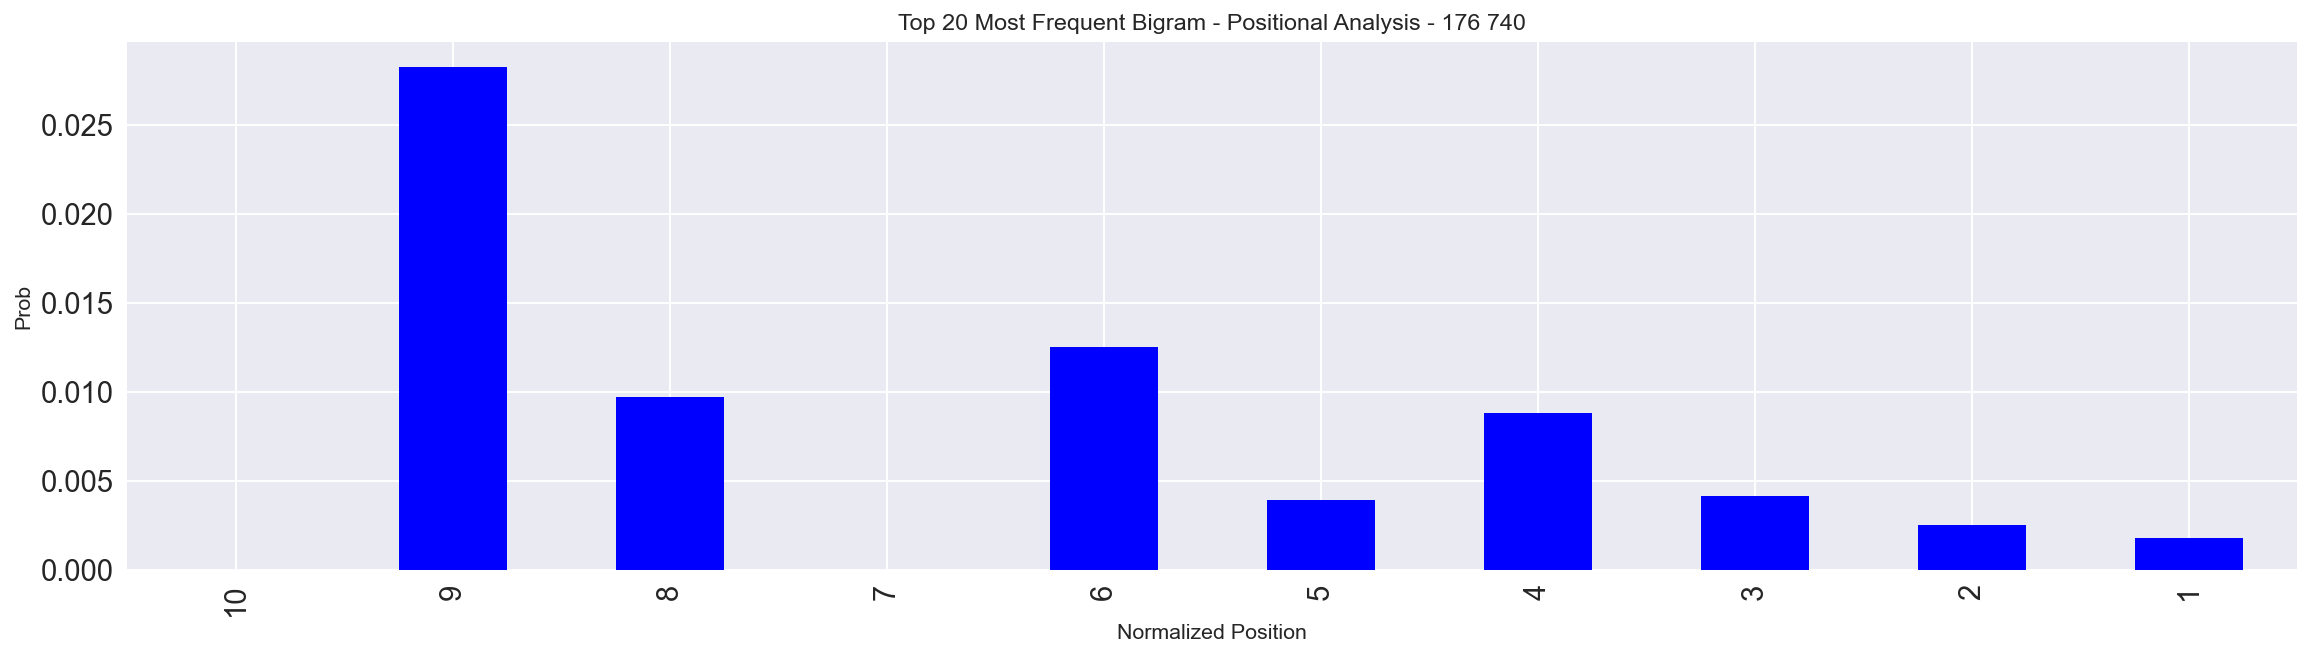

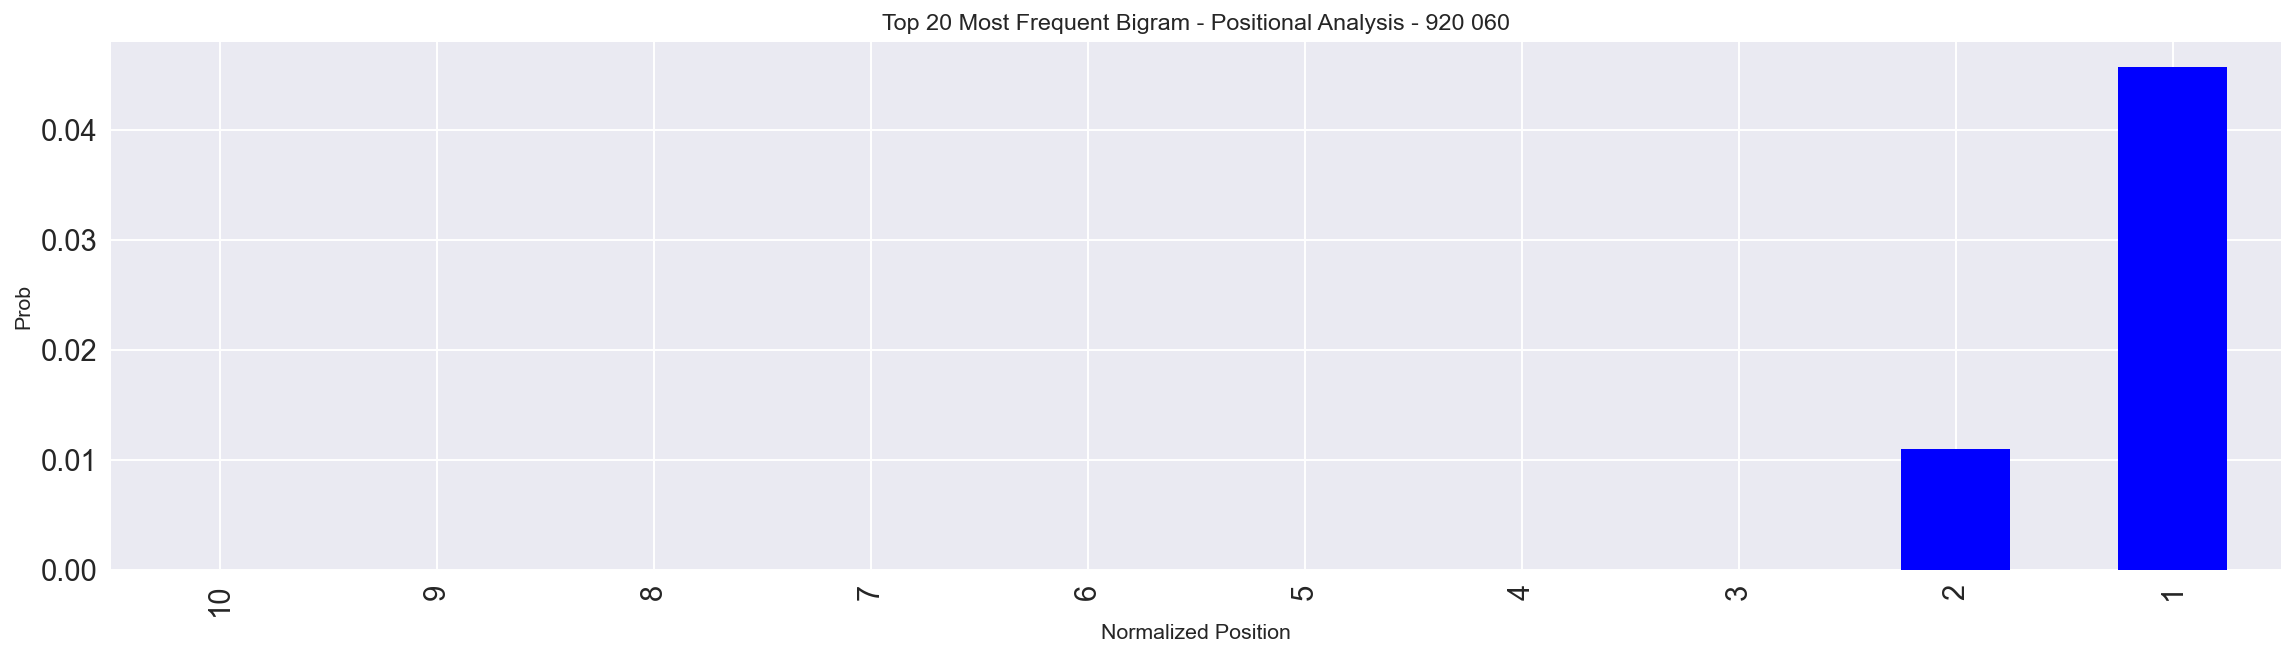

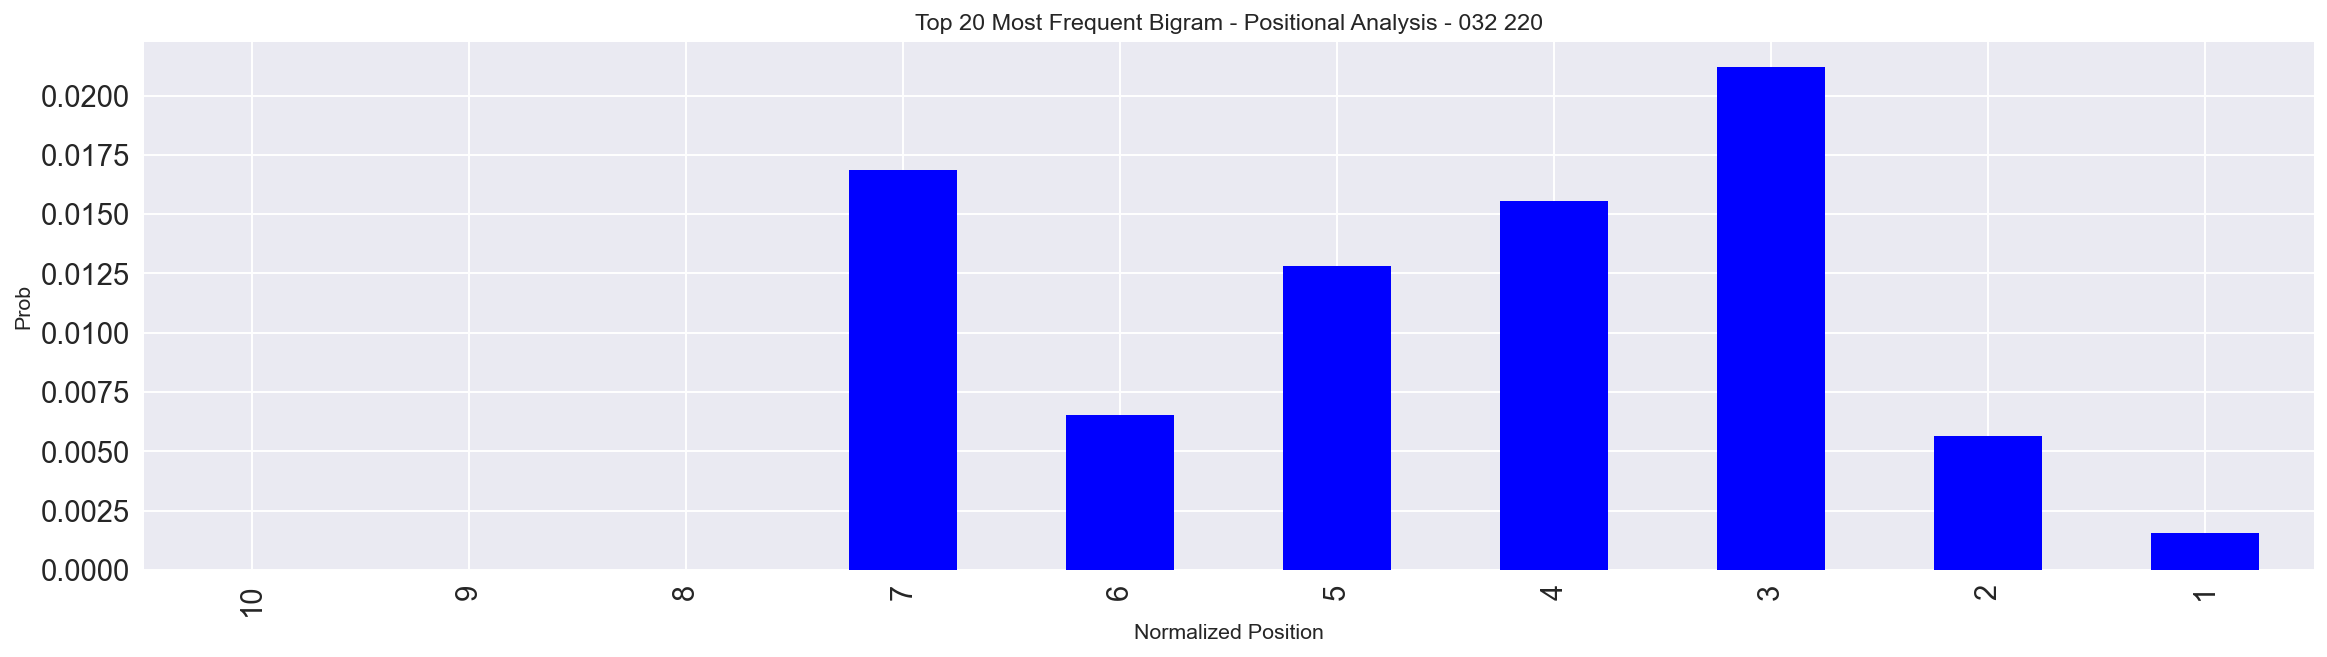

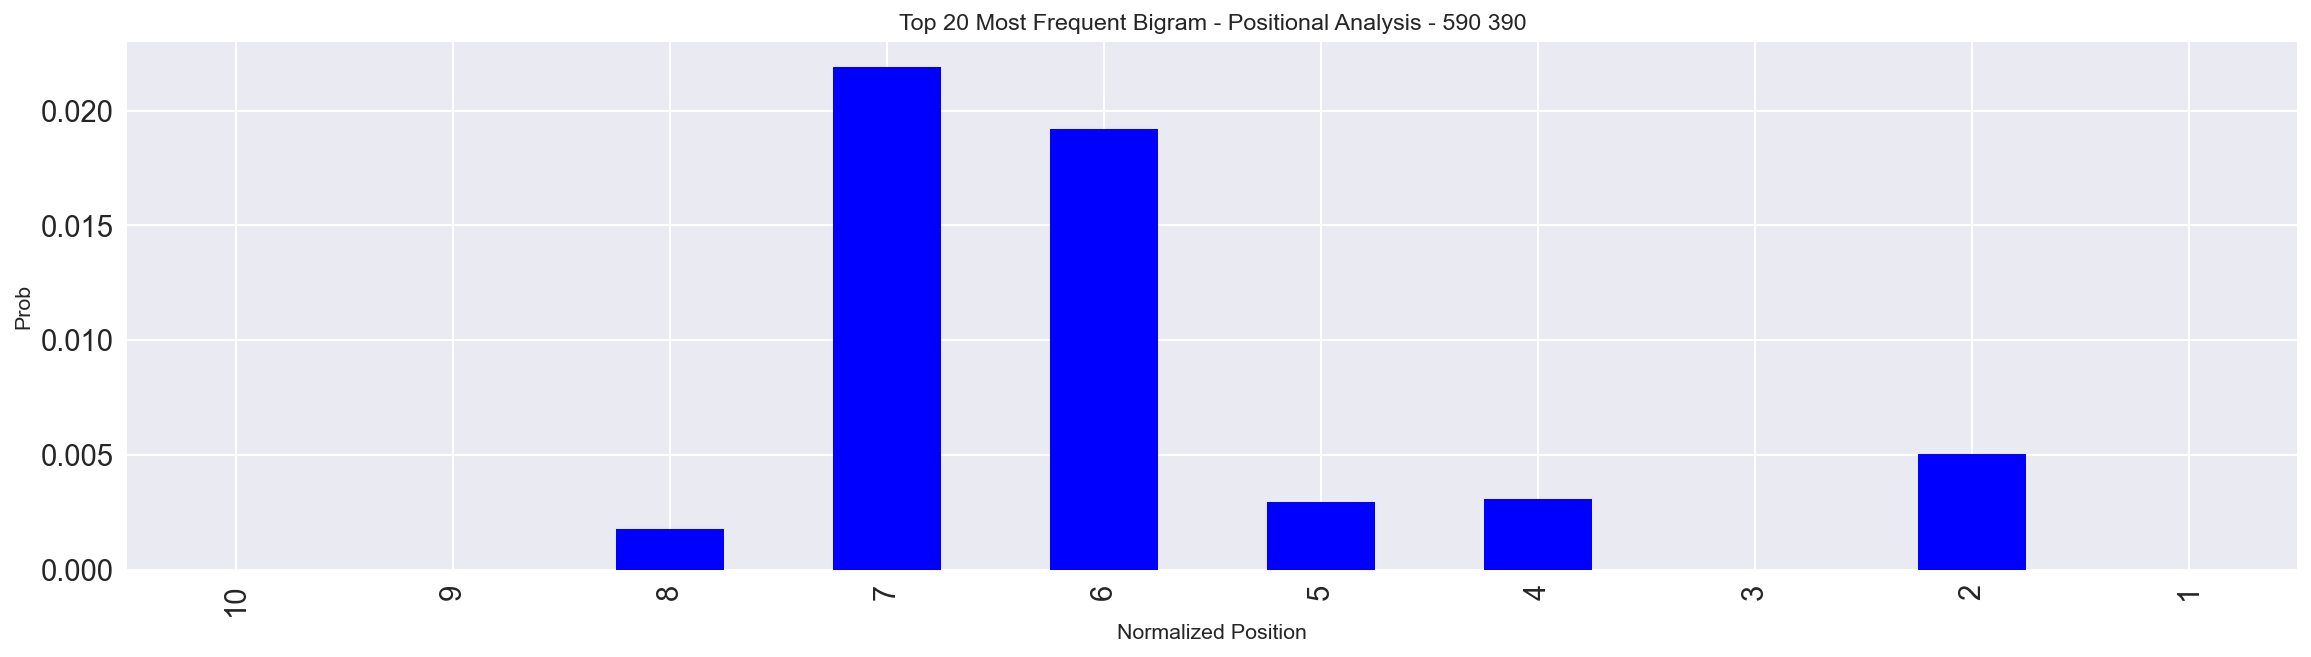

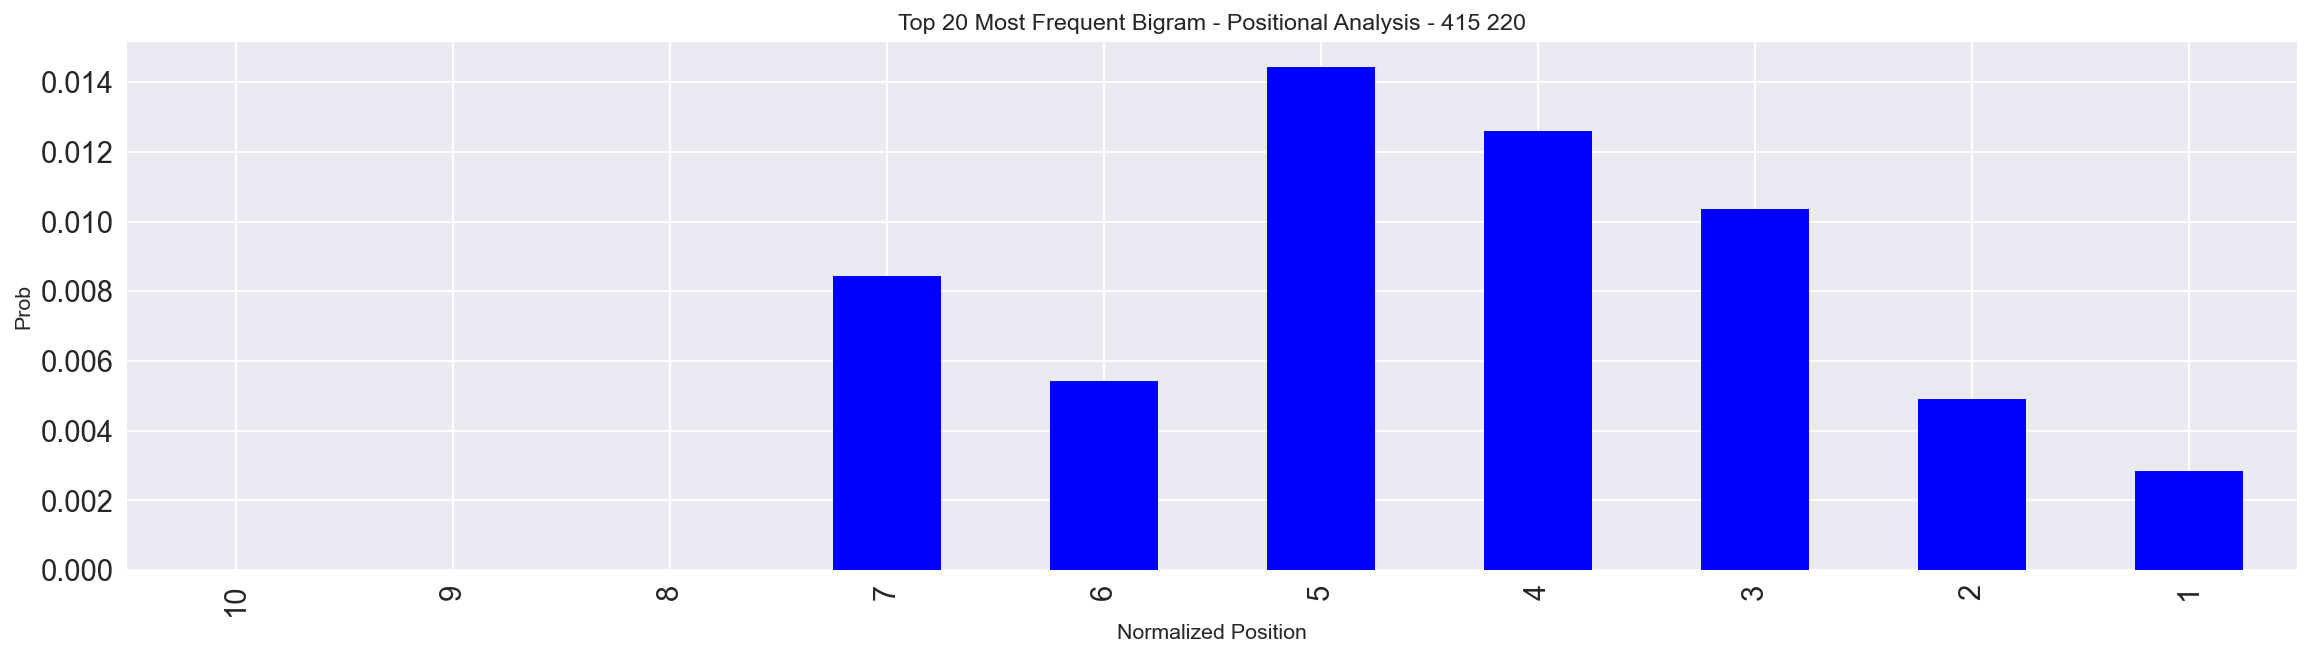

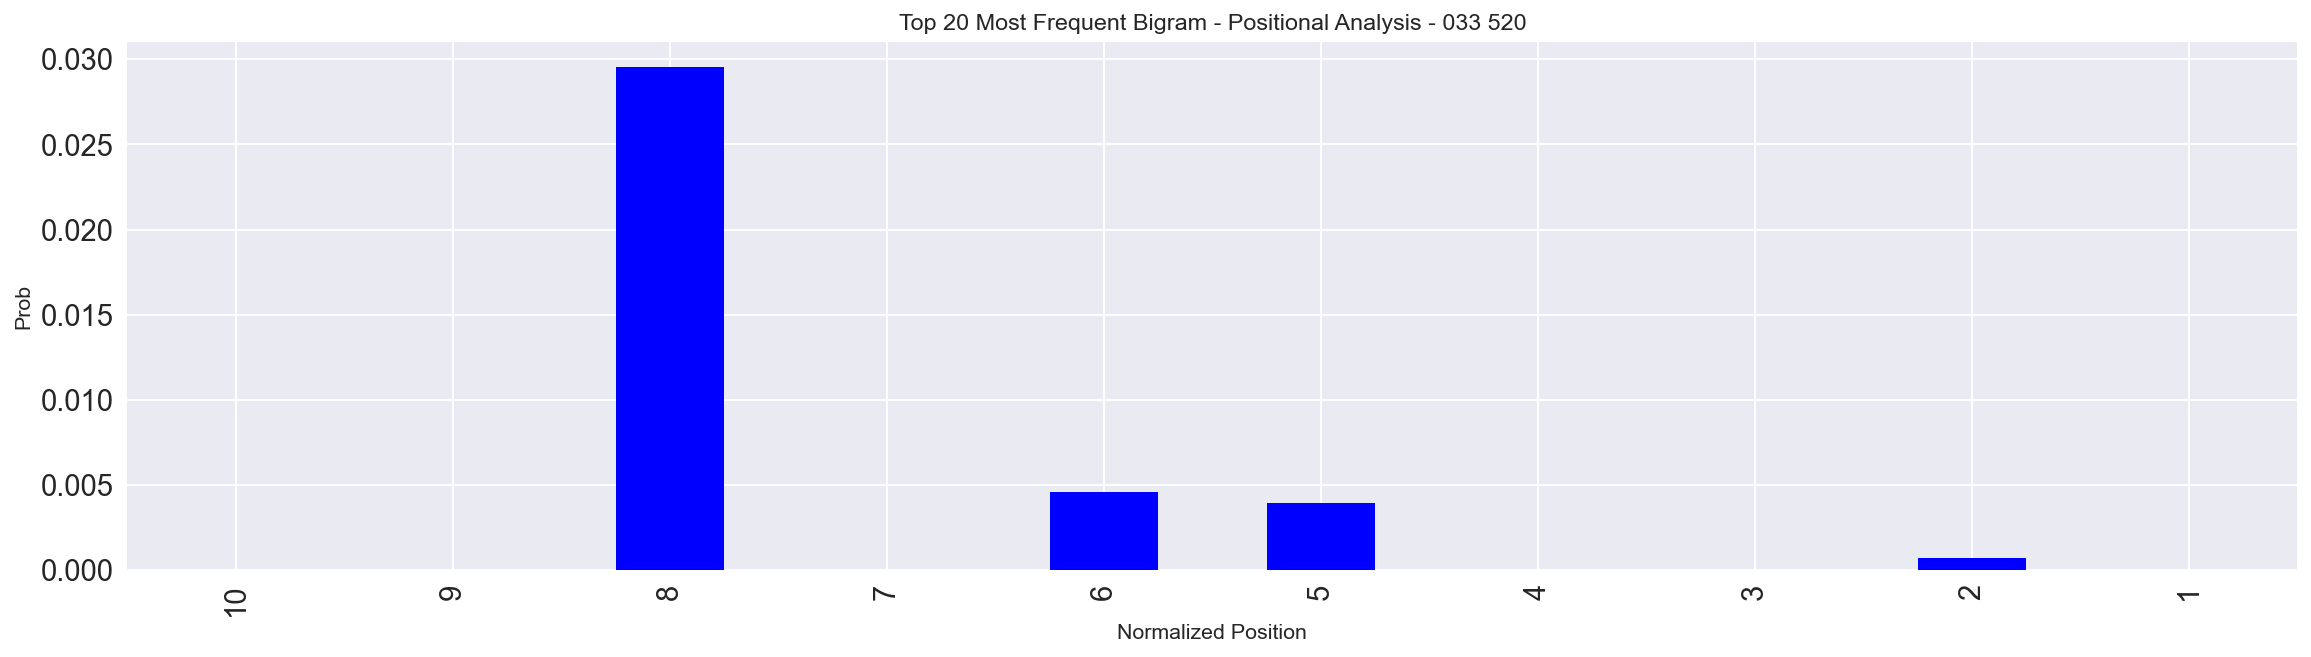

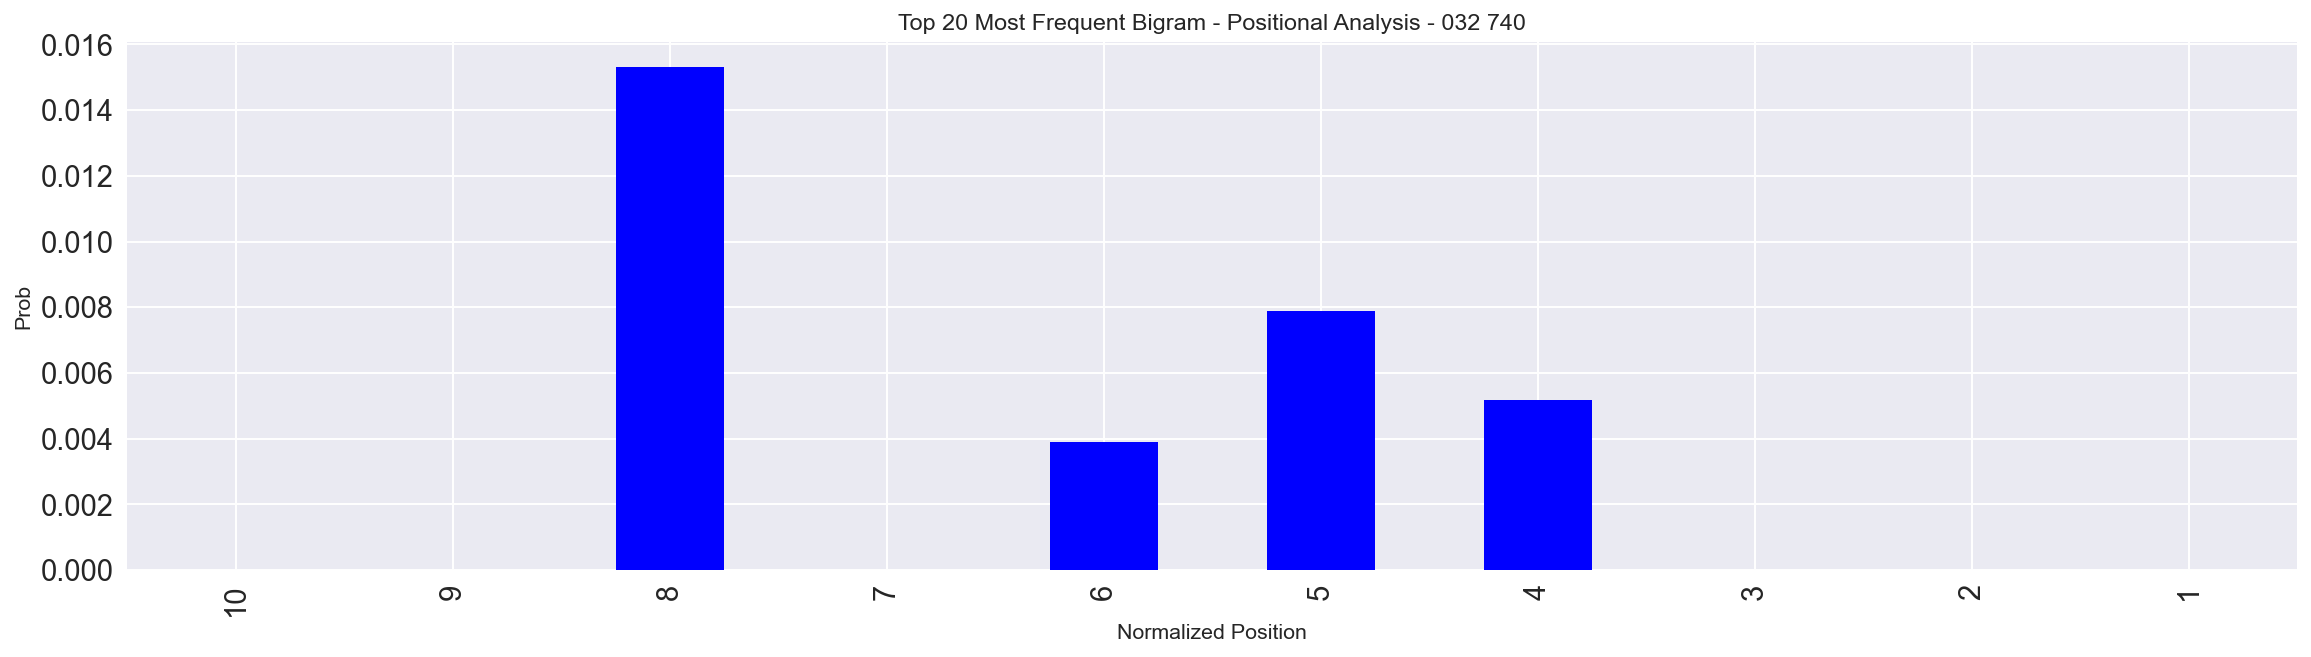

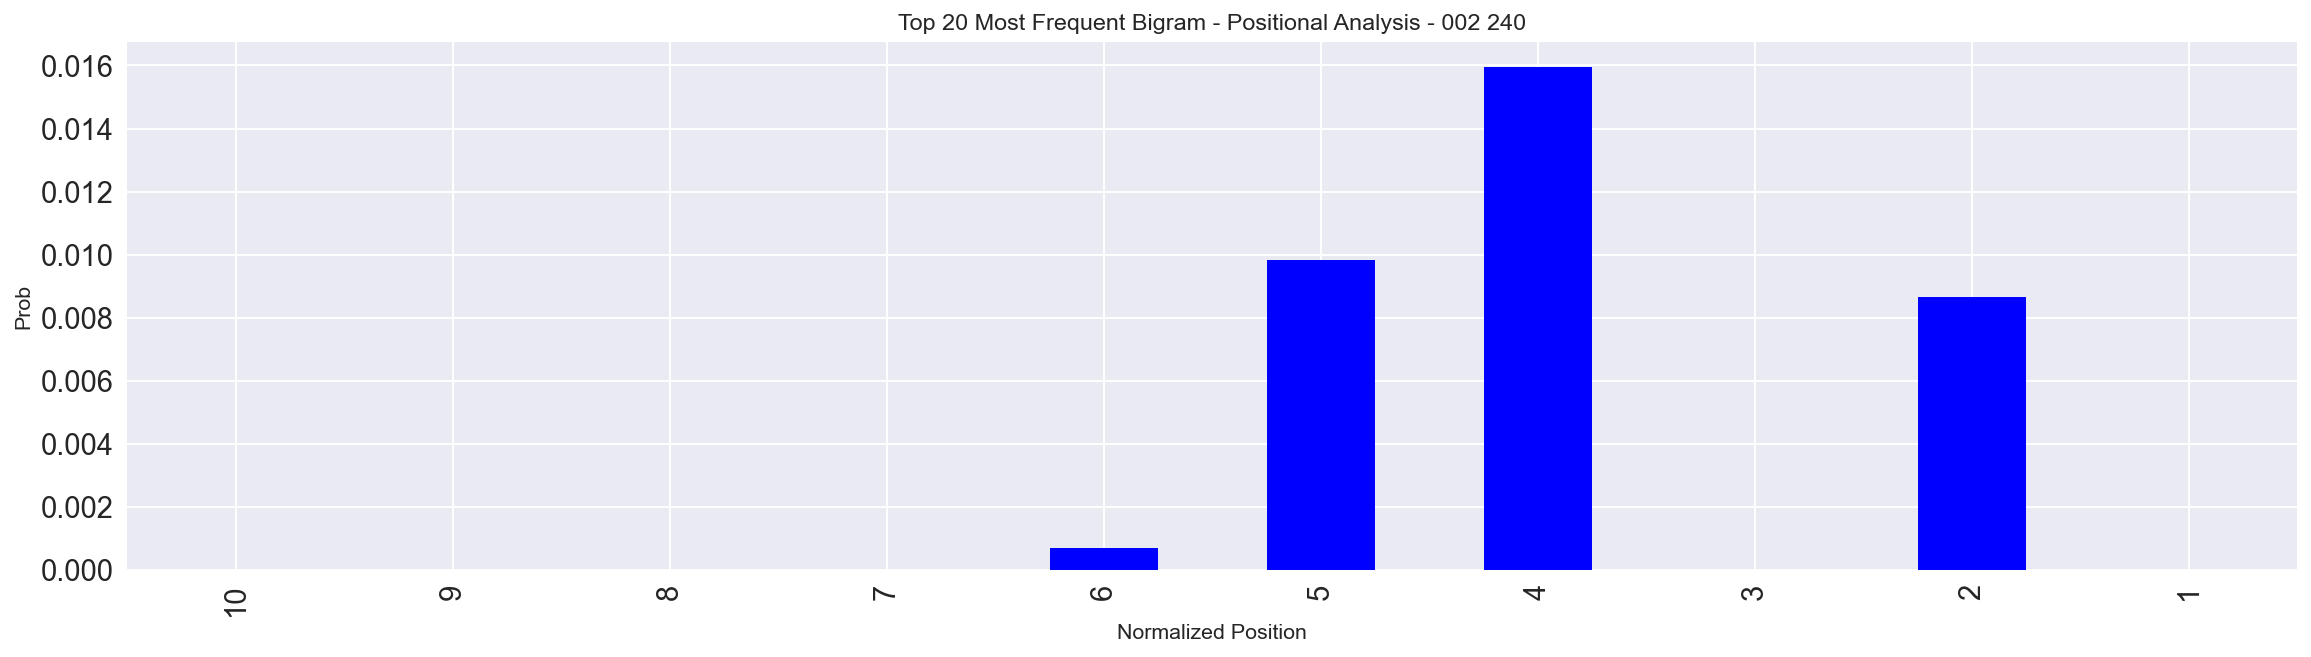

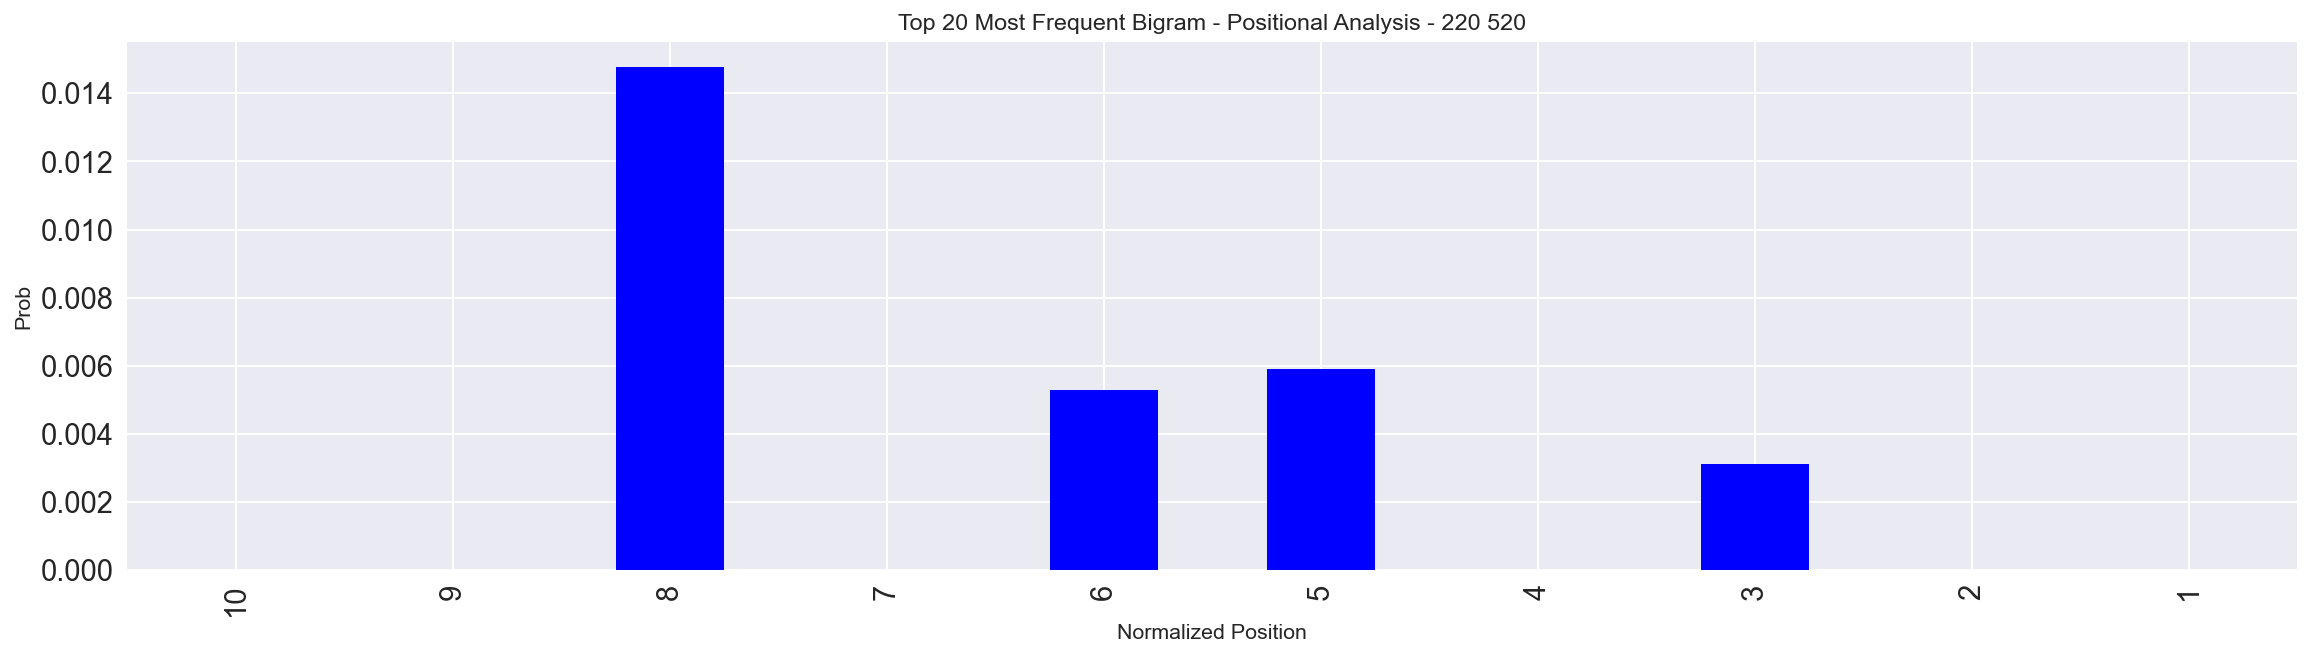

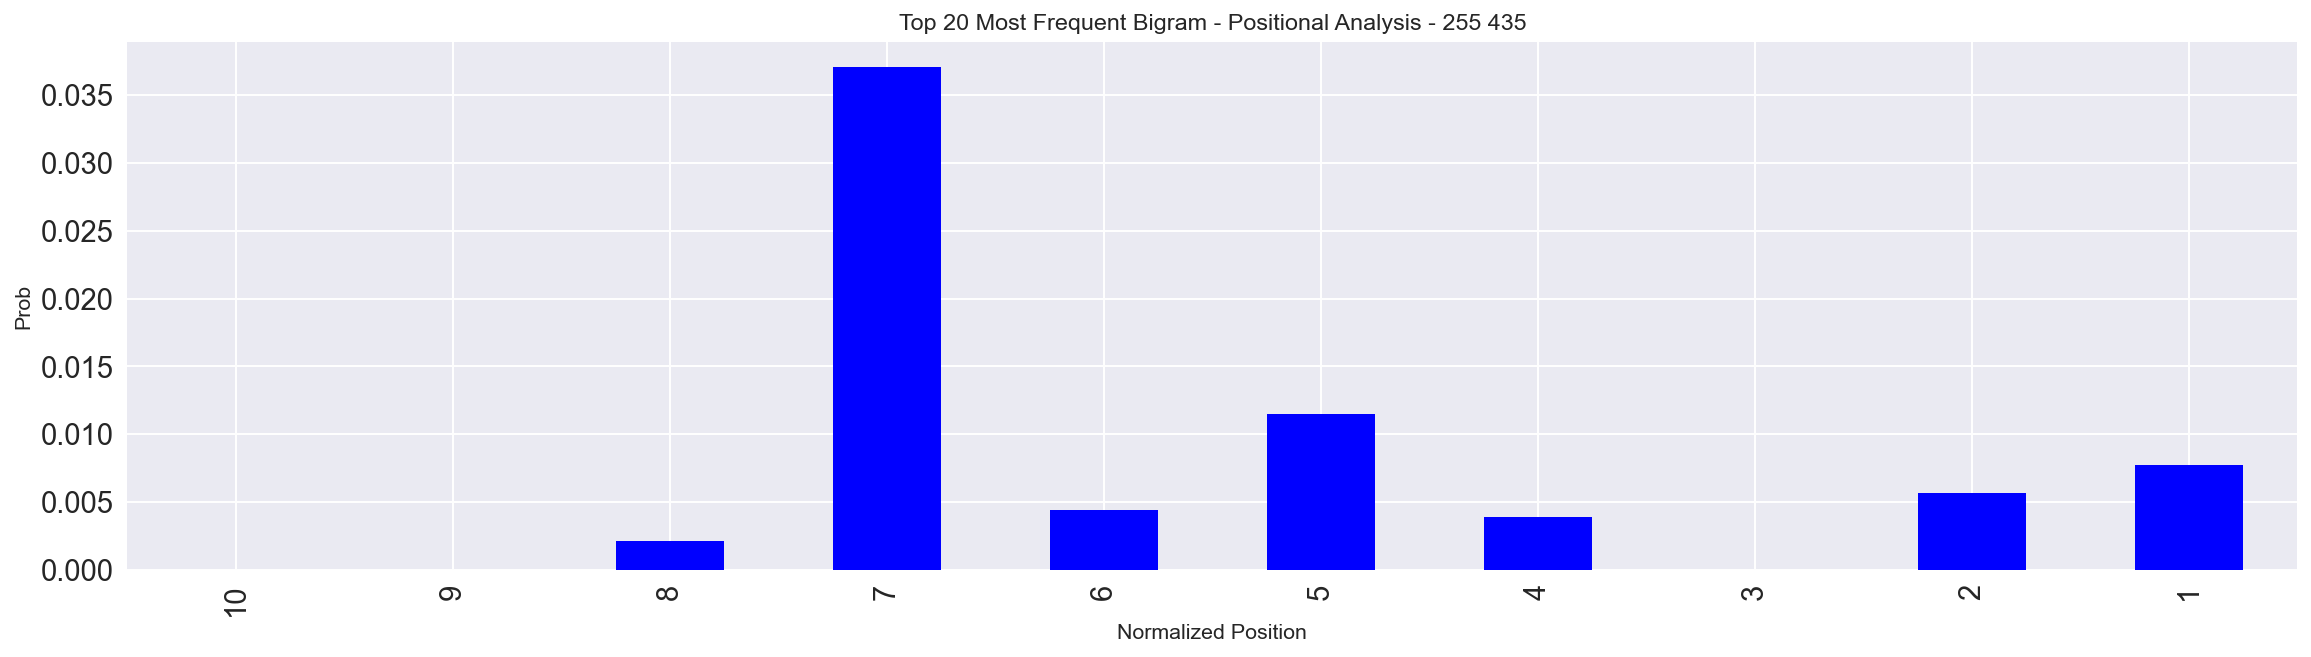

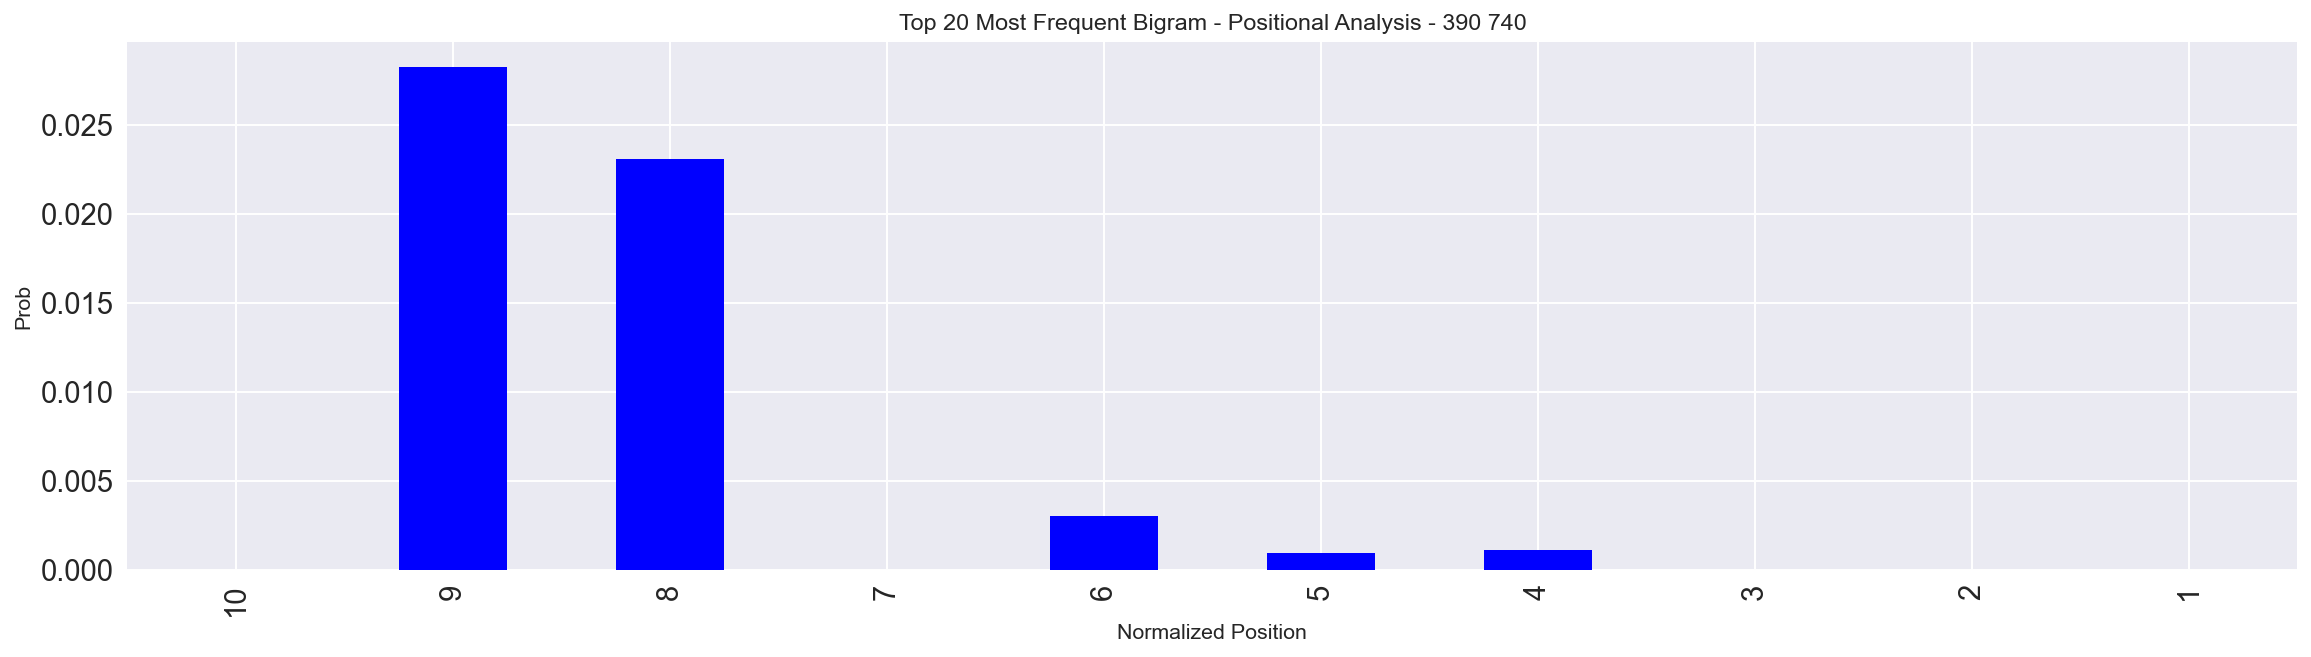

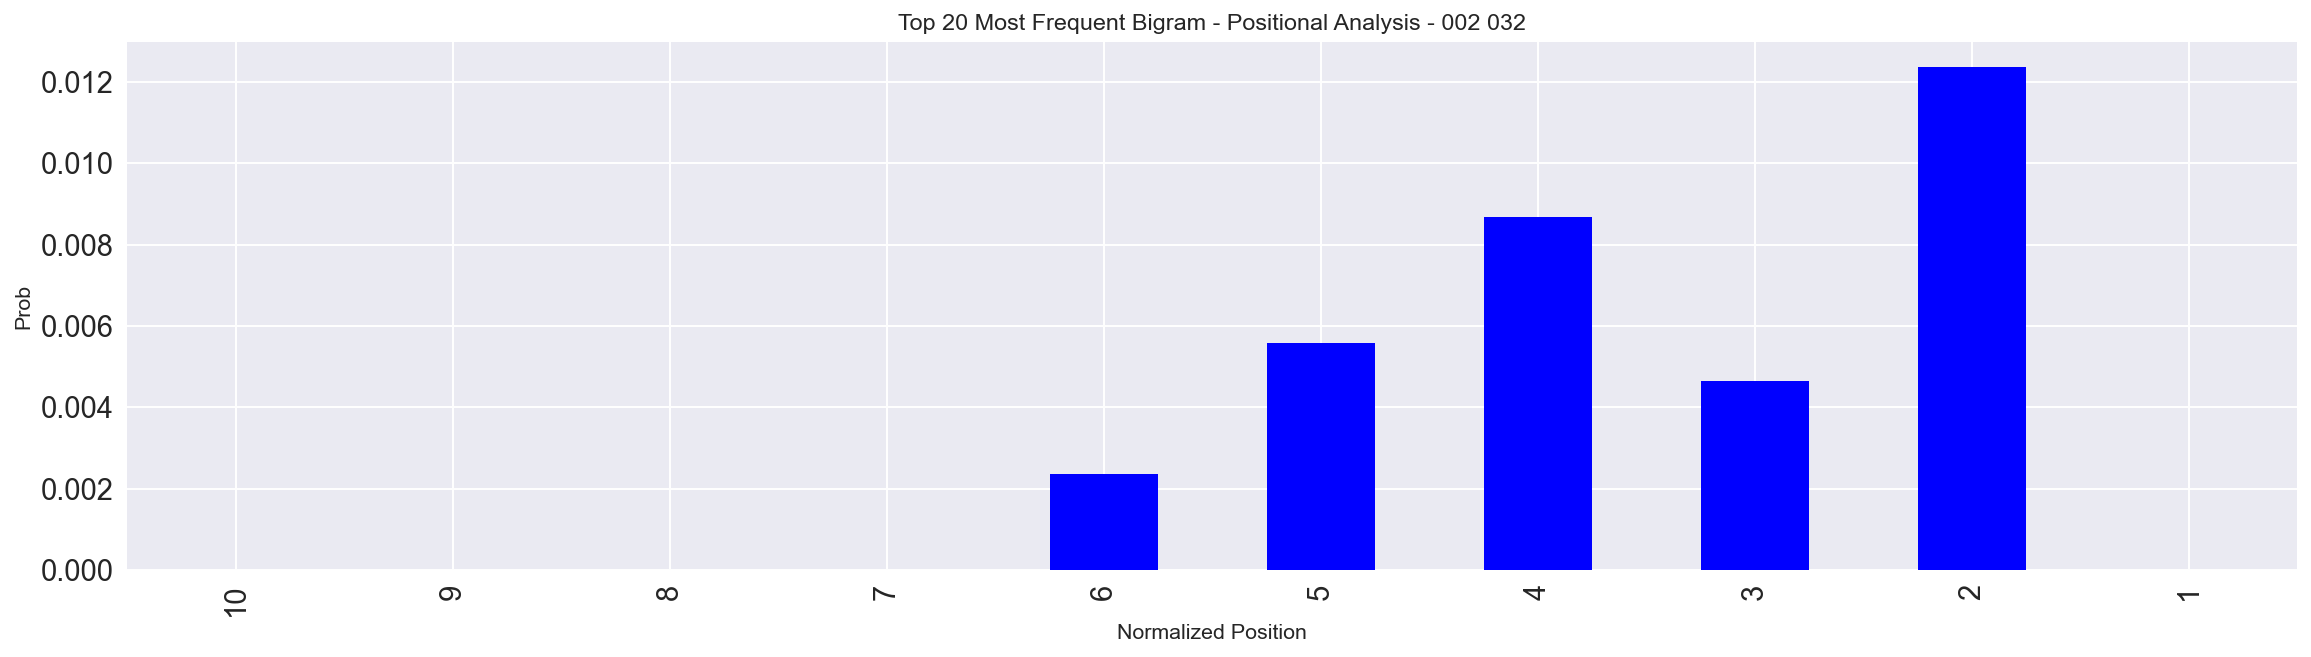

In [102]:
for bigram in pd_text_bigrams1:
    df_text_norm_position_bigrams_prob[bigram].plot(kind='bar', color='blue')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.title("Top 20 Most Frequent Bigram - Positional Analysis - " + bigram)

    plt.show()

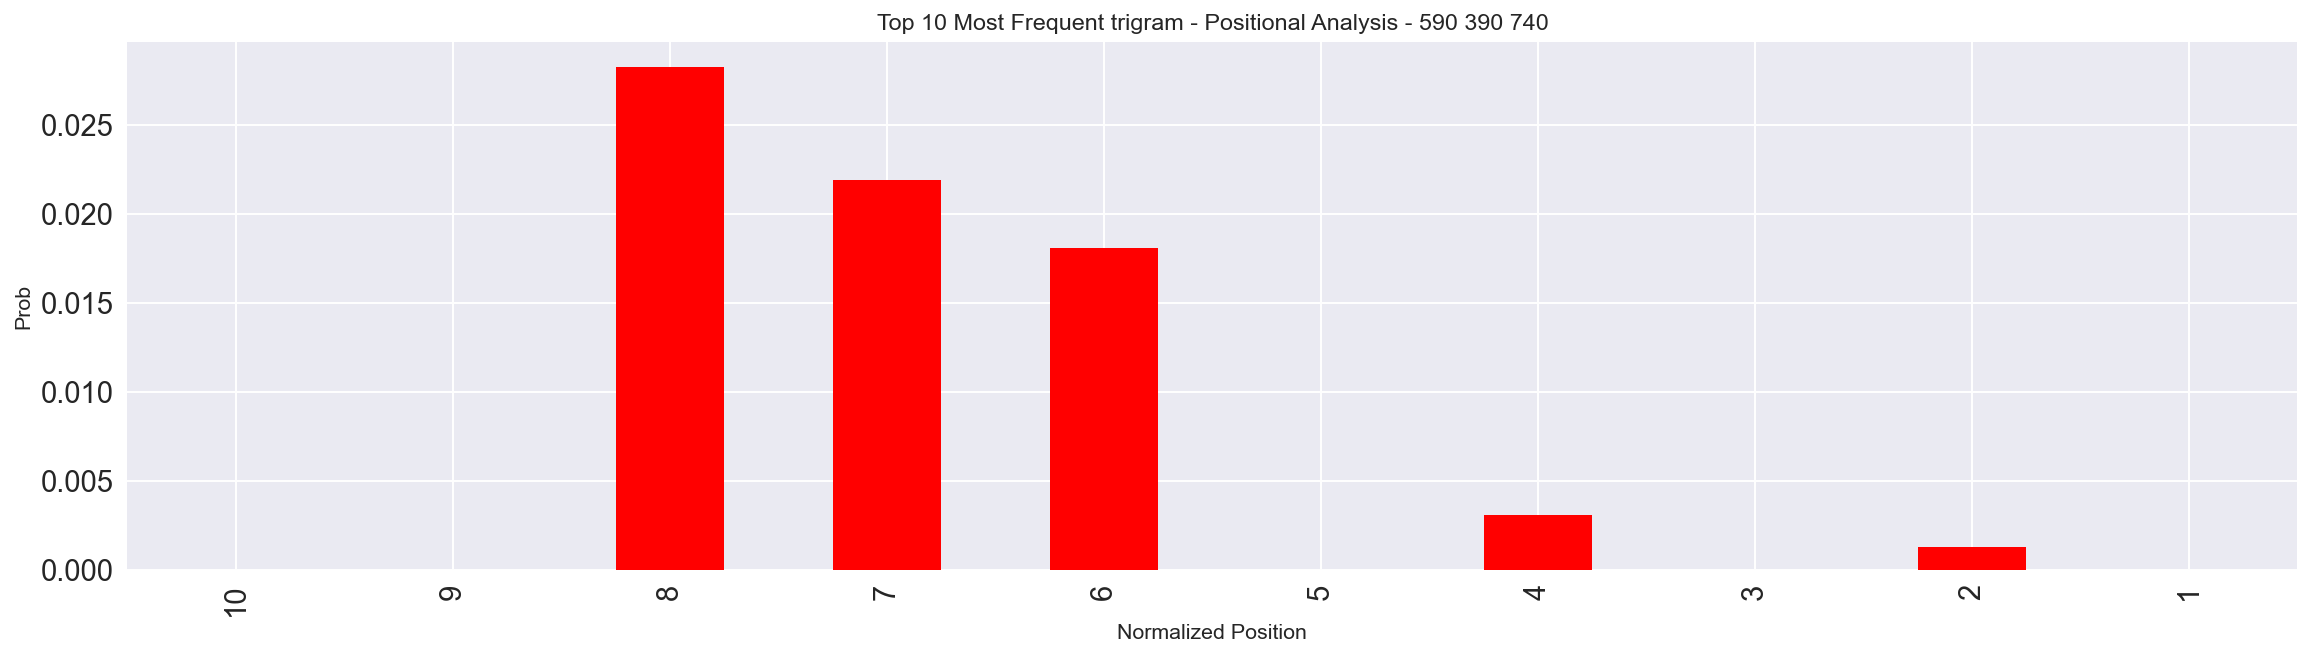

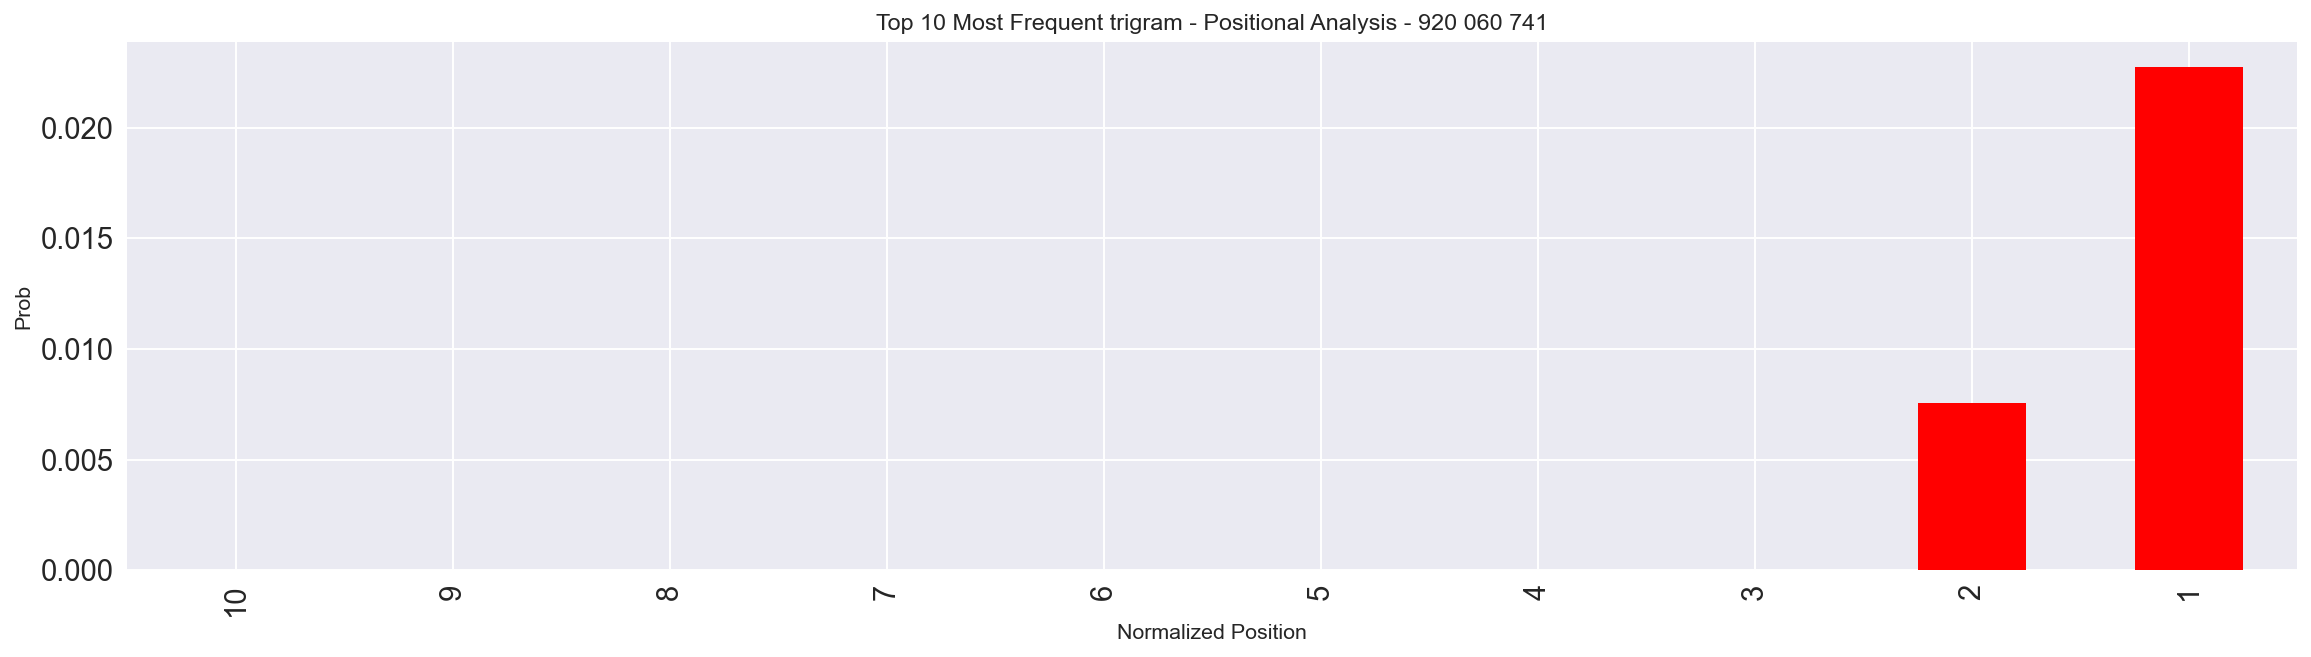

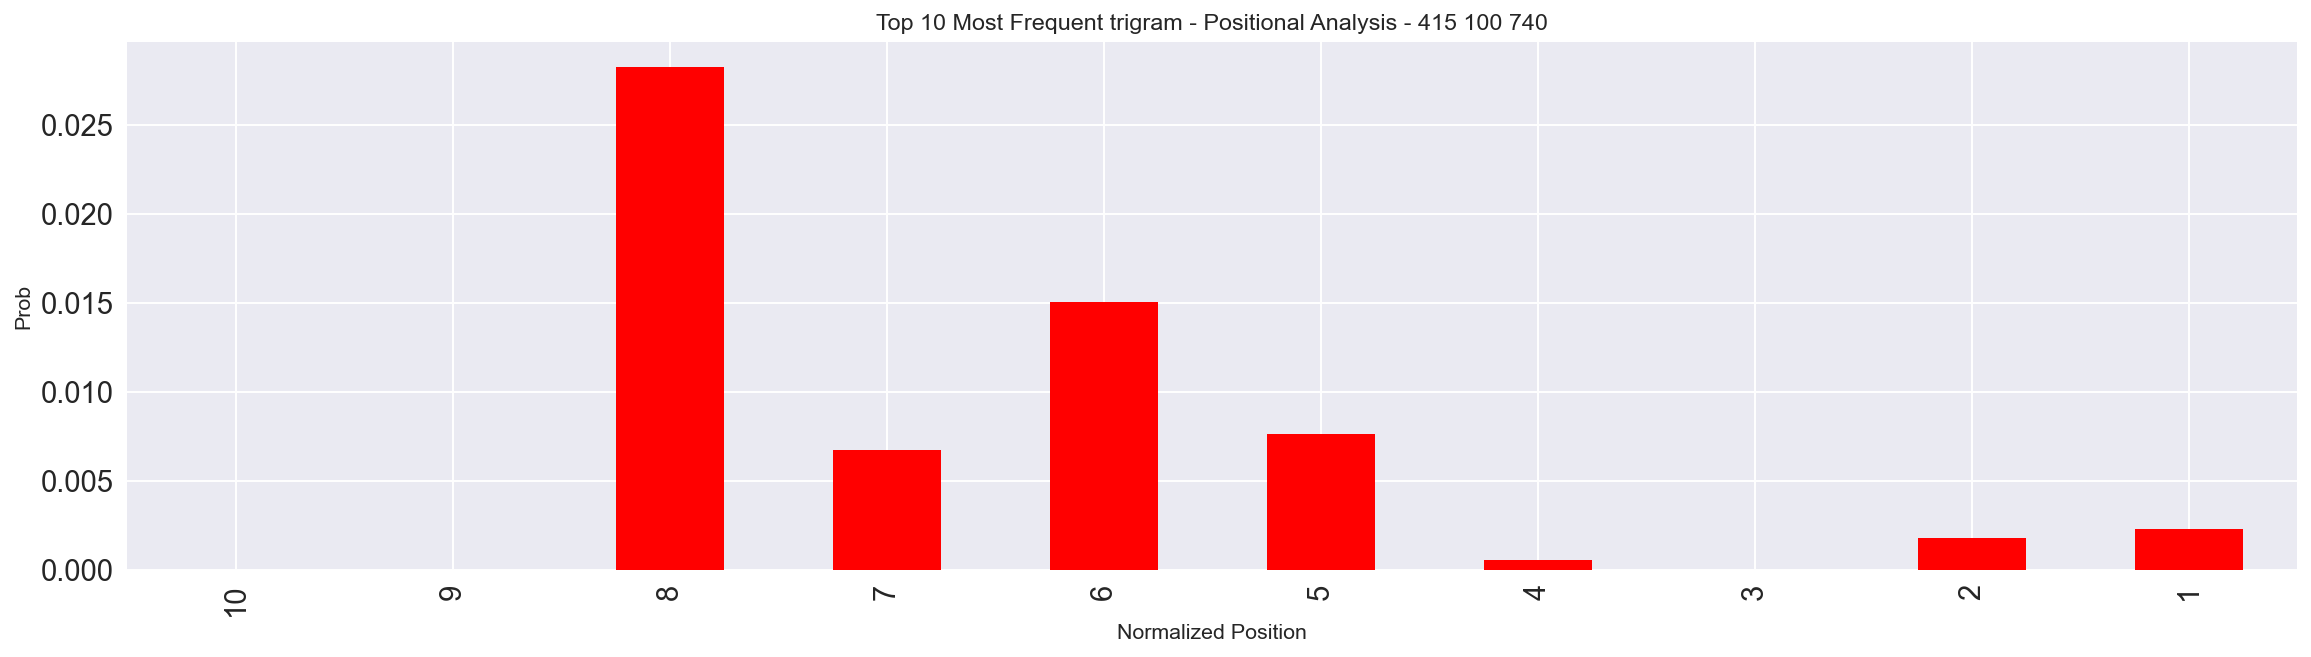

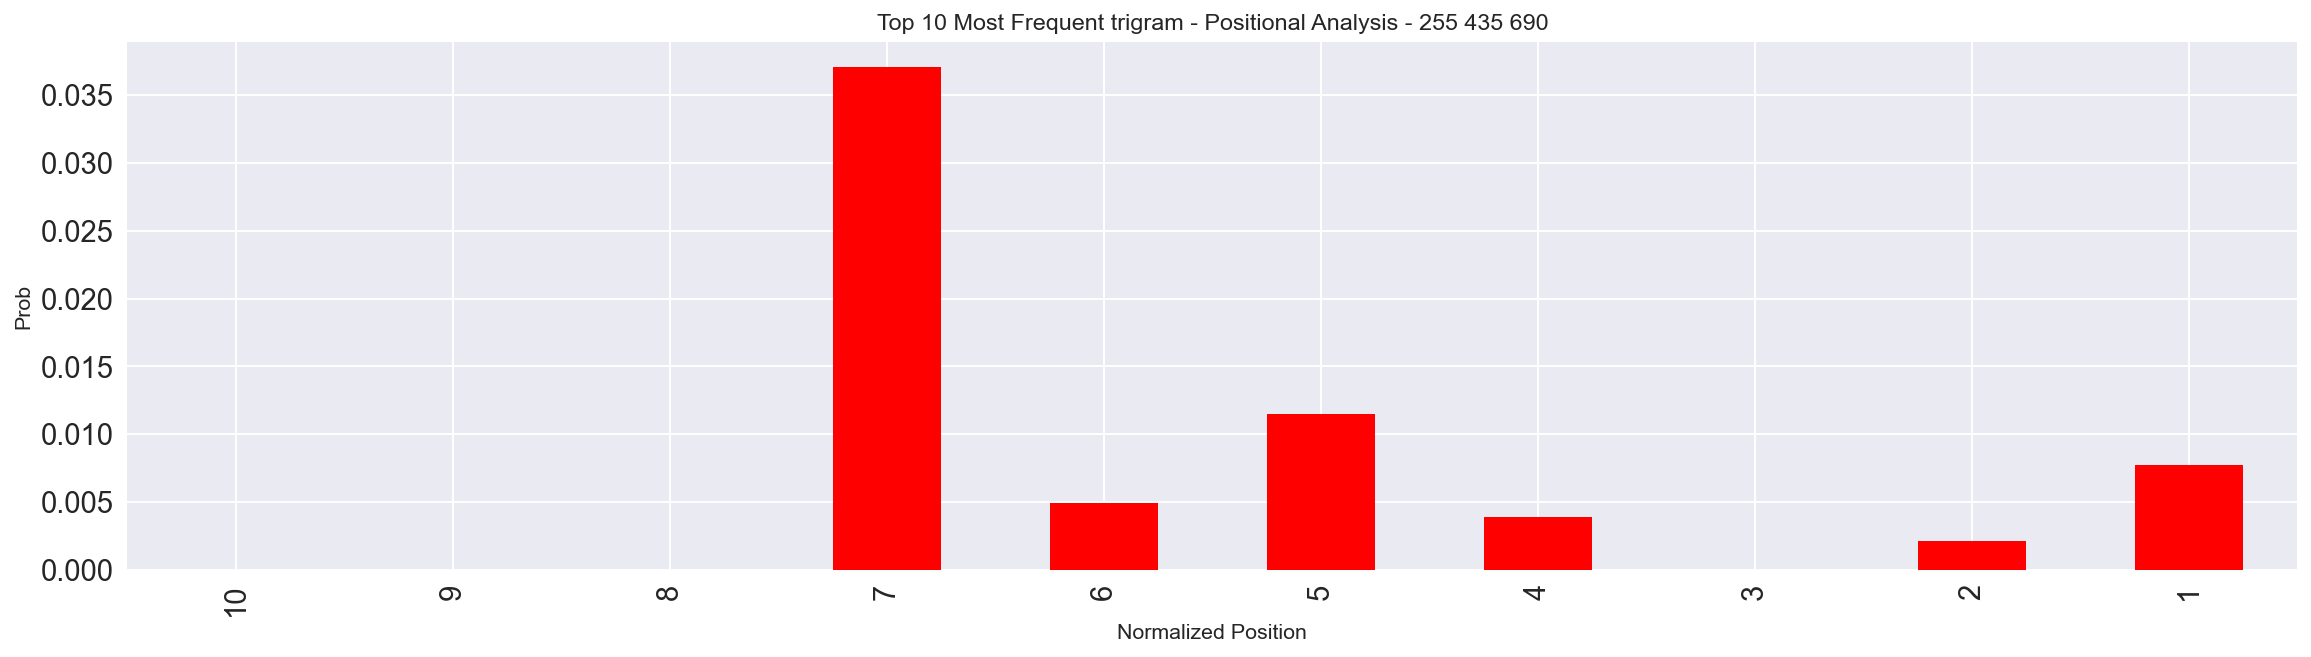

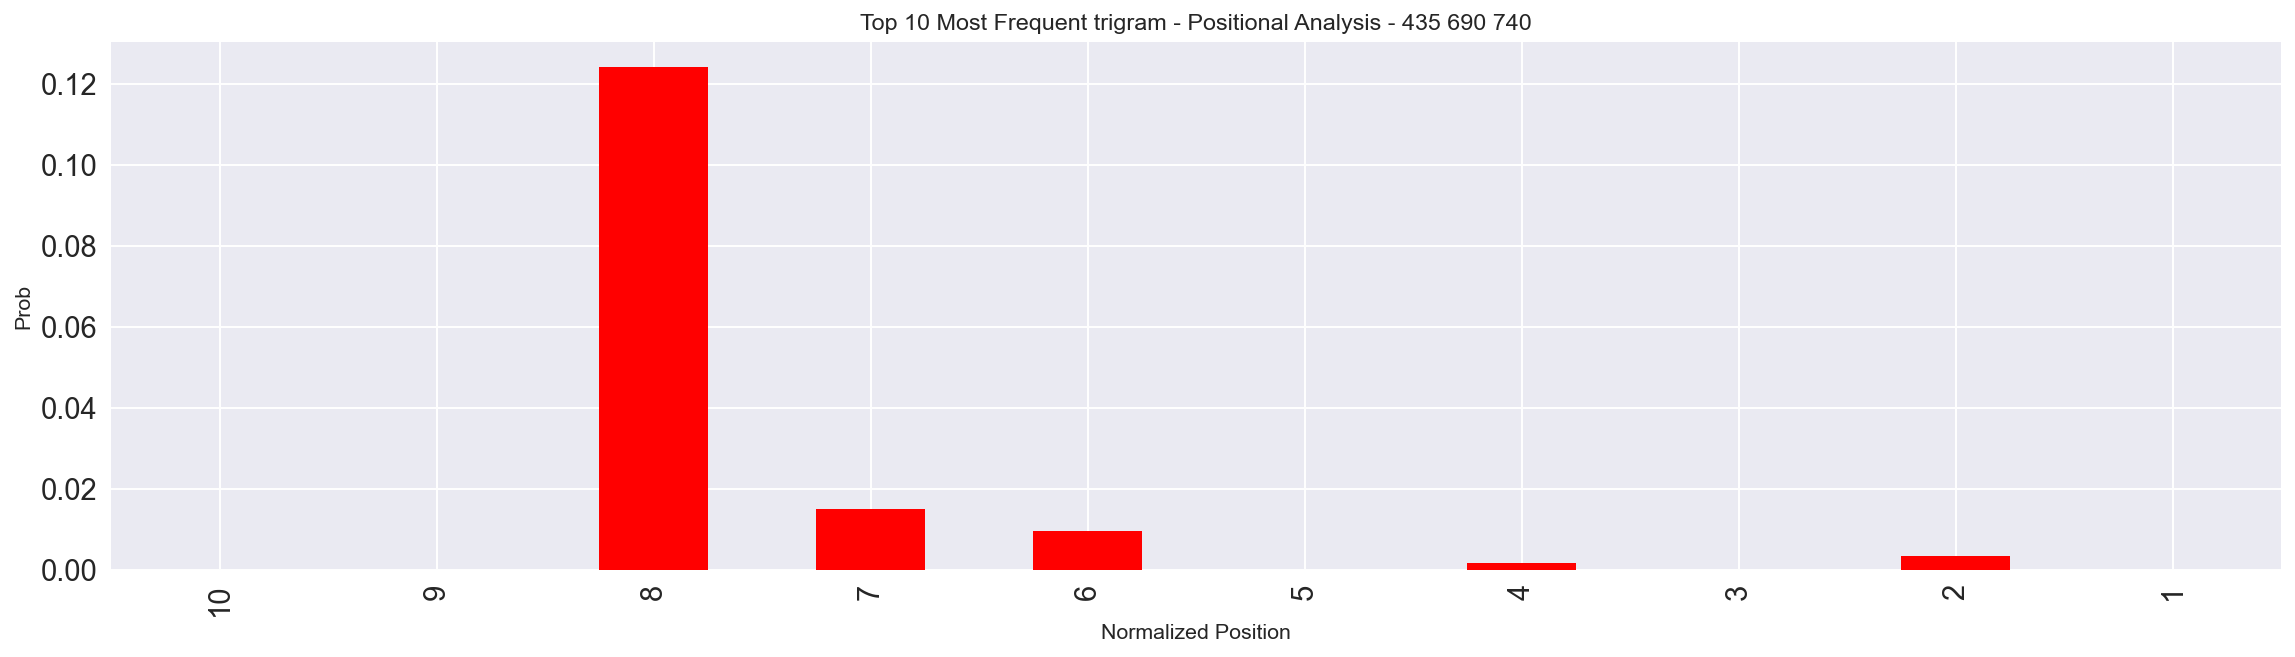

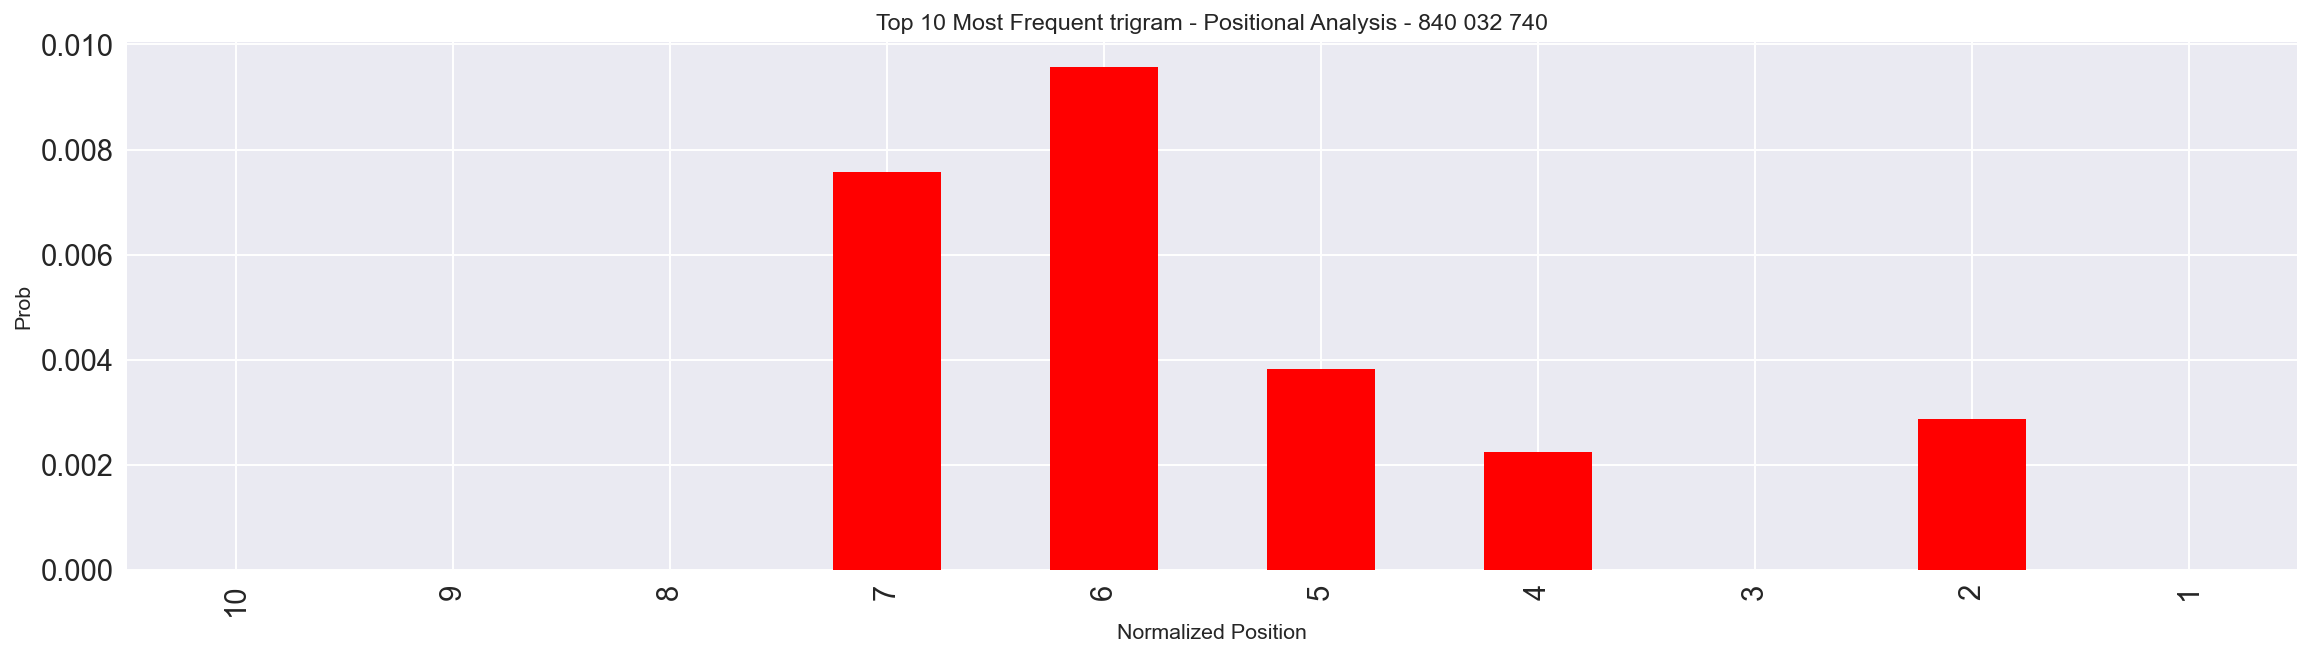

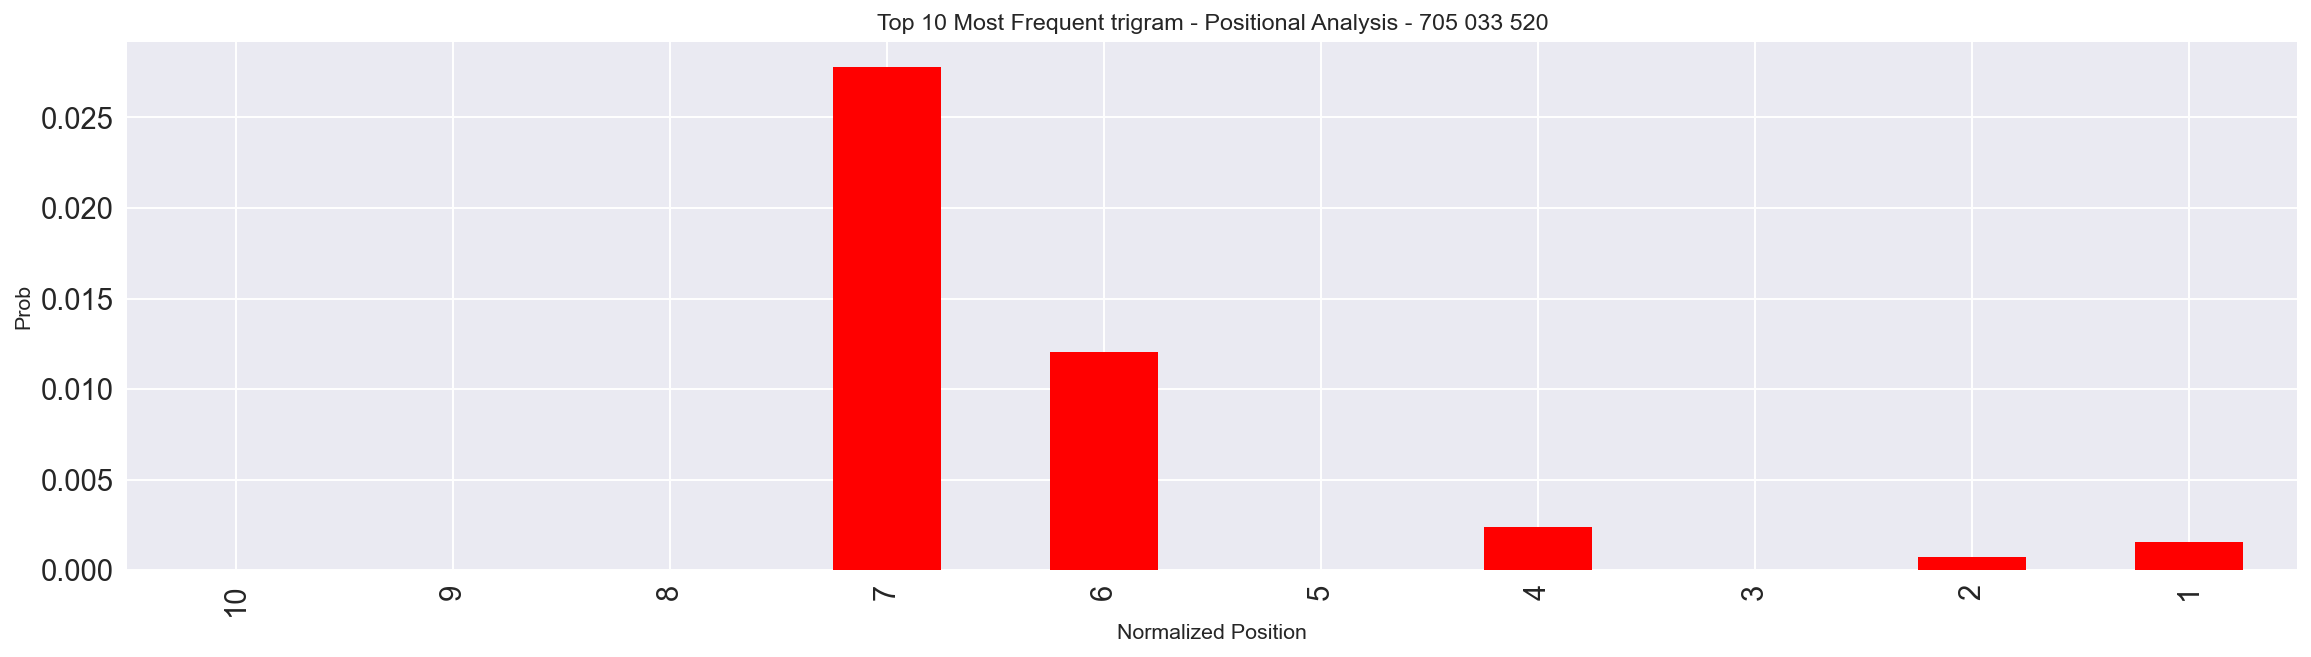

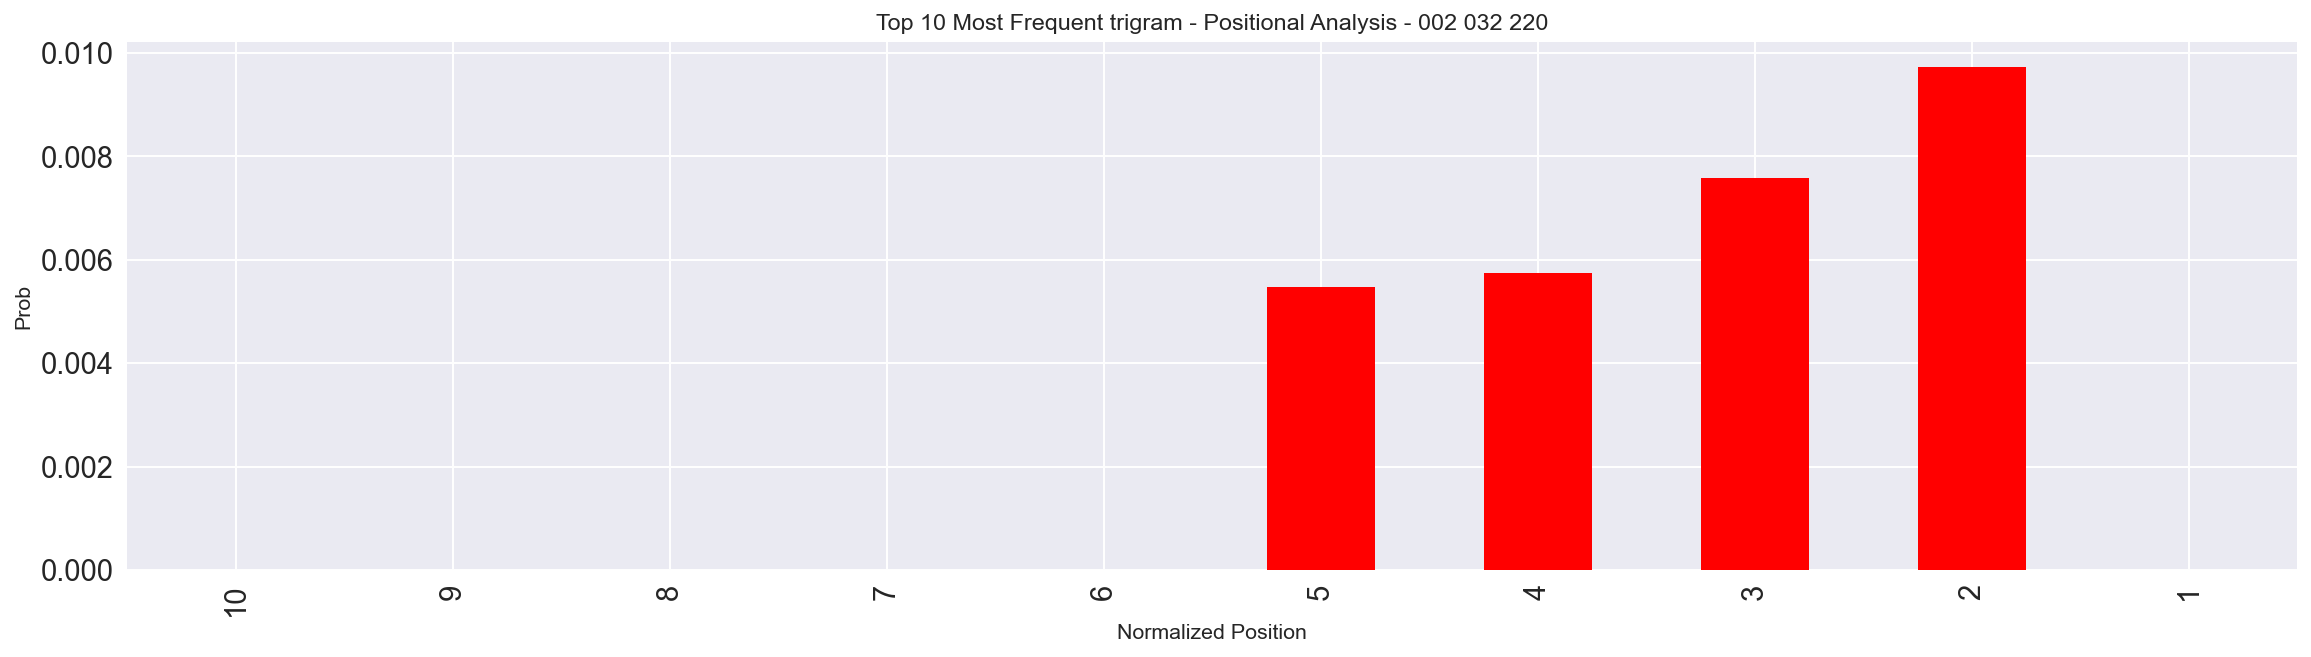

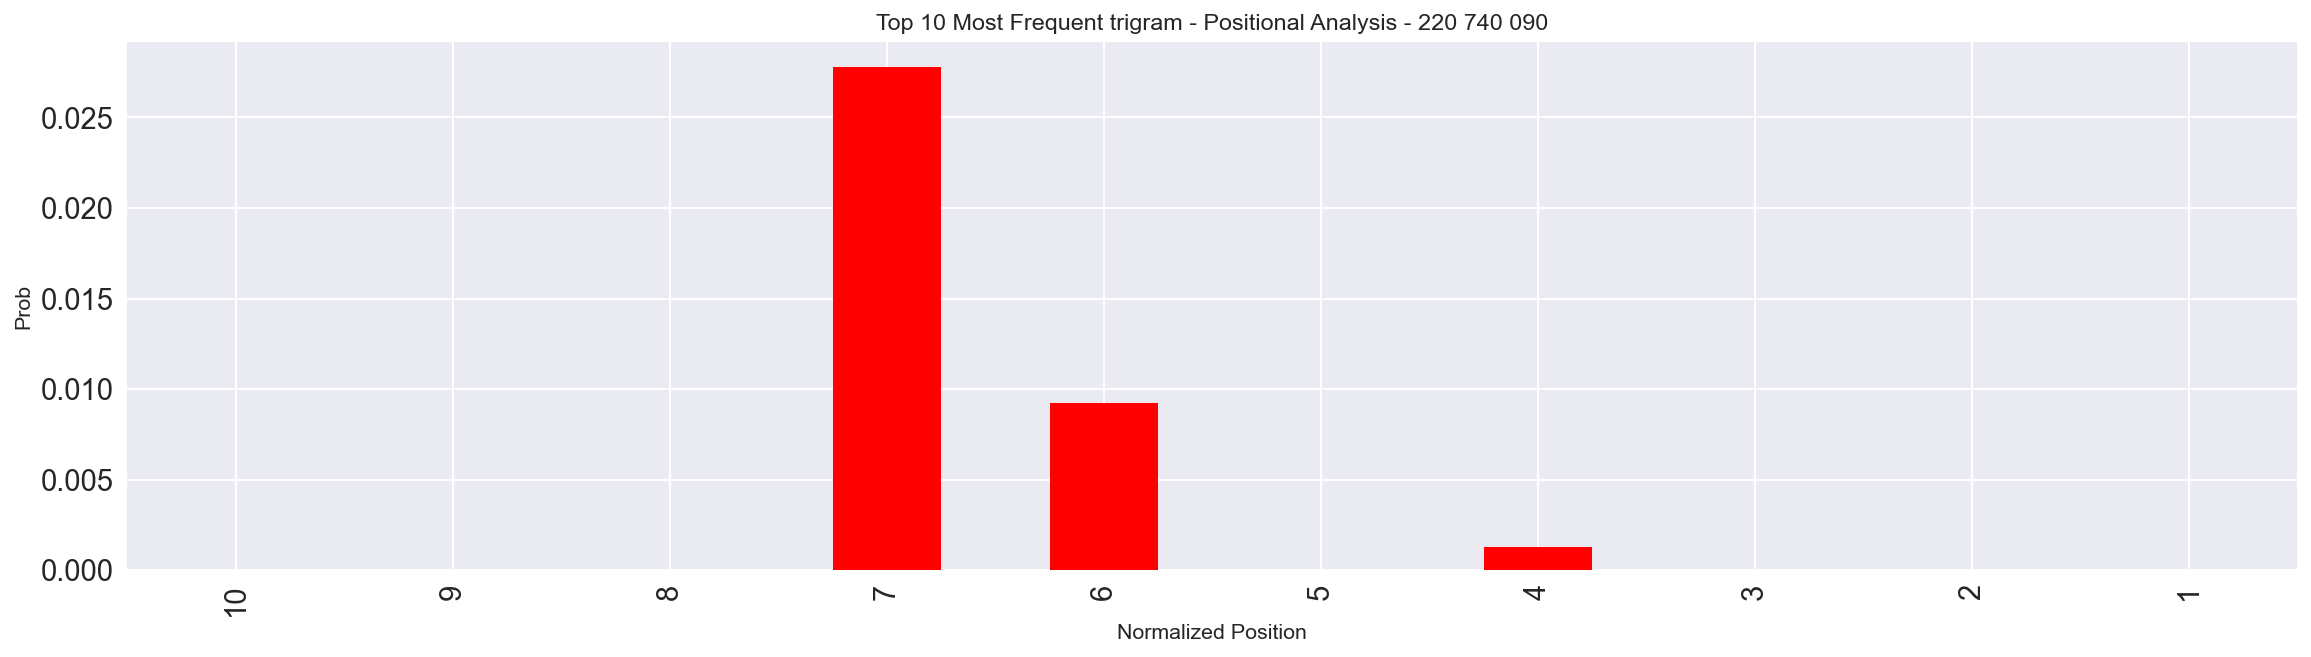

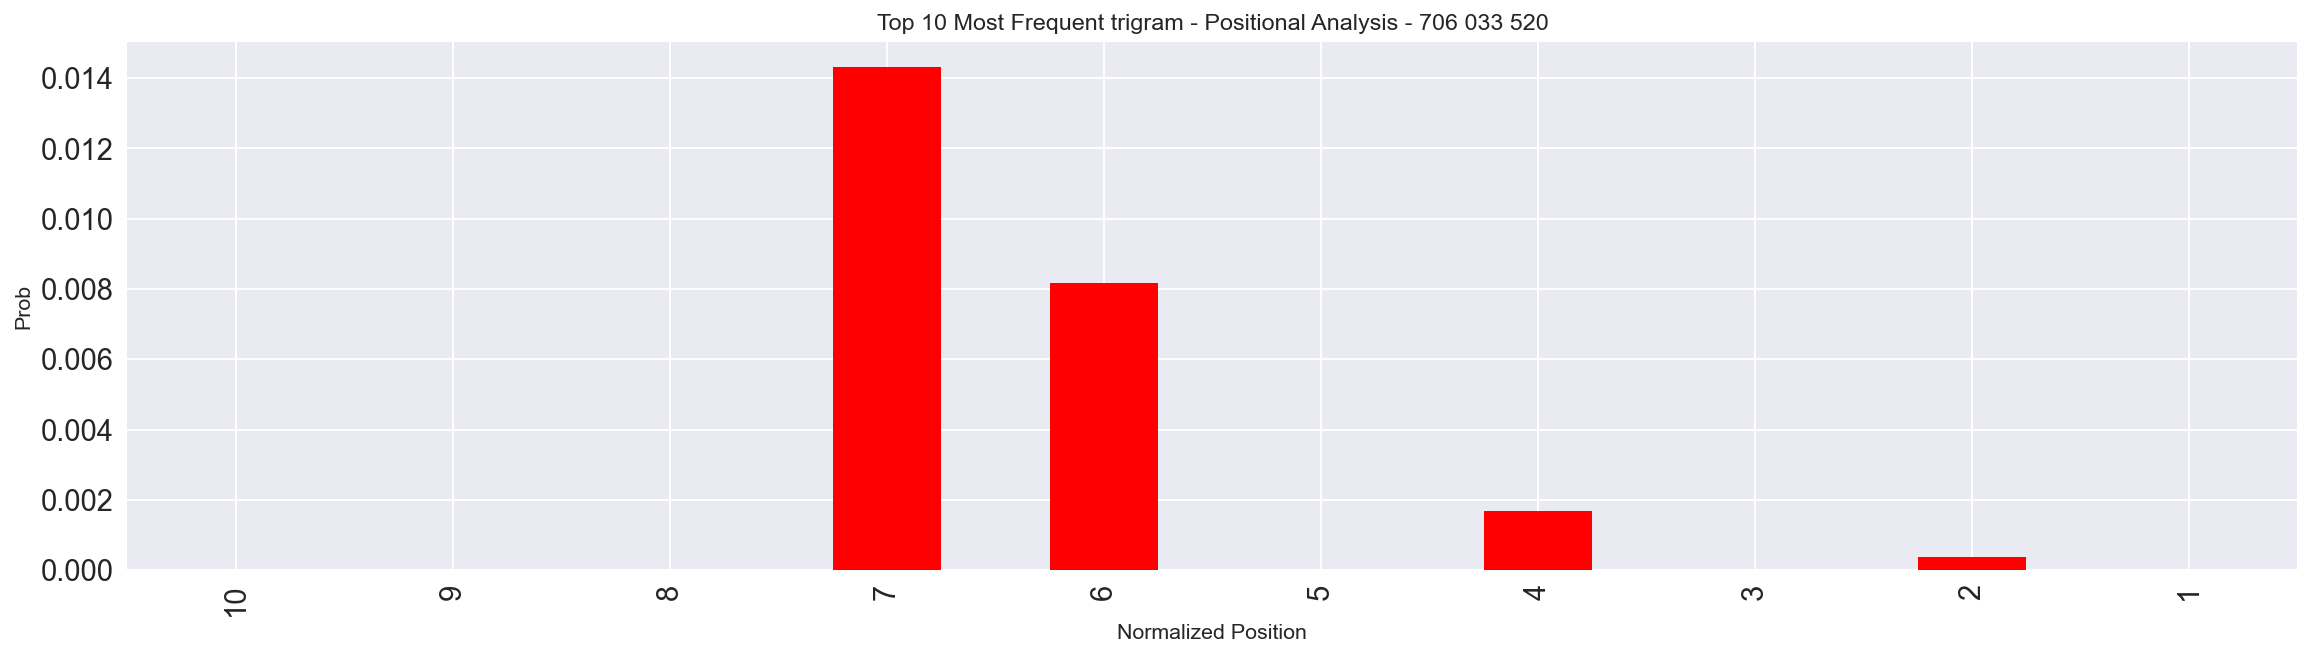

In [49]:
for trigram in pd_text_trigrams1:
    df_text_norm_position_trigrams_prob[trigram].plot(kind='bar', color='Red')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.title("Top 10 Most Frequent trigram - Positional Analysis - " + trigram)

    plt.show()

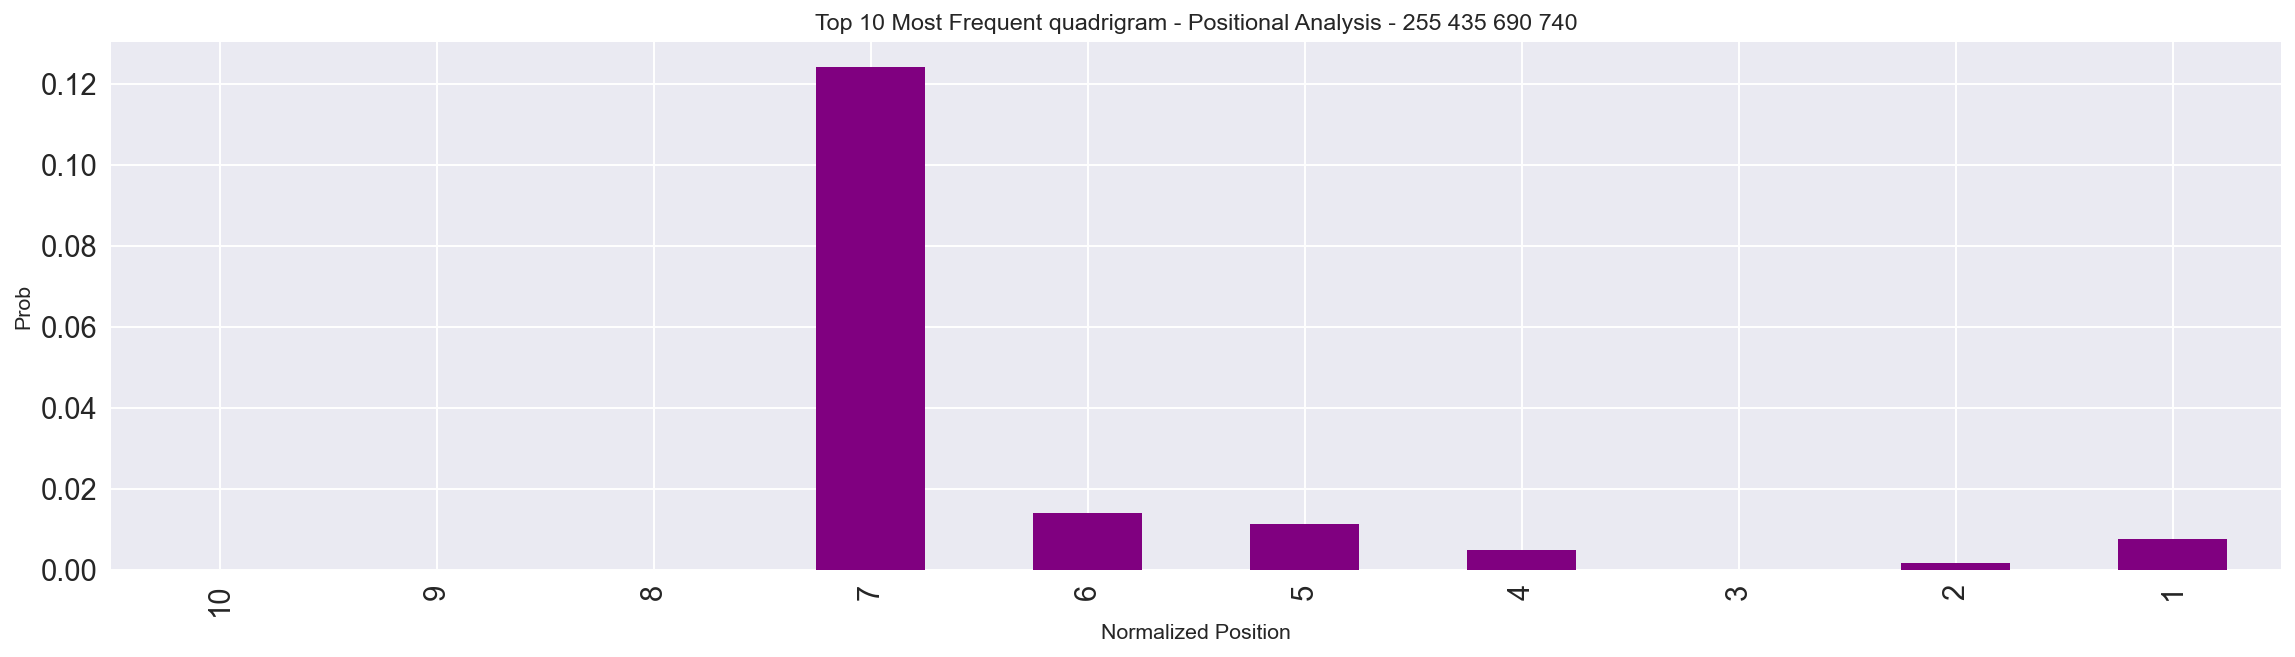

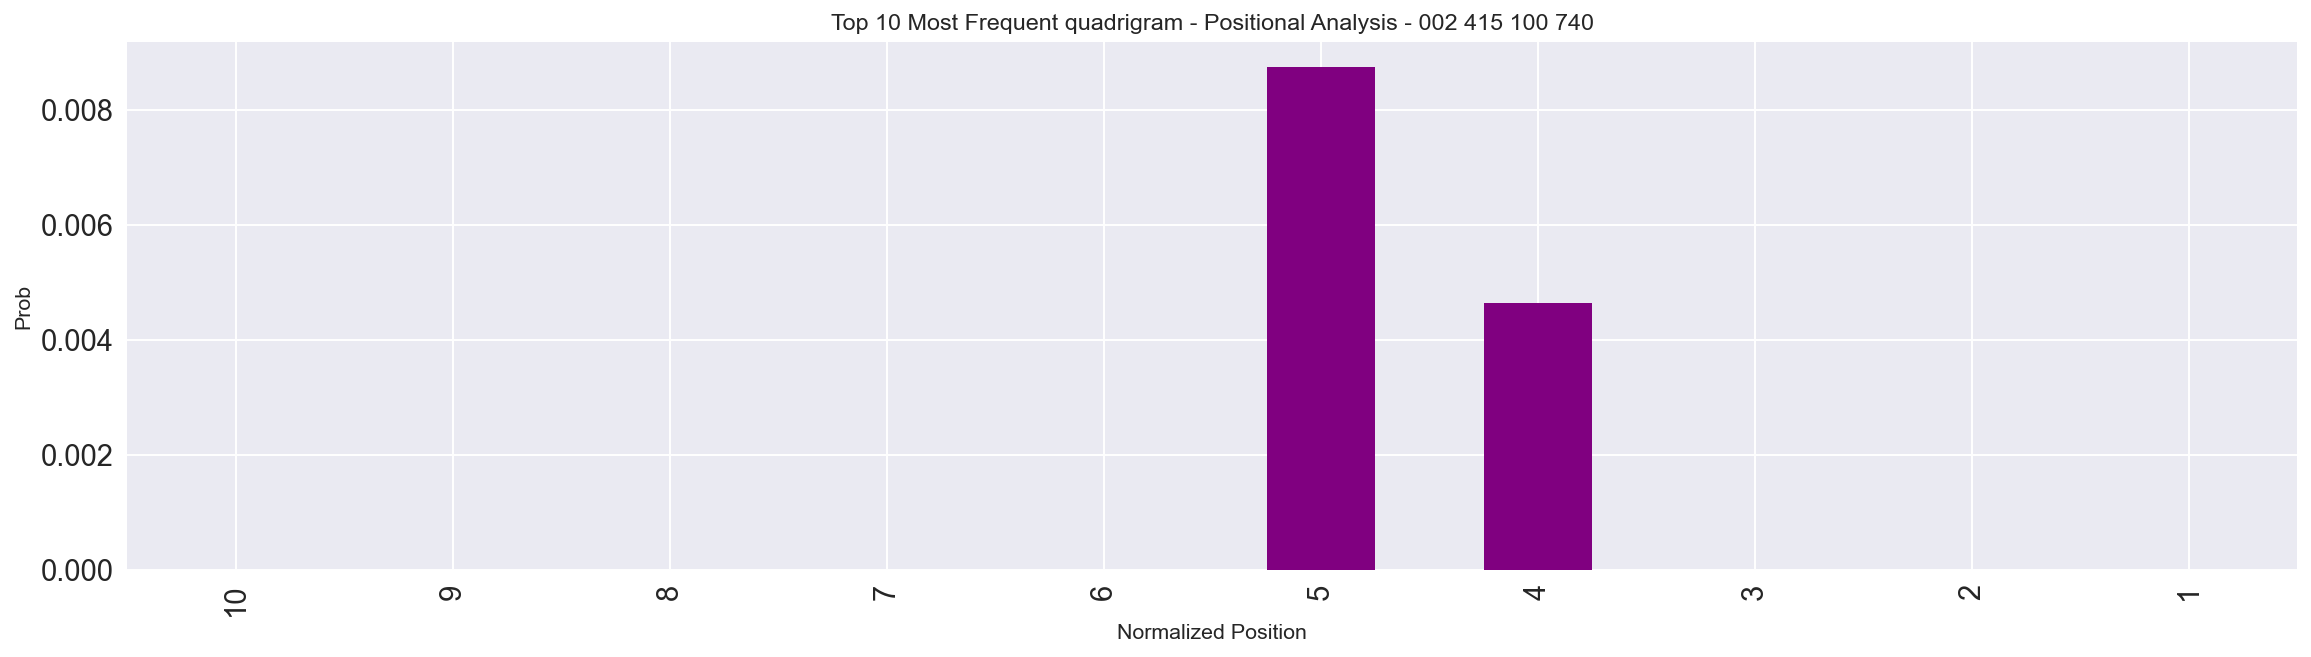

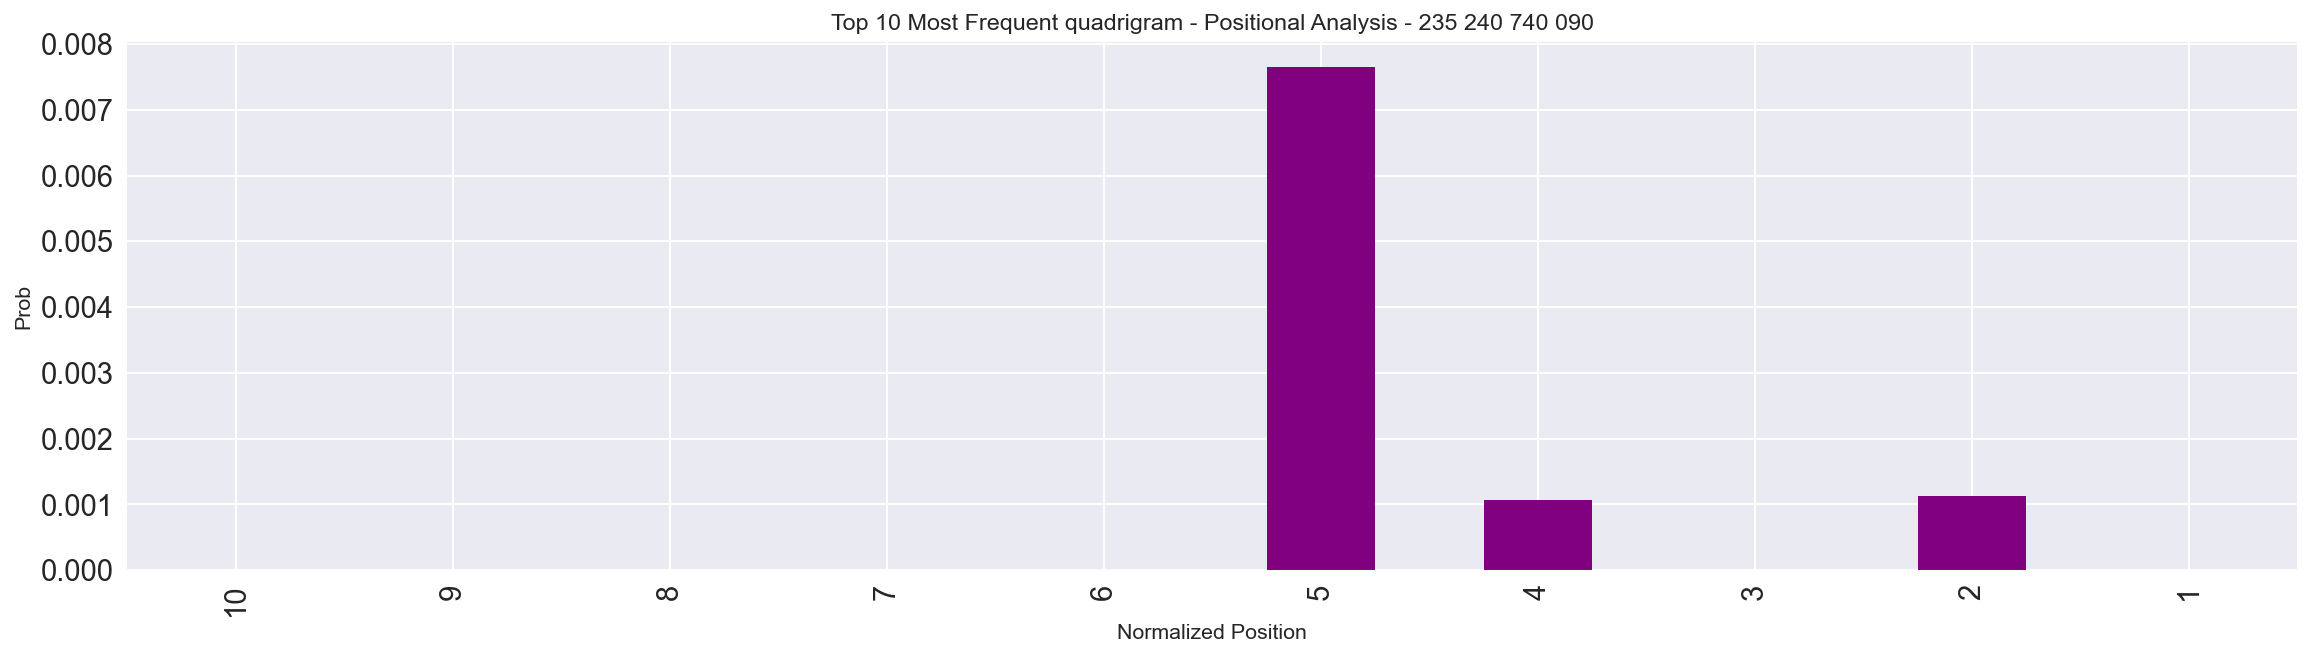

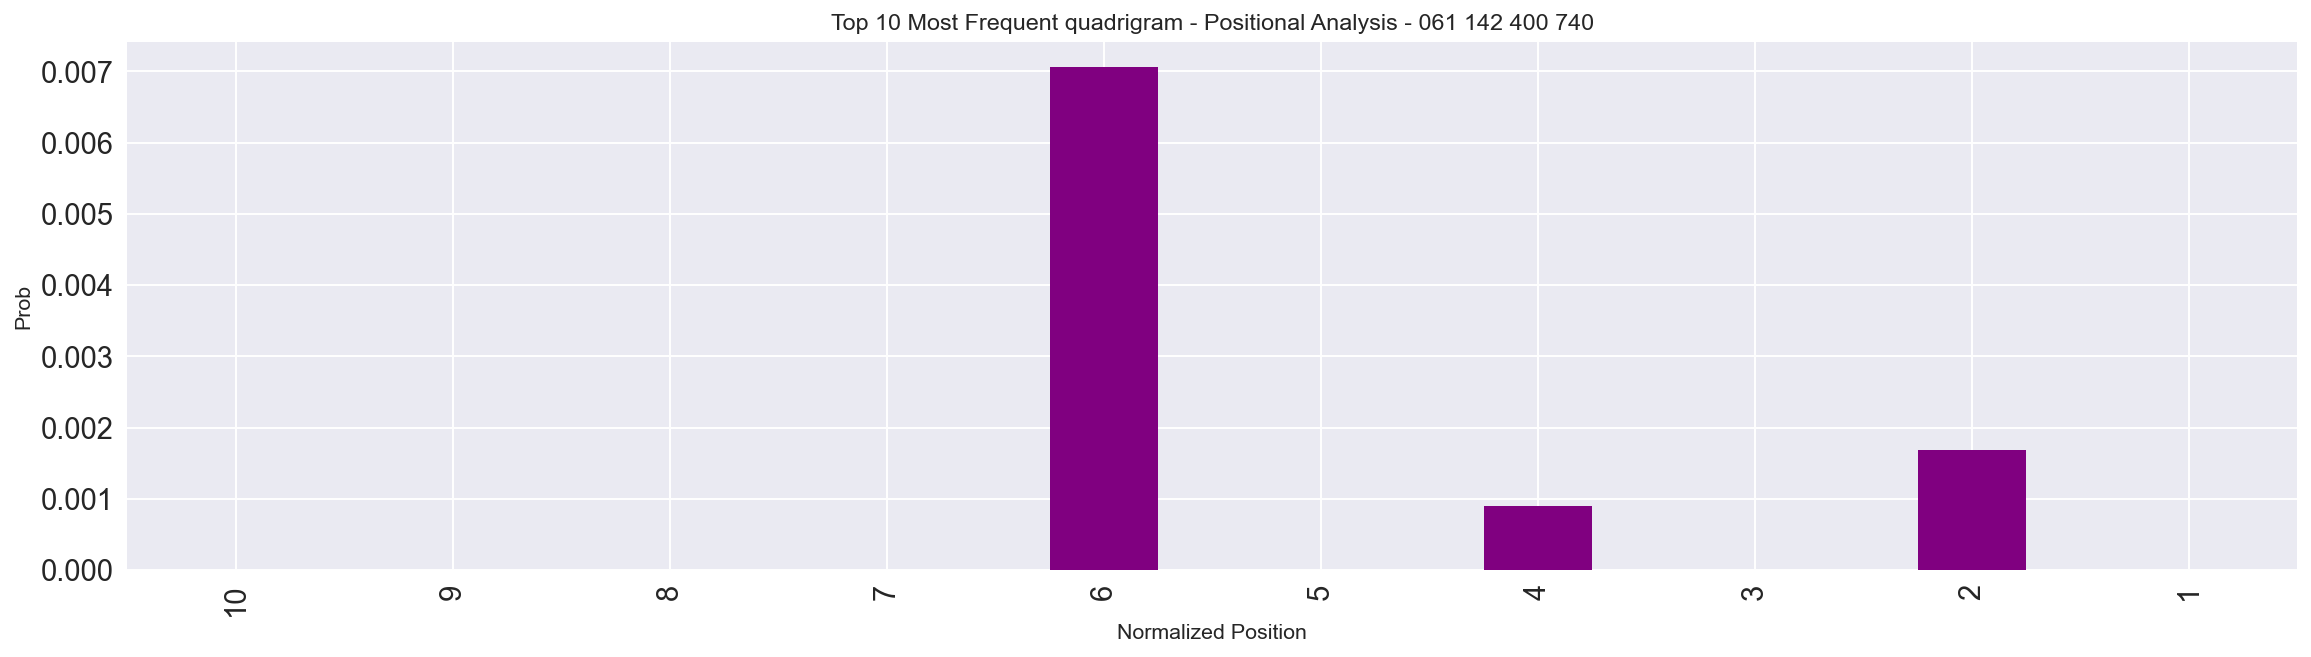

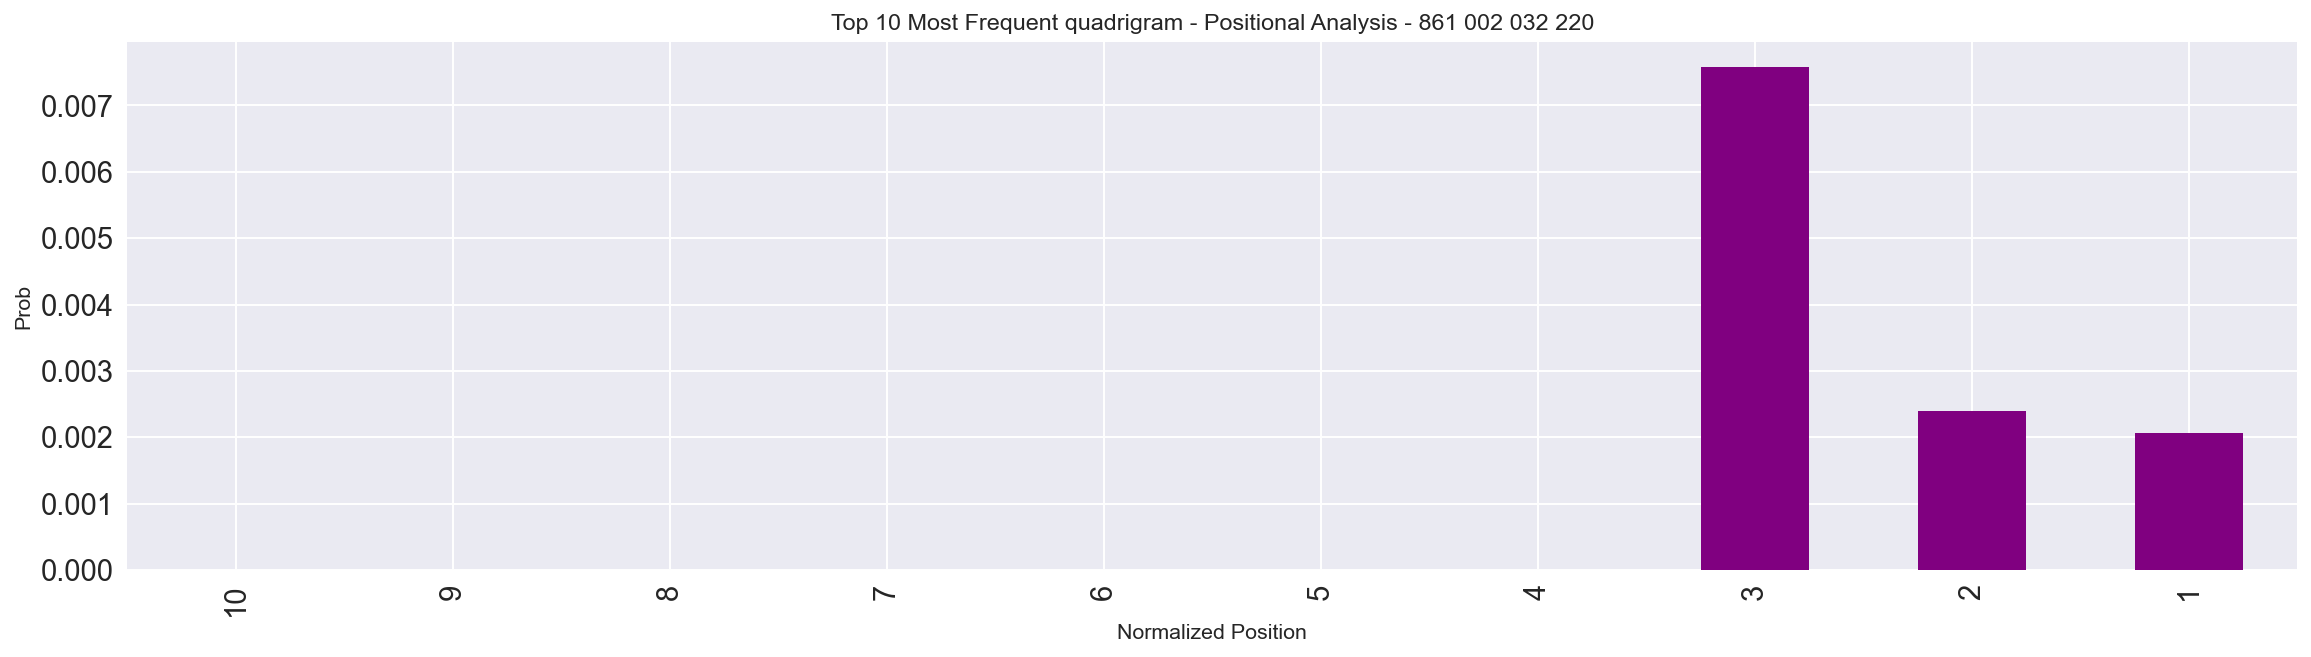

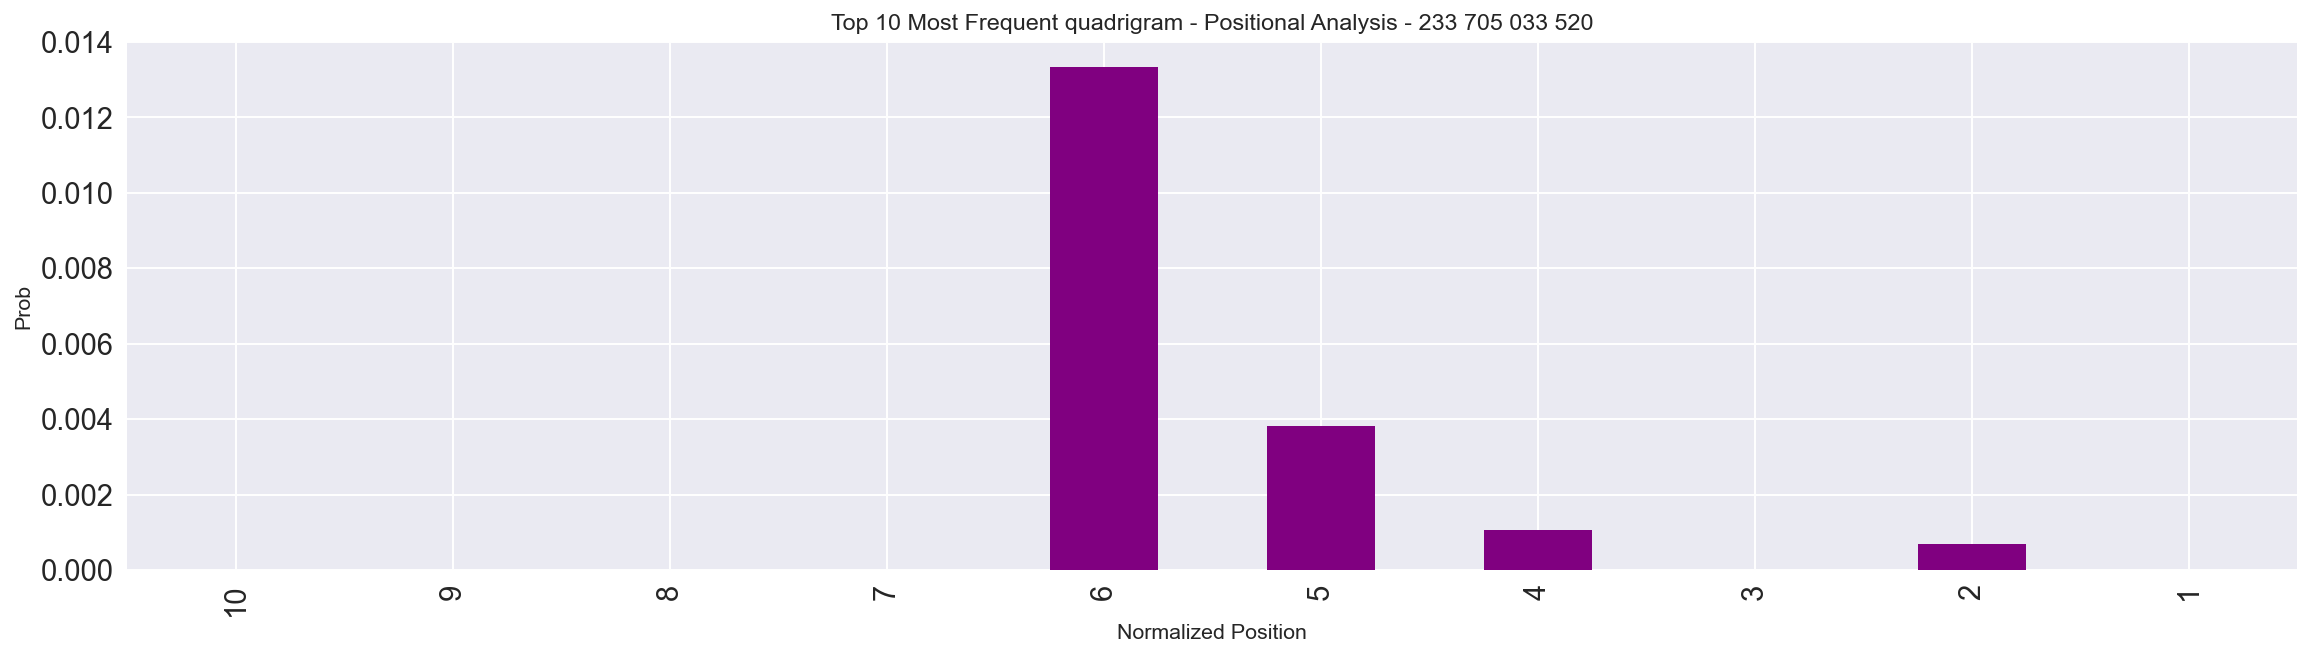

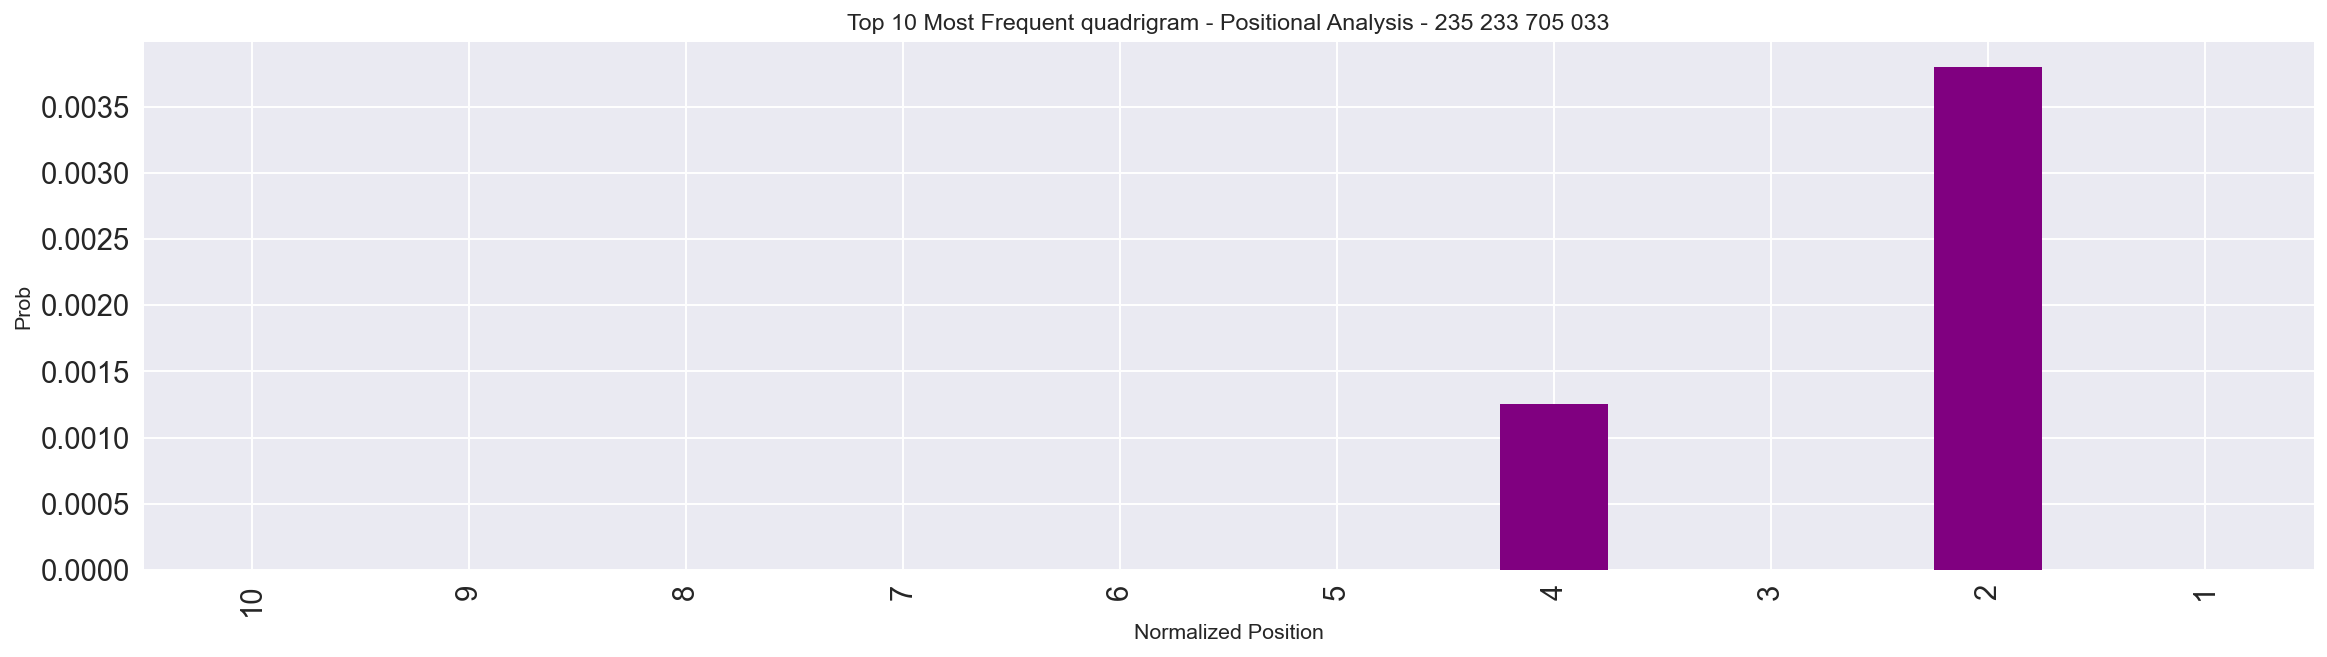

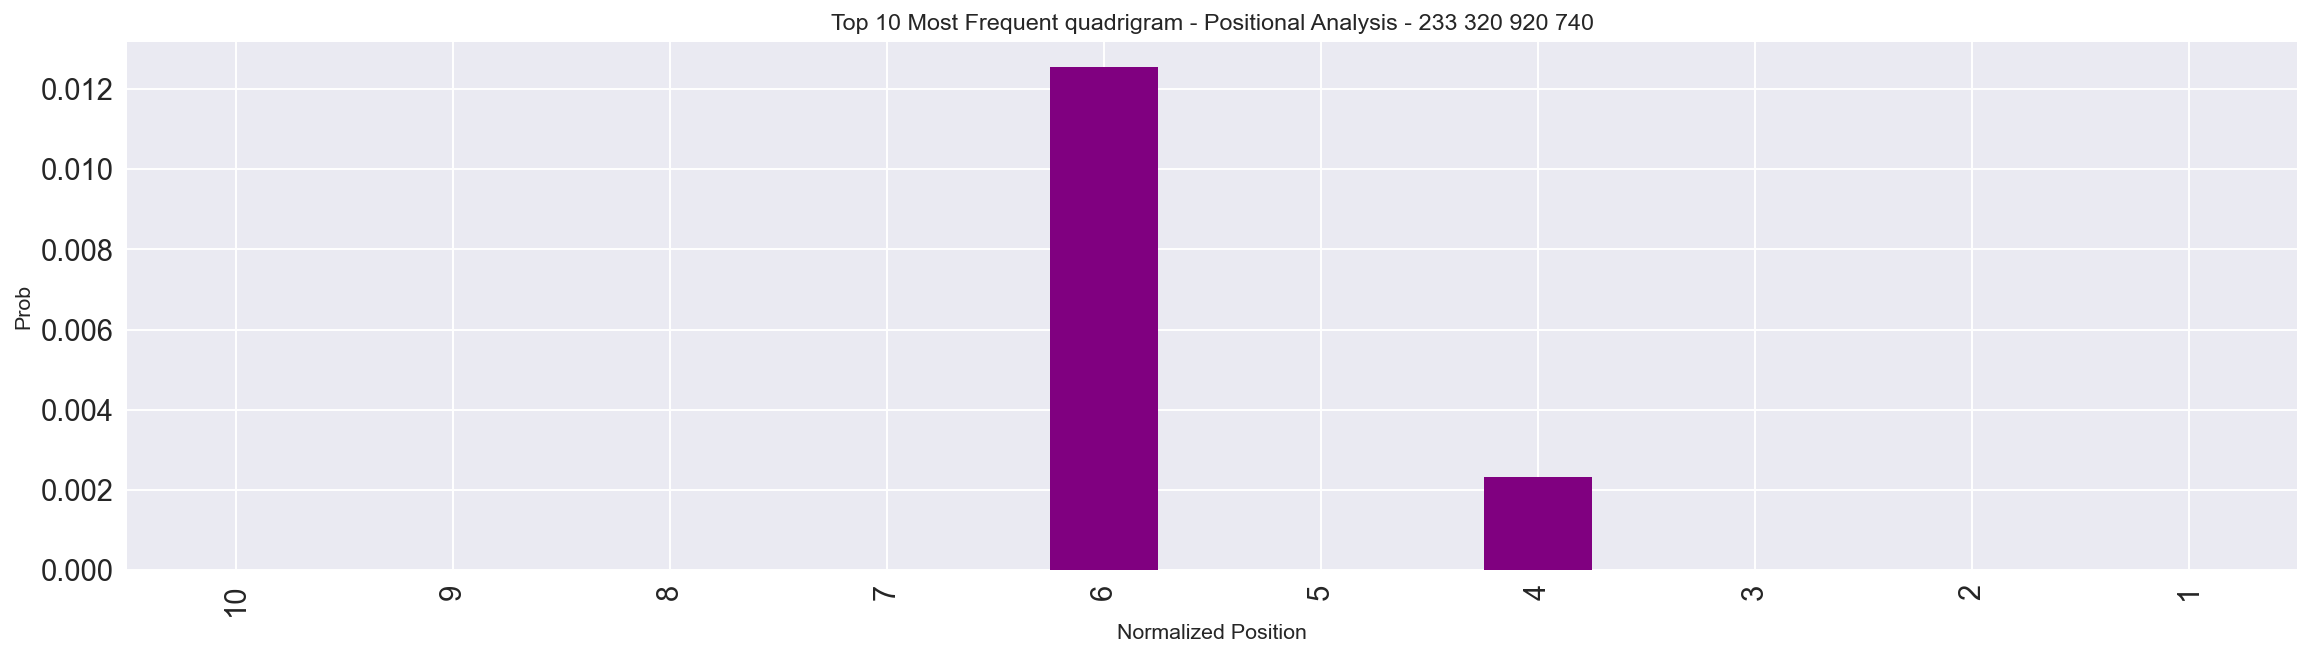

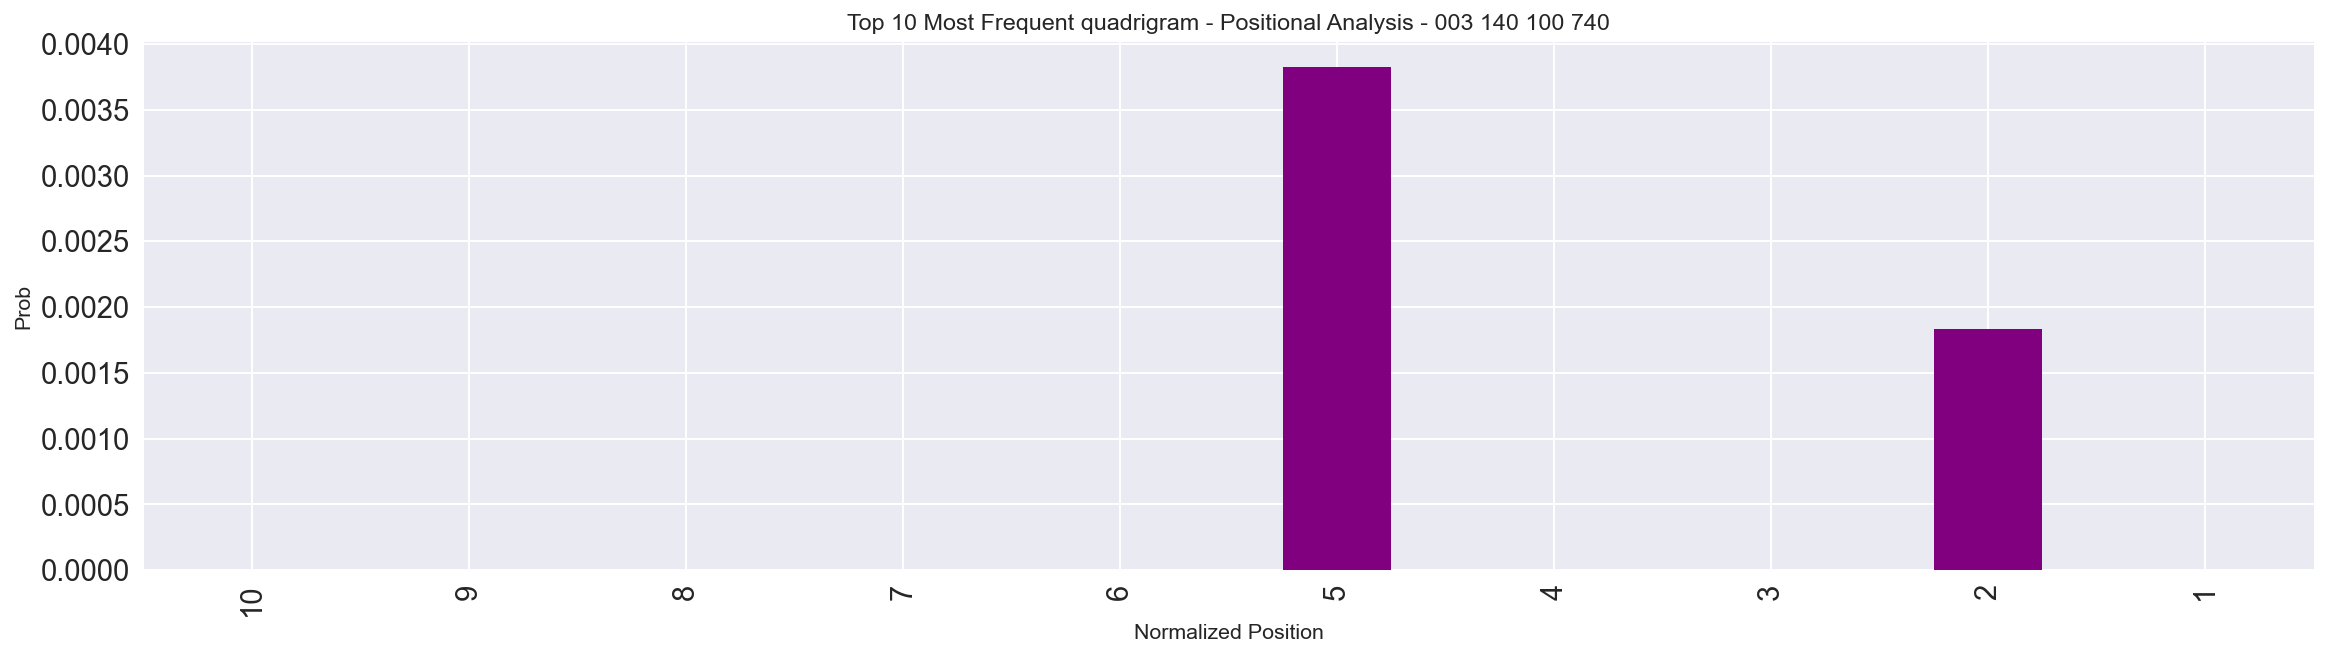

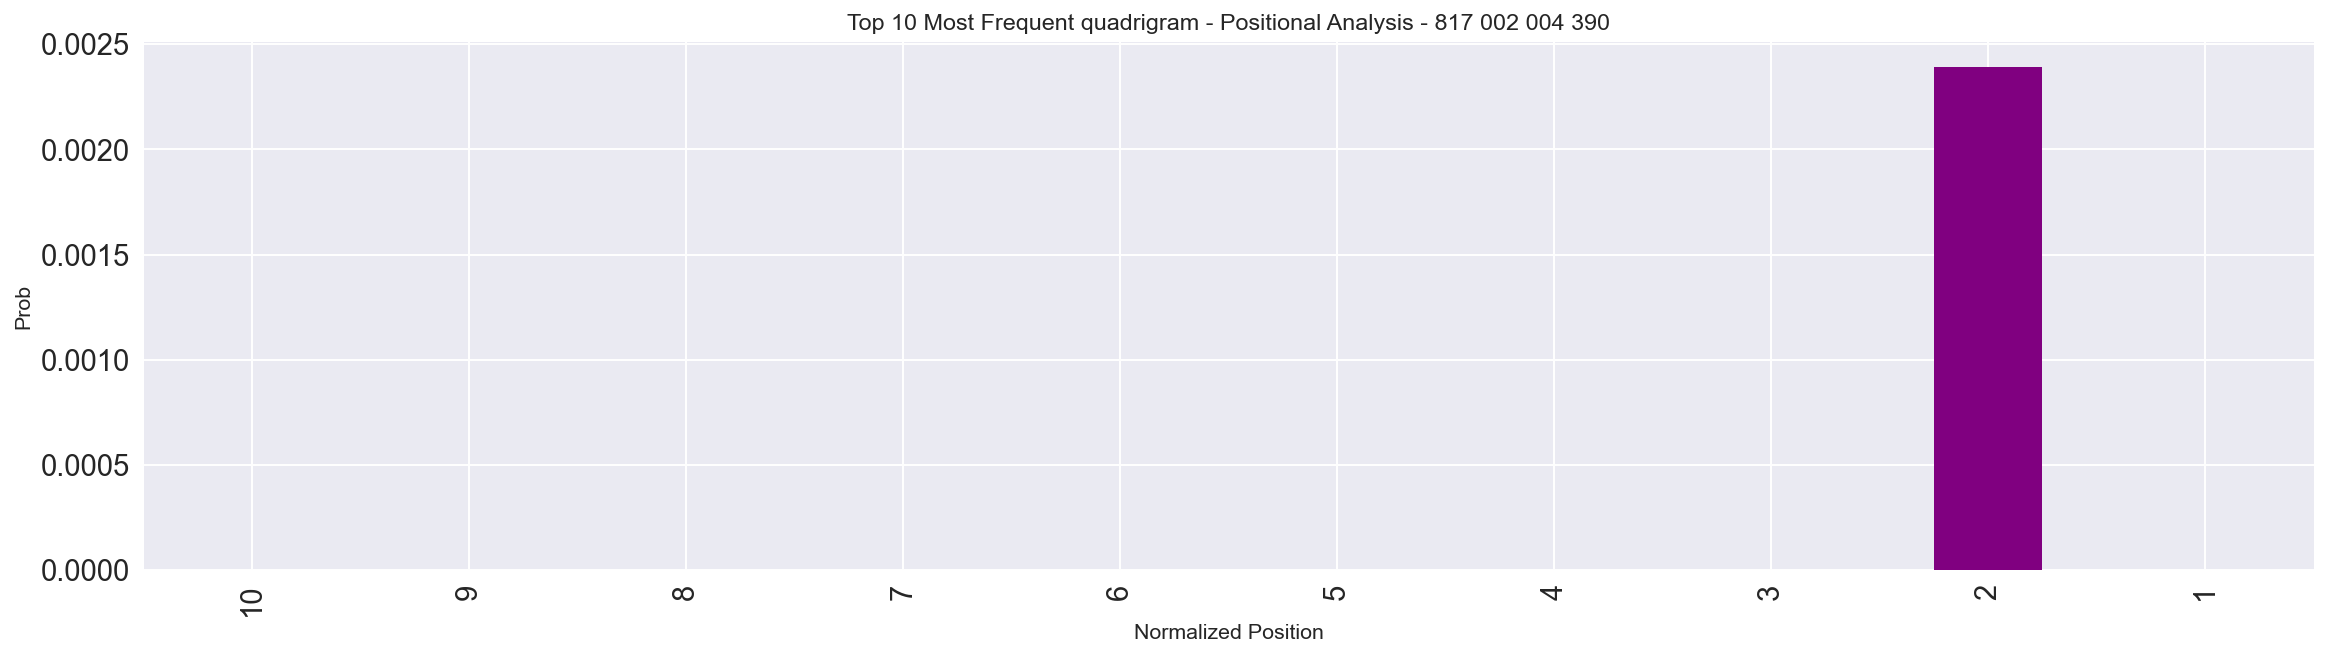

In [50]:
for quadrigram in pd_text_quadrigrams1:
    df_text_norm_position_quadrigrams_prob[quadrigram].plot(kind='bar', color='purple')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.title("Top 10 Most Frequent quadrigram - Positional Analysis - " + quadrigram)

    plt.show()

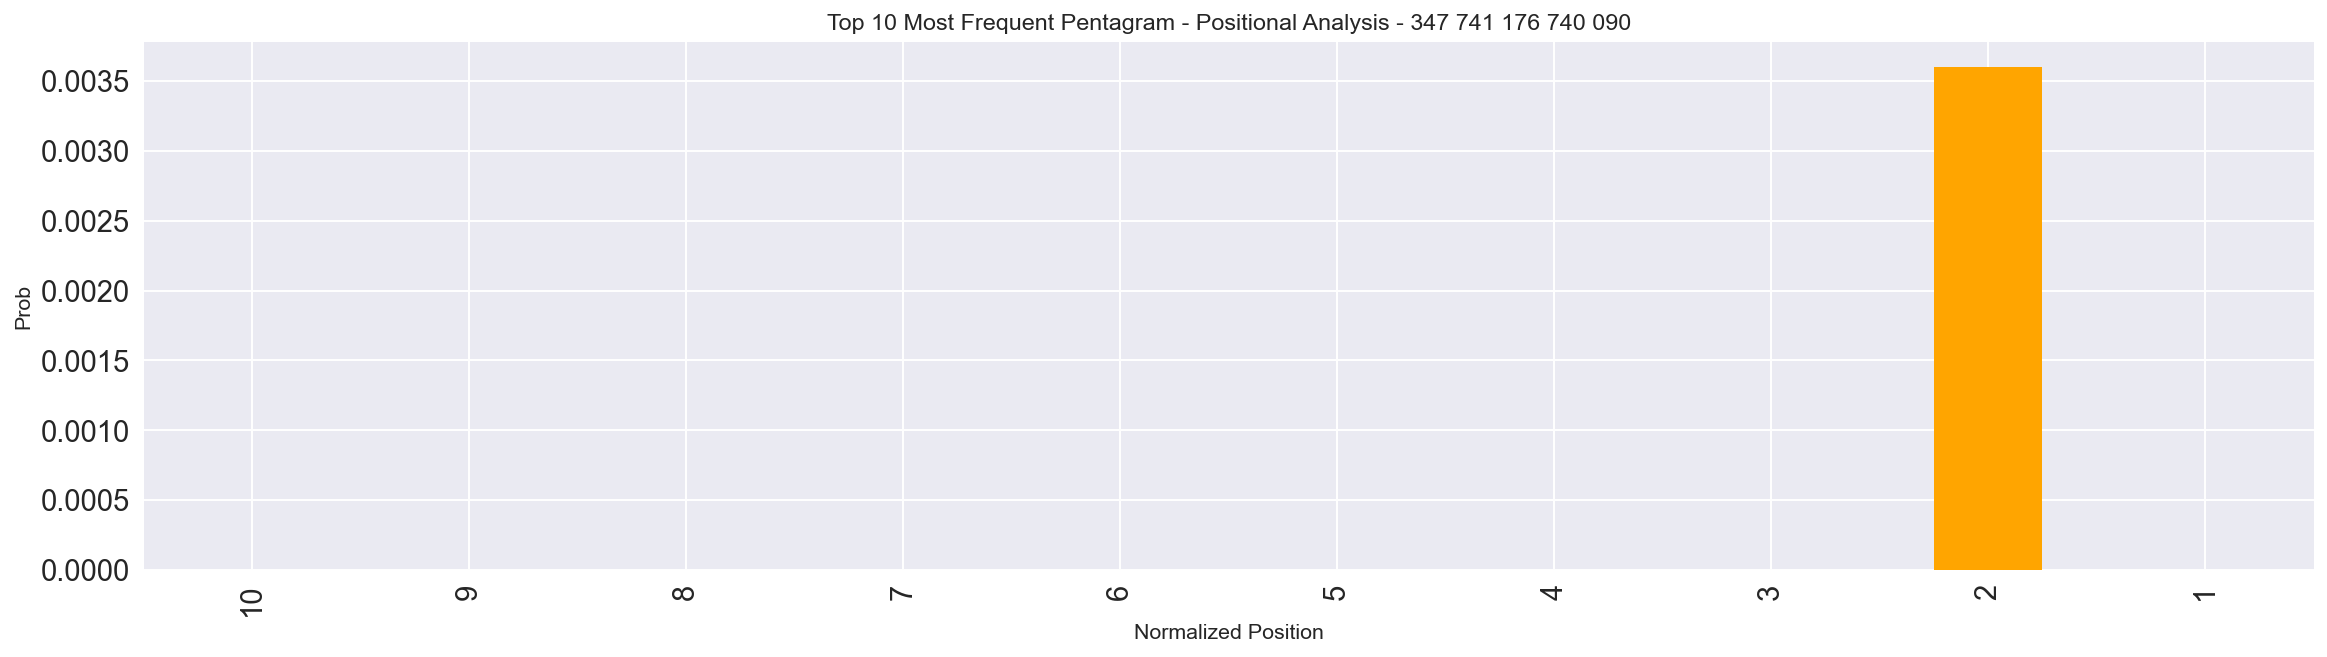

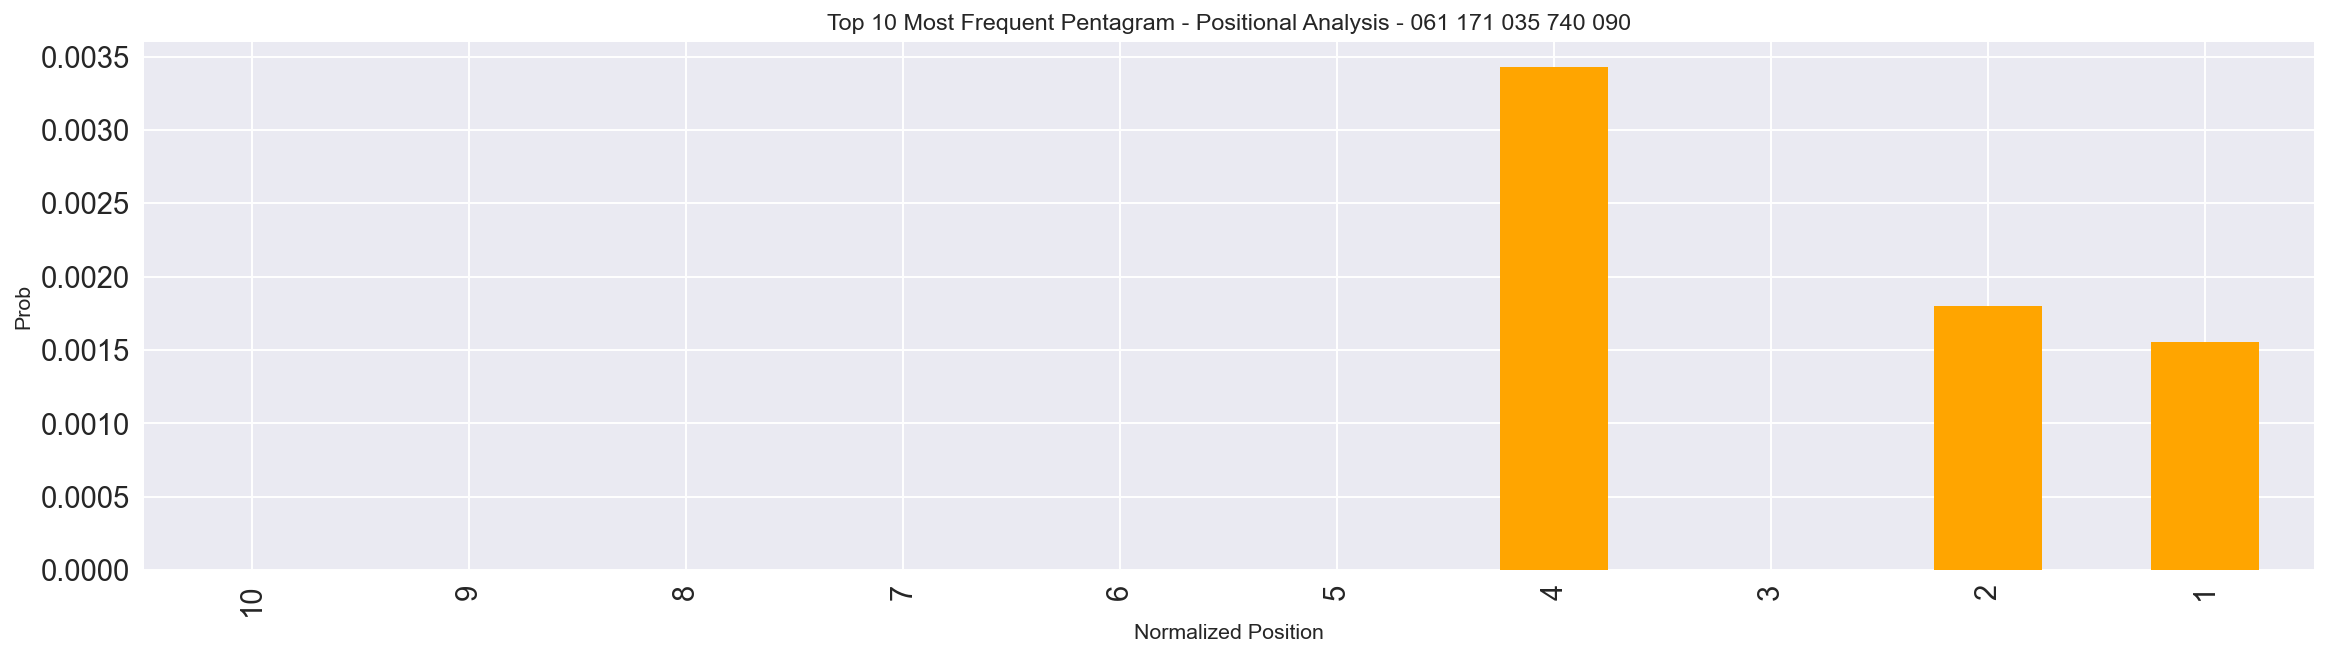

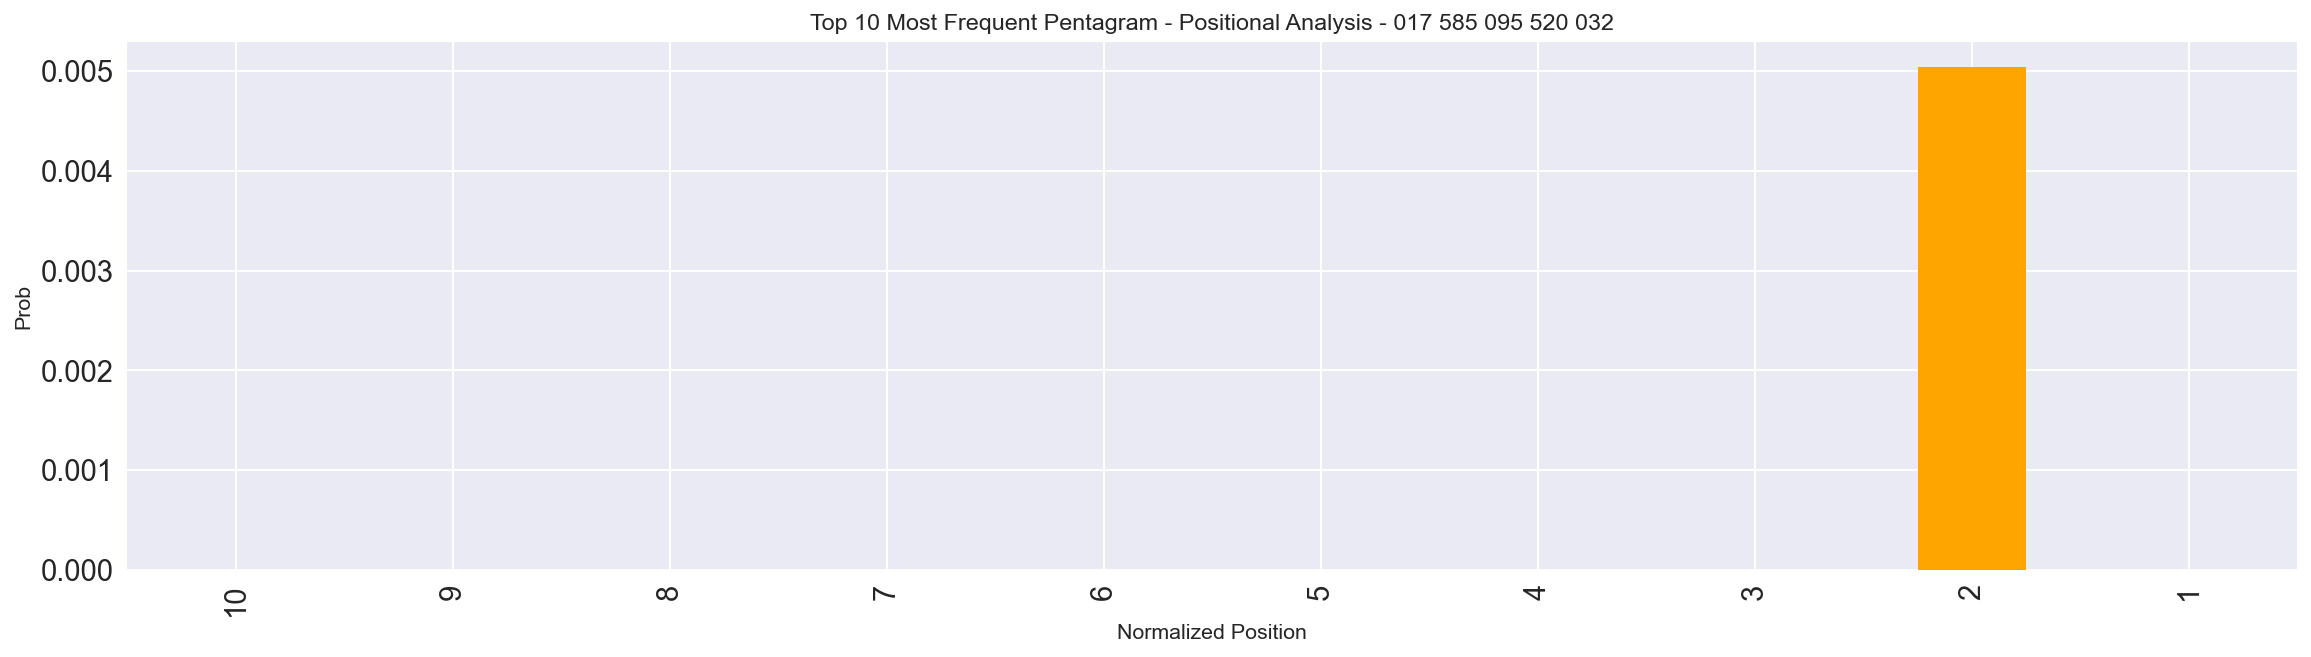

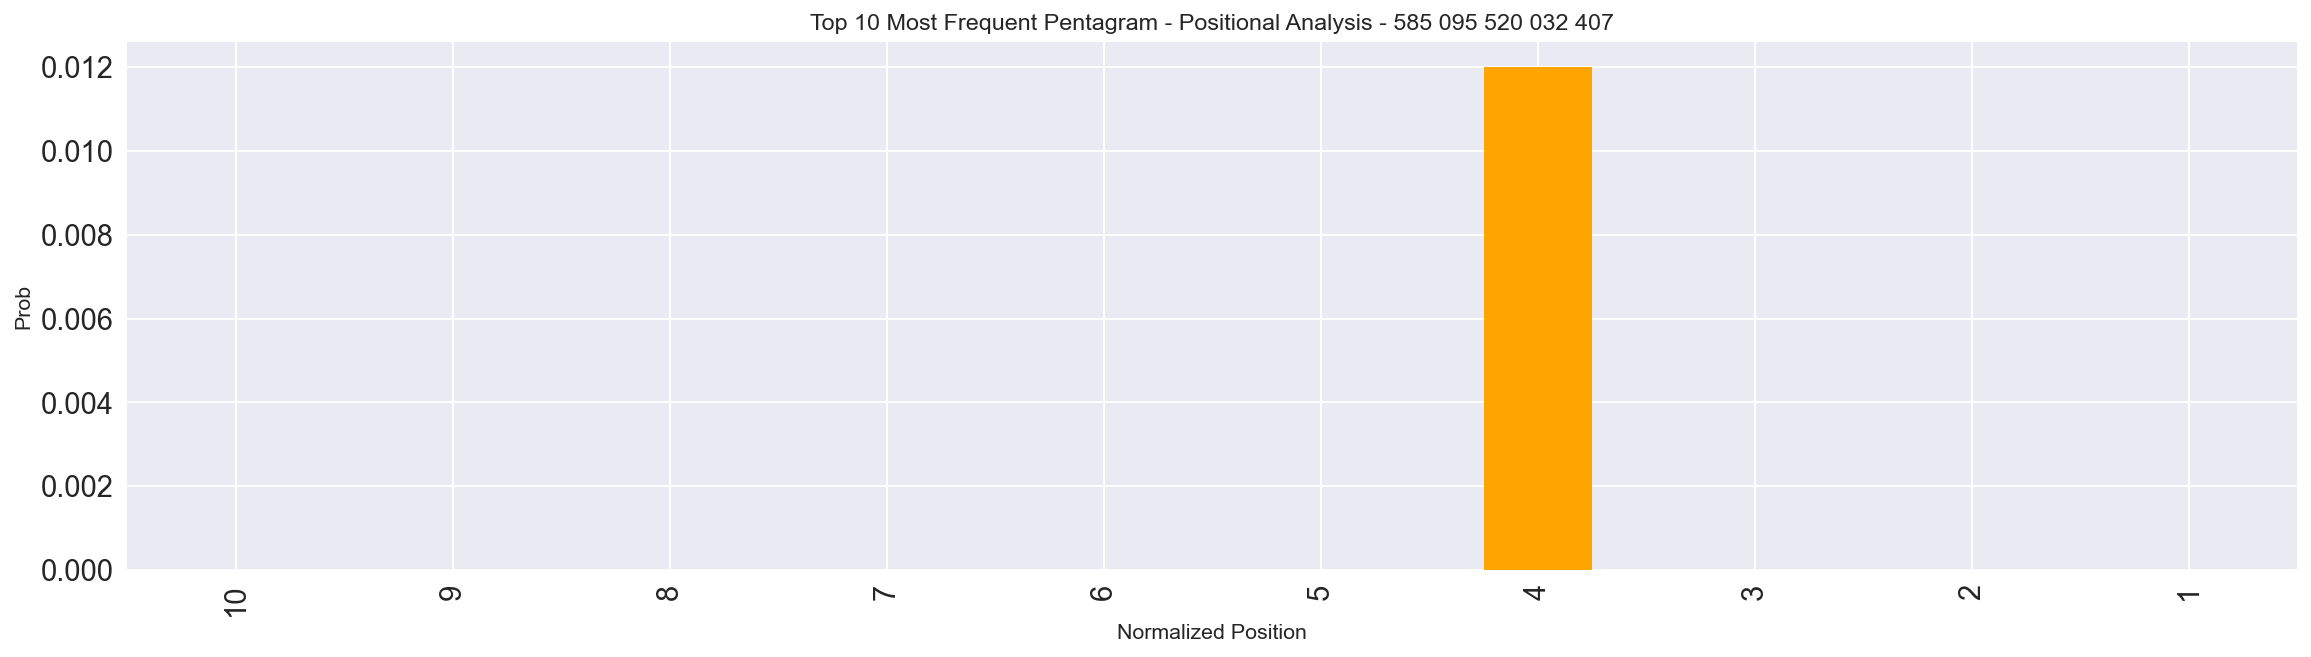

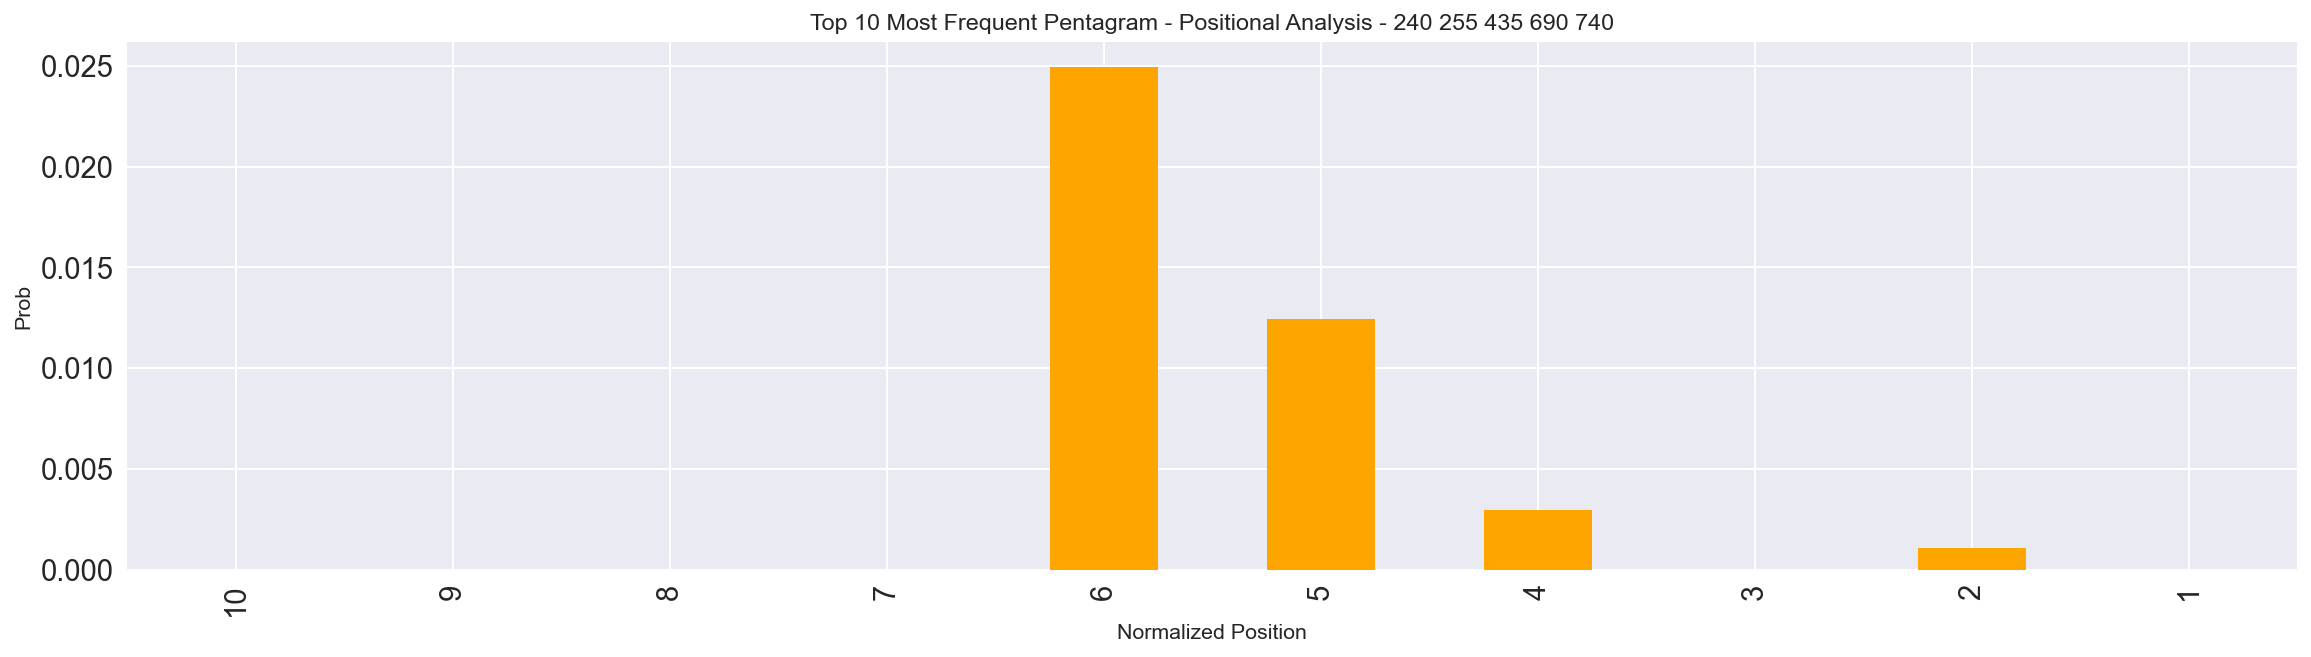

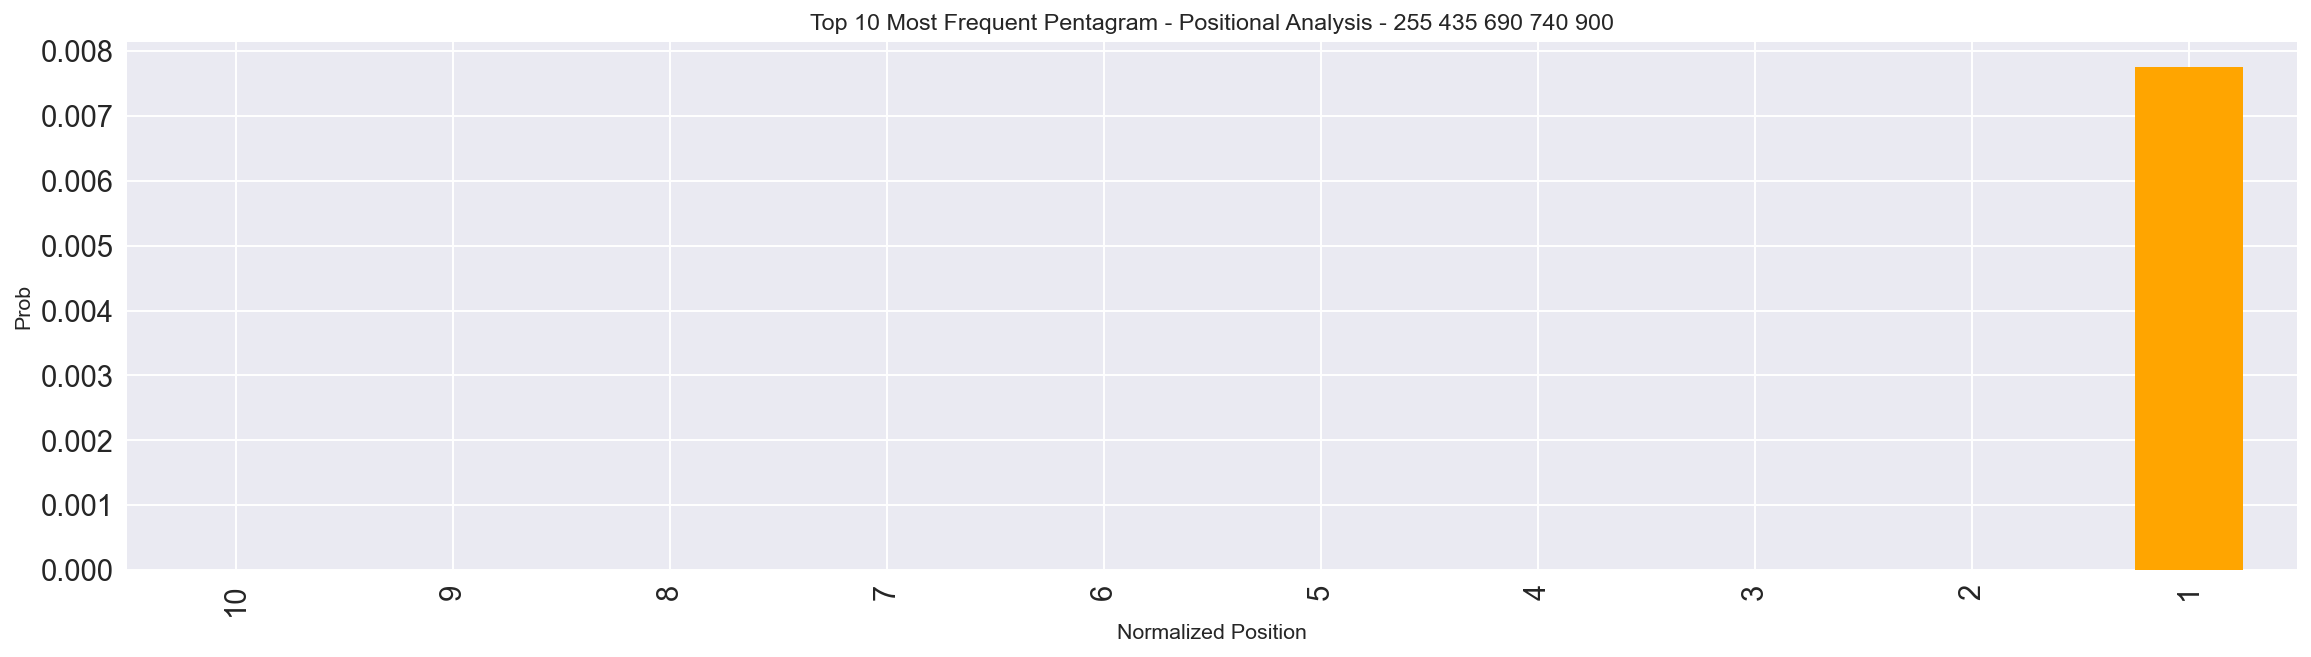

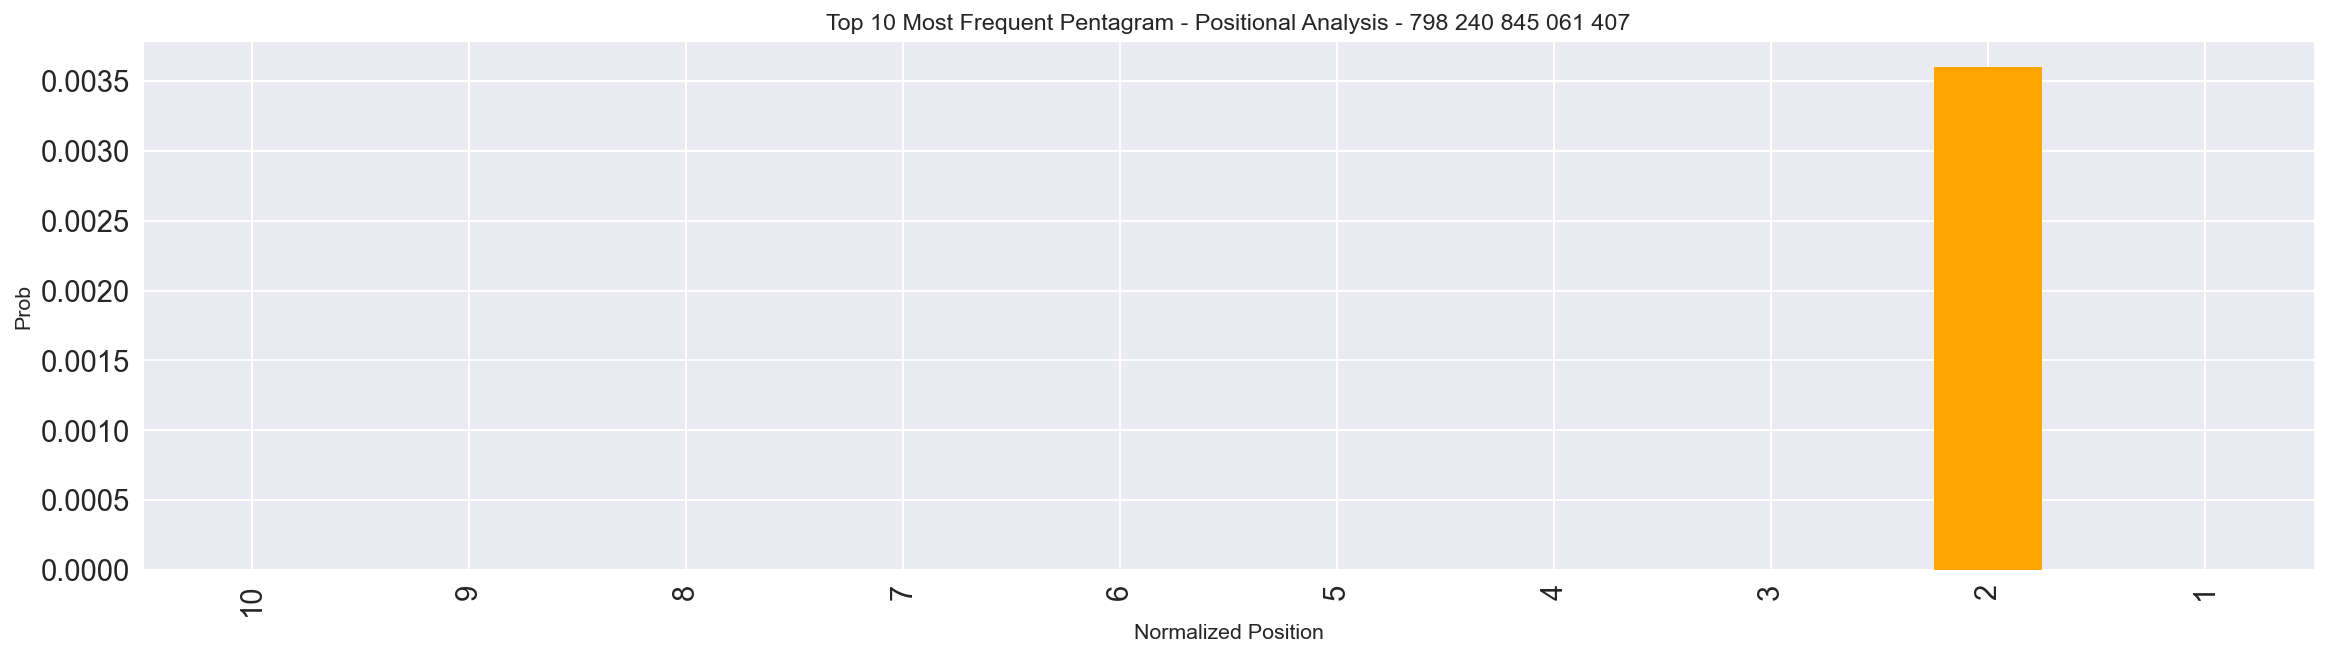

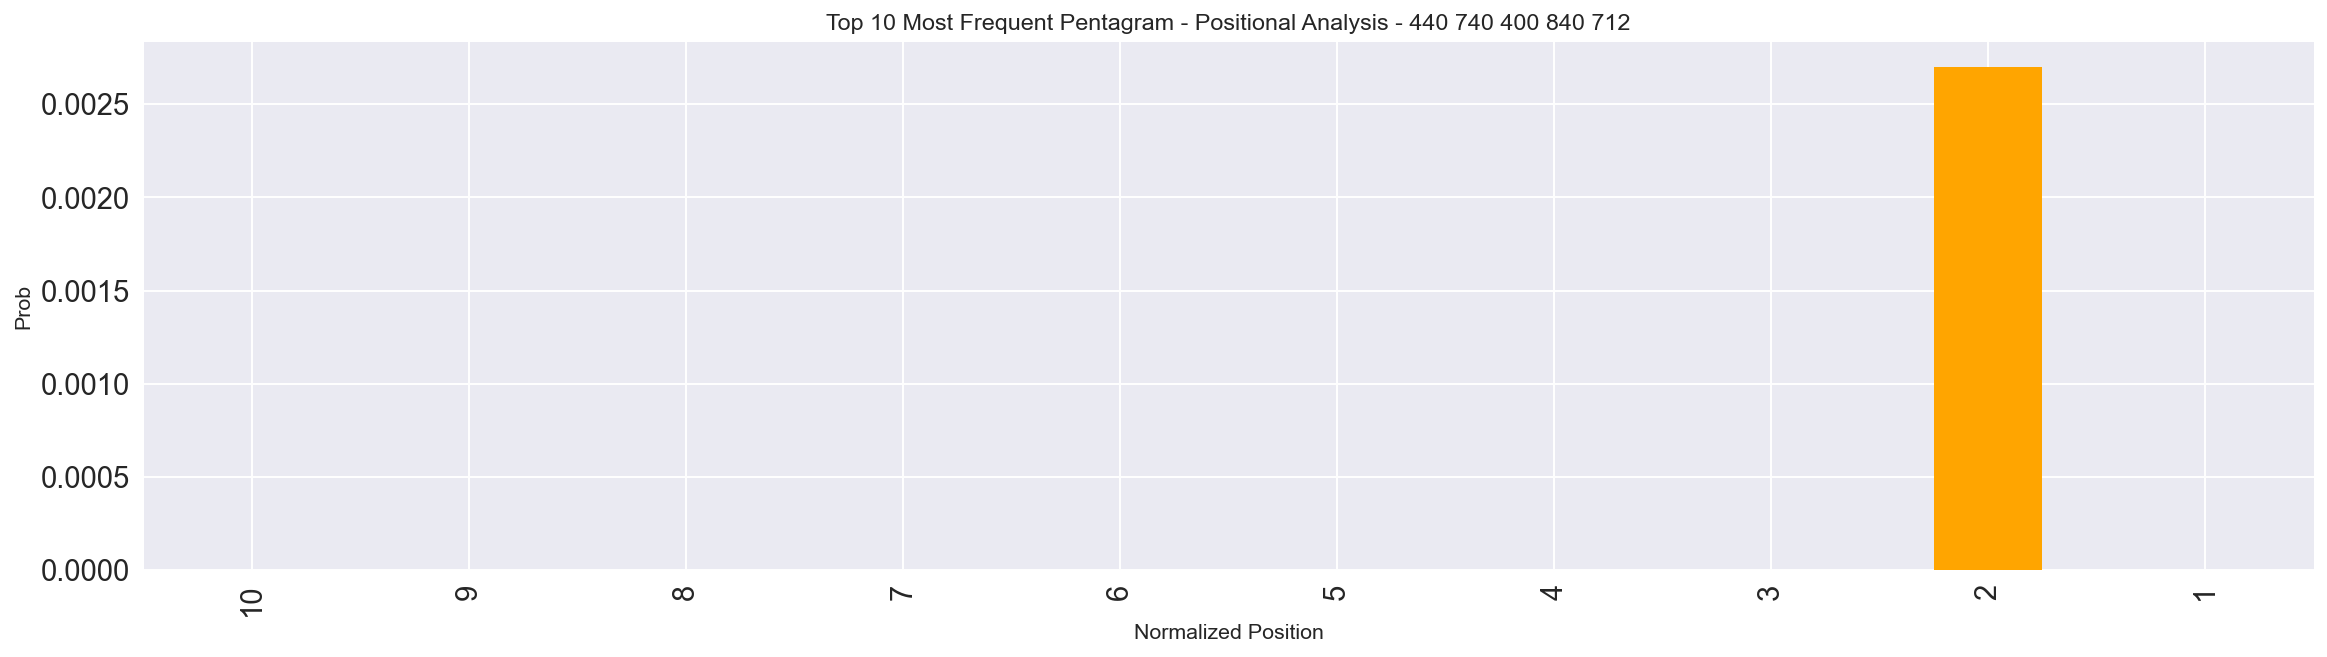

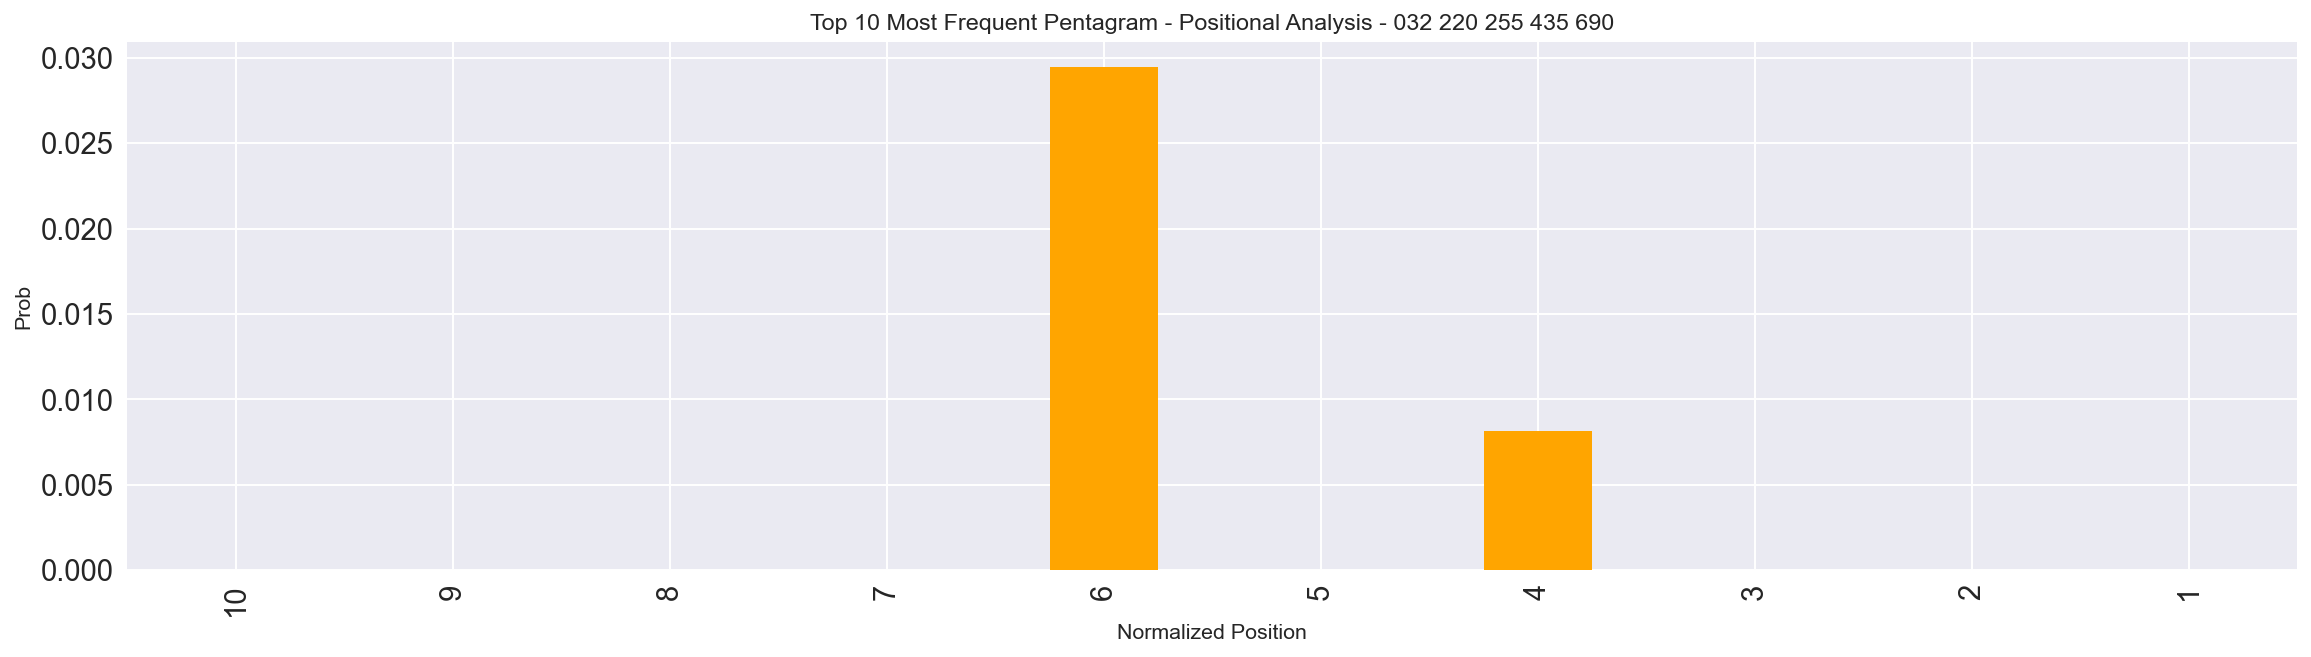

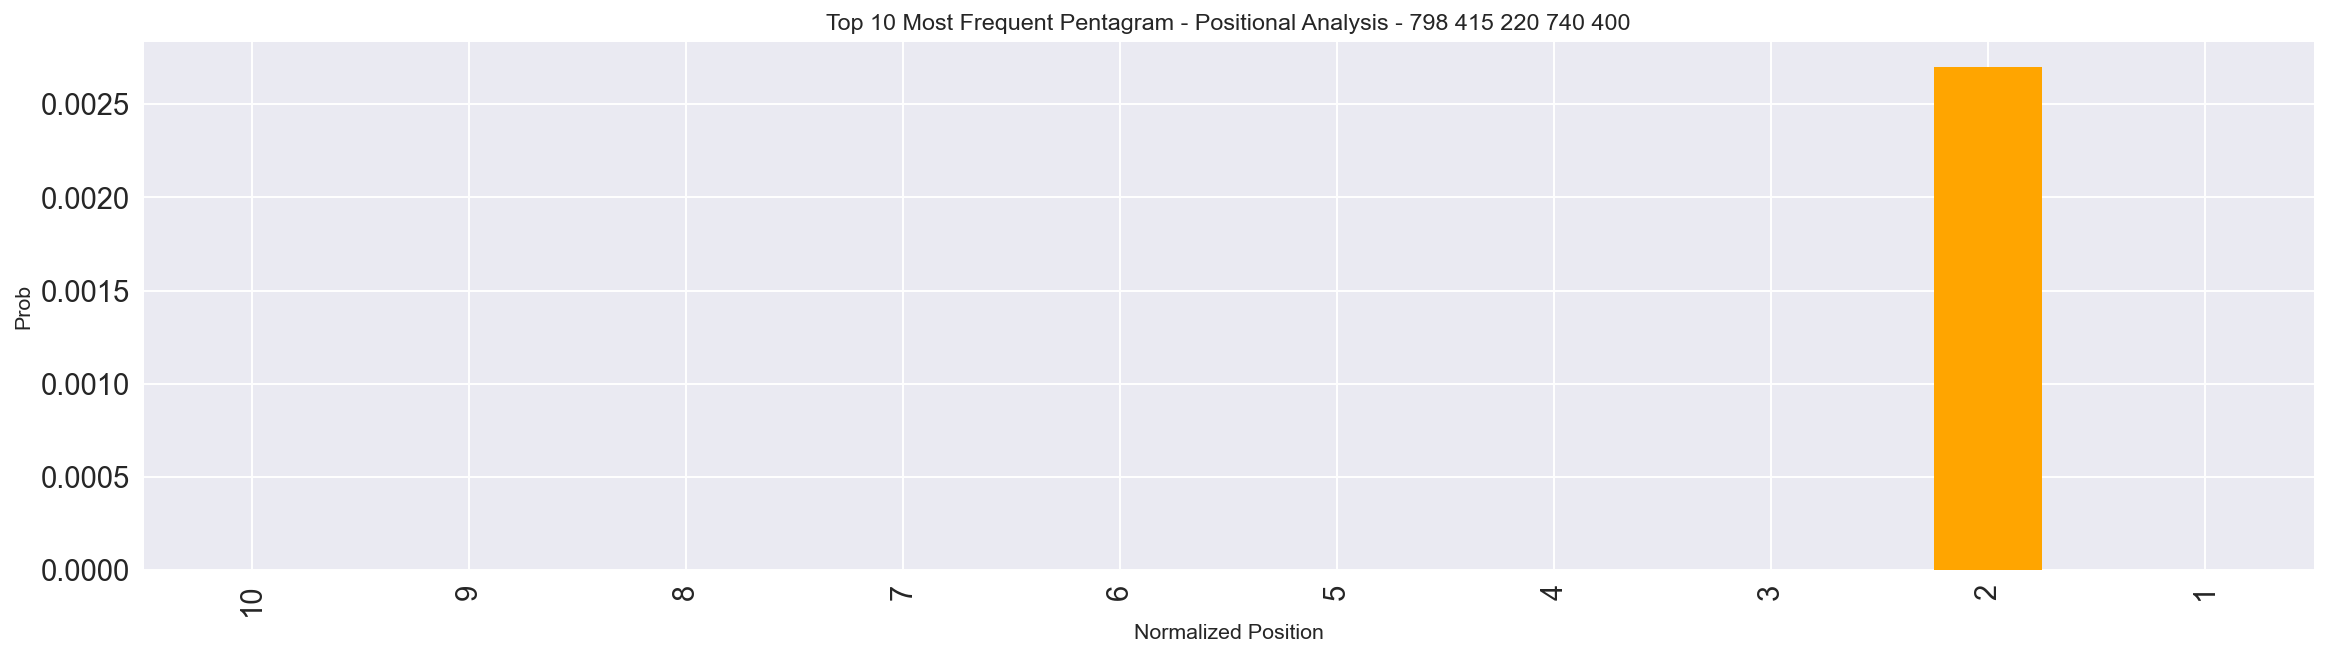

In [51]:
for pentagram in pd_text_pentagrams1:
    df_text_norm_position_pentagrams_prob[pentagram].plot(kind='bar', color='orange')
    
    plt.xlabel("Normalized Position")
    plt.ylabel("Prob")
    plt.title("Top 10 Most Frequent Pentagram - Positional Analysis - " + pentagram)

    plt.show()

# Frequency of Unigram by Position

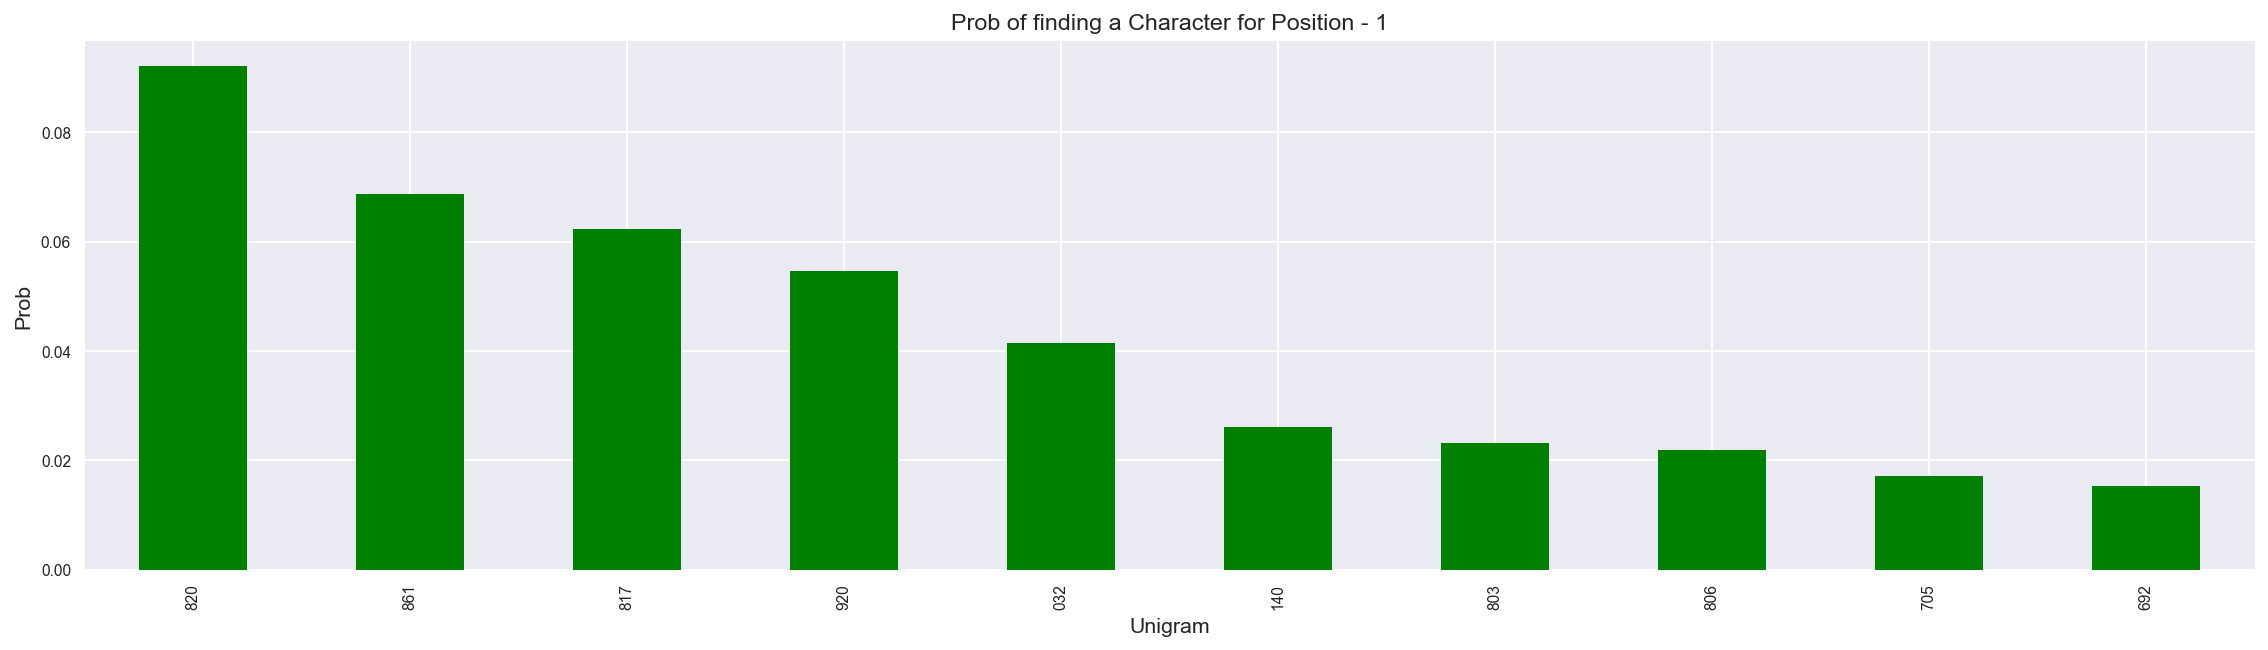

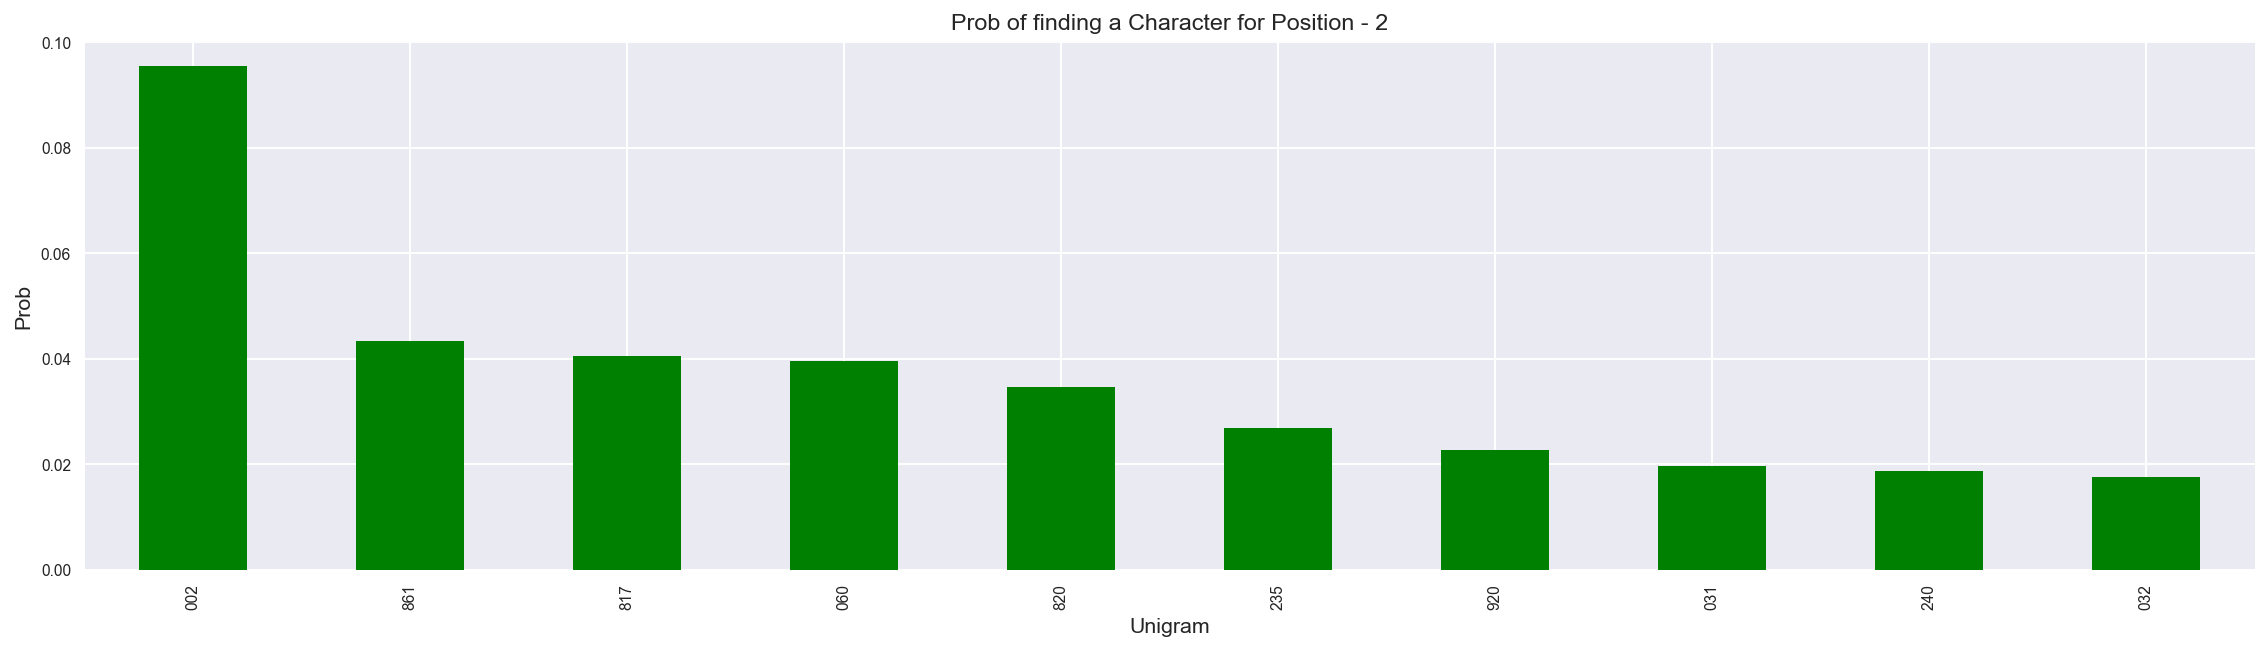

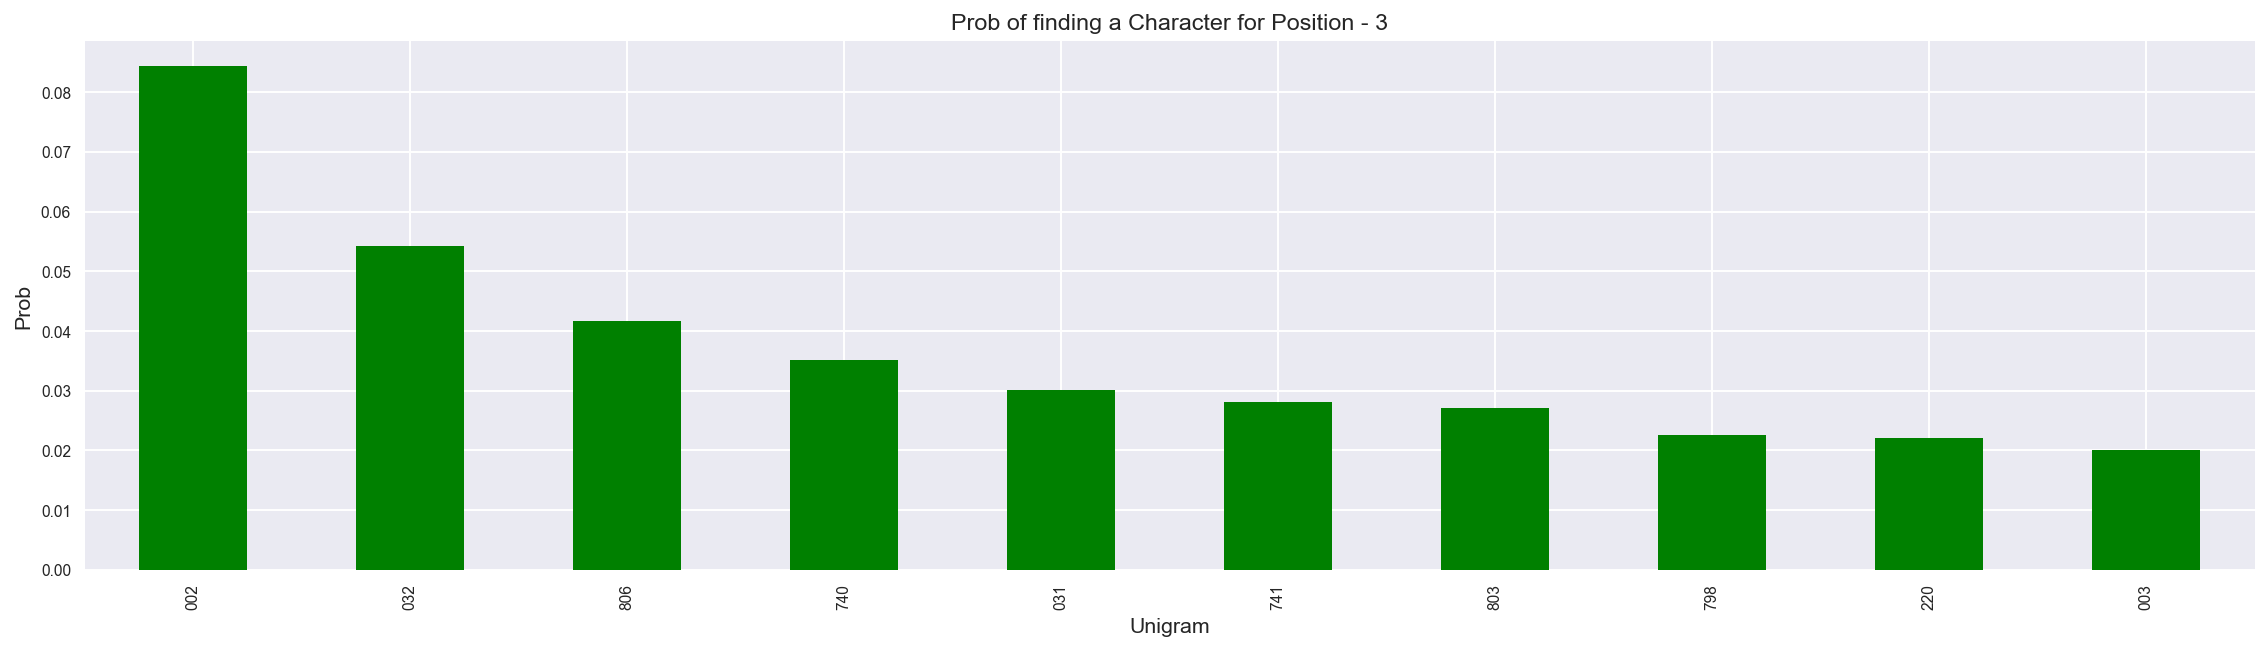

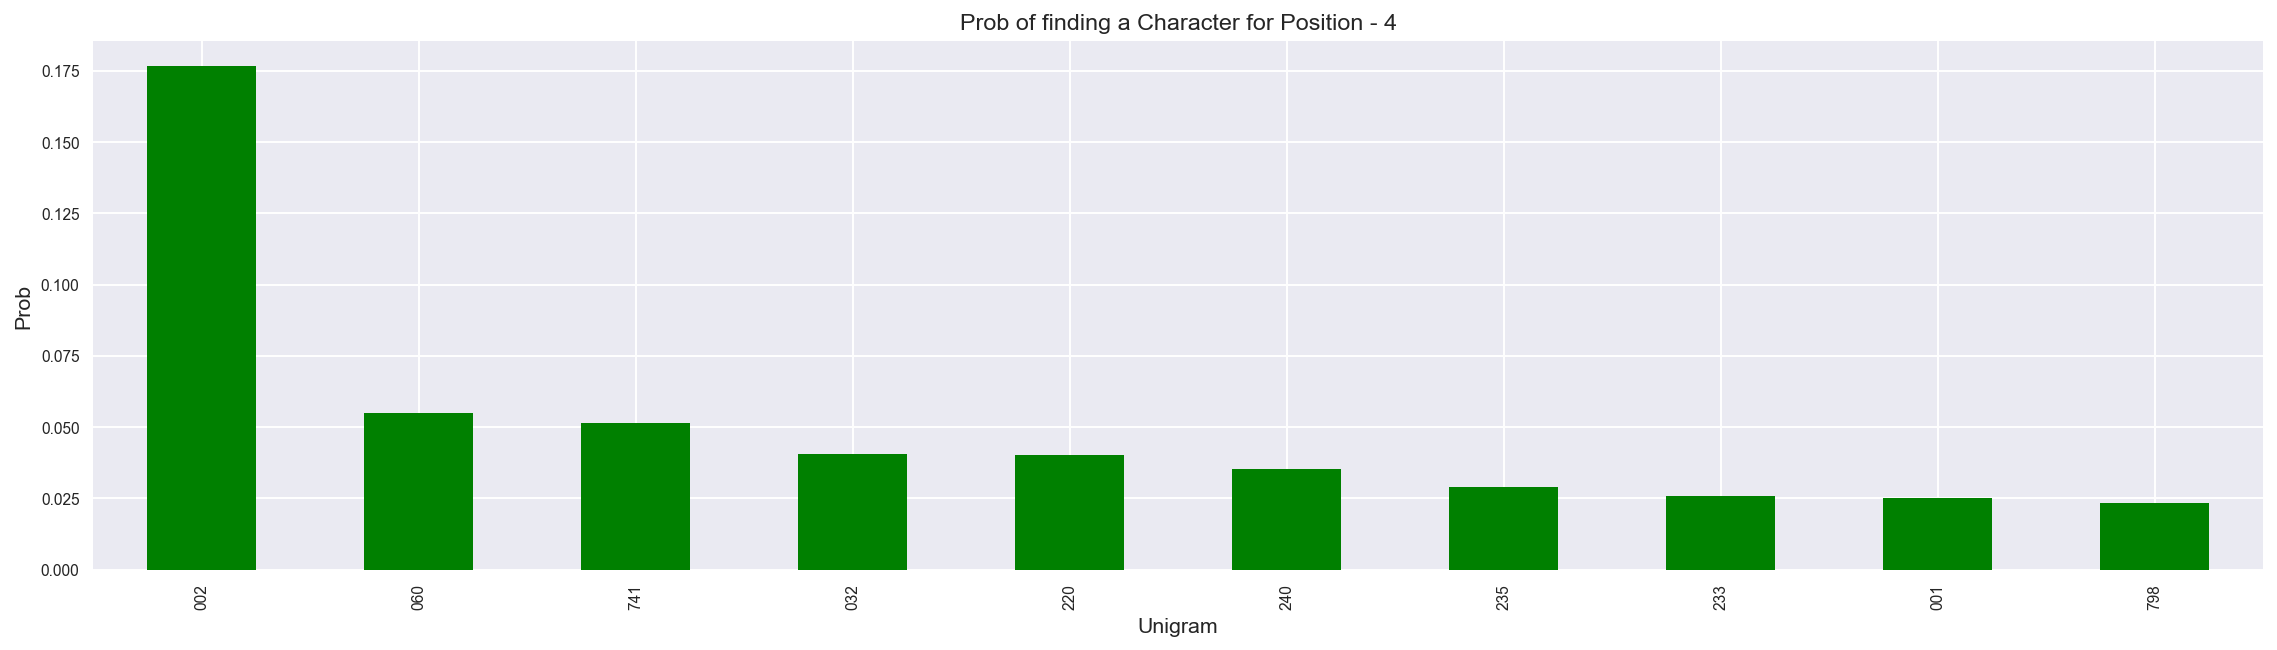

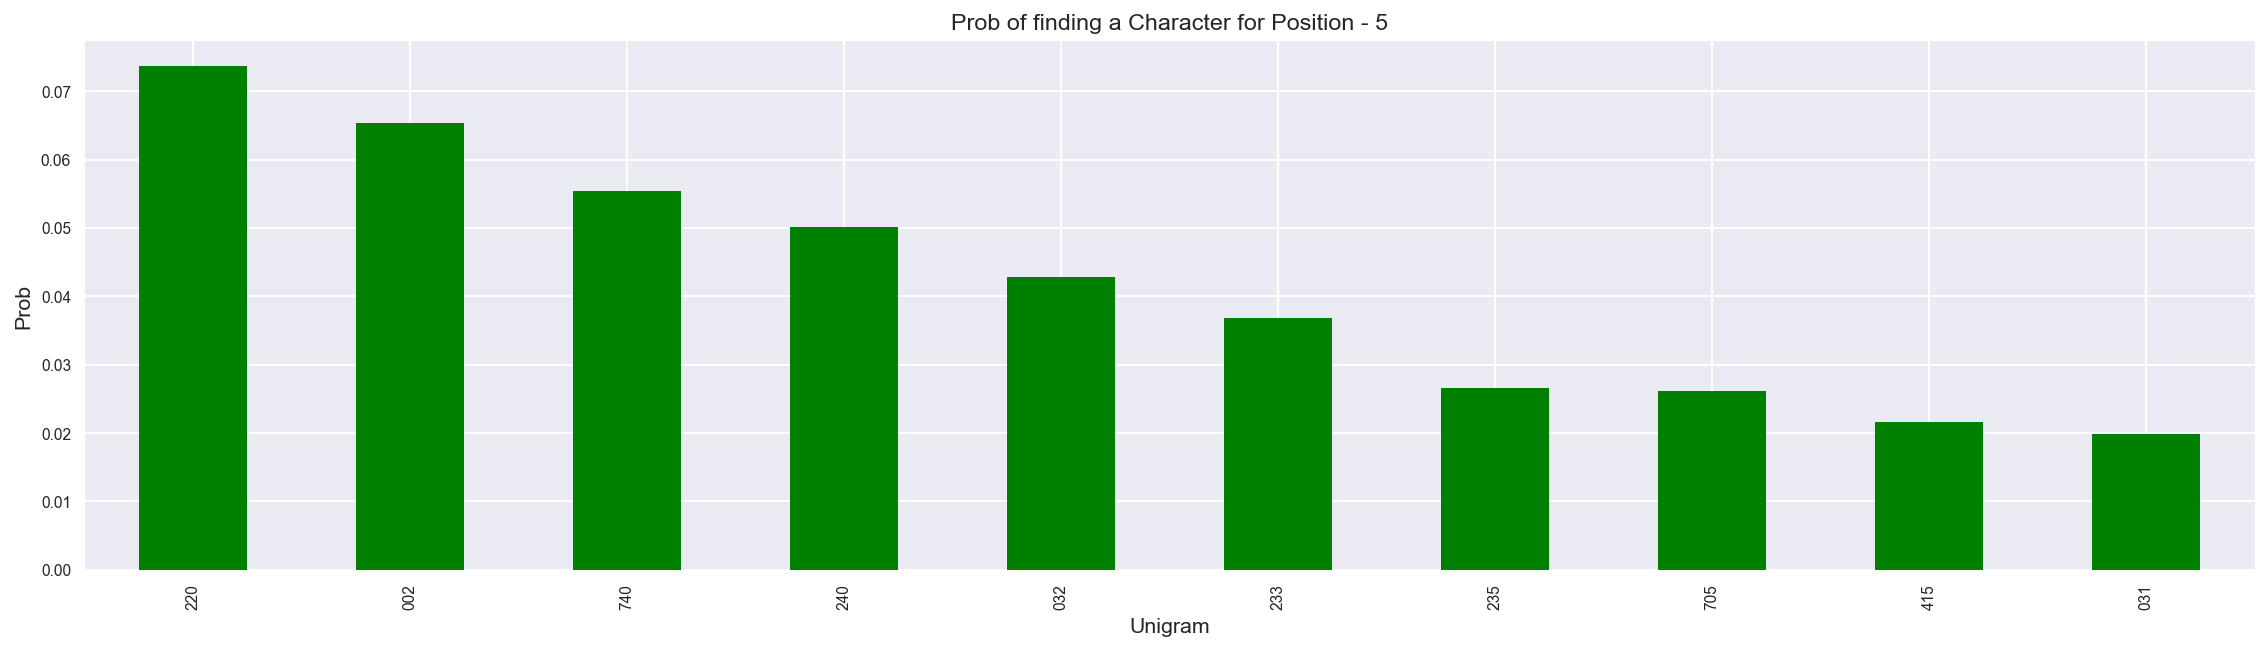

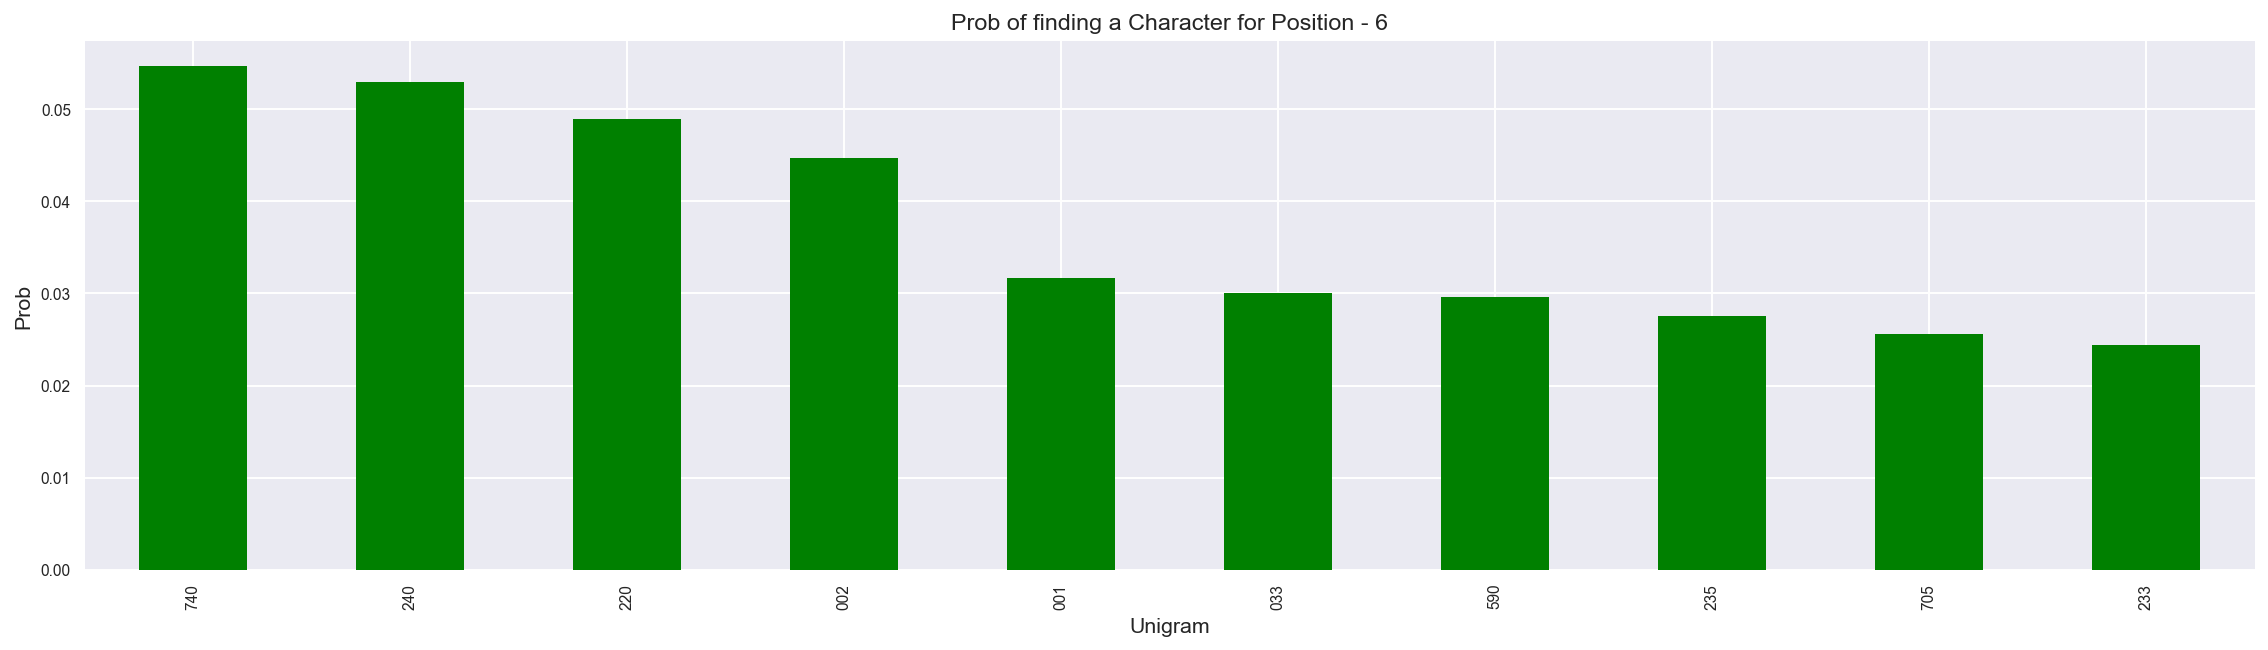

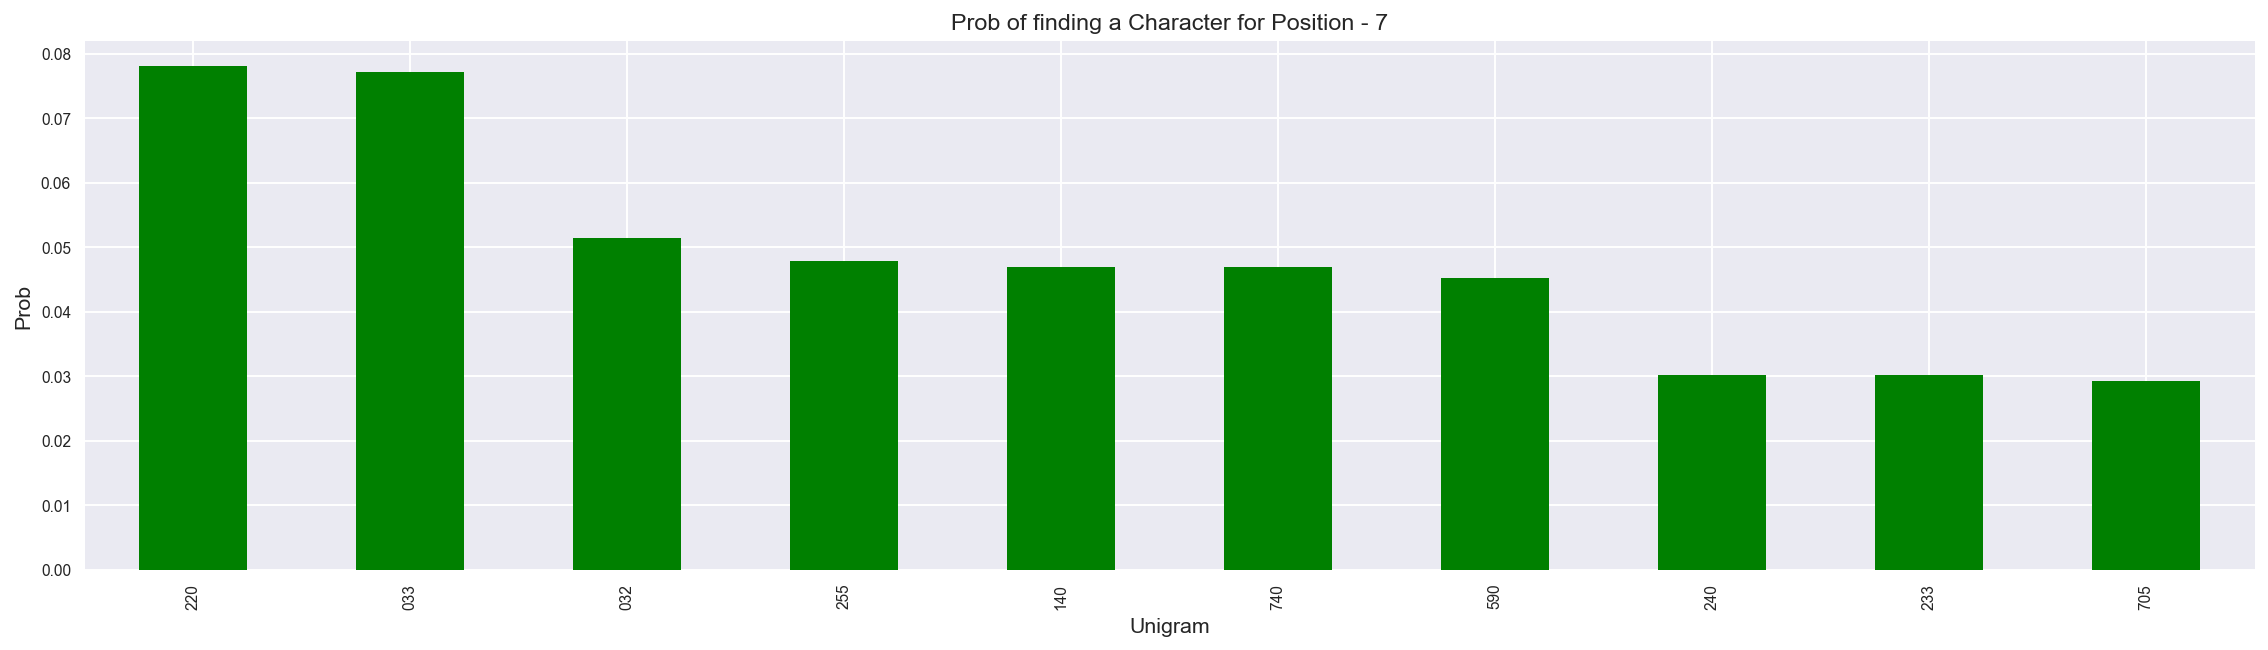

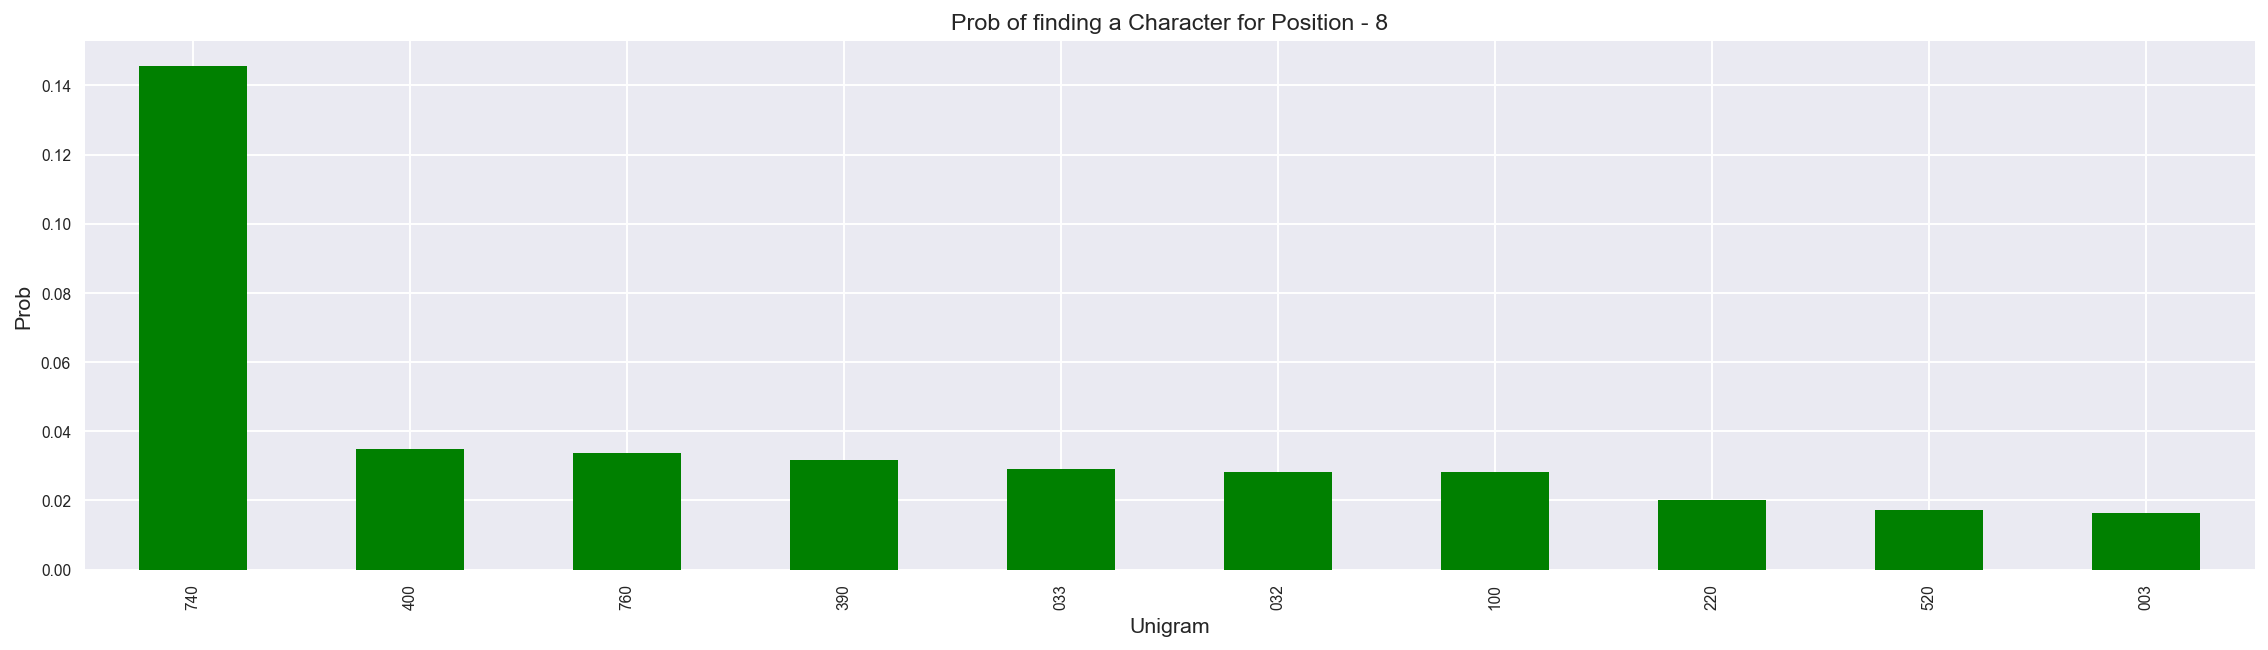

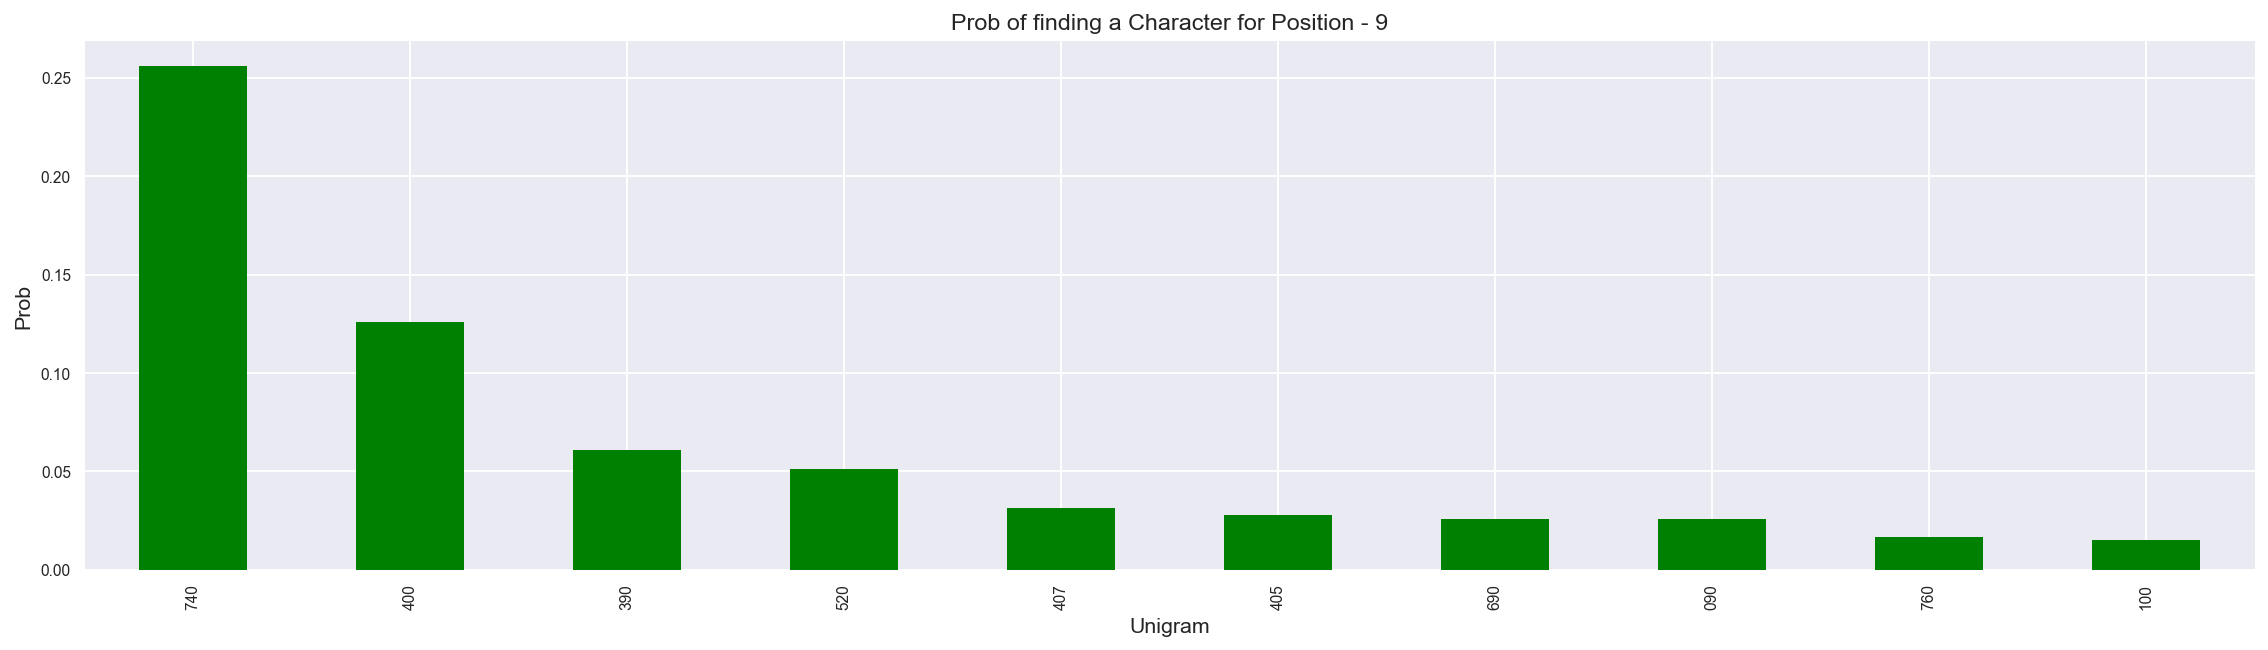

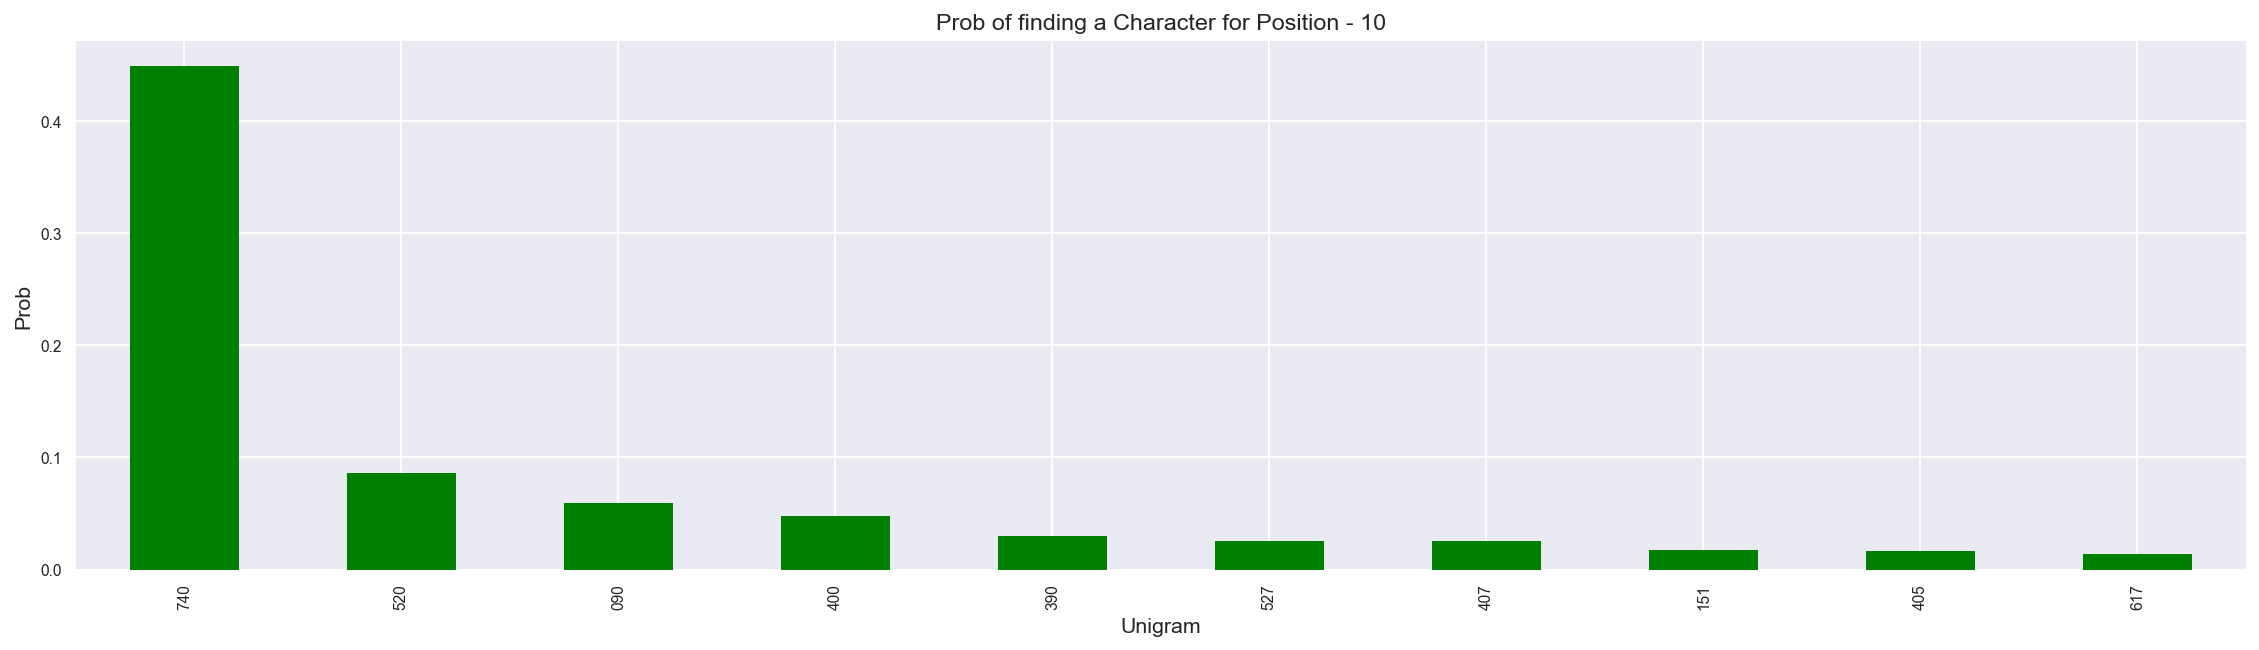

In [121]:
# For each position, show the unigram frequencies

for i in range(1,11):

    #Remove Max value
    df_text_norm_position_unigrams_prob_clean= df_text_norm_position_unigrams_prob.drop('max_value', axis=1)

    #Transpose it
    df_text_norm_position_unigrams_prob_trans = df_text_norm_position_unigrams_prob_clean.transpose()

    # Get the top 10 char
    #print(df_text_norm_position_unigrams_prob_trans[10].nlargest(n=10))
    df_text_norm_position_unigrams_prob_trans[i].nlargest(n=10).plot(kind='bar', color='green')

    plt.xlabel("Unigram")
    plt.ylabel("Prob")
    plt.title("Prob of finding a Character for Position - " + str(i) )

    plt.show()

## TBD
* There are more than 200 texts with Len of 2. Please look at these and the corresponding images and note the most frequent second member of the bigram following each first member.  
* Focus on making further improvement in the prediction of unclear symbols.

In [52]:
# Filter by text length
text_length =2
df_filtered = df[(df['text_length'] == text_length)]
print("After filtering by text_length ",  "it has ", len(df_filtered.index), " rows")

After filtering by text_length  it has  373  rows


In [53]:
df_filtered.head()

icit_id        site keywords text_class lines direction       text signs  \
0        1  Alamgirpur      NaN         SS     1       L/R  +410-017+     2   
2        3  Alamgirpur      NaN         SC     1       L/R  +405-017+     2   
4        5   Allahdino     Bull         UC     1       R/L  +740-235+     2   
15      16  Altyn Depe      NaN         UC     1       L/R  +390-415+     2   
16      17        Amri      NaN         SS     1       L/R  +390-034+     2   

   complete  alignment sign height text_images linearized_text l_to_r_text  \
0         Y  Unordered     Unequal         NaN         410 017     410 017   
2         Y        NaN         NaN         NaN         405 017     405 017   
4         Y        NaN         NaN         NaN         740 235     235 740   
15        Y     Linear       Equal         NaN         390 415     390 415   
16        Y        NaN         NaN         NaN         390 034     390 034   

   r_to_l_text reversed_text  text_length  
0      017 410       410 017          2.0  
2      017 405       405 017          2.0  
4      740 235       235 740          2.0  
15     415 390       390 415          2.0  
16     034 390       390 034          2.0

In [54]:
# For each of the keywords, get the frequency

In [55]:
import numpy as np

def isNaN(string):
    return string != string

keywords= defaultdict(int)
for word in df_filtered.keywords:
    if(isNaN(word)==False):
        keywords[word]+=1

#keywords.items()

In [56]:
df_keywords=pd.DataFrame(sorted(keywords.items(),key=lambda x:x[1],reverse=True))
print("Number of distinct Keywords for", text_length, "character texts", len(df_keywords))

pd_keywords1=df_keywords[0][0:20]
pd_keywords2=df_keywords[1][0:20]


Number of distinct Keywords for 2 character texts 62


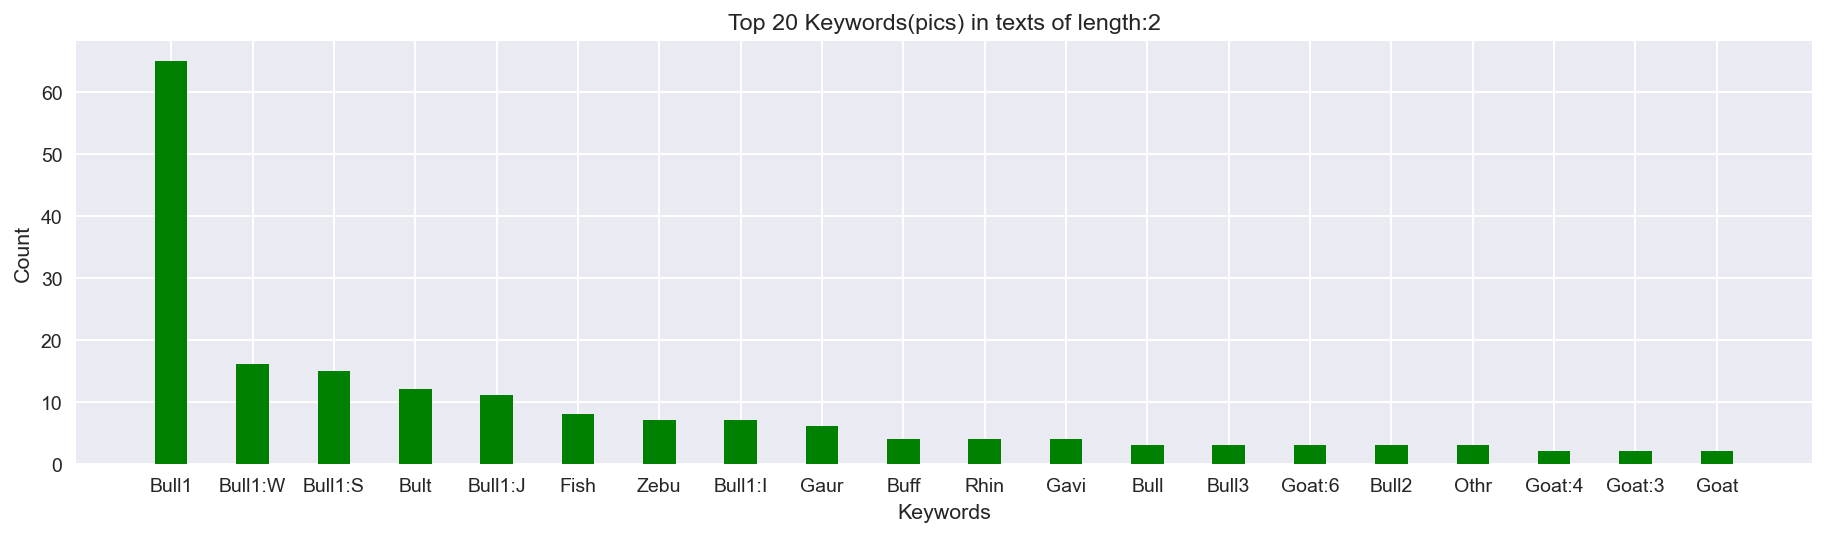

In [105]:
plt.figure(10,figsize=(16,4))

plt.bar(pd_keywords1,pd_keywords2, color ='green',
        width = 0.4)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
 
plt.xlabel("Keywords")
plt.ylabel("Count")
plt.title("Top 20 Keywords(pics) in texts of length:"+ str(text_length))

plt.savefig("keywords-2-char.png")
plt.show()

In [58]:
# For each of the keywords, get the r_to_l_text frequency

In [59]:
keywords_text_dict= defaultdict(lambda: defaultdict(int))

for word in pd_keywords1:
    if(isNaN(word)==False):
        for text in df_filtered[df_filtered.keywords==word].r_to_l_text:
            keywords_text_dict[word][text]+=1

df_keywords_text = pd.DataFrame(keywords_text_dict)

#print(df_keywords_text)

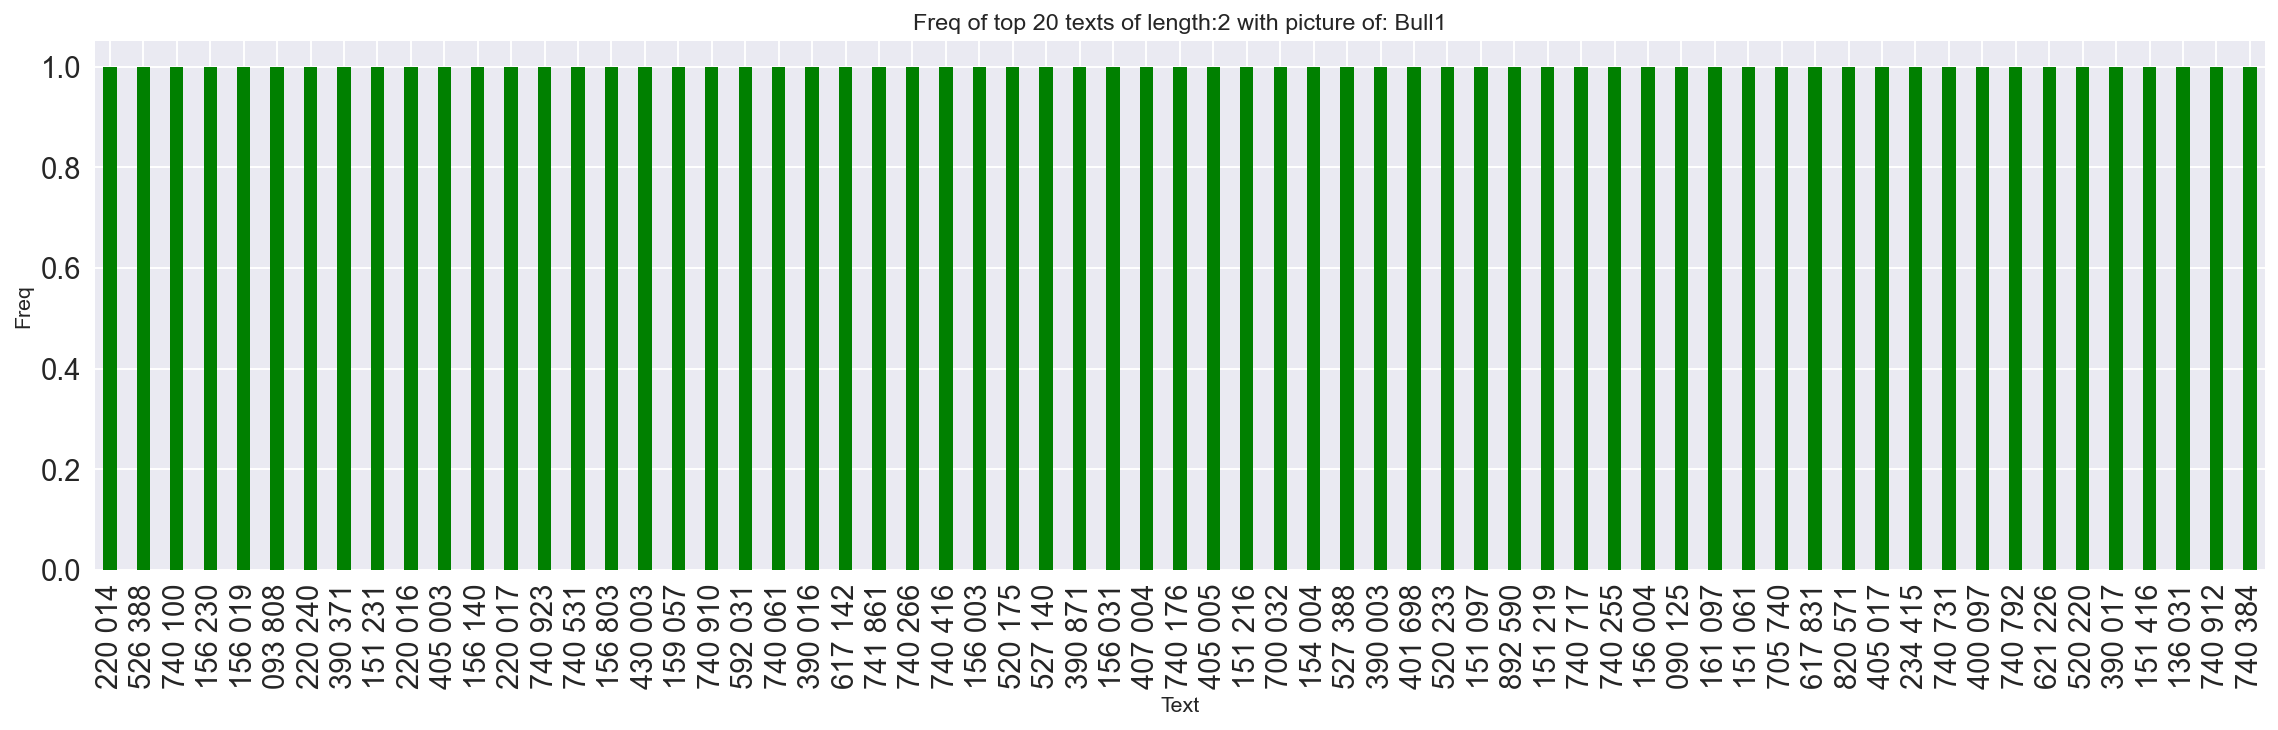

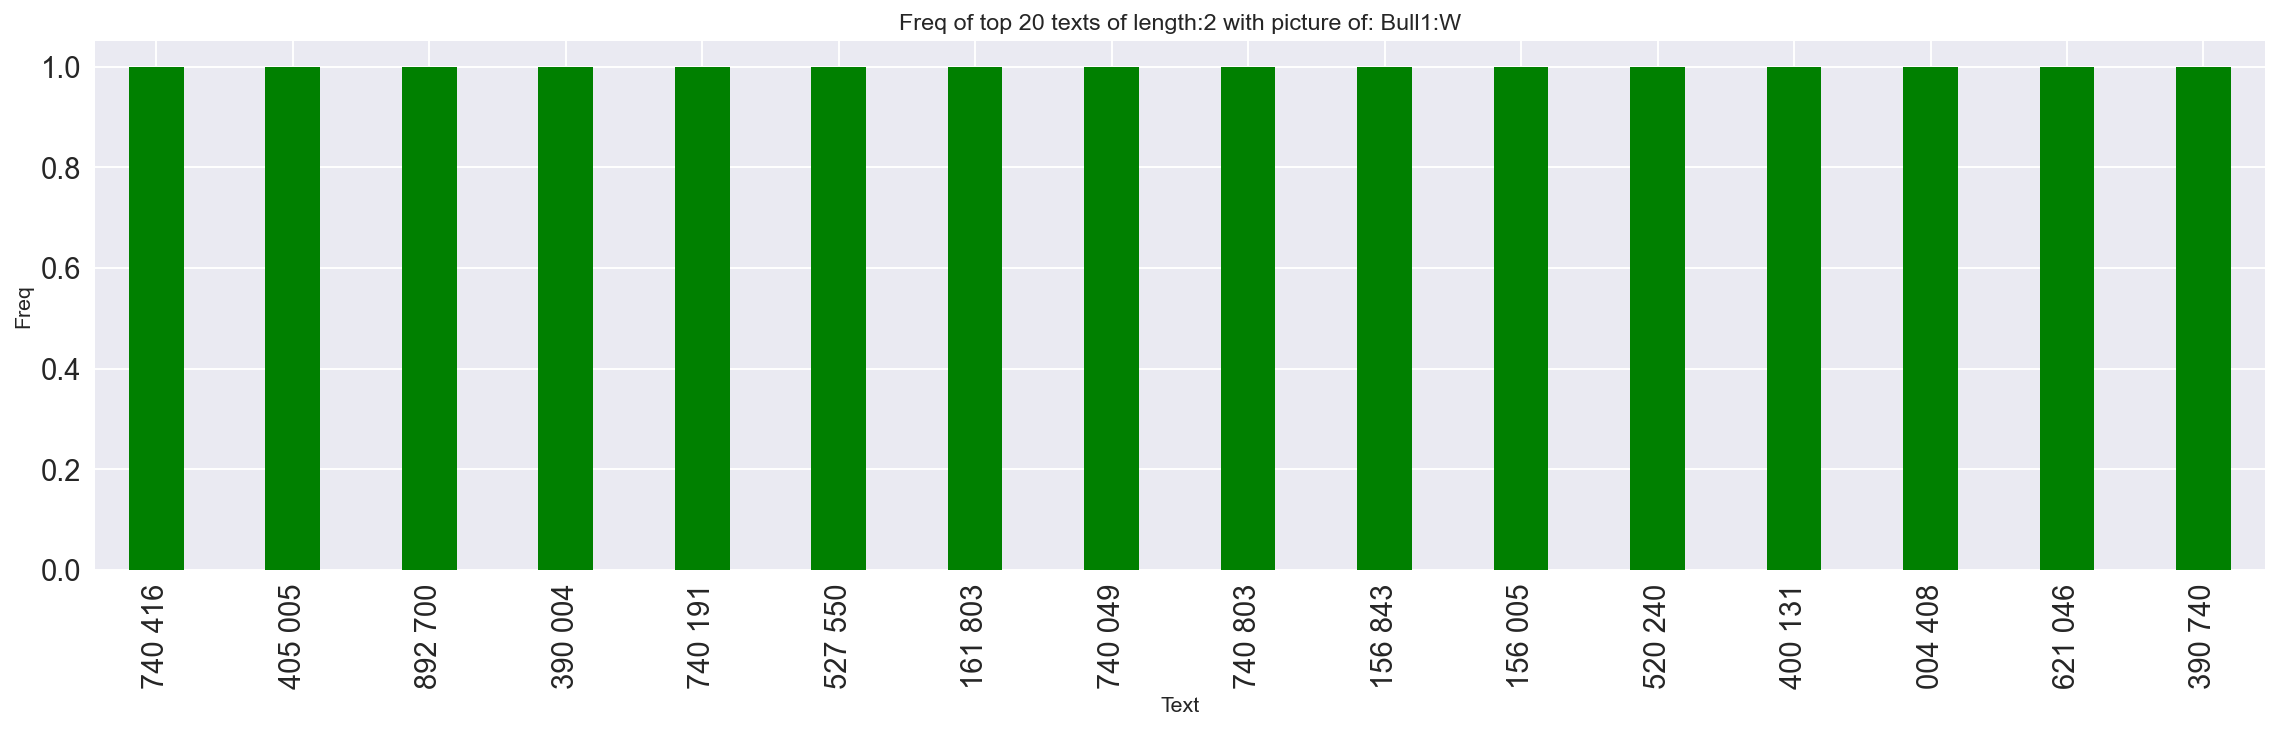

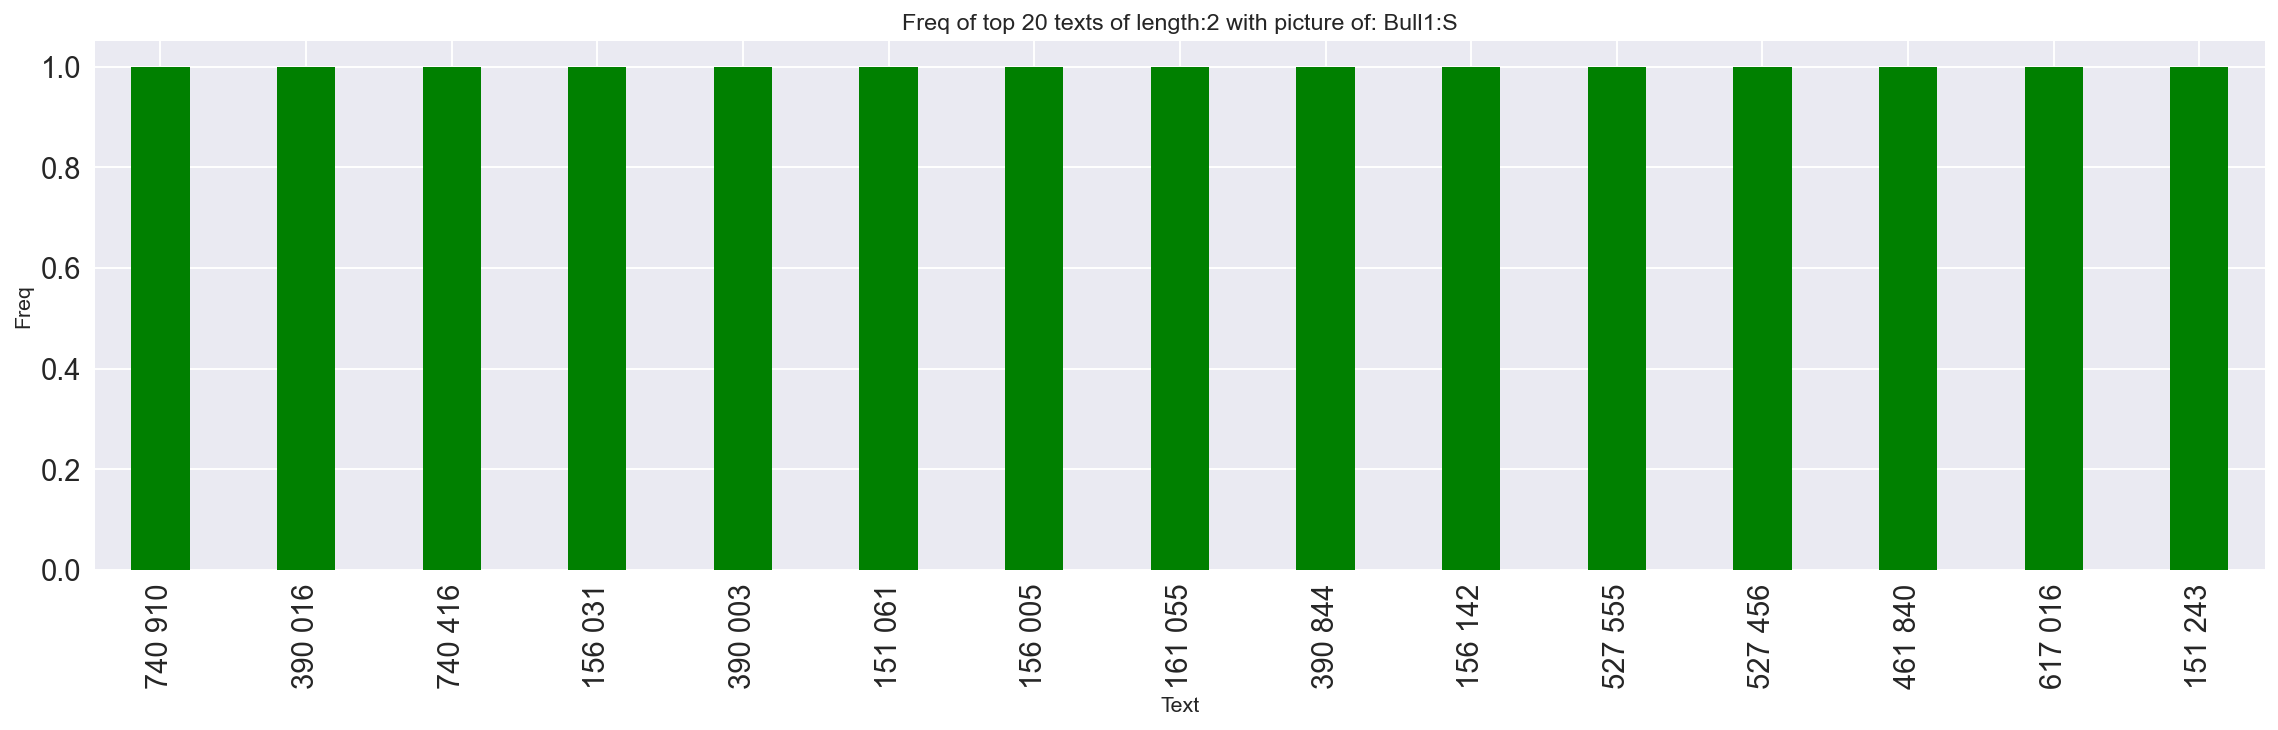

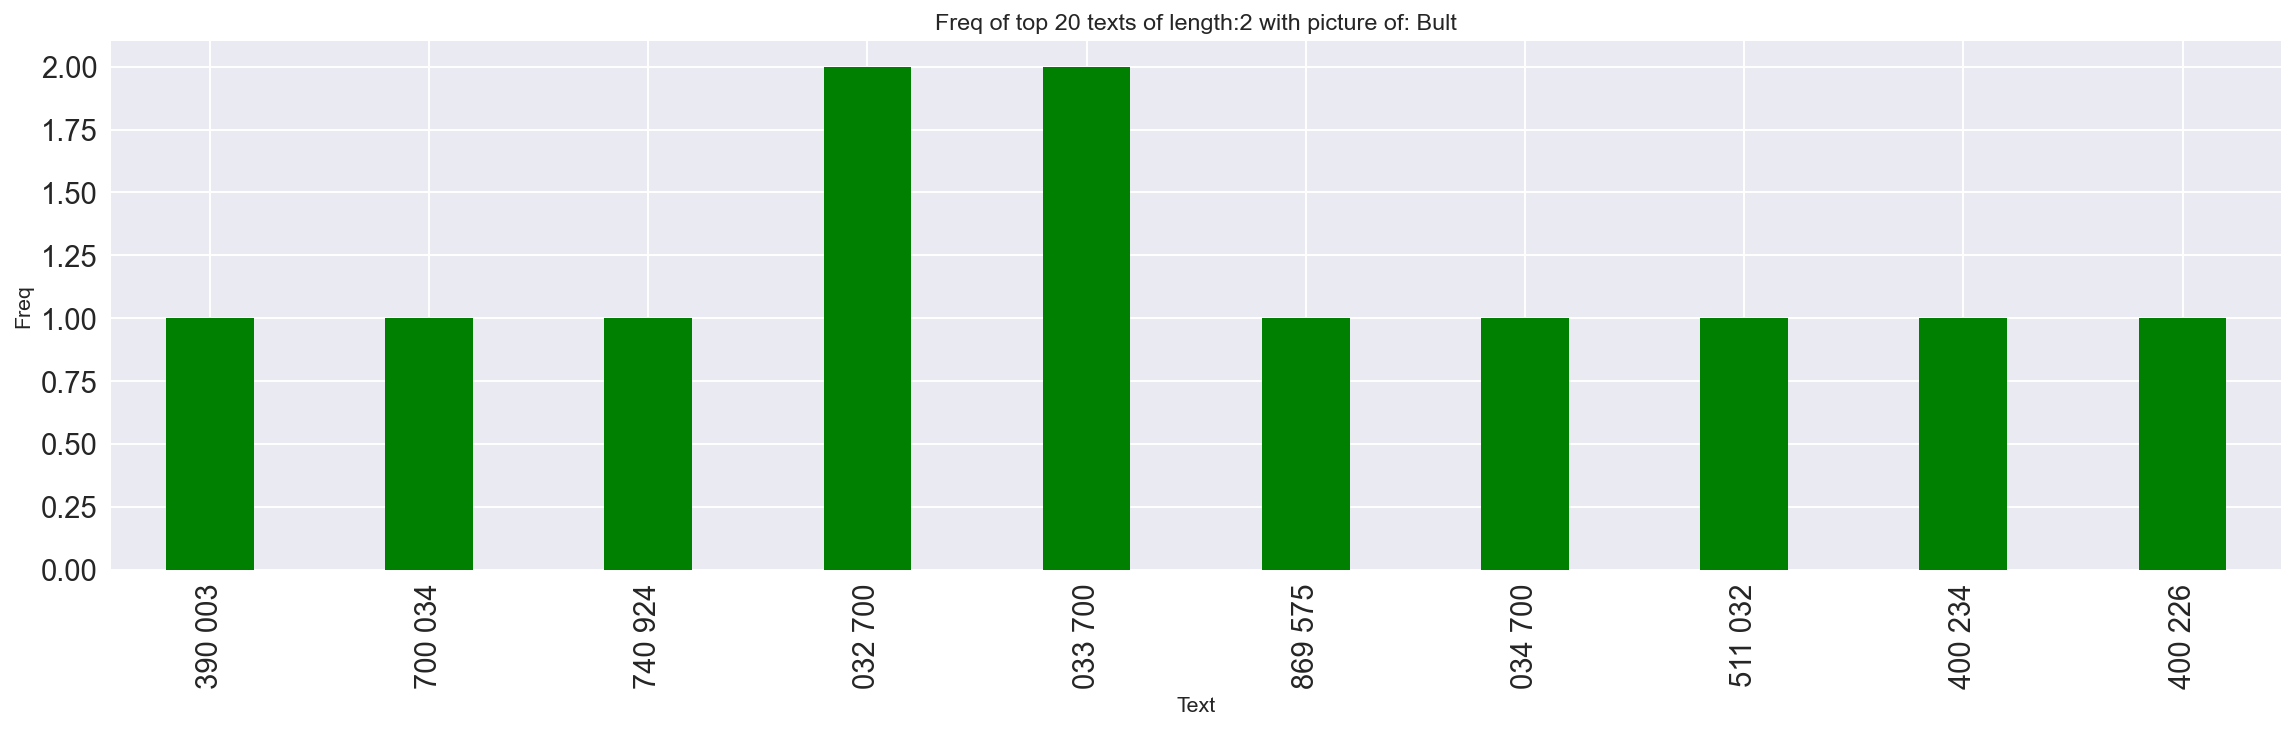

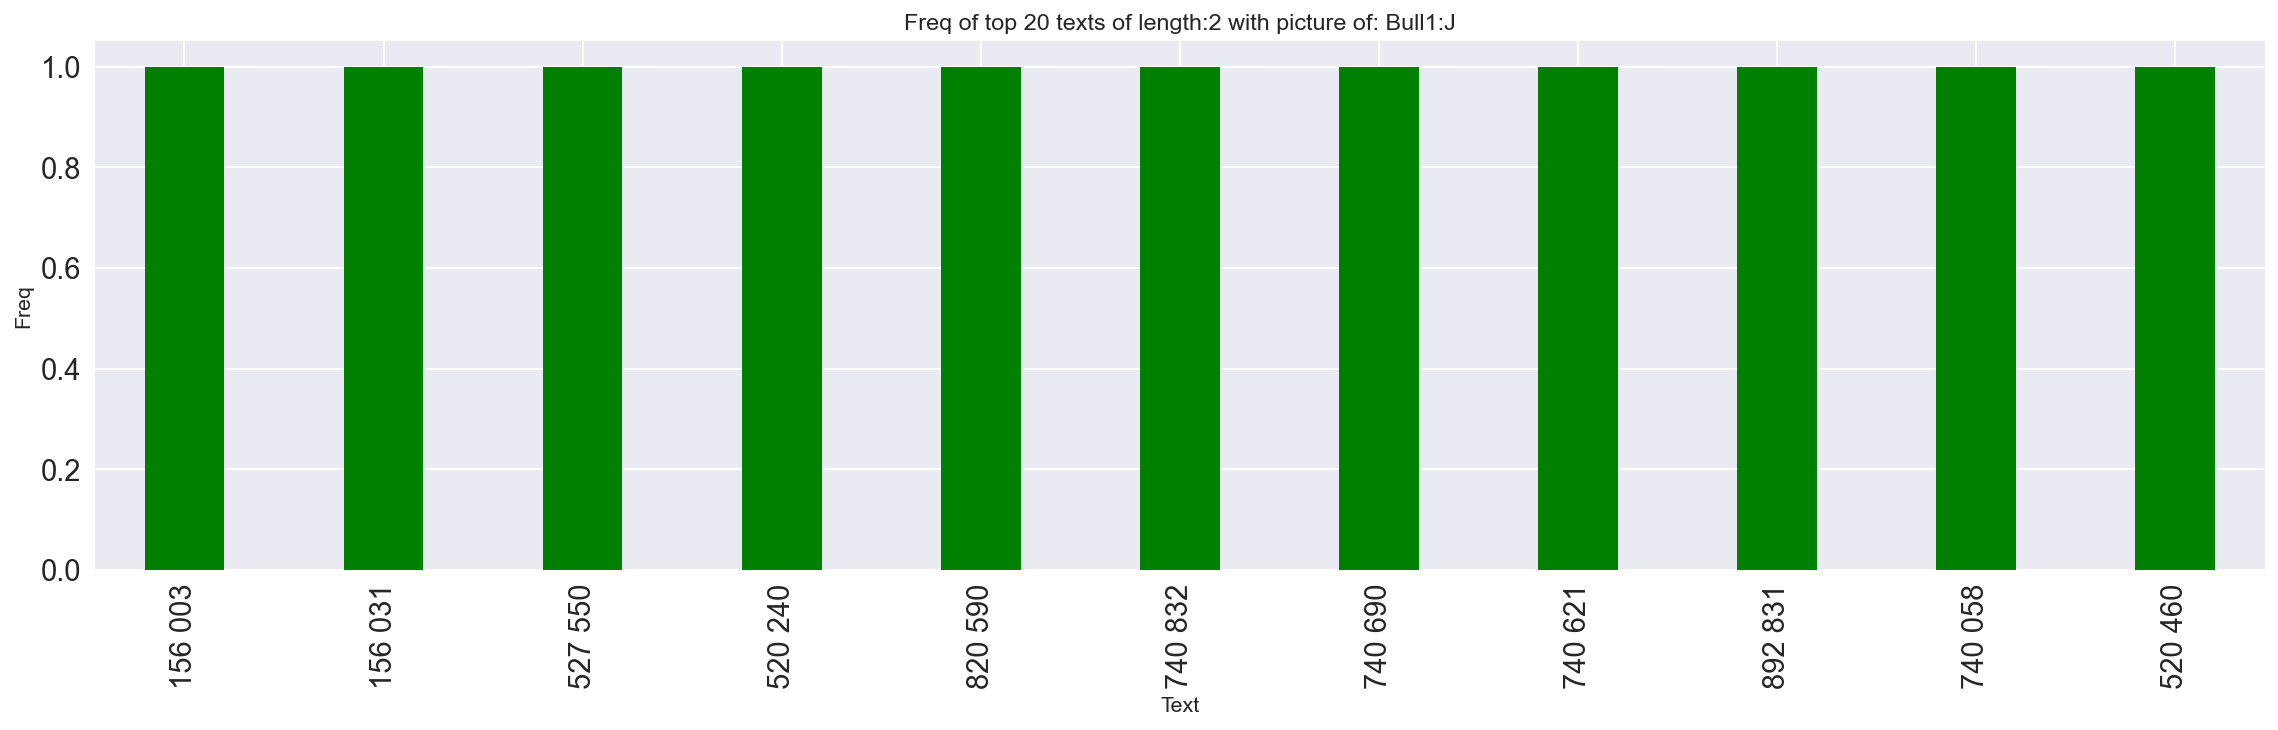

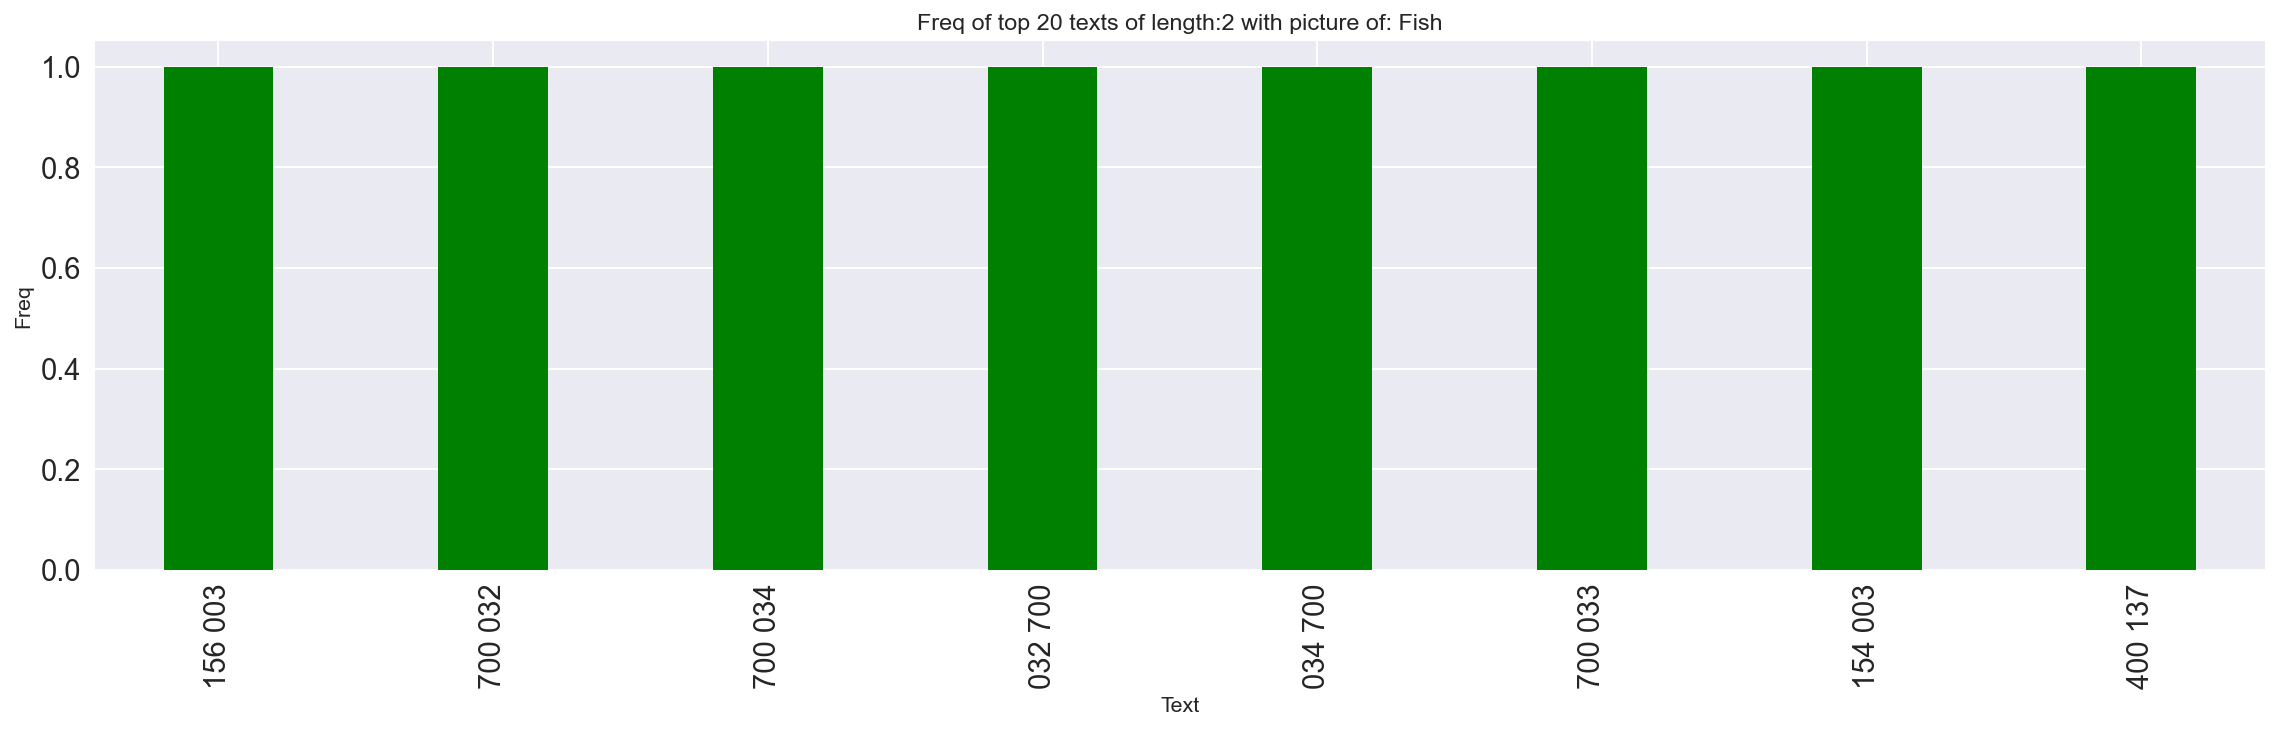

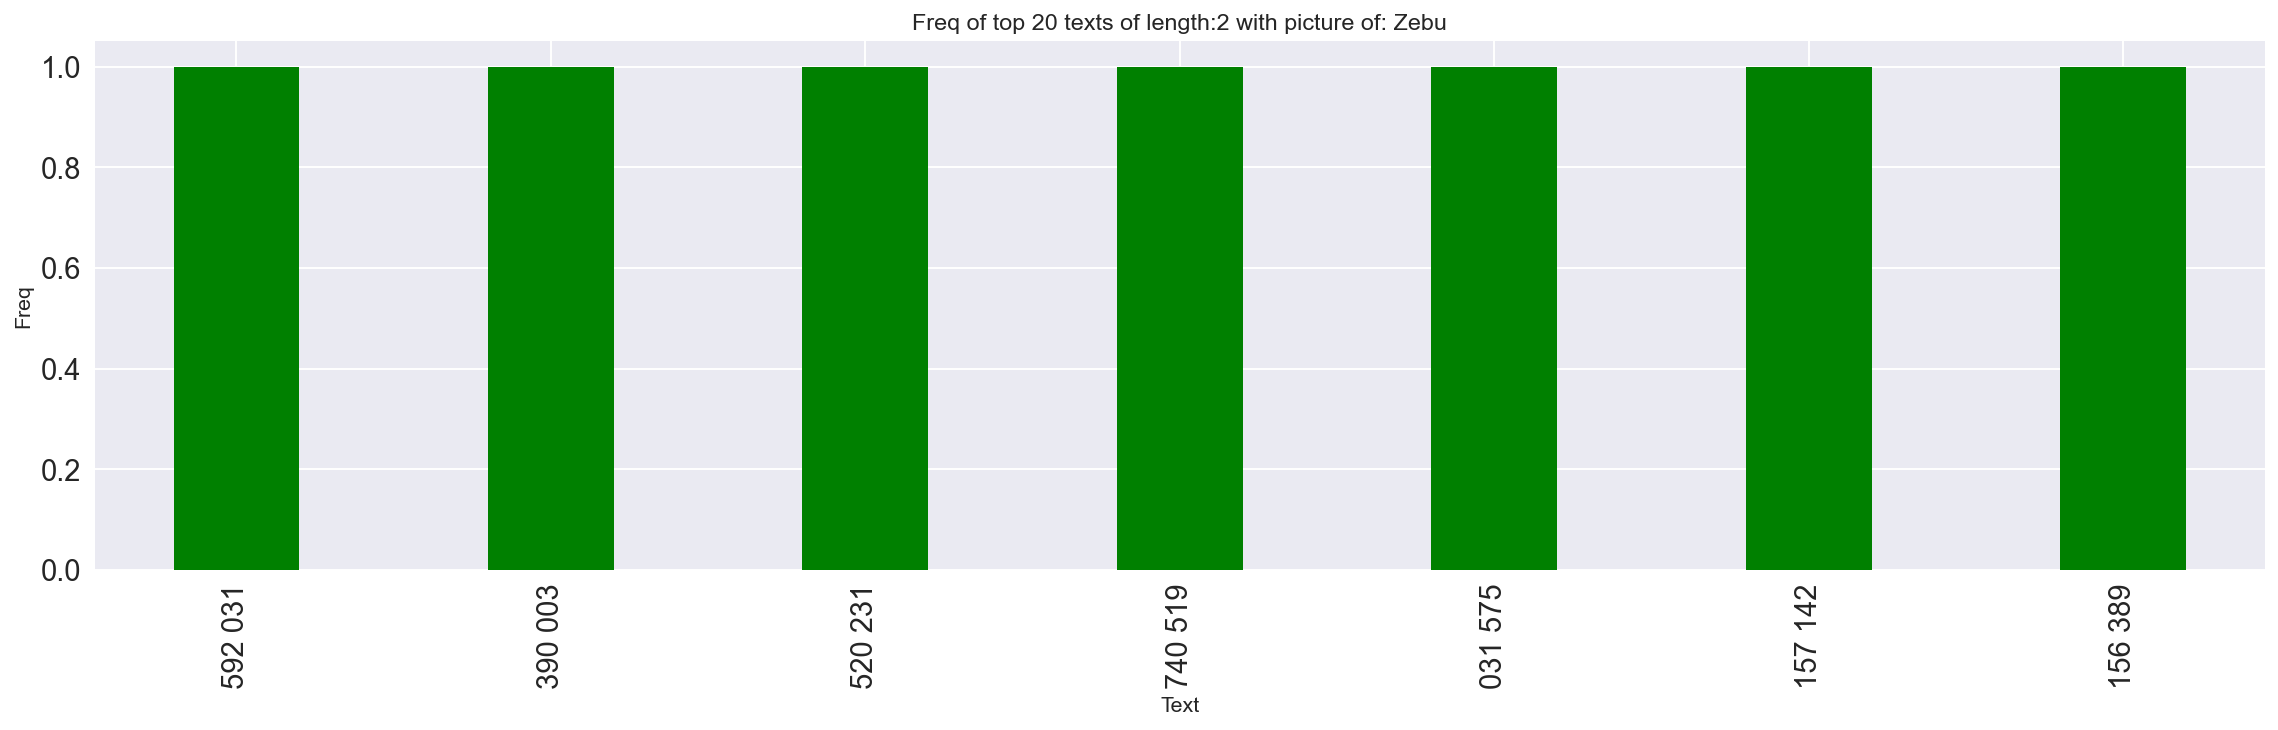

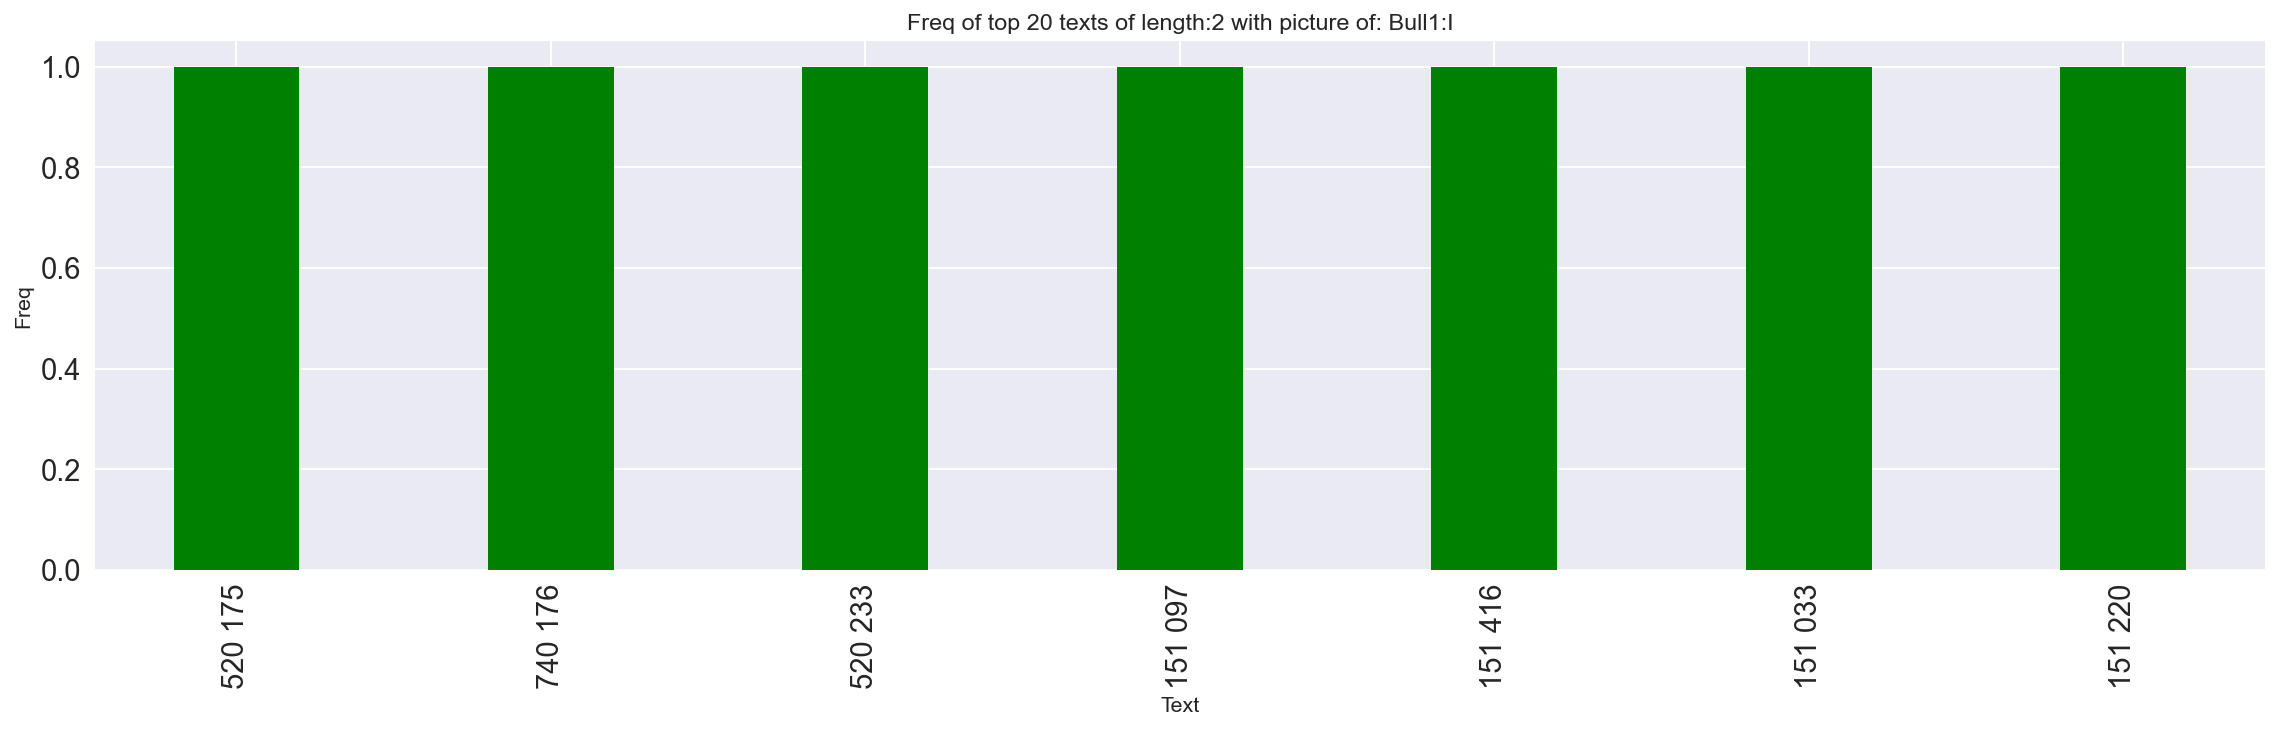

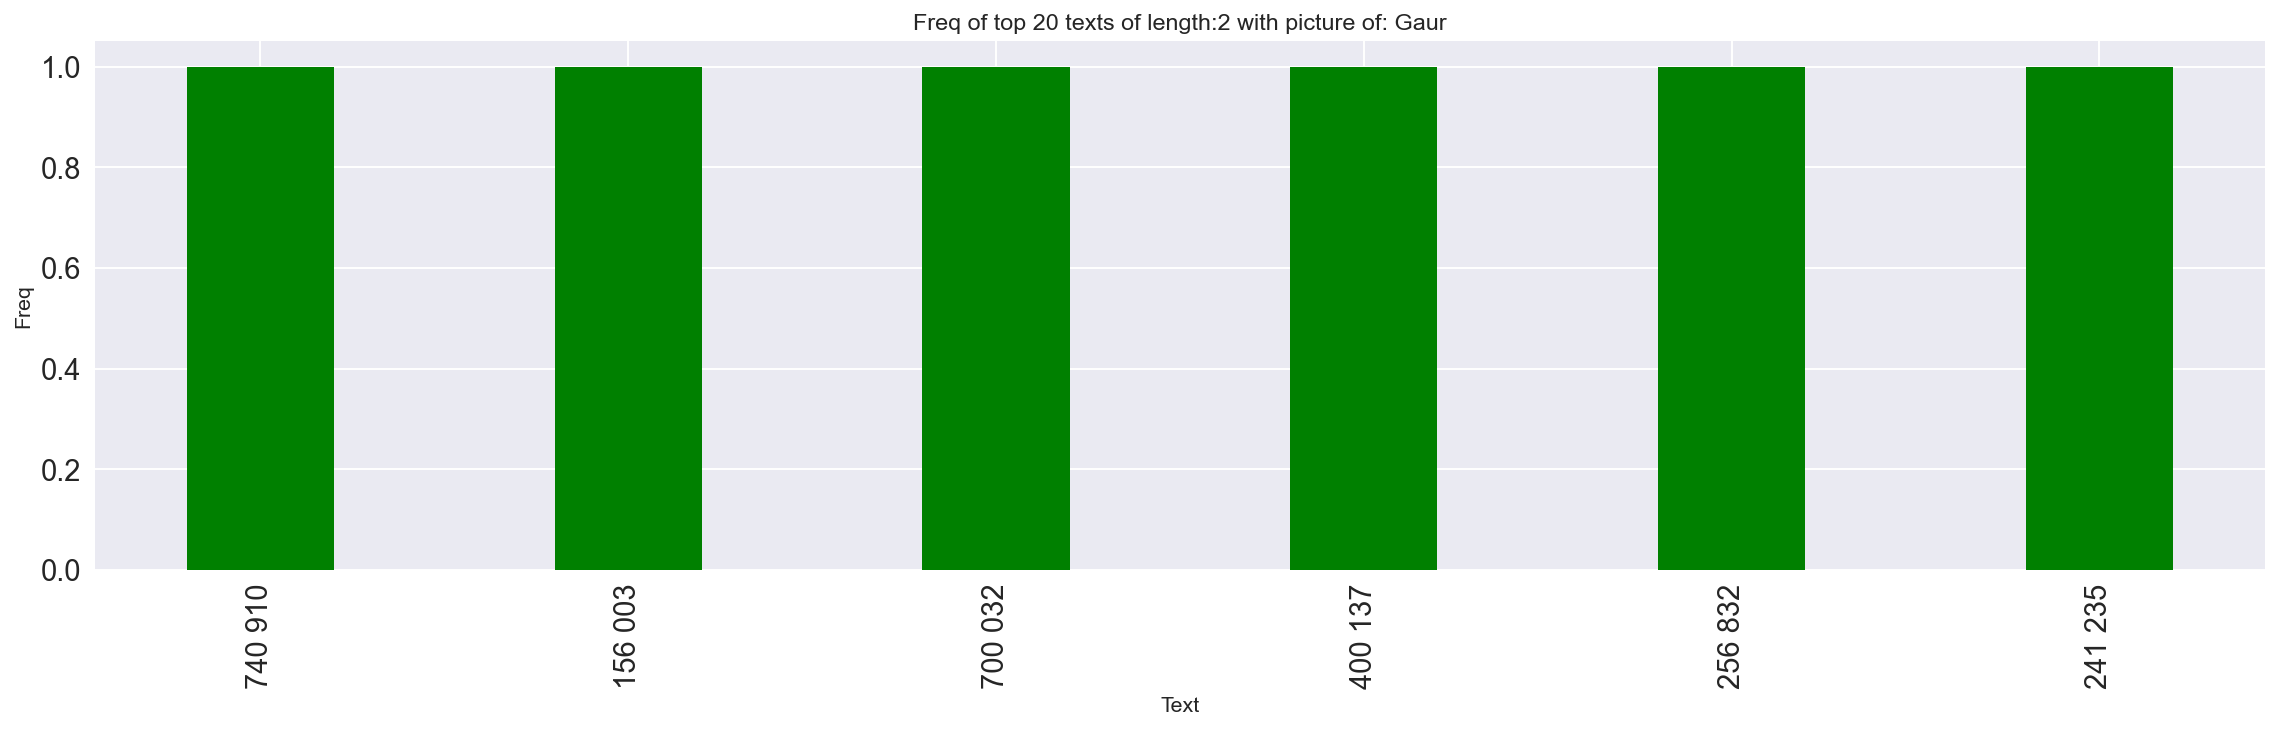

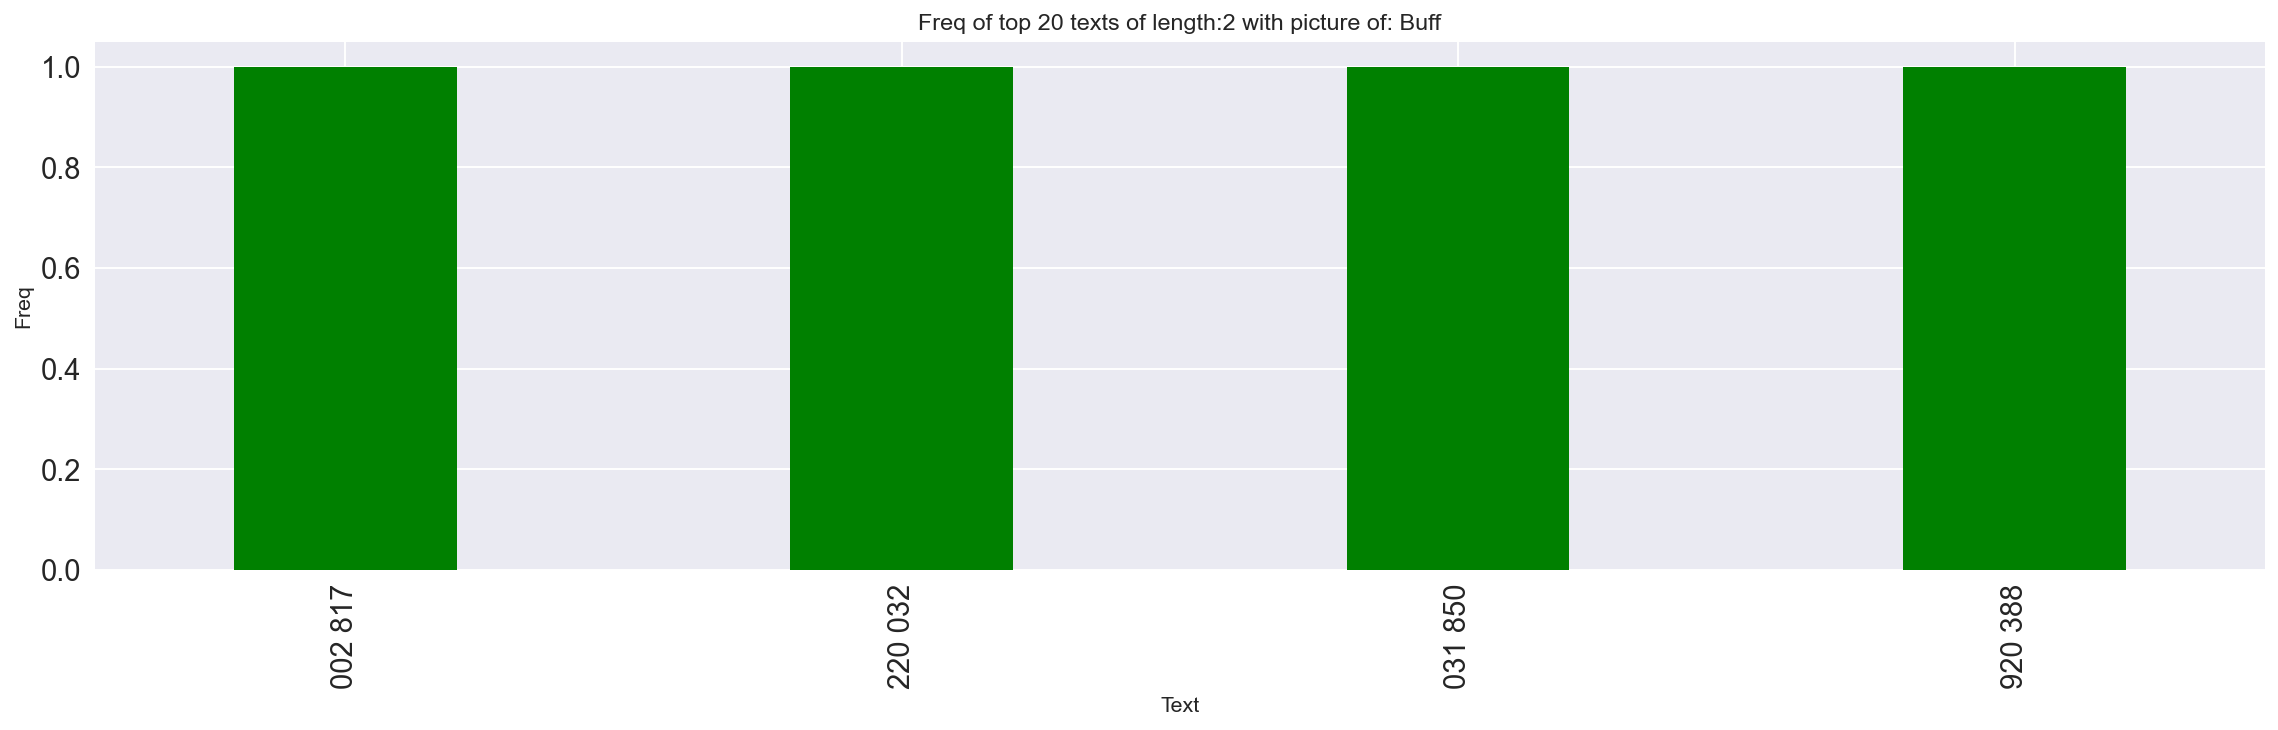

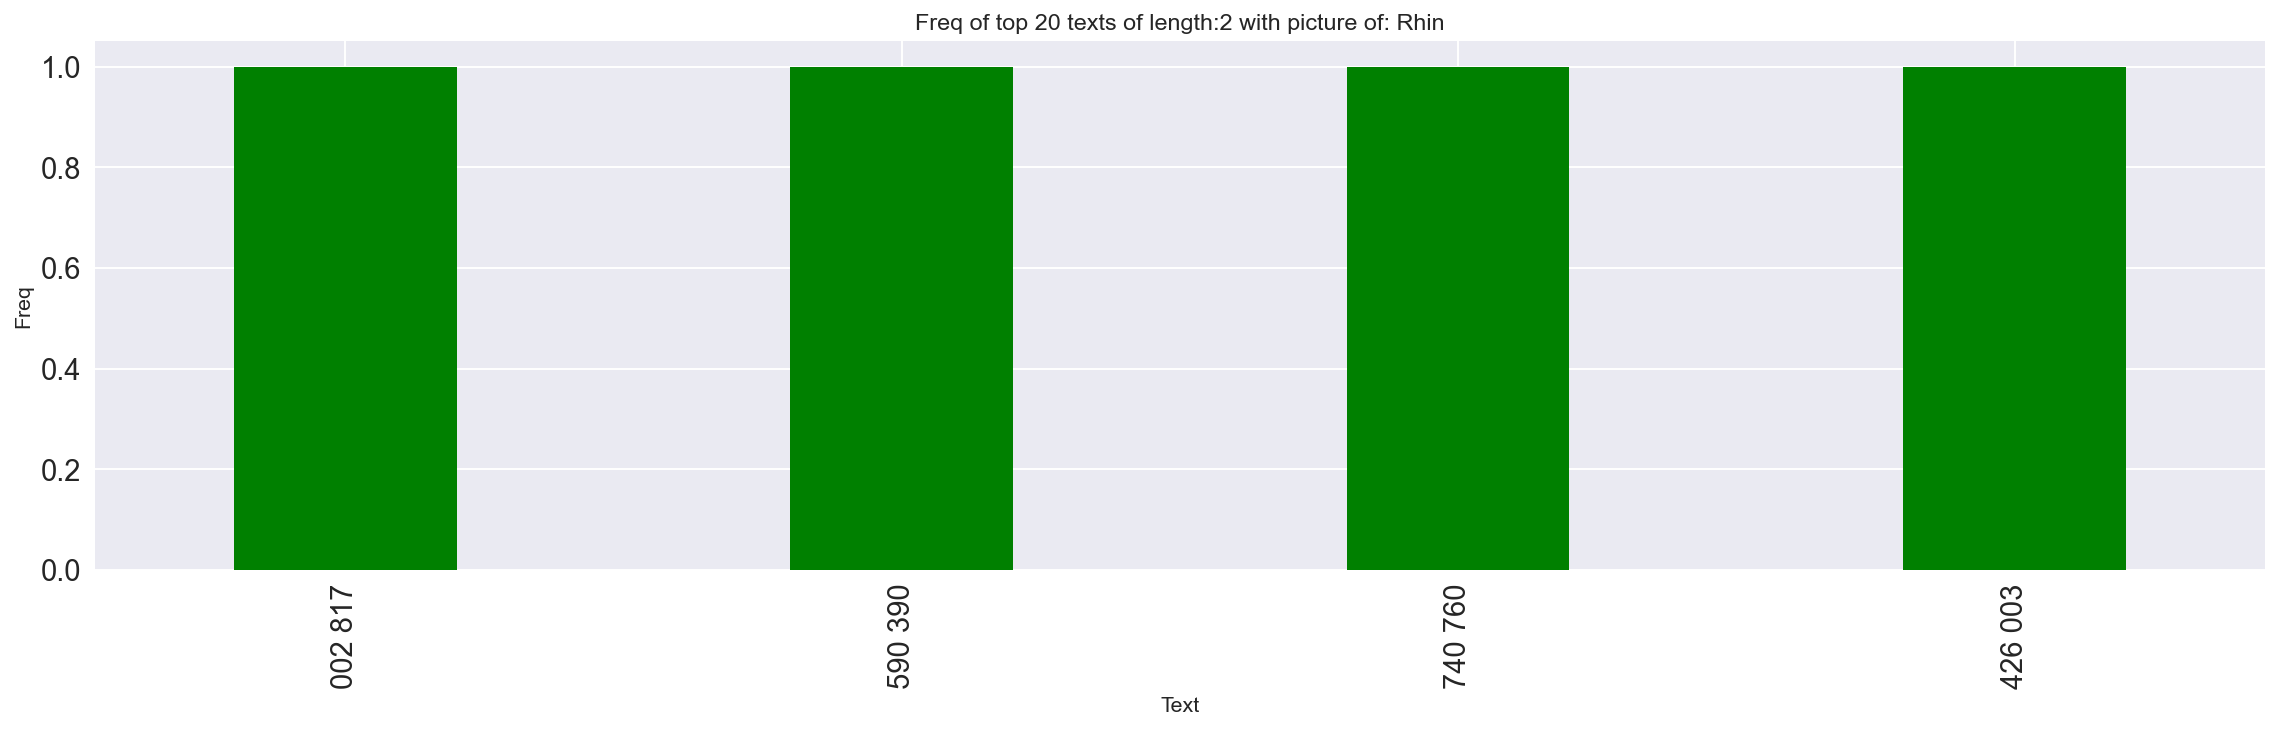

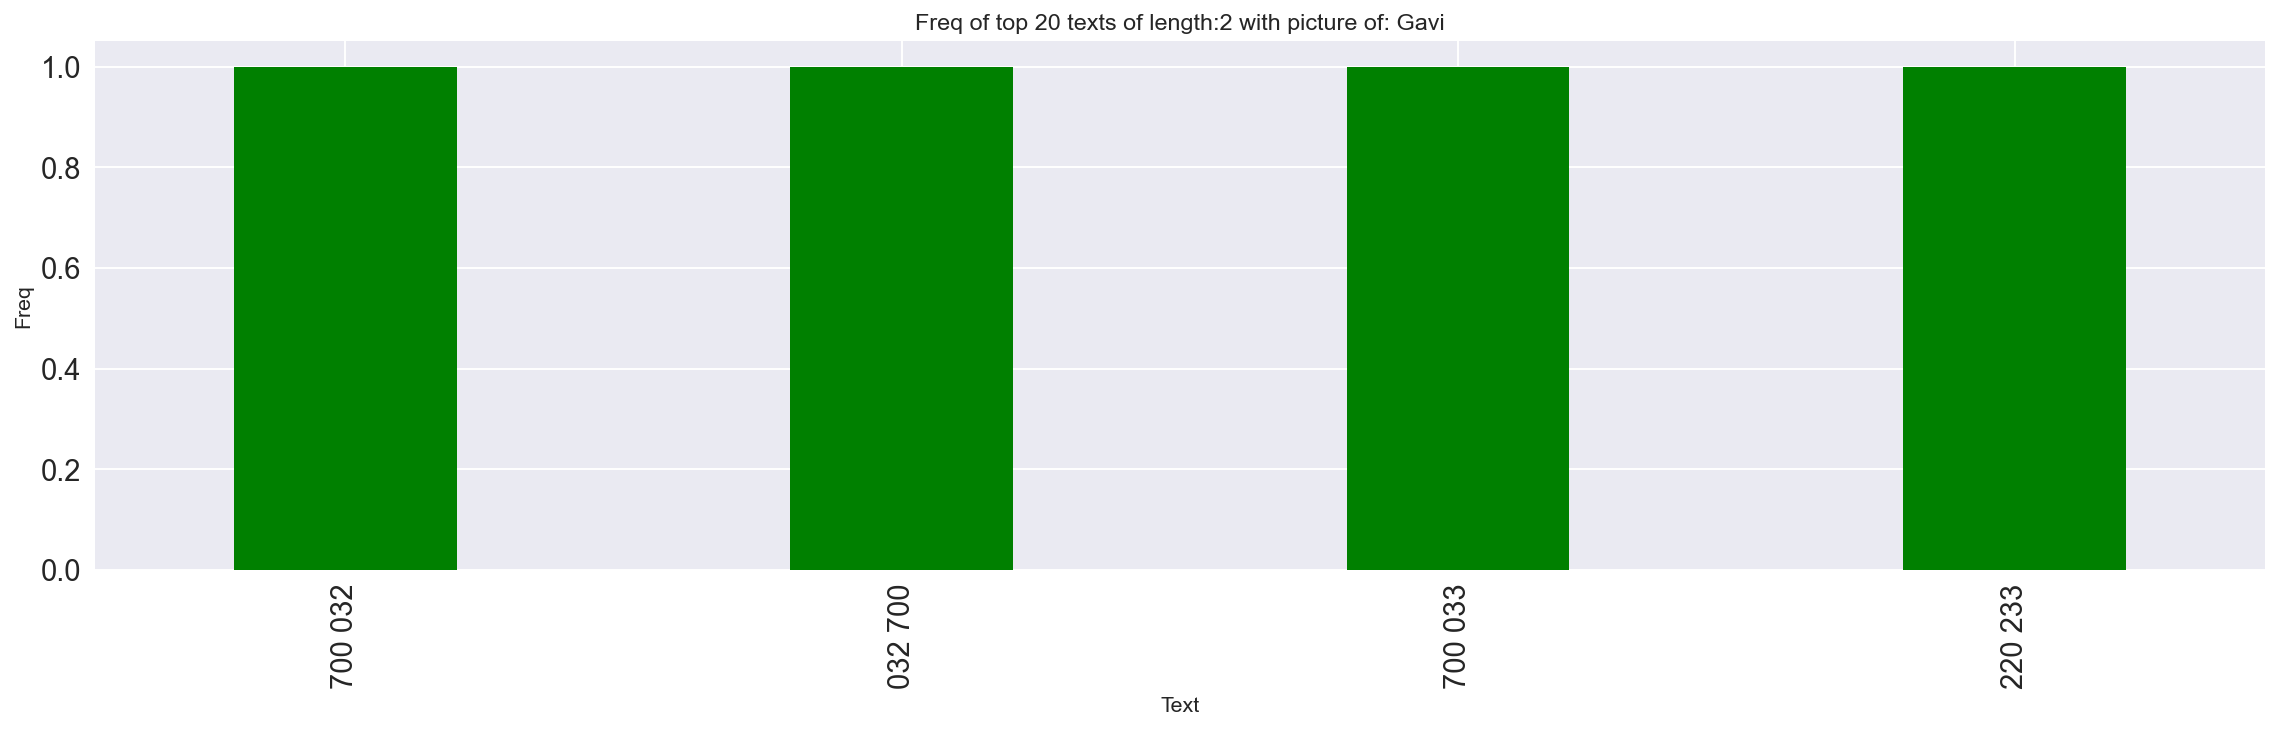

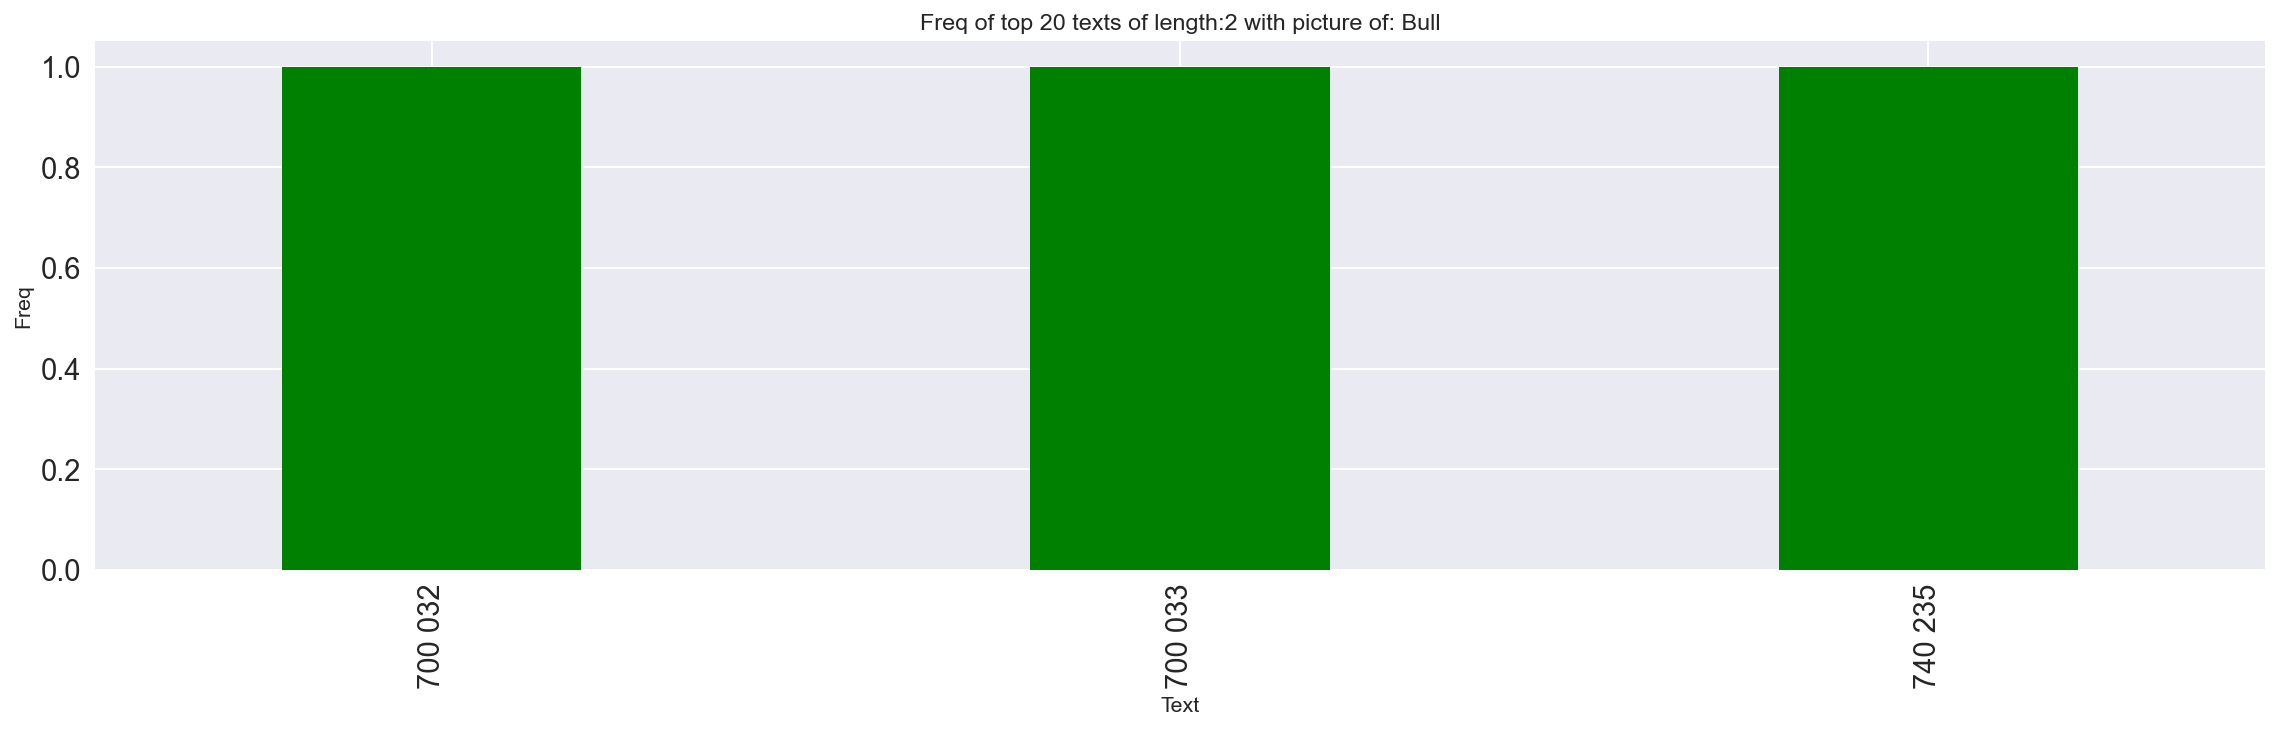

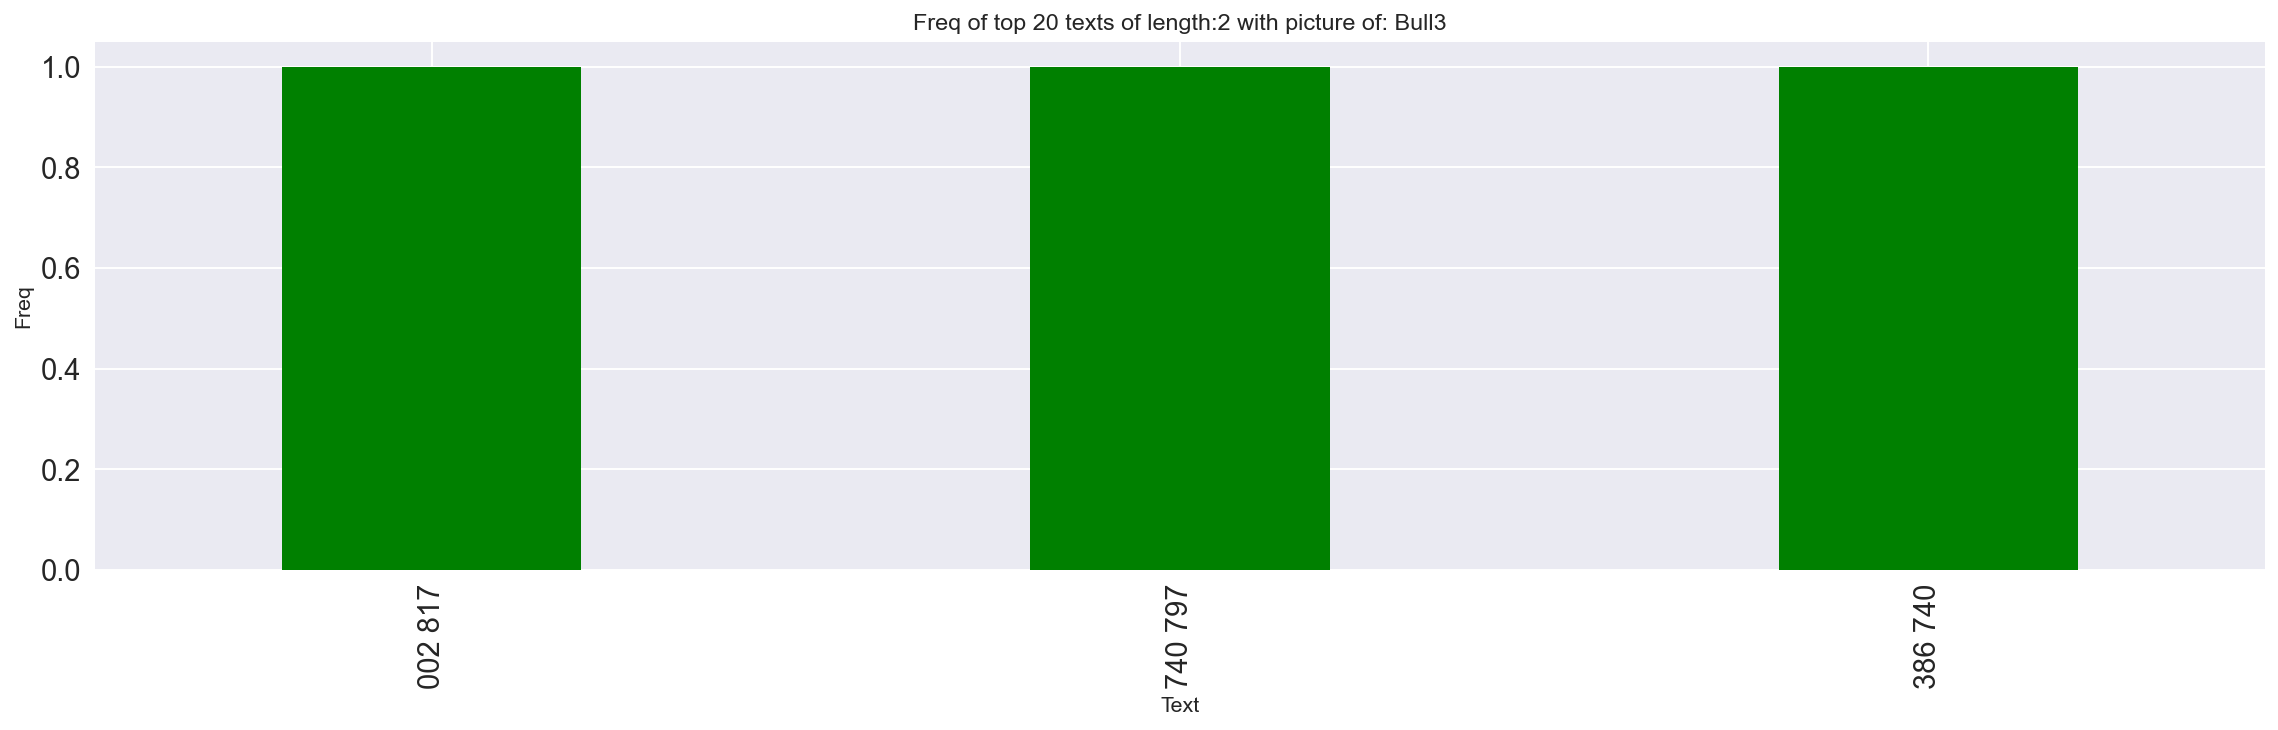

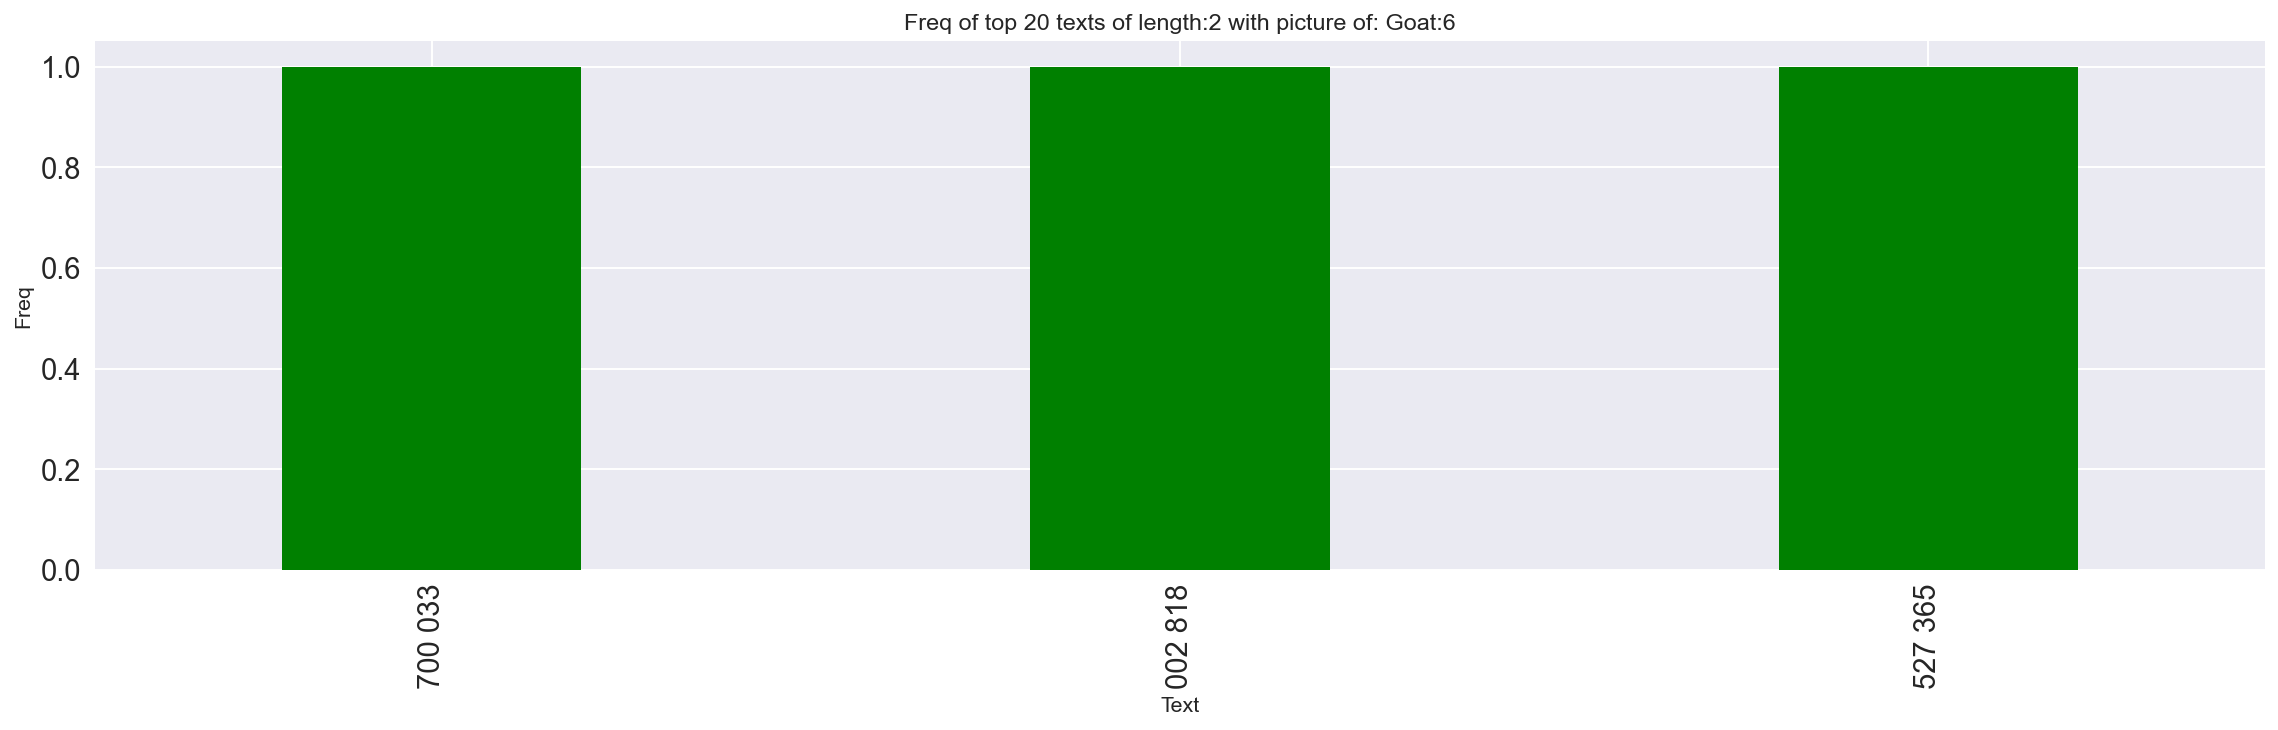

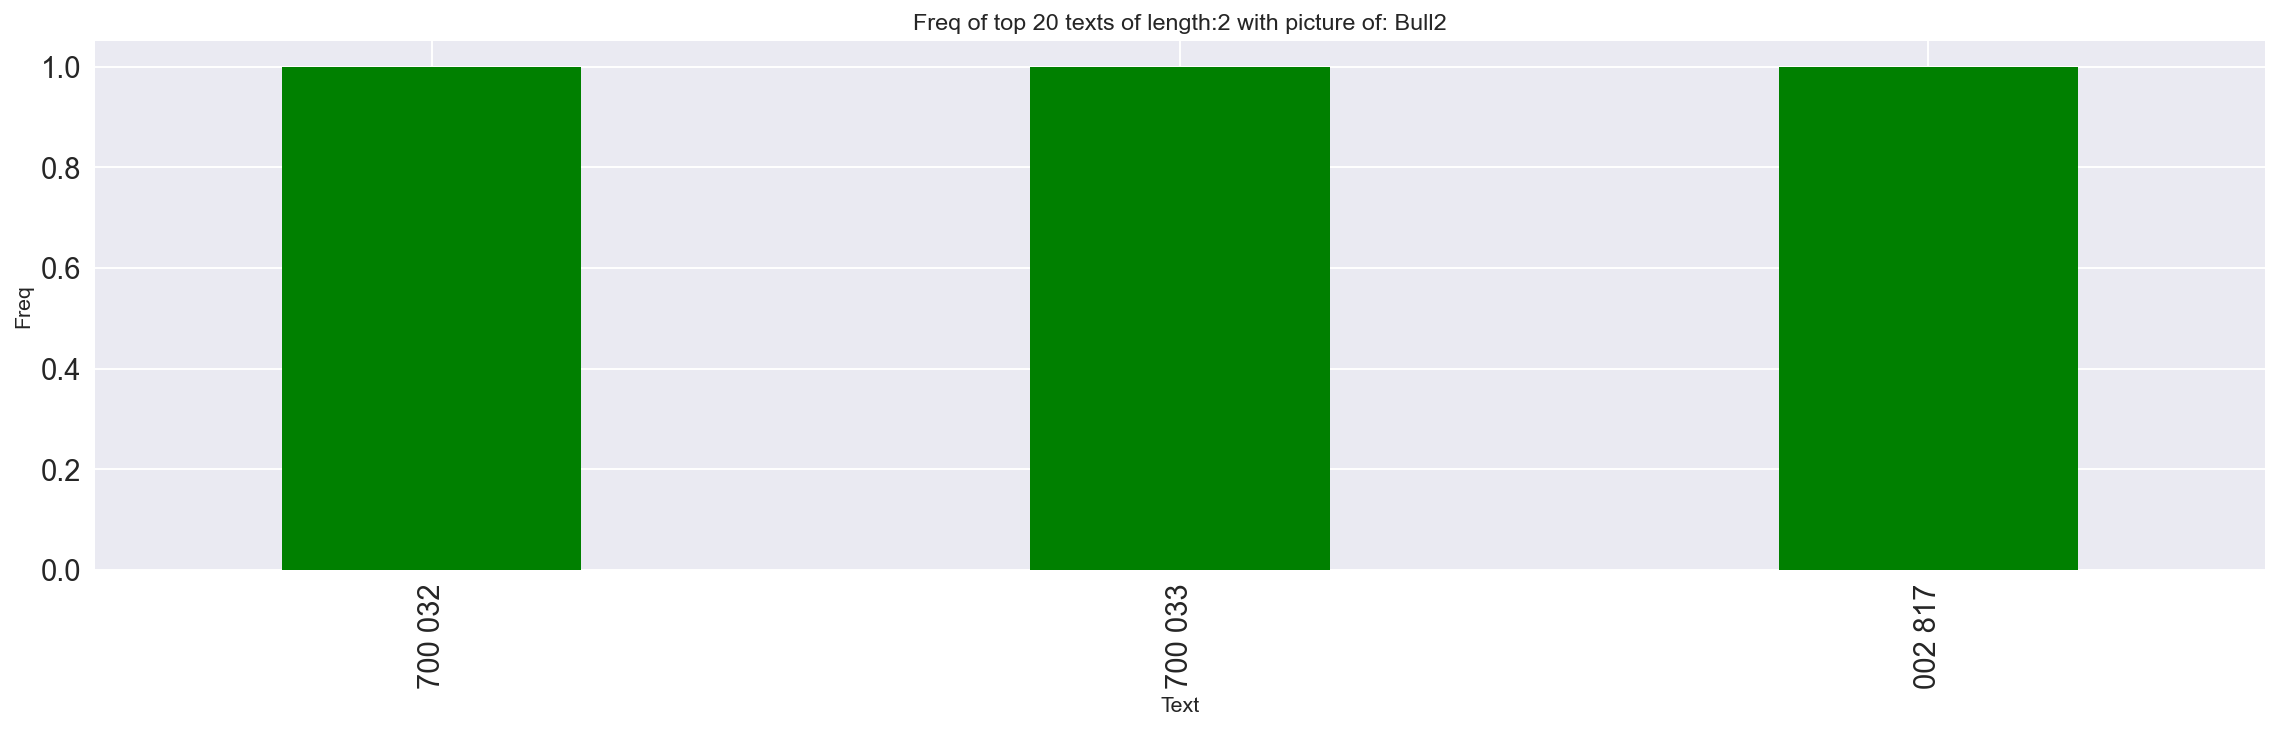

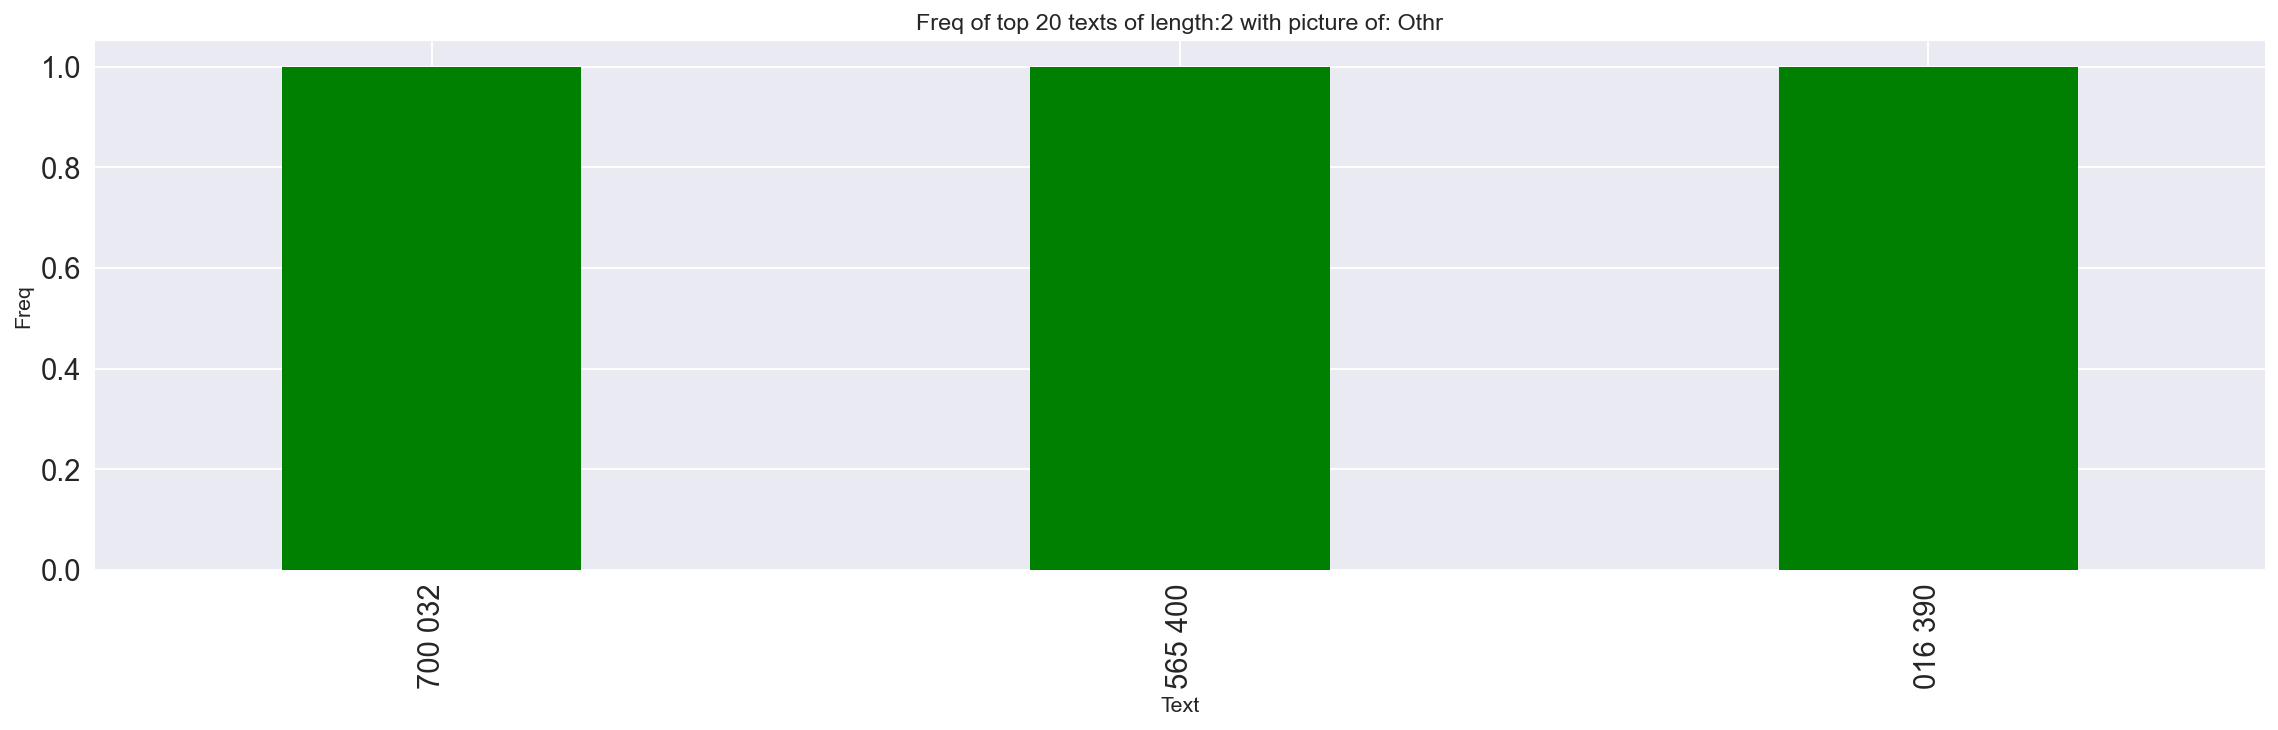

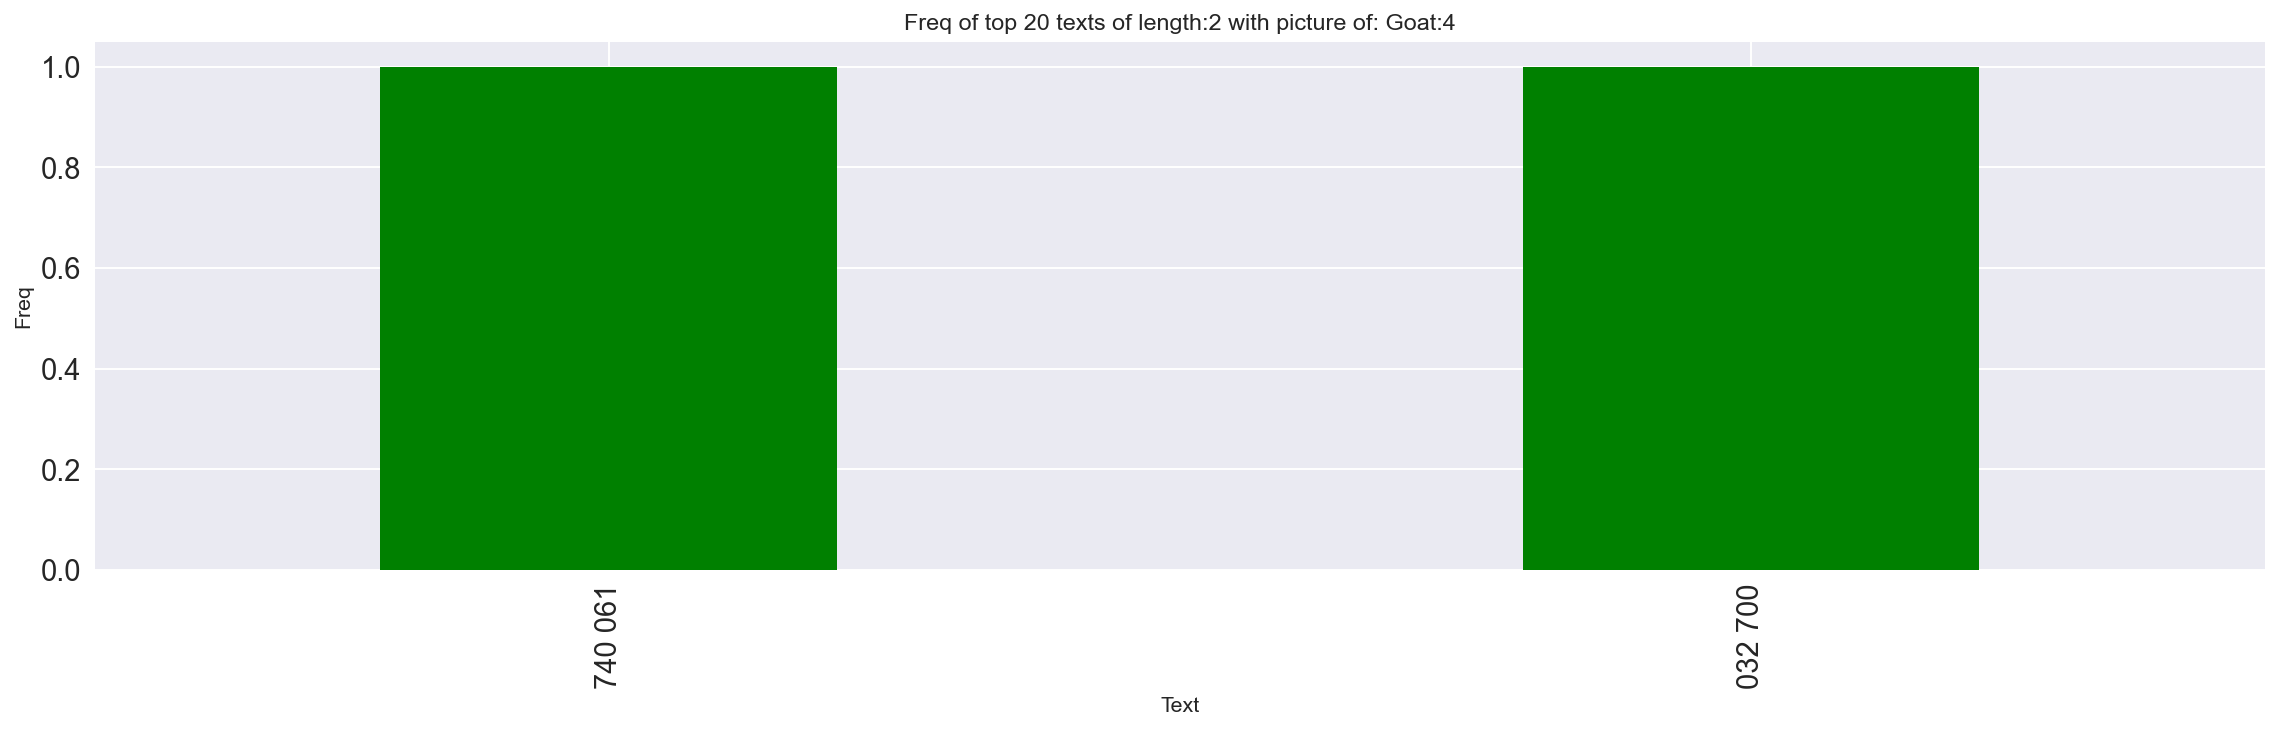

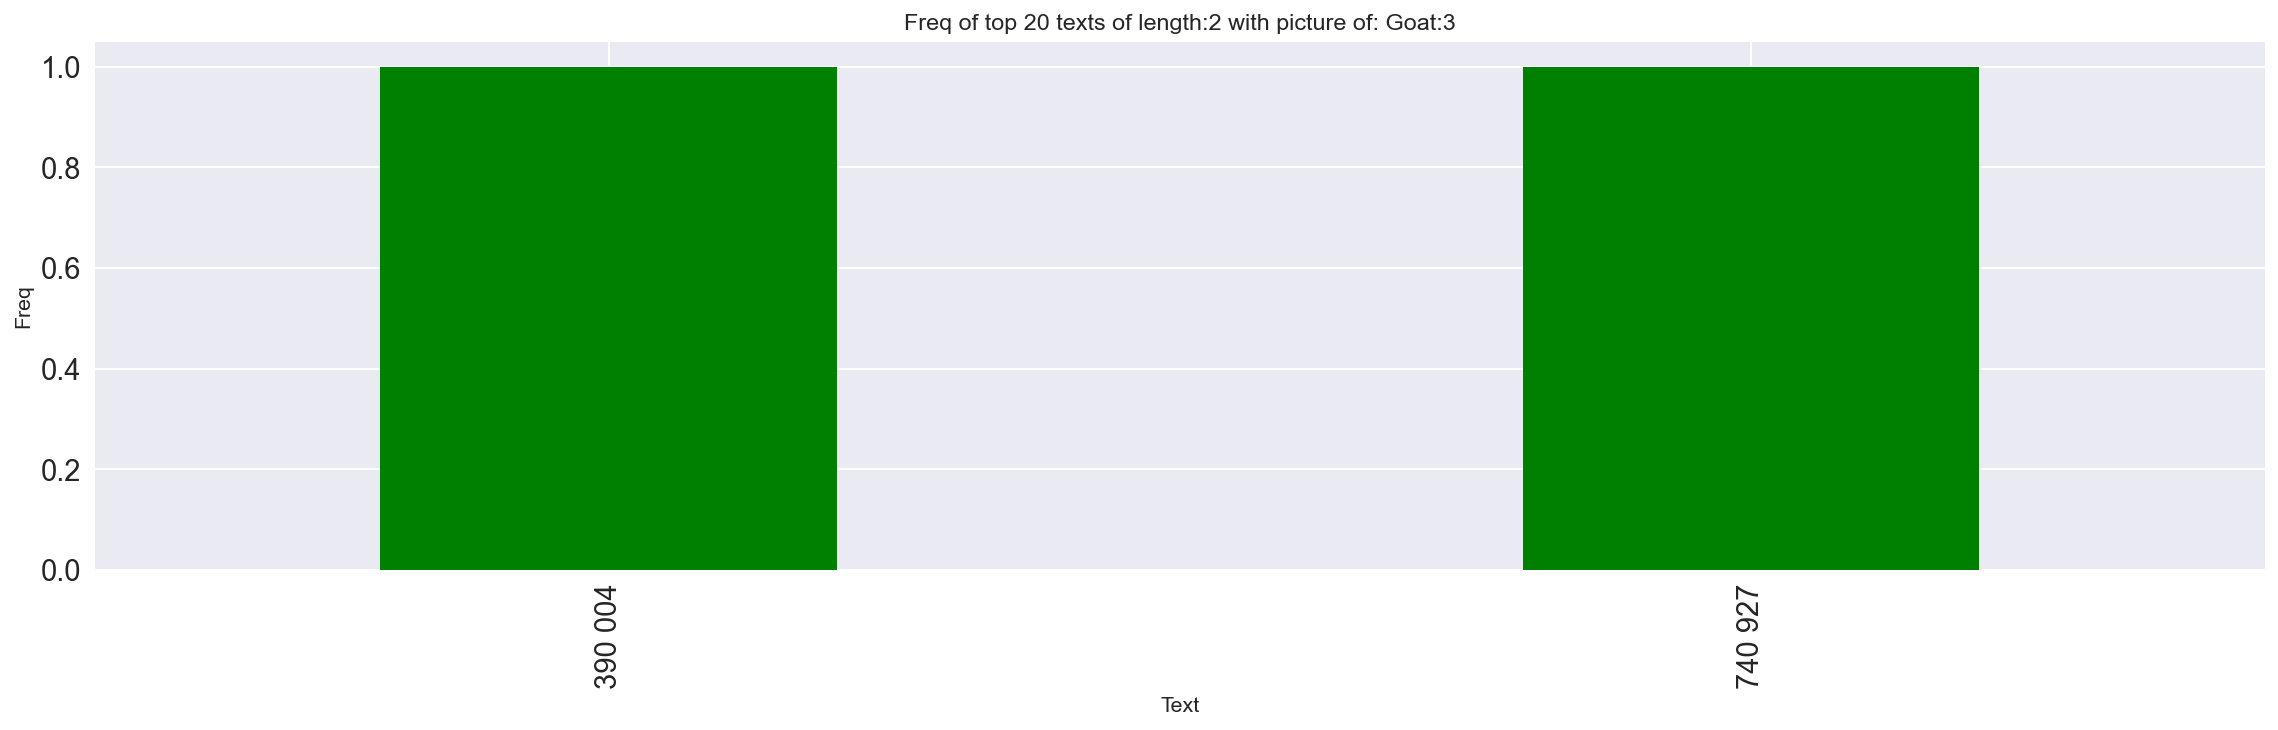

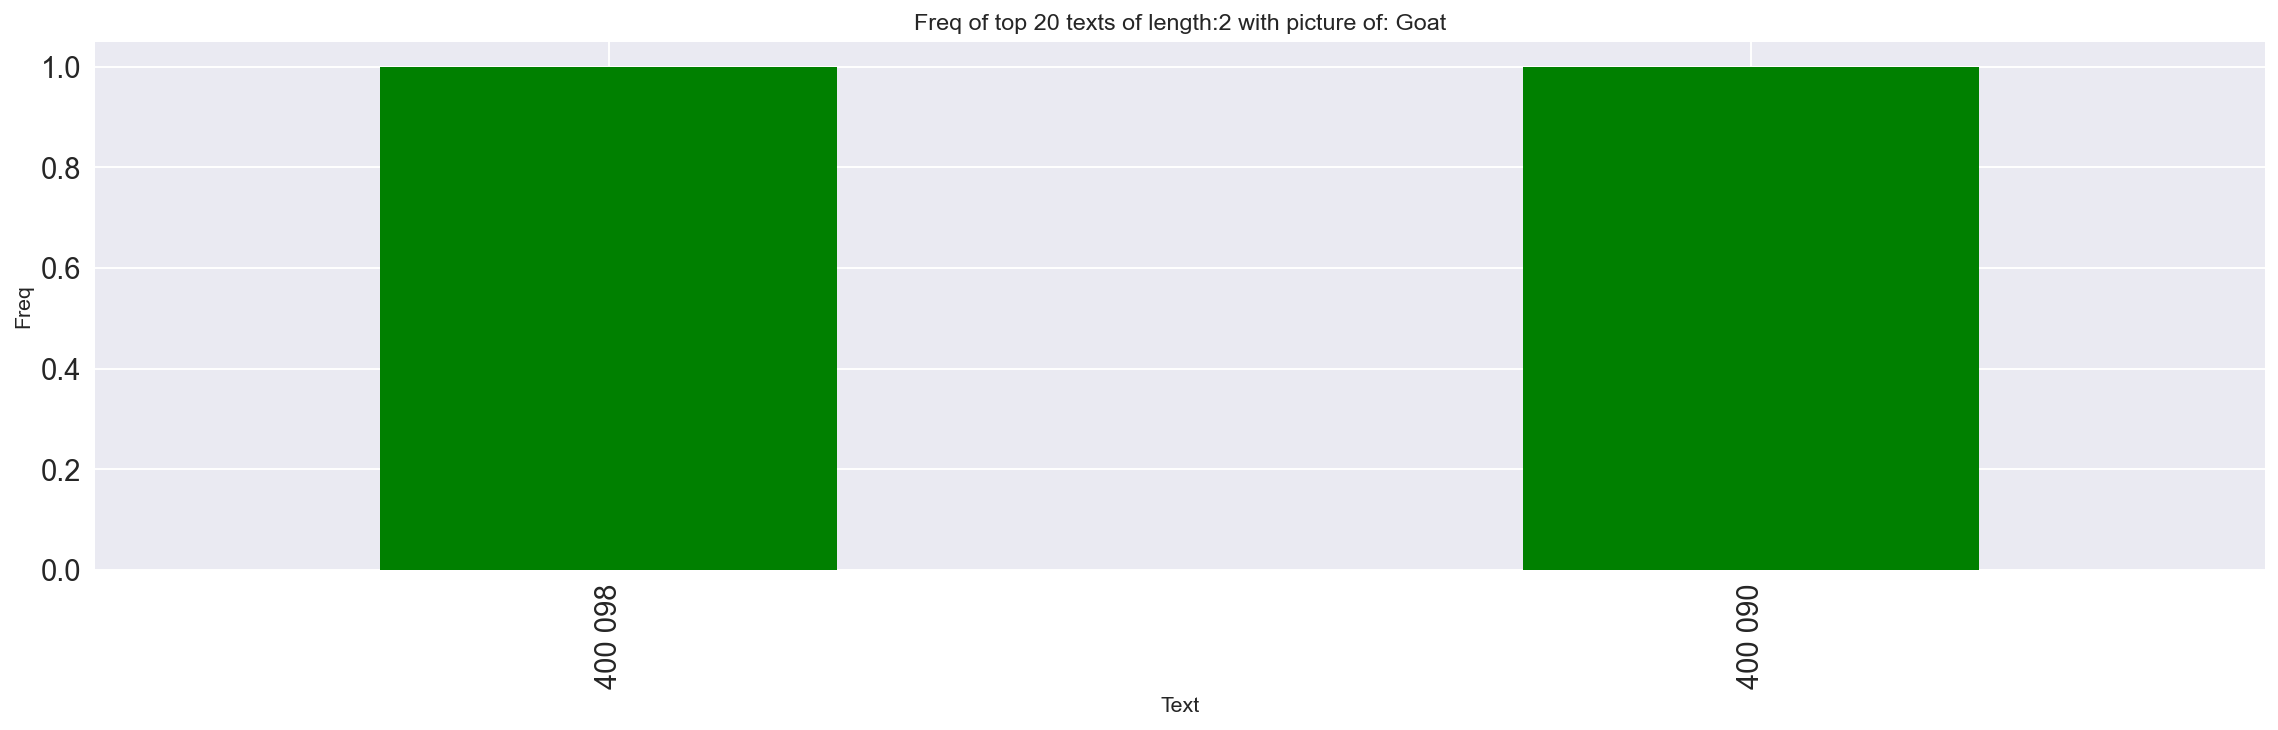

In [60]:
#Note: Duplicated texts + Keyword if found more than once are removed and only first instance kept. So we don't expect to see a text with freq >1

for keywords in pd_keywords1:
    x= df_keywords_text.dropna(subset=[keywords])
    x[keywords].plot(kind='bar', color='green',width = 0.4)

    plt.xlabel("Text")
    plt.ylabel("Freq")
    plt.title("Freq of top 20 texts of length:" + str(text_length) + " with picture of: " + keywords)

    plt.show()